# LASERNet Microstructure Training - Temperature Range Comparison

This notebook trains two models with different solidus/liquidus temperature ranges:
1. T_solidus=1560K, T_liquidus=1620K (narrow range)
2. T_solidus=1530K, T_liquidus=1650K (wider range)

In [1]:
from __future__ import annotations

import json
from datetime import datetime
from pathlib import Path
from typing import Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from lasernet.dataset import MicrostructureSequenceDataset
from lasernet.dataset.fast_loading import FastMicrostructureSequenceDataset
from lasernet.model.MicrostructureCNN_LSTM import MicrostructureCNN_LSTM
from lasernet.model.losses import CombinedLoss
from lasernet.utils import plot_losses

import os
os.environ["BLACKHOLE"] = "/dtu/blackhole/06/168550"

In [2]:
# Setup device
def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device("cpu")
        print("Using CPU only")
    return device

device = get_device()
print(f"Device: {device}")

Using GPU
Device: cuda


## Configuration

In [3]:
# Training hyperparameters (same for both runs)
BATCH_SIZE = 16
SEQ_LENGTH = 4
PLANE = "xz"
SPLIT_RATIO = "12,6,6"

# Parse split ratios
split_ratios = list(map(int, SPLIT_RATIO.split(",")))
train_ratio = split_ratios[0] / sum(split_ratios)
val_ratio = split_ratios[1] / sum(split_ratios)
test_ratio = split_ratios[2] / sum(split_ratios)

print(f"Datsa loading configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Sequence length: {SEQ_LENGTH}")
print(f"  Plane: {PLANE}")
print(f"  Split ratio: {SPLIT_RATIO} (train={train_ratio:.2f}, val={val_ratio:.2f}, test={test_ratio:.2f})")

Datsa loading configuration:
  Batch size: 16
  Sequence length: 4
  Plane: xz
  Split ratio: 12,6,6 (train=0.50, val=0.25, test=0.25)


## Load Dataset

In [4]:
# Load datasets (only once, reused for both training runs)
print("Loading datasets...")

# Check if preprocessed files are available for fast loading
from pathlib import Path as PathLib

processed_dir = PathLib("/dtu/blackhole/06/168550/processed/data")
required_files = ["coordinates.pt", "microstructure.pt", "temperature.pt"]
fast_loading_available = all((processed_dir / f).exists() for f in required_files)

if fast_loading_available:
    print("✓ Preprocessed files found - using fast loading")
    DatasetClass = FastMicrostructureSequenceDataset
    dataset_kwargs = {
        "plane": PLANE,
        "split": "train",  # will be overridden for each dataset
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "train_ratio": train_ratio,
        "val_ratio": val_ratio,
        "test_ratio": test_ratio,
    }
else:
    print("⚠ Preprocessed files not found - using standard loading")
    DatasetClass = MicrostructureSequenceDataset
    dataset_kwargs = {
        "plane": PLANE,
        "split": "train",  # will be overridden for each dataset
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "preload": True,
        "train_ratio": train_ratio,
        "val_ratio": val_ratio,
        "test_ratio": test_ratio,
    }

train_dataset = DatasetClass(**{**dataset_kwargs, "split": "train"})
val_dataset = DatasetClass(**{**dataset_kwargs, "split": "val"})
test_dataset = DatasetClass(**{**dataset_kwargs, "split": "test"})

print(f"\nDataset sizes:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples:   {len(val_dataset)}")
print(f"  Test samples:  {len(test_dataset)}")

# Show sample dimensions
sample = train_dataset[0]
print(f"\nSample dimensions:")
print(f"  Context temp:  {sample['context_temp'].shape}")
print(f"  Context micro: {sample['context_micro'].shape}")
print(f"  Future temp:   {sample['future_temp'].shape}")
print(f"  Target micro:  {sample['target_micro'].shape}")

Loading datasets...
✓ Preprocessed files found - using fast loading

Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data


  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Plane: xz
  Split: train
  Timesteps: 12
  Valid sequences: 7
  Slices: 94
  Total samples: 658


Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data


  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Plane: xz
  Split: val
  Timesteps: 6
  Valid sequences: 1
  Slices: 94
  Total samples: 94


Loading preprocessed data from: /dtu/blackhole/06/168550/processed/data


  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
  Microstructure: torch.Size([24, 465, 94, 47, 10]) (1880.8 MB)
  Plane: xz
  Split: test
  Timesteps: 6
  Valid sequences: 1
  Slices: 94
  Total samples: 94


Dataset sizes:
  Train samples: 658
  Val samples:   94
  Test samples:  94

Sample dimensions:
  Context temp:  torch.Size([4, 1, 465, 47])
  Context micro: torch.Size([4, 9, 465, 47])
  Future temp:   torch.Size([1, 465, 47])
  Target micro:  torch.Size([9, 465, 47])


In [5]:
# Create DataLoaders
print("\nCreating DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")


Creating DataLoaders...
DataLoaders created with batch size: 16


In [6]:
# Training hyperparameters (same for both runs)
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
USE_WEIGHTED_LOSS = True
LOSS_TYPE = "combined"
WEIGHT_SCALE = 0.1
BASE_WEIGHT = 0.1
PATIENCE = 15

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Sequence length: {SEQ_LENGTH}")
print(f"  Plane: {PLANE}")
print(f"  Split ratio: {SPLIT_RATIO} (train={train_ratio:.2f}, val={val_ratio:.2f}, test={test_ratio:.2f})")
print(f"  Loss type: {LOSS_TYPE}")

Training configuration:
  Epochs: 50
  Batch size: 16
  Learning rate: 0.001
  Sequence length: 4
  Plane: xz
  Split ratio: 12,6,6 (train=0.50, val=0.25, test=0.25)
  Loss type: combined


## Training Functions

In [7]:
def train_microstructure(
    model: MicrostructureCNN_LSTM,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    epochs: int,
    run_dir: Path,
    patience: int = 15,
) -> Dict[str, list[float]]:
    """Training loop for microstructure prediction with early stopping."""

    history: Dict[str, list[float]] = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # ==================== TRAINING ====================
        model.train()
        train_loss = 0.0
        num_train_samples = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
        for batch in train_pbar:
            # Extract data
            context_temp = batch["context_temp"].float().to(device)
            context_micro = batch["context_micro"].float().to(device)
            future_temp = batch["future_temp"].float().to(device)
            target_micro = batch["target_micro"].float().to(device)
            target_mask = batch["target_mask"].to(device)

            # Combine context
            context = torch.cat([context_temp, context_micro], dim=2)

            optimizer.zero_grad()

            # Forward pass
            pred_micro = model(context, future_temp)

            # Compute loss
            loss = criterion(pred_micro, target_micro, future_temp, target_mask)

            loss.backward()
            optimizer.step()

            batch_size = context.size(0)
            train_loss += loss.item() * batch_size
            num_train_samples += batch_size

            train_pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        avg_train_loss = train_loss / max(1, num_train_samples)
        history["train_loss"].append(avg_train_loss)

        # ==================== VALIDATION ====================
        model.eval()
        val_loss = 0.0
        num_val_samples = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False)
            for batch in val_pbar:
                context_temp = batch["context_temp"].float().to(device)
                context_micro = batch["context_micro"].float().to(device)
                future_temp = batch["future_temp"].float().to(device)
                target_micro = batch["target_micro"].float().to(device)
                target_mask = batch["target_mask"].to(device)

                context = torch.cat([context_temp, context_micro], dim=2)
                pred_micro = model(context, future_temp)

                loss = criterion(pred_micro, target_micro, future_temp, target_mask)

                batch_size = context.size(0)
                val_loss += loss.item() * batch_size
                num_val_samples += batch_size

                val_pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        avg_val_loss = val_loss / max(1, num_val_samples)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}: train loss={avg_train_loss:.6f}, val loss={avg_val_loss:.6f}")

        # Save best model and early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, run_dir / "checkpoints" / "best_model.pt")
            print(f"  → Best model saved (val loss: {avg_val_loss:.6f})")
        else:
            epochs_without_improvement += 1
            print(f"  → No improvement for {epochs_without_improvement} epoch(s)")

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

    return history


def evaluate_test(
    model: MicrostructureCNN_LSTM,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    """Evaluate model on test set."""

    print("\n" + "=" * 70)
    print("Evaluating on test set...")
    print("=" * 70)

    model.eval()
    test_loss = 0.0
    num_test_samples = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Testing", leave=False)
        for batch in test_pbar:
            context_temp = batch["context_temp"].float().to(device)
            context_micro = batch["context_micro"].float().to(device)
            future_temp = batch["future_temp"].float().to(device)
            target_micro = batch["target_micro"].float().to(device)
            target_mask = batch["target_mask"].to(device)

            context = torch.cat([context_temp, context_micro], dim=2)
            pred_micro = model(context, future_temp)

            loss = criterion(pred_micro, target_micro, future_temp, target_mask)

            batch_size = context.size(0)
            test_loss += loss.item() * batch_size
            num_test_samples += batch_size

            test_pbar.set_postfix({"loss": f"{loss.item():.6f}"})

    avg_test_loss = test_loss / max(1, num_test_samples)
    print(f"Test loss: {avg_test_loss:.6f}")

    return {
        "test_loss": avg_test_loss,
        "num_samples": num_test_samples,
    }

print("Training functions defined.")

Training functions defined.


## Training Run 1: T_solidus=1560K, T_liquidus=1620K

In [8]:
# Configuration for Run 1
T_SOLIDUS_1 = 1560.0
T_LIQUIDUS_1 = 1620.0

print("=" * 70)
print("Training Run 1")
print("=" * 70)
print(f"T_solidus:  {T_SOLIDUS_1} K")
print(f"T_liquidus: {T_LIQUIDUS_1} K")
print()

# Create run directory
timestamp_1 = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_dir_1 = Path("runs_micro_net_cnn_lstm") / f"{timestamp_1}_T{int(T_SOLIDUS_1)}-{int(T_LIQUIDUS_1)}"
run_dir_1.mkdir(parents=True, exist_ok=True)
(run_dir_1 / "checkpoints").mkdir(exist_ok=True)

print(f"Run directory: {run_dir_1}")

# Create model
model_1 = MicrostructureCNN_LSTM(
    input_channels=10,
    future_channels=1,
    output_channels=9,
).to(device)

param_count_1 = model_1.count_parameters()
print(f"\nModel: MicrostructureCNN_LSTM")
print(f"  Total parameters: {param_count_1:,}")
print(f"  Memory (FP32):    ~{param_count_1 * 4 / 1024**2:.1f} MB")

# Create loss function
criterion_1 = CombinedLoss(
    solidification_weight=0.7,
    global_weight=0.3,
    T_solidus=T_SOLIDUS_1,
    T_liquidus=T_LIQUIDUS_1,
    weight_type="gaussian",
    weight_scale=WEIGHT_SCALE,
    base_weight=BASE_WEIGHT,
)

print(f"\nLoss function: CombinedLoss (70% solidification + 30% global MSE)")

# Create optimizer
optimizer_1 = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

# Save configuration
config_1 = {
    "timestamp": timestamp_1,
    "model": {
        "name": "MicrostructureCNN_LSTM",
        "parameters": param_count_1,
        "input_channels": 10,
        "future_channels": 1,
        "output_channels": 9,
    },
    "training": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "optimizer": "Adam",
        "loss": "CombinedLoss",
        "loss_params": {
            "solidification_weight": 0.7,
            "global_weight": 0.3,
            "T_solidus": T_SOLIDUS_1,
            "T_liquidus": T_LIQUIDUS_1,
            "weight_type": "gaussian",
            "weight_scale": WEIGHT_SCALE,
            "base_weight": BASE_WEIGHT,
        },
    },
    "dataset": {
        "plane": PLANE,
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset),
        "test_samples": len(test_dataset),
    },
    "device": str(device),
}

with open(run_dir_1 / "config.json", "w") as f:
    json.dump(config_1, f, indent=2)

print(f"\nConfiguration saved to {run_dir_1 / 'config.json'}")

Training Run 1
T_solidus:  1560.0 K
T_liquidus: 1620.0 K

Run directory: runs_micro_net_cnn_lstm/2025-11-27_15-40-51_T1560-1620



Model: MicrostructureCNN_LSTM
  Total parameters: 440,425
  Memory (FP32):    ~1.7 MB

Loss function: CombinedLoss (70% solidification + 30% global MSE)



Configuration saved to runs_micro_net_cnn_lstm/2025-11-27_15-40-51_T1560-1620/config.json


In [9]:
# Train model 1
print("\nStarting training...\n")

history_1 = train_microstructure(
    model=model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_1,
    criterion=criterion_1,
    device=device,
    epochs=EPOCHS,
    run_dir=run_dir_1,
    patience=PATIENCE,
)

print("\n" + "=" * 70)
print("Training Run 1 Complete!")
print("=" * 70)
print(f"Final train loss: {history_1['train_loss'][-1]:.6f}")
print(f"Final val loss:   {history_1['val_loss'][-1]:.6f}")

# Save history
with open(run_dir_1 / "history.json", "w") as f:
    json.dump(history_1, f, indent=2)

# Plot losses
plot_losses(history_1, str(run_dir_1 / "training_losses.png"))

# Save final model
torch.save({
    'epoch': len(history_1['train_loss']),
    'model_state_dict': model_1.state_dict(),
    'optimizer_state_dict': optimizer_1.state_dict(),
    'config': config_1,
    'history': history_1,
}, run_dir_1 / "checkpoints" / "final_model.pt")

print(f"\nOutputs saved to: {run_dir_1}")


Starting training...




Epoch 1/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 1/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:01<?, ?it/s, loss=0.618240]


Epoch 1/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:01<00:43,  1.05s/it, loss=0.618240]


Epoch 1/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:01<00:43,  1.05s/it, loss=0.550295]


Epoch 1/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:01<00:20,  1.95it/s, loss=0.550295]


Epoch 1/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:01<00:20,  1.95it/s, loss=0.503157]


Epoch 1/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:01<00:12,  3.03it/s, loss=0.503157]


Epoch 1/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:01<00:12,  3.03it/s, loss=0.474163]


Epoch 1/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:01<00:09,  4.04it/s, loss=0.474163]


Epoch 1/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:01<00:09,  4.04it/s, loss=0.452087]


Epoch 1/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:01<00:07,  4.77it/s, loss=0.452087]


Epoch 1/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:01<00:07,  4.77it/s, loss=0.430431]


Epoch 1/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.41it/s, loss=0.430431]


Epoch 1/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.41it/s, loss=0.420116]


Epoch 1/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:06,  5.64it/s, loss=0.420116]


Epoch 1/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:02<00:06,  5.64it/s, loss=0.402970]


Epoch 1/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:02<00:06,  5.66it/s, loss=0.402970]


Epoch 1/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:02<00:06,  5.66it/s, loss=0.388412]


Epoch 1/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:02<00:05,  5.85it/s, loss=0.388412]


Epoch 1/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:02<00:05,  5.85it/s, loss=0.378553]


Epoch 1/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:02<00:05,  5.90it/s, loss=0.378553]


Epoch 1/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:02<00:05,  5.90it/s, loss=0.363716]


Epoch 1/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:02<00:05,  5.91it/s, loss=0.363716]


Epoch 1/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:02<00:05,  5.91it/s, loss=0.352169]


Epoch 1/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:05,  5.74it/s, loss=0.352169]


Epoch 1/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:05,  5.74it/s, loss=0.344963]


Epoch 1/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:05,  5.67it/s, loss=0.344963]


Epoch 1/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:03<00:05,  5.67it/s, loss=0.337928]


Epoch 1/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:03<00:05,  5.36it/s, loss=0.337928]


Epoch 1/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:03<00:05,  5.36it/s, loss=0.332124]


Epoch 1/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:03<00:04,  5.48it/s, loss=0.332124]


Epoch 1/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:03<00:04,  5.48it/s, loss=0.323990]


Epoch 1/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:03<00:04,  5.72it/s, loss=0.323990]


Epoch 1/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:03<00:04,  5.72it/s, loss=0.312538]


Epoch 1/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:03<00:04,  5.68it/s, loss=0.312538]


Epoch 1/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:03<00:04,  5.68it/s, loss=0.309824]


Epoch 1/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:04,  5.88it/s, loss=0.309824]


Epoch 1/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:04,  5.88it/s, loss=0.297701]


Epoch 1/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  5.89it/s, loss=0.297701]


Epoch 1/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:04<00:03,  5.89it/s, loss=0.294042]


Epoch 1/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:04<00:03,  6.12it/s, loss=0.294042]


Epoch 1/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:04<00:03,  6.12it/s, loss=0.288465]


Epoch 1/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:04<00:03,  6.28it/s, loss=0.288465]


Epoch 1/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:04<00:03,  6.28it/s, loss=0.285124]


Epoch 1/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:04<00:03,  6.18it/s, loss=0.285124]


Epoch 1/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:04<00:03,  6.18it/s, loss=0.273670]


Epoch 1/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:04<00:02,  6.34it/s, loss=0.273670]


Epoch 1/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:04<00:02,  6.34it/s, loss=0.266186]


Epoch 1/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:04<00:02,  6.33it/s, loss=0.266186]


Epoch 1/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:04<00:02,  6.33it/s, loss=0.262385]


Epoch 1/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:04<00:02,  6.41it/s, loss=0.262385]


Epoch 1/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:05<00:02,  6.41it/s, loss=0.253680]


Epoch 1/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:05<00:02,  6.53it/s, loss=0.253680]


Epoch 1/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:05<00:02,  6.53it/s, loss=0.242403]


Epoch 1/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:05<00:02,  6.83it/s, loss=0.242403]


Epoch 1/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:05<00:02,  6.83it/s, loss=0.244280]


Epoch 1/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:05<00:01,  7.40it/s, loss=0.244280]


Epoch 1/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:05<00:01,  7.40it/s, loss=0.234720]


Epoch 1/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:05<00:01,  6.77it/s, loss=0.234720]


Epoch 1/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:05<00:01,  6.77it/s, loss=0.228349]


Epoch 1/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:05<00:01,  7.06it/s, loss=0.228349]


Epoch 1/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:05<00:01,  7.06it/s, loss=0.225049]


Epoch 1/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:05<00:01,  6.76it/s, loss=0.225049]


Epoch 1/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:05<00:01,  6.76it/s, loss=0.219292]


Epoch 1/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:05<00:01,  7.32it/s, loss=0.219292]


Epoch 1/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:05<00:01,  7.32it/s, loss=0.215389]


Epoch 1/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  7.82it/s, loss=0.215389]


Epoch 1/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:06<00:01,  7.82it/s, loss=0.210199]


Epoch 1/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:06<00:00,  8.09it/s, loss=0.210199]


Epoch 1/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:06<00:00,  8.09it/s, loss=0.207409]


Epoch 1/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:06<00:00,  7.51it/s, loss=0.207409]


Epoch 1/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:06<00:00,  7.51it/s, loss=0.202602]


Epoch 1/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:06<00:00,  7.42it/s, loss=0.202602]


Epoch 1/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:06<00:00,  7.42it/s, loss=0.195902]


Epoch 1/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:06<00:00,  7.21it/s, loss=0.195902]


Epoch 1/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:06<00:00,  7.21it/s, loss=0.190663]


Epoch 1/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  7.17it/s, loss=0.190663]


Epoch 1/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  7.17it/s, loss=0.189726]


Epoch 1/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  7.62it/s, loss=0.189726]


Epoch 1/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  7.62it/s, loss=0.182309]


Epoch 1/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.01it/s, loss=0.182309]


Epoch 1/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:07<00:00,  7.01it/s, loss=0.180796]


Epoch 1/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:07<00:00,  6.95it/s, loss=0.180796]


Epoch 1/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:07<00:00,  6.95it/s, loss=0.175255]


Epoch 1/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 1/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.208105]


Epoch 1/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.38it/s, loss=0.208105]


Epoch 1/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.38it/s, loss=0.208484]


Epoch 1/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.38it/s, loss=0.202783]


Epoch 1/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.26it/s, loss=0.202783]


Epoch 1/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.26it/s, loss=0.200577]


Epoch 1/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.26it/s, loss=0.206186]


Epoch 1/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.53it/s, loss=0.206186]


Epoch 1/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.53it/s, loss=0.209997]

Epoch 1/50: train loss=0.309007, val loss=0.205937
  → Best model saved (val loss: 0.205937)



Epoch 2/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 2/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.171421]


Epoch 2/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  6.94it/s, loss=0.171421]


Epoch 2/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  6.94it/s, loss=0.166538]


Epoch 2/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.47it/s, loss=0.166538]


Epoch 2/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.47it/s, loss=0.164287]


Epoch 2/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.60it/s, loss=0.164287]


Epoch 2/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.60it/s, loss=0.159721]


Epoch 2/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  7.82it/s, loss=0.159721]


Epoch 2/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  7.82it/s, loss=0.156333]


Epoch 2/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.59it/s, loss=0.156333]


Epoch 2/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.59it/s, loss=0.152063]


Epoch 2/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  7.13it/s, loss=0.152063]


Epoch 2/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  7.13it/s, loss=0.151114]


Epoch 2/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.11it/s, loss=0.151114]


Epoch 2/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.11it/s, loss=0.146709]


Epoch 2/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.02it/s, loss=0.146709]


Epoch 2/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.02it/s, loss=0.144571]


Epoch 2/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.65it/s, loss=0.144571]


Epoch 2/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.65it/s, loss=0.140888]


Epoch 2/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.40it/s, loss=0.140888]


Epoch 2/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.40it/s, loss=0.136821]


Epoch 2/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.76it/s, loss=0.136821]


Epoch 2/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.76it/s, loss=0.134962]


Epoch 2/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.77it/s, loss=0.134962]


Epoch 2/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.77it/s, loss=0.130603]


Epoch 2/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.76it/s, loss=0.130603]


Epoch 2/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.76it/s, loss=0.130020]


Epoch 2/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.41it/s, loss=0.130020]


Epoch 2/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.41it/s, loss=0.126094]


Epoch 2/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.98it/s, loss=0.126094]


Epoch 2/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.98it/s, loss=0.124799]


Epoch 2/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.33it/s, loss=0.124799]


Epoch 2/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.33it/s, loss=0.121080]


Epoch 2/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.121080]


Epoch 2/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.120480]


Epoch 2/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.72it/s, loss=0.120480]


Epoch 2/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.72it/s, loss=0.117807]


Epoch 2/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.81it/s, loss=0.117807]


Epoch 2/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.81it/s, loss=0.116182]


Epoch 2/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.48it/s, loss=0.116182]


Epoch 2/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.48it/s, loss=0.113795]


Epoch 2/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.75it/s, loss=0.113795]


Epoch 2/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.75it/s, loss=0.113322]


Epoch 2/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.43it/s, loss=0.113322]


Epoch 2/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.43it/s, loss=0.109836]


Epoch 2/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.95it/s, loss=0.109836]


Epoch 2/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.95it/s, loss=0.109166]


Epoch 2/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.30it/s, loss=0.109166]


Epoch 2/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.30it/s, loss=0.107111]


Epoch 2/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.15it/s, loss=0.107111]


Epoch 2/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.15it/s, loss=0.106408]


Epoch 2/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.56it/s, loss=0.106408]


Epoch 2/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.56it/s, loss=0.103276]


Epoch 2/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.29it/s, loss=0.103276]


Epoch 2/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.29it/s, loss=0.102866]


Epoch 2/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  8.66it/s, loss=0.102866]


Epoch 2/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  8.66it/s, loss=0.102303]


Epoch 2/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  8.87it/s, loss=0.102303]


Epoch 2/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  8.87it/s, loss=0.099770]


Epoch 2/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  8.86it/s, loss=0.099770]


Epoch 2/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  8.86it/s, loss=0.097305]


Epoch 2/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.95it/s, loss=0.097305]


Epoch 2/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.95it/s, loss=0.096231]


Epoch 2/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.86it/s, loss=0.096231]


Epoch 2/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.86it/s, loss=0.094068]


Epoch 2/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.47it/s, loss=0.094068]


Epoch 2/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.47it/s, loss=0.093480]


Epoch 2/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.46it/s, loss=0.093480]


Epoch 2/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.46it/s, loss=0.092639]


Epoch 2/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.00it/s, loss=0.092639]


Epoch 2/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.00it/s, loss=0.091399]


Epoch 2/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.25it/s, loss=0.091399]


Epoch 2/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.25it/s, loss=0.090914]


Epoch 2/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  7.09it/s, loss=0.090914]


Epoch 2/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.09it/s, loss=0.089619]


Epoch 2/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.75it/s, loss=0.089619]


Epoch 2/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.75it/s, loss=0.088552]


Epoch 2/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.81it/s, loss=0.088552]


Epoch 2/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.81it/s, loss=0.087046]


Epoch 2/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.30it/s, loss=0.087046]


Epoch 2/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.30it/s, loss=0.086871]


Epoch 2/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.81it/s, loss=0.086871]


Epoch 2/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.81it/s, loss=0.095688]


Epoch 2/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 2/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.098017]


Epoch 2/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.67it/s, loss=0.098017]


Epoch 2/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.67it/s, loss=0.097936]


Epoch 2/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.63it/s, loss=0.097936]


Epoch 2/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.63it/s, loss=0.096333]


Epoch 2/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.61it/s, loss=0.096333]


Epoch 2/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.61it/s, loss=0.096304]


Epoch 2/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.096304]


Epoch 2/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.098677]


Epoch 2/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.096903]


Epoch 2/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.83it/s, loss=0.096903]

Epoch 2/50: train loss=0.119159, val loss=0.097371
  → Best model saved (val loss: 0.097371)



Epoch 3/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 3/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.083761]


Epoch 3/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.75it/s, loss=0.083761]


Epoch 3/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.75it/s, loss=0.084146]


Epoch 3/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.83it/s, loss=0.084146]


Epoch 3/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.83it/s, loss=0.083249]


Epoch 3/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  5.78it/s, loss=0.083249]


Epoch 3/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  5.78it/s, loss=0.083686]


Epoch 3/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:07,  5.38it/s, loss=0.083686]


Epoch 3/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:07,  5.38it/s, loss=0.080863]


Epoch 3/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:06,  5.54it/s, loss=0.080863]


Epoch 3/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:01<00:06,  5.54it/s, loss=0.080998]


Epoch 3/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.42it/s, loss=0.080998]


Epoch 3/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.42it/s, loss=0.081464]


Epoch 3/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:06,  5.28it/s, loss=0.081464]


Epoch 3/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:06,  5.28it/s, loss=0.079300]


Epoch 3/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:06,  5.65it/s, loss=0.079300]


Epoch 3/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:06,  5.65it/s, loss=0.080878]


Epoch 3/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:05,  5.63it/s, loss=0.080878]


Epoch 3/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:05,  5.63it/s, loss=0.079245]


Epoch 3/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:05,  5.95it/s, loss=0.079245]


Epoch 3/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:05,  5.95it/s, loss=0.077931]


Epoch 3/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:05,  6.03it/s, loss=0.077931]


Epoch 3/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:02<00:05,  6.03it/s, loss=0.077164]


Epoch 3/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:04,  6.20it/s, loss=0.077164]


Epoch 3/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:04,  6.20it/s, loss=0.076609]


Epoch 3/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.43it/s, loss=0.076609]


Epoch 3/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.43it/s, loss=0.077682]


Epoch 3/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.29it/s, loss=0.077682]


Epoch 3/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.29it/s, loss=0.075588]


Epoch 3/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.01it/s, loss=0.075588]


Epoch 3/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.01it/s, loss=0.075351]


Epoch 3/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.32it/s, loss=0.075351]


Epoch 3/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.32it/s, loss=0.073990]


Epoch 3/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.43it/s, loss=0.073990]


Epoch 3/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.43it/s, loss=0.074982]


Epoch 3/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.09it/s, loss=0.074982]


Epoch 3/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:03,  7.09it/s, loss=0.073144]


Epoch 3/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  7.19it/s, loss=0.073144]


Epoch 3/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  7.19it/s, loss=0.073486]


Epoch 3/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  7.00it/s, loss=0.073486]


Epoch 3/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  7.00it/s, loss=0.072463]


Epoch 3/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.59it/s, loss=0.072463]


Epoch 3/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.59it/s, loss=0.072162]


Epoch 3/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.09it/s, loss=0.072162]


Epoch 3/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.09it/s, loss=0.071698]


Epoch 3/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.37it/s, loss=0.071698]


Epoch 3/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.37it/s, loss=0.071645]


Epoch 3/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.071645]


Epoch 3/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.071322]


Epoch 3/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.77it/s, loss=0.071322]


Epoch 3/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.77it/s, loss=0.071411]


Epoch 3/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.07it/s, loss=0.071411]


Epoch 3/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:04<00:02,  7.07it/s, loss=0.070235]


Epoch 3/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:01,  7.64it/s, loss=0.070235]


Epoch 3/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:01,  7.64it/s, loss=0.069925]


Epoch 3/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  8.10it/s, loss=0.069925]


Epoch 3/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  8.10it/s, loss=0.070671]


Epoch 3/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.64it/s, loss=0.070671]


Epoch 3/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.64it/s, loss=0.069137]


Epoch 3/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.89it/s, loss=0.069137]


Epoch 3/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.89it/s, loss=0.070134]


Epoch 3/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.070134]


Epoch 3/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.068042]


Epoch 3/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.81it/s, loss=0.068042]


Epoch 3/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.81it/s, loss=0.069041]


Epoch 3/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.44it/s, loss=0.069041]


Epoch 3/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  7.44it/s, loss=0.068009]


Epoch 3/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  7.95it/s, loss=0.068009]


Epoch 3/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  7.95it/s, loss=0.068193]


Epoch 3/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.23it/s, loss=0.068193]


Epoch 3/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.23it/s, loss=0.067835]


Epoch 3/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.11it/s, loss=0.067835]


Epoch 3/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.11it/s, loss=0.068082]


Epoch 3/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.80it/s, loss=0.068082]


Epoch 3/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.80it/s, loss=0.067566]


Epoch 3/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.20it/s, loss=0.067566]


Epoch 3/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.20it/s, loss=0.067446]


Epoch 3/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.74it/s, loss=0.067446]


Epoch 3/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.74it/s, loss=0.067069]


Epoch 3/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.42it/s, loss=0.067069]


Epoch 3/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.42it/s, loss=0.065980]


Epoch 3/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.47it/s, loss=0.065980]


Epoch 3/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.47it/s, loss=0.075064]


Epoch 3/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 3/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.071182]


Epoch 3/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.03it/s, loss=0.071182]


Epoch 3/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.03it/s, loss=0.070969]


Epoch 3/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.03it/s, loss=0.069578]


Epoch 3/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.03it/s, loss=0.069578]


Epoch 3/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.03it/s, loss=0.070567]


Epoch 3/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.03it/s, loss=0.071679]


Epoch 3/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.75it/s, loss=0.071679]


Epoch 3/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.75it/s, loss=0.070548]

Epoch 3/50: train loss=0.073945, val loss=0.070758
  → Best model saved (val loss: 0.070758)



Epoch 4/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 4/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.067698]


Epoch 4/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.81it/s, loss=0.067698]


Epoch 4/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.81it/s, loss=0.067761]


Epoch 4/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.85it/s, loss=0.067761]


Epoch 4/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.85it/s, loss=0.067661]


Epoch 4/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.73it/s, loss=0.067661]


Epoch 4/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.73it/s, loss=0.067575]


Epoch 4/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.58it/s, loss=0.067575]


Epoch 4/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.58it/s, loss=0.065878]


Epoch 4/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.71it/s, loss=0.065878]


Epoch 4/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.71it/s, loss=0.066160]


Epoch 4/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.66it/s, loss=0.066160]


Epoch 4/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.66it/s, loss=0.065967]


Epoch 4/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.23it/s, loss=0.065967]


Epoch 4/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.23it/s, loss=0.066320]


Epoch 4/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.34it/s, loss=0.066320]


Epoch 4/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.34it/s, loss=0.065725]


Epoch 4/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.04it/s, loss=0.065725]


Epoch 4/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.04it/s, loss=0.065090]


Epoch 4/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.63it/s, loss=0.065090]


Epoch 4/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.63it/s, loss=0.064895]


Epoch 4/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.73it/s, loss=0.064895]


Epoch 4/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.73it/s, loss=0.065079]


Epoch 4/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.02it/s, loss=0.065079]


Epoch 4/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.02it/s, loss=0.064048]


Epoch 4/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.89it/s, loss=0.064048]


Epoch 4/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.89it/s, loss=0.064879]


Epoch 4/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:04,  6.65it/s, loss=0.064879]


Epoch 4/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.65it/s, loss=0.064817]


Epoch 4/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.29it/s, loss=0.064817]


Epoch 4/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.29it/s, loss=0.065209]


Epoch 4/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.85it/s, loss=0.065209]


Epoch 4/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.85it/s, loss=0.063849]


Epoch 4/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.063849]


Epoch 4/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.063346]


Epoch 4/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.18it/s, loss=0.063346]


Epoch 4/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.18it/s, loss=0.063464]


Epoch 4/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.67it/s, loss=0.063464]


Epoch 4/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.67it/s, loss=0.064380]


Epoch 4/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  6.74it/s, loss=0.064380]


Epoch 4/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  6.74it/s, loss=0.063089]


Epoch 4/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.37it/s, loss=0.063089]


Epoch 4/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.37it/s, loss=0.063496]


Epoch 4/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.84it/s, loss=0.063496]


Epoch 4/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.84it/s, loss=0.062725]


Epoch 4/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.35it/s, loss=0.062725]


Epoch 4/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.35it/s, loss=0.062638]


Epoch 4/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.31it/s, loss=0.062638]


Epoch 4/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.31it/s, loss=0.062244]


Epoch 4/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.18it/s, loss=0.062244]


Epoch 4/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.18it/s, loss=0.062841]


Epoch 4/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.03it/s, loss=0.062841]


Epoch 4/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.03it/s, loss=0.061944]


Epoch 4/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  7.64it/s, loss=0.061944]


Epoch 4/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  7.64it/s, loss=0.061562]


Epoch 4/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.04it/s, loss=0.061562]


Epoch 4/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.04it/s, loss=0.061771]


Epoch 4/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  6.98it/s, loss=0.061771]


Epoch 4/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  6.98it/s, loss=0.062106]


Epoch 4/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.63it/s, loss=0.062106]


Epoch 4/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.63it/s, loss=0.062034]


Epoch 4/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.70it/s, loss=0.062034]


Epoch 4/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.70it/s, loss=0.061093]


Epoch 4/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.35it/s, loss=0.061093]


Epoch 4/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.35it/s, loss=0.061590]


Epoch 4/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.79it/s, loss=0.061590]


Epoch 4/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.79it/s, loss=0.061633]


Epoch 4/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.49it/s, loss=0.061633]


Epoch 4/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.49it/s, loss=0.060738]


Epoch 4/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.15it/s, loss=0.060738]


Epoch 4/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.15it/s, loss=0.061233]


Epoch 4/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.00it/s, loss=0.061233]


Epoch 4/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.00it/s, loss=0.061037]


Epoch 4/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.80it/s, loss=0.061037]


Epoch 4/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.80it/s, loss=0.059979]


Epoch 4/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.42it/s, loss=0.059979]


Epoch 4/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.42it/s, loss=0.060282]


Epoch 4/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.82it/s, loss=0.060282]


Epoch 4/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.82it/s, loss=0.061260]


Epoch 4/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.02it/s, loss=0.061260]


Epoch 4/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.02it/s, loss=0.061340]


Epoch 4/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.70it/s, loss=0.061340]


Epoch 4/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.70it/s, loss=0.059730]


Epoch 4/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 4/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.064755]


Epoch 4/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.25it/s, loss=0.064755]


Epoch 4/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.25it/s, loss=0.063738]


Epoch 4/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.66it/s, loss=0.063738]


Epoch 4/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.66it/s, loss=0.062783]


Epoch 4/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.29it/s, loss=0.062783]


Epoch 4/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.29it/s, loss=0.063259]


Epoch 4/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.53it/s, loss=0.063259]


Epoch 4/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.53it/s, loss=0.064201]


Epoch 4/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.45it/s, loss=0.064201]


Epoch 4/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.45it/s, loss=0.064154]


Epoch 4/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.80it/s, loss=0.064154]

Epoch 4/50: train loss=0.063560, val loss=0.063808
  → Best model saved (val loss: 0.063808)



Epoch 5/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 5/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.059929]


Epoch 5/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  5.87it/s, loss=0.059929]


Epoch 5/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  5.87it/s, loss=0.059691]


Epoch 5/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.81it/s, loss=0.059691]


Epoch 5/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.81it/s, loss=0.060054]


Epoch 5/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  6.02it/s, loss=0.060054]


Epoch 5/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  6.02it/s, loss=0.059577]


Epoch 5/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:06,  6.21it/s, loss=0.059577]


Epoch 5/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:06,  6.21it/s, loss=0.059318]


Epoch 5/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.45it/s, loss=0.059318]


Epoch 5/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.45it/s, loss=0.059271]


Epoch 5/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  6.50it/s, loss=0.059271]


Epoch 5/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:05,  6.50it/s, loss=0.058848]


Epoch 5/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.35it/s, loss=0.058848]


Epoch 5/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.35it/s, loss=0.060482]


Epoch 5/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.43it/s, loss=0.060482]


Epoch 5/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.43it/s, loss=0.060081]


Epoch 5/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:05,  5.84it/s, loss=0.060081]


Epoch 5/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:05,  5.84it/s, loss=0.059155]


Epoch 5/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:05,  6.00it/s, loss=0.059155]


Epoch 5/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:05,  6.00it/s, loss=0.058452]


Epoch 5/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.75it/s, loss=0.058452]


Epoch 5/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.75it/s, loss=0.059396]


Epoch 5/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.92it/s, loss=0.059396]


Epoch 5/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:04,  6.92it/s, loss=0.058619]


Epoch 5/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.88it/s, loss=0.058619]


Epoch 5/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.88it/s, loss=0.058058]


Epoch 5/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.22it/s, loss=0.058058]


Epoch 5/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.22it/s, loss=0.059116]


Epoch 5/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  5.65it/s, loss=0.059116]


Epoch 5/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  5.65it/s, loss=0.057914]


Epoch 5/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:04,  6.34it/s, loss=0.057914]


Epoch 5/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:04,  6.34it/s, loss=0.057614]


Epoch 5/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:04,  6.08it/s, loss=0.057614]


Epoch 5/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:04,  6.08it/s, loss=0.057332]


Epoch 5/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.33it/s, loss=0.057332]


Epoch 5/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:03,  6.33it/s, loss=0.057306]


Epoch 5/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  6.28it/s, loss=0.057306]


Epoch 5/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  6.28it/s, loss=0.057370]


Epoch 5/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  6.89it/s, loss=0.057370]


Epoch 5/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  6.89it/s, loss=0.056958]


Epoch 5/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.25it/s, loss=0.056958]


Epoch 5/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.25it/s, loss=0.057650]


Epoch 5/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  6.79it/s, loss=0.057650]


Epoch 5/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  6.79it/s, loss=0.057336]


Epoch 5/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.74it/s, loss=0.057336]


Epoch 5/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.74it/s, loss=0.057882]


Epoch 5/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.40it/s, loss=0.057882]


Epoch 5/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.40it/s, loss=0.057076]


Epoch 5/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.48it/s, loss=0.057076]


Epoch 5/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:04<00:02,  6.48it/s, loss=0.056474]


Epoch 5/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:04<00:02,  7.09it/s, loss=0.056474]


Epoch 5/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:04<00:02,  7.09it/s, loss=0.056242]


Epoch 5/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:02,  7.18it/s, loss=0.056242]


Epoch 5/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:02,  7.18it/s, loss=0.056544]


Epoch 5/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:02,  6.98it/s, loss=0.056544]


Epoch 5/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:02,  6.98it/s, loss=0.056166]


Epoch 5/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:02,  6.32it/s, loss=0.056166]


Epoch 5/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:02,  6.32it/s, loss=0.056407]


Epoch 5/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.26it/s, loss=0.056407]


Epoch 5/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.26it/s, loss=0.056247]


Epoch 5/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.74it/s, loss=0.056247]


Epoch 5/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.74it/s, loss=0.056240]


Epoch 5/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.22it/s, loss=0.056240]


Epoch 5/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:05<00:01,  7.22it/s, loss=0.056255]


Epoch 5/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  7.65it/s, loss=0.056255]


Epoch 5/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  7.65it/s, loss=0.055798]


Epoch 5/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  6.34it/s, loss=0.055798]


Epoch 5/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  6.34it/s, loss=0.055249]


Epoch 5/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.31it/s, loss=0.055249]


Epoch 5/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.31it/s, loss=0.055460]


Epoch 5/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.16it/s, loss=0.055460]


Epoch 5/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.16it/s, loss=0.056146]


Epoch 5/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.38it/s, loss=0.056146]


Epoch 5/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.38it/s, loss=0.055284]


Epoch 5/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.32it/s, loss=0.055284]


Epoch 5/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  6.32it/s, loss=0.054903]


Epoch 5/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  5.72it/s, loss=0.054903]


Epoch 5/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  5.72it/s, loss=0.056177]


Epoch 5/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  5.99it/s, loss=0.056177]


Epoch 5/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  5.99it/s, loss=0.054910]


Epoch 5/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.23it/s, loss=0.054910]


Epoch 5/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.23it/s, loss=0.057027]


Epoch 5/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 5/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.060534]


Epoch 5/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.99it/s, loss=0.060534]


Epoch 5/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.99it/s, loss=0.059551]


Epoch 5/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.99it/s, loss=0.059360]


Epoch 5/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.71it/s, loss=0.059360]


Epoch 5/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.71it/s, loss=0.059158]


Epoch 5/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00, 10.71it/s, loss=0.060106]


Epoch 5/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.45it/s, loss=0.060106]


Epoch 5/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.45it/s, loss=0.059982]

Epoch 5/50: train loss=0.057535, val loss=0.059777
  → Best model saved (val loss: 0.059777)



Epoch 6/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 6/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.055227]


Epoch 6/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.43it/s, loss=0.055227]


Epoch 6/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.43it/s, loss=0.055078]


Epoch 6/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.35it/s, loss=0.055078]


Epoch 6/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.35it/s, loss=0.055167]


Epoch 6/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.17it/s, loss=0.055167]


Epoch 6/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.17it/s, loss=0.054516]


Epoch 6/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  7.83it/s, loss=0.054516]


Epoch 6/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  7.83it/s, loss=0.054204]


Epoch 6/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.22it/s, loss=0.054204]


Epoch 6/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.22it/s, loss=0.054456]


Epoch 6/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.23it/s, loss=0.054456]


Epoch 6/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:04,  7.23it/s, loss=0.054191]


Epoch 6/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.00it/s, loss=0.054191]


Epoch 6/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.00it/s, loss=0.053971]


Epoch 6/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.14it/s, loss=0.053971]


Epoch 6/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.14it/s, loss=0.053856]


Epoch 6/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.66it/s, loss=0.053856]


Epoch 6/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.66it/s, loss=0.054222]


Epoch 6/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.22it/s, loss=0.054222]


Epoch 6/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.22it/s, loss=0.053305]


Epoch 6/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.61it/s, loss=0.053305]


Epoch 6/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  6.61it/s, loss=0.053703]


Epoch 6/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.60it/s, loss=0.053703]


Epoch 6/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.60it/s, loss=0.053607]


Epoch 6/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.39it/s, loss=0.053607]


Epoch 6/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.39it/s, loss=0.052665]


Epoch 6/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.73it/s, loss=0.052665]


Epoch 6/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.73it/s, loss=0.052694]


Epoch 6/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.30it/s, loss=0.052694]


Epoch 6/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.30it/s, loss=0.053385]


Epoch 6/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.27it/s, loss=0.053385]


Epoch 6/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.27it/s, loss=0.052712]


Epoch 6/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.052712]


Epoch 6/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.052572]


Epoch 6/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.86it/s, loss=0.052572]


Epoch 6/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.86it/s, loss=0.052678]


Epoch 6/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.85it/s, loss=0.052678]


Epoch 6/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.85it/s, loss=0.052789]


Epoch 6/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.052789]


Epoch 6/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.052188]


Epoch 6/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.61it/s, loss=0.052188]


Epoch 6/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.61it/s, loss=0.052604]


Epoch 6/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.00it/s, loss=0.052604]


Epoch 6/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.00it/s, loss=0.052189]


Epoch 6/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.70it/s, loss=0.052189]


Epoch 6/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.70it/s, loss=0.052406]


Epoch 6/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.37it/s, loss=0.052406]


Epoch 6/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.37it/s, loss=0.052742]


Epoch 6/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.95it/s, loss=0.052742]


Epoch 6/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.95it/s, loss=0.052131]


Epoch 6/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.19it/s, loss=0.052131]


Epoch 6/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.19it/s, loss=0.052002]


Epoch 6/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.30it/s, loss=0.052002]


Epoch 6/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.30it/s, loss=0.052187]


Epoch 6/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.72it/s, loss=0.052187]


Epoch 6/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.72it/s, loss=0.051846]


Epoch 6/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.14it/s, loss=0.051846]


Epoch 6/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.14it/s, loss=0.052114]


Epoch 6/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.16it/s, loss=0.052114]


Epoch 6/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.16it/s, loss=0.051736]


Epoch 6/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.97it/s, loss=0.051736]


Epoch 6/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.97it/s, loss=0.051234]


Epoch 6/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.25it/s, loss=0.051234]


Epoch 6/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.25it/s, loss=0.051515]


Epoch 6/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.051515]


Epoch 6/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.051503]


Epoch 6/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.54it/s, loss=0.051503]


Epoch 6/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  7.54it/s, loss=0.050951]


Epoch 6/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.12it/s, loss=0.050951]


Epoch 6/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.12it/s, loss=0.051034]


Epoch 6/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.30it/s, loss=0.051034]


Epoch 6/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.30it/s, loss=0.051437]


Epoch 6/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.29it/s, loss=0.051437]


Epoch 6/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.29it/s, loss=0.051274]


Epoch 6/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.95it/s, loss=0.051274]


Epoch 6/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.95it/s, loss=0.050790]


Epoch 6/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.52it/s, loss=0.050790]


Epoch 6/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.52it/s, loss=0.051764]


Epoch 6/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.94it/s, loss=0.051764]


Epoch 6/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.94it/s, loss=0.050336]


Epoch 6/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.85it/s, loss=0.050336]


Epoch 6/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.85it/s, loss=0.053701]


Epoch 6/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 6/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.057123]


Epoch 6/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.02it/s, loss=0.057123]


Epoch 6/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.02it/s, loss=0.056056]


Epoch 6/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.39it/s, loss=0.056056]


Epoch 6/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.39it/s, loss=0.055008]


Epoch 6/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.39it/s, loss=0.055325]


Epoch 6/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.49it/s, loss=0.055325]


Epoch 6/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.49it/s, loss=0.056658]


Epoch 6/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.49it/s, loss=0.056499]


Epoch 6/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.056499]

Epoch 6/50: train loss=0.052710, val loss=0.056103
  → Best model saved (val loss: 0.056103)



Epoch 7/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 7/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.050904]


Epoch 7/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.78it/s, loss=0.050904]


Epoch 7/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.78it/s, loss=0.050503]


Epoch 7/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.21it/s, loss=0.050503]


Epoch 7/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.21it/s, loss=0.050800]


Epoch 7/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.31it/s, loss=0.050800]


Epoch 7/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.31it/s, loss=0.050323]


Epoch 7/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.38it/s, loss=0.050323]


Epoch 7/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.38it/s, loss=0.050896]


Epoch 7/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.73it/s, loss=0.050896]


Epoch 7/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.73it/s, loss=0.050312]


Epoch 7/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  7.07it/s, loss=0.050312]


Epoch 7/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  7.07it/s, loss=0.050094]


Epoch 7/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.26it/s, loss=0.050094]


Epoch 7/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.26it/s, loss=0.050533]


Epoch 7/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  6.94it/s, loss=0.050533]


Epoch 7/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  6.94it/s, loss=0.050623]


Epoch 7/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.50it/s, loss=0.050623]


Epoch 7/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.50it/s, loss=0.049874]


Epoch 7/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.94it/s, loss=0.049874]


Epoch 7/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.94it/s, loss=0.049774]


Epoch 7/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  8.11it/s, loss=0.049774]


Epoch 7/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  8.11it/s, loss=0.050716]


Epoch 7/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.59it/s, loss=0.050716]


Epoch 7/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.59it/s, loss=0.050305]


Epoch 7/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.43it/s, loss=0.050305]


Epoch 7/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.43it/s, loss=0.049460]


Epoch 7/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.13it/s, loss=0.049460]


Epoch 7/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.13it/s, loss=0.049847]


Epoch 7/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.03it/s, loss=0.049847]


Epoch 7/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.03it/s, loss=0.050195]


Epoch 7/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.61it/s, loss=0.050195]


Epoch 7/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.61it/s, loss=0.049317]


Epoch 7/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  6.96it/s, loss=0.049317]


Epoch 7/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  6.96it/s, loss=0.049093]


Epoch 7/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.07it/s, loss=0.049093]


Epoch 7/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.07it/s, loss=0.048812]


Epoch 7/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.75it/s, loss=0.048812]


Epoch 7/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.75it/s, loss=0.049596]


Epoch 7/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.16it/s, loss=0.049596]


Epoch 7/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.16it/s, loss=0.049285]


Epoch 7/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.63it/s, loss=0.049285]


Epoch 7/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.63it/s, loss=0.048815]


Epoch 7/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  8.03it/s, loss=0.048815]


Epoch 7/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.03it/s, loss=0.048416]


Epoch 7/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.53it/s, loss=0.048416]


Epoch 7/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.53it/s, loss=0.048204]


Epoch 7/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.07it/s, loss=0.048204]


Epoch 7/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.07it/s, loss=0.049244]


Epoch 7/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.34it/s, loss=0.049244]


Epoch 7/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.34it/s, loss=0.048791]


Epoch 7/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  5.90it/s, loss=0.048791]


Epoch 7/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  5.90it/s, loss=0.048146]


Epoch 7/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  5.78it/s, loss=0.048146]


Epoch 7/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:02,  5.78it/s, loss=0.048181]


Epoch 7/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:02,  5.71it/s, loss=0.048181]


Epoch 7/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:02,  5.71it/s, loss=0.048693]


Epoch 7/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:02,  5.50it/s, loss=0.048693]


Epoch 7/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:02,  5.50it/s, loss=0.048537]


Epoch 7/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:02,  5.48it/s, loss=0.048537]


Epoch 7/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:02,  5.48it/s, loss=0.048293]


Epoch 7/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:02,  5.34it/s, loss=0.048293]


Epoch 7/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:02,  5.34it/s, loss=0.047902]


Epoch 7/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  5.29it/s, loss=0.047902]


Epoch 7/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  5.29it/s, loss=0.048130]


Epoch 7/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  5.68it/s, loss=0.048130]


Epoch 7/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  5.68it/s, loss=0.047930]


Epoch 7/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  5.98it/s, loss=0.047930]


Epoch 7/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  5.98it/s, loss=0.048012]


Epoch 7/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.07it/s, loss=0.048012]


Epoch 7/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.07it/s, loss=0.048028]


Epoch 7/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.11it/s, loss=0.048028]


Epoch 7/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.11it/s, loss=0.047539]


Epoch 7/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.38it/s, loss=0.047539]


Epoch 7/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.38it/s, loss=0.047258]


Epoch 7/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.22it/s, loss=0.047258]


Epoch 7/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.22it/s, loss=0.047459]


Epoch 7/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.28it/s, loss=0.047459]


Epoch 7/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  6.28it/s, loss=0.047438]


Epoch 7/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.70it/s, loss=0.047438]


Epoch 7/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.70it/s, loss=0.047246]


Epoch 7/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.94it/s, loss=0.047246]


Epoch 7/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.94it/s, loss=0.048865]


Epoch 7/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 7/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.054332]


Epoch 7/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.38it/s, loss=0.054332]


Epoch 7/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.38it/s, loss=0.053263]


Epoch 7/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.30it/s, loss=0.053263]


Epoch 7/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.30it/s, loss=0.052471]


Epoch 7/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.12it/s, loss=0.052471]


Epoch 7/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.12it/s, loss=0.052824]


Epoch 7/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.12it/s, loss=0.053604]


Epoch 7/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.90it/s, loss=0.053604]


Epoch 7/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.90it/s, loss=0.053787]

Epoch 7/50: train loss=0.049110, val loss=0.053372
  → Best model saved (val loss: 0.053372)



Epoch 8/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 8/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.047515]


Epoch 8/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  7.14it/s, loss=0.047515]


Epoch 8/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  7.14it/s, loss=0.047103]


Epoch 8/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.08it/s, loss=0.047103]


Epoch 8/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.08it/s, loss=0.047284]


Epoch 8/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.99it/s, loss=0.047284]


Epoch 8/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.99it/s, loss=0.047530]


Epoch 8/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.29it/s, loss=0.047530]


Epoch 8/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.29it/s, loss=0.046858]


Epoch 8/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.10it/s, loss=0.046858]


Epoch 8/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.10it/s, loss=0.046953]


Epoch 8/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  6.80it/s, loss=0.046953]


Epoch 8/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:05,  6.80it/s, loss=0.046492]


Epoch 8/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.72it/s, loss=0.046492]


Epoch 8/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.72it/s, loss=0.046856]


Epoch 8/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.65it/s, loss=0.046856]


Epoch 8/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.65it/s, loss=0.046900]


Epoch 8/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.97it/s, loss=0.046900]


Epoch 8/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.97it/s, loss=0.046577]


Epoch 8/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.57it/s, loss=0.046577]


Epoch 8/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.57it/s, loss=0.047344]


Epoch 8/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.14it/s, loss=0.047344]


Epoch 8/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.14it/s, loss=0.046848]


Epoch 8/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.07it/s, loss=0.046848]


Epoch 8/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.07it/s, loss=0.046421]


Epoch 8/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.66it/s, loss=0.046421]


Epoch 8/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.66it/s, loss=0.046606]


Epoch 8/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.68it/s, loss=0.046606]


Epoch 8/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.68it/s, loss=0.045623]


Epoch 8/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.05it/s, loss=0.045623]


Epoch 8/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.05it/s, loss=0.046108]


Epoch 8/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.59it/s, loss=0.046108]


Epoch 8/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.59it/s, loss=0.046503]


Epoch 8/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.85it/s, loss=0.046503]


Epoch 8/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.85it/s, loss=0.046717]


Epoch 8/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.93it/s, loss=0.046717]


Epoch 8/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.93it/s, loss=0.046347]


Epoch 8/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  8.03it/s, loss=0.046347]


Epoch 8/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  8.03it/s, loss=0.046812]


Epoch 8/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.78it/s, loss=0.046812]


Epoch 8/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.78it/s, loss=0.046274]


Epoch 8/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.37it/s, loss=0.046274]


Epoch 8/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.37it/s, loss=0.046036]


Epoch 8/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.28it/s, loss=0.046036]


Epoch 8/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.28it/s, loss=0.046765]


Epoch 8/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.15it/s, loss=0.046765]


Epoch 8/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.15it/s, loss=0.046709]


Epoch 8/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.73it/s, loss=0.046709]


Epoch 8/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.73it/s, loss=0.046026]


Epoch 8/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.22it/s, loss=0.046026]


Epoch 8/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.22it/s, loss=0.045942]


Epoch 8/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.44it/s, loss=0.045942]


Epoch 8/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.44it/s, loss=0.047070]


Epoch 8/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  7.90it/s, loss=0.047070]


Epoch 8/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  7.90it/s, loss=0.046145]


Epoch 8/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.39it/s, loss=0.046145]


Epoch 8/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.39it/s, loss=0.046441]


Epoch 8/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.16it/s, loss=0.046441]


Epoch 8/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.16it/s, loss=0.045988]


Epoch 8/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.64it/s, loss=0.045988]


Epoch 8/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.64it/s, loss=0.045851]


Epoch 8/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.98it/s, loss=0.045851]


Epoch 8/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.98it/s, loss=0.046241]


Epoch 8/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.42it/s, loss=0.046241]


Epoch 8/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.42it/s, loss=0.045303]


Epoch 8/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.17it/s, loss=0.045303]


Epoch 8/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.17it/s, loss=0.045268]


Epoch 8/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  6.06it/s, loss=0.045268]


Epoch 8/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  6.06it/s, loss=0.044969]


Epoch 8/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:01,  6.24it/s, loss=0.044969]


Epoch 8/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:01,  6.24it/s, loss=0.045333]


Epoch 8/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.06it/s, loss=0.045333]


Epoch 8/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.06it/s, loss=0.045013]


Epoch 8/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  5.74it/s, loss=0.045013]


Epoch 8/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  5.74it/s, loss=0.045600]


Epoch 8/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.76it/s, loss=0.045600]


Epoch 8/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.76it/s, loss=0.045176]


Epoch 8/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.77it/s, loss=0.045176]


Epoch 8/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.77it/s, loss=0.044728]


Epoch 8/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.94it/s, loss=0.044728]


Epoch 8/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.94it/s, loss=0.045020]


Epoch 8/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.27it/s, loss=0.045020]


Epoch 8/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.27it/s, loss=0.046302]


Epoch 8/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 8/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.050489]


Epoch 8/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.45it/s, loss=0.050489]


Epoch 8/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.45it/s, loss=0.049797]


Epoch 8/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.11it/s, loss=0.049797]


Epoch 8/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.11it/s, loss=0.049056]


Epoch 8/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.28it/s, loss=0.049056]


Epoch 8/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.28it/s, loss=0.048574]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.09it/s, loss=0.048574]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.09it/s, loss=0.049871]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.09it/s, loss=0.050041]


Epoch 8/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.050041]

Epoch 8/50: train loss=0.046276, val loss=0.049629
  → Best model saved (val loss: 0.049629)



Epoch 9/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 9/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.045494]


Epoch 9/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  6.88it/s, loss=0.045494]


Epoch 9/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  6.88it/s, loss=0.044681]


Epoch 9/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.49it/s, loss=0.044681]


Epoch 9/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  6.49it/s, loss=0.044749]


Epoch 9/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.65it/s, loss=0.044749]


Epoch 9/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.65it/s, loss=0.044347]


Epoch 9/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.57it/s, loss=0.044347]


Epoch 9/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.57it/s, loss=0.044857]


Epoch 9/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.61it/s, loss=0.044857]


Epoch 9/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.61it/s, loss=0.044527]


Epoch 9/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.47it/s, loss=0.044527]


Epoch 9/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.47it/s, loss=0.044399]


Epoch 9/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:05,  6.90it/s, loss=0.044399]


Epoch 9/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:05,  6.90it/s, loss=0.044375]


Epoch 9/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.22it/s, loss=0.044375]


Epoch 9/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.22it/s, loss=0.044264]


Epoch 9/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.02it/s, loss=0.044264]


Epoch 9/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.02it/s, loss=0.044460]


Epoch 9/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.67it/s, loss=0.044460]


Epoch 9/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.67it/s, loss=0.044832]


Epoch 9/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.26it/s, loss=0.044832]


Epoch 9/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.26it/s, loss=0.044153]


Epoch 9/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.84it/s, loss=0.044153]


Epoch 9/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  6.84it/s, loss=0.044498]


Epoch 9/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  6.82it/s, loss=0.044498]


Epoch 9/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  6.82it/s, loss=0.043846]


Epoch 9/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.48it/s, loss=0.043846]


Epoch 9/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.48it/s, loss=0.044897]


Epoch 9/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.15it/s, loss=0.044897]


Epoch 9/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.15it/s, loss=0.043709]


Epoch 9/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.30it/s, loss=0.043709]


Epoch 9/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.30it/s, loss=0.043845]


Epoch 9/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.43it/s, loss=0.043845]


Epoch 9/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.43it/s, loss=0.043757]


Epoch 9/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.14it/s, loss=0.043757]


Epoch 9/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.14it/s, loss=0.044250]


Epoch 9/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.32it/s, loss=0.044250]


Epoch 9/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.32it/s, loss=0.043591]


Epoch 9/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.07it/s, loss=0.043591]


Epoch 9/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.07it/s, loss=0.043398]


Epoch 9/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.69it/s, loss=0.043398]


Epoch 9/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.69it/s, loss=0.044020]


Epoch 9/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.86it/s, loss=0.044020]


Epoch 9/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.86it/s, loss=0.043556]


Epoch 9/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.34it/s, loss=0.043556]


Epoch 9/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.34it/s, loss=0.044387]


Epoch 9/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.91it/s, loss=0.044387]


Epoch 9/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.91it/s, loss=0.043914]


Epoch 9/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.91it/s, loss=0.043914]


Epoch 9/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.91it/s, loss=0.043577]


Epoch 9/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.31it/s, loss=0.043577]


Epoch 9/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.31it/s, loss=0.043808]


Epoch 9/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.64it/s, loss=0.043808]


Epoch 9/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.64it/s, loss=0.043205]


Epoch 9/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  8.92it/s, loss=0.043205]


Epoch 9/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  8.92it/s, loss=0.043620]


Epoch 9/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  9.12it/s, loss=0.043620]


Epoch 9/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  9.12it/s, loss=0.043477]


Epoch 9/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  9.28it/s, loss=0.043477]


Epoch 9/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  9.28it/s, loss=0.043897]


Epoch 9/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  9.16it/s, loss=0.043897]


Epoch 9/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  9.16it/s, loss=0.043602]


Epoch 9/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  8.64it/s, loss=0.043602]


Epoch 9/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  8.64it/s, loss=0.043436]


Epoch 9/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  8.11it/s, loss=0.043436]


Epoch 9/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  8.11it/s, loss=0.044600]


Epoch 9/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.40it/s, loss=0.044600]


Epoch 9/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.40it/s, loss=0.043628]


Epoch 9/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.44it/s, loss=0.043628]


Epoch 9/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.44it/s, loss=0.043639]


Epoch 9/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.55it/s, loss=0.043639]


Epoch 9/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.55it/s, loss=0.043298]


Epoch 9/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  7.78it/s, loss=0.043298]


Epoch 9/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.78it/s, loss=0.043262]


Epoch 9/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.25it/s, loss=0.043262]


Epoch 9/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.25it/s, loss=0.043455]


Epoch 9/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.47it/s, loss=0.043455]


Epoch 9/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.47it/s, loss=0.043386]


Epoch 9/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.17it/s, loss=0.043386]


Epoch 9/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.17it/s, loss=0.043187]


Epoch 9/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.52it/s, loss=0.043187]


Epoch 9/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.52it/s, loss=0.042731]


Epoch 9/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 9/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.049926]


Epoch 9/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.049062]


Epoch 9/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.95it/s, loss=0.049062]


Epoch 9/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.95it/s, loss=0.048035]


Epoch 9/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.95it/s, loss=0.047628]


Epoch 9/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.047628]


Epoch 9/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.049058]


Epoch 9/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.049461]


Epoch 9/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.049461]

Epoch 9/50: train loss=0.043993, val loss=0.048849
  → Best model saved (val loss: 0.048849)



Epoch 10/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 10/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.043055]


Epoch 10/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.38it/s, loss=0.043055]


Epoch 10/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.38it/s, loss=0.043448]


Epoch 10/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.42it/s, loss=0.043448]


Epoch 10/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.42it/s, loss=0.042945]


Epoch 10/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.54it/s, loss=0.042945]


Epoch 10/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.54it/s, loss=0.042755]


Epoch 10/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.91it/s, loss=0.042755]


Epoch 10/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.91it/s, loss=0.042977]


Epoch 10/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.56it/s, loss=0.042977]


Epoch 10/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.56it/s, loss=0.042428]


Epoch 10/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.85it/s, loss=0.042428]


Epoch 10/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.85it/s, loss=0.042640]


Epoch 10/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.84it/s, loss=0.042640]


Epoch 10/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.84it/s, loss=0.043117]


Epoch 10/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.50it/s, loss=0.043117]


Epoch 10/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.50it/s, loss=0.042723]


Epoch 10/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.05it/s, loss=0.042723]


Epoch 10/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.05it/s, loss=0.042995]


Epoch 10/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.73it/s, loss=0.042995]


Epoch 10/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.73it/s, loss=0.042827]


Epoch 10/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.03it/s, loss=0.042827]


Epoch 10/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.03it/s, loss=0.042342]


Epoch 10/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.05it/s, loss=0.042342]


Epoch 10/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.05it/s, loss=0.042432]


Epoch 10/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.67it/s, loss=0.042432]


Epoch 10/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.67it/s, loss=0.043349]


Epoch 10/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.37it/s, loss=0.043349]


Epoch 10/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.37it/s, loss=0.043114]


Epoch 10/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.92it/s, loss=0.043114]


Epoch 10/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.92it/s, loss=0.042399]


Epoch 10/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.53it/s, loss=0.042399]


Epoch 10/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.53it/s, loss=0.042538]


Epoch 10/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.042538]


Epoch 10/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.042174]


Epoch 10/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.71it/s, loss=0.042174]


Epoch 10/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.71it/s, loss=0.042280]


Epoch 10/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.74it/s, loss=0.042280]


Epoch 10/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.74it/s, loss=0.042447]


Epoch 10/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.14it/s, loss=0.042447]


Epoch 10/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.14it/s, loss=0.041846]


Epoch 10/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.22it/s, loss=0.041846]


Epoch 10/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.22it/s, loss=0.042758]


Epoch 10/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.71it/s, loss=0.042758]


Epoch 10/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.71it/s, loss=0.042727]


Epoch 10/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.65it/s, loss=0.042727]


Epoch 10/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.65it/s, loss=0.042490]


Epoch 10/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.47it/s, loss=0.042490]


Epoch 10/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.47it/s, loss=0.041927]


Epoch 10/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:03,  5.26it/s, loss=0.041927]


Epoch 10/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:03,  5.26it/s, loss=0.042244]


Epoch 10/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.34it/s, loss=0.042244]


Epoch 10/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  5.34it/s, loss=0.042027]


Epoch 10/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.63it/s, loss=0.042027]


Epoch 10/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.63it/s, loss=0.042214]


Epoch 10/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.02it/s, loss=0.042214]


Epoch 10/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.02it/s, loss=0.041711]


Epoch 10/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.11it/s, loss=0.041711]


Epoch 10/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.11it/s, loss=0.042321]


Epoch 10/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.32it/s, loss=0.042321]


Epoch 10/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.32it/s, loss=0.041704]


Epoch 10/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.49it/s, loss=0.041704]


Epoch 10/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.49it/s, loss=0.042313]


Epoch 10/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.25it/s, loss=0.042313]


Epoch 10/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.25it/s, loss=0.041548]


Epoch 10/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.46it/s, loss=0.041548]


Epoch 10/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.46it/s, loss=0.042126]


Epoch 10/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.41it/s, loss=0.042126]


Epoch 10/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.41it/s, loss=0.041910]


Epoch 10/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.05it/s, loss=0.041910]


Epoch 10/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.05it/s, loss=0.041431]


Epoch 10/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.40it/s, loss=0.041431]


Epoch 10/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.40it/s, loss=0.041651]


Epoch 10/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.33it/s, loss=0.041651]


Epoch 10/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.33it/s, loss=0.041500]


Epoch 10/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.041500]


Epoch 10/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.041268]


Epoch 10/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.10it/s, loss=0.041268]


Epoch 10/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.10it/s, loss=0.041194]


Epoch 10/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.34it/s, loss=0.041194]


Epoch 10/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.34it/s, loss=0.041256]


Epoch 10/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.46it/s, loss=0.041256]


Epoch 10/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.46it/s, loss=0.041848]


Epoch 10/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 10/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.050736]


Epoch 10/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.70it/s, loss=0.050736]


Epoch 10/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.70it/s, loss=0.053207]


Epoch 10/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.58it/s, loss=0.053207]


Epoch 10/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.58it/s, loss=0.053871]


Epoch 10/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.61it/s, loss=0.053871]


Epoch 10/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.61it/s, loss=0.052943]


Epoch 10/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.50it/s, loss=0.052943]


Epoch 10/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.50it/s, loss=0.052811]


Epoch 10/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.58it/s, loss=0.052811]


Epoch 10/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.58it/s, loss=0.050051]

Epoch 10/50: train loss=0.042319, val loss=0.052317
  → No improvement for 1 epoch(s)



Epoch 11/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 11/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.043770]


Epoch 11/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.56it/s, loss=0.043770]


Epoch 11/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.56it/s, loss=0.042186]


Epoch 11/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.95it/s, loss=0.042186]


Epoch 11/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.95it/s, loss=0.042207]


Epoch 11/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.82it/s, loss=0.042207]


Epoch 11/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.82it/s, loss=0.042638]


Epoch 11/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.93it/s, loss=0.042638]


Epoch 11/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.93it/s, loss=0.042104]


Epoch 11/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.20it/s, loss=0.042104]


Epoch 11/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.20it/s, loss=0.042050]


Epoch 11/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.14it/s, loss=0.042050]


Epoch 11/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.14it/s, loss=0.042471]


Epoch 11/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.66it/s, loss=0.042471]


Epoch 11/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.66it/s, loss=0.041705]


Epoch 11/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.67it/s, loss=0.041705]


Epoch 11/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.67it/s, loss=0.042117]


Epoch 11/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.33it/s, loss=0.042117]


Epoch 11/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.33it/s, loss=0.041975]


Epoch 11/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.79it/s, loss=0.041975]


Epoch 11/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.79it/s, loss=0.041890]


Epoch 11/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.041890]


Epoch 11/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.041458]


Epoch 11/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.20it/s, loss=0.041458]


Epoch 11/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.20it/s, loss=0.041168]


Epoch 11/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.86it/s, loss=0.041168]


Epoch 11/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.86it/s, loss=0.041036]


Epoch 11/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.49it/s, loss=0.041036]


Epoch 11/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.49it/s, loss=0.042655]


Epoch 11/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.96it/s, loss=0.042655]


Epoch 11/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.96it/s, loss=0.041309]


Epoch 11/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.59it/s, loss=0.041309]


Epoch 11/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.59it/s, loss=0.041670]


Epoch 11/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.23it/s, loss=0.041670]


Epoch 11/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.23it/s, loss=0.041575]


Epoch 11/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.22it/s, loss=0.041575]


Epoch 11/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.22it/s, loss=0.041470]


Epoch 11/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.79it/s, loss=0.041470]


Epoch 11/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.79it/s, loss=0.041453]


Epoch 11/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.86it/s, loss=0.041453]


Epoch 11/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.86it/s, loss=0.040776]


Epoch 11/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.45it/s, loss=0.040776]


Epoch 11/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.45it/s, loss=0.040864]


Epoch 11/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.51it/s, loss=0.040864]


Epoch 11/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.51it/s, loss=0.041262]


Epoch 11/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.54it/s, loss=0.041262]


Epoch 11/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.54it/s, loss=0.040576]


Epoch 11/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.44it/s, loss=0.040576]


Epoch 11/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.44it/s, loss=0.040914]


Epoch 11/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.26it/s, loss=0.040914]


Epoch 11/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.26it/s, loss=0.041537]


Epoch 11/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.39it/s, loss=0.041537]


Epoch 11/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.39it/s, loss=0.041103]


Epoch 11/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.21it/s, loss=0.041103]


Epoch 11/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.21it/s, loss=0.041151]


Epoch 11/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.02it/s, loss=0.041151]


Epoch 11/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.02it/s, loss=0.041920]


Epoch 11/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.23it/s, loss=0.041920]


Epoch 11/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.23it/s, loss=0.040903]


Epoch 11/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.39it/s, loss=0.040903]


Epoch 11/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.39it/s, loss=0.041911]


Epoch 11/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.99it/s, loss=0.041911]


Epoch 11/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.99it/s, loss=0.041109]


Epoch 11/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.89it/s, loss=0.041109]


Epoch 11/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.89it/s, loss=0.040935]


Epoch 11/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.56it/s, loss=0.040935]


Epoch 11/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.56it/s, loss=0.041016]


Epoch 11/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.82it/s, loss=0.041016]


Epoch 11/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.82it/s, loss=0.040259]


Epoch 11/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.45it/s, loss=0.040259]


Epoch 11/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.45it/s, loss=0.040397]


Epoch 11/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.16it/s, loss=0.040397]


Epoch 11/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.16it/s, loss=0.040228]


Epoch 11/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.62it/s, loss=0.040228]


Epoch 11/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.62it/s, loss=0.040504]


Epoch 11/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.71it/s, loss=0.040504]


Epoch 11/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.71it/s, loss=0.039807]


Epoch 11/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.69it/s, loss=0.039807]


Epoch 11/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.69it/s, loss=0.040301]


Epoch 11/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.73it/s, loss=0.040301]


Epoch 11/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.73it/s, loss=0.040517]


Epoch 11/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.35it/s, loss=0.040517]


Epoch 11/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.35it/s, loss=0.042092]


Epoch 11/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 11/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.047696]


Epoch 11/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.046892]


Epoch 11/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.21it/s, loss=0.046892]


Epoch 11/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.21it/s, loss=0.045768]


Epoch 11/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.21it/s, loss=0.045383]


Epoch 11/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.56it/s, loss=0.045383]


Epoch 11/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.56it/s, loss=0.046413]


Epoch 11/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.56it/s, loss=0.047368]


Epoch 11/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.047368]

Epoch 11/50: train loss=0.041390, val loss=0.046570
  → Best model saved (val loss: 0.046570)



Epoch 12/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 12/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.040726]


Epoch 12/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.42it/s, loss=0.040726]


Epoch 12/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.42it/s, loss=0.040306]


Epoch 12/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.83it/s, loss=0.040306]


Epoch 12/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.83it/s, loss=0.041079]


Epoch 12/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.19it/s, loss=0.041079]


Epoch 12/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.19it/s, loss=0.040250]


Epoch 12/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.41it/s, loss=0.040250]


Epoch 12/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.41it/s, loss=0.040399]


Epoch 12/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.040399]


Epoch 12/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.040002]


Epoch 12/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.48it/s, loss=0.040002]


Epoch 12/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.48it/s, loss=0.040761]


Epoch 12/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.96it/s, loss=0.040761]


Epoch 12/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.96it/s, loss=0.040896]


Epoch 12/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.52it/s, loss=0.040896]


Epoch 12/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.52it/s, loss=0.040113]


Epoch 12/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.040113]


Epoch 12/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.040536]


Epoch 12/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.81it/s, loss=0.040536]


Epoch 12/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.81it/s, loss=0.040261]


Epoch 12/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.63it/s, loss=0.040261]


Epoch 12/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.63it/s, loss=0.040209]


Epoch 12/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.24it/s, loss=0.040209]


Epoch 12/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.24it/s, loss=0.039711]


Epoch 12/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.72it/s, loss=0.039711]


Epoch 12/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.72it/s, loss=0.040258]


Epoch 12/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.24it/s, loss=0.040258]


Epoch 12/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.24it/s, loss=0.039880]


Epoch 12/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.039880]


Epoch 12/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.039892]


Epoch 12/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.93it/s, loss=0.039892]


Epoch 12/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.93it/s, loss=0.040033]


Epoch 12/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.50it/s, loss=0.040033]


Epoch 12/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.50it/s, loss=0.039888]


Epoch 12/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.90it/s, loss=0.039888]


Epoch 12/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.90it/s, loss=0.040322]


Epoch 12/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.06it/s, loss=0.040322]


Epoch 12/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.06it/s, loss=0.039733]


Epoch 12/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.51it/s, loss=0.039733]


Epoch 12/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.51it/s, loss=0.039750]


Epoch 12/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.51it/s, loss=0.039750]


Epoch 12/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.51it/s, loss=0.039814]


Epoch 12/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.20it/s, loss=0.039814]


Epoch 12/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.20it/s, loss=0.039368]


Epoch 12/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.36it/s, loss=0.039368]


Epoch 12/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.36it/s, loss=0.039615]


Epoch 12/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.86it/s, loss=0.039615]


Epoch 12/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.86it/s, loss=0.039425]


Epoch 12/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.43it/s, loss=0.039425]


Epoch 12/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.43it/s, loss=0.039502]


Epoch 12/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.22it/s, loss=0.039502]


Epoch 12/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.22it/s, loss=0.039808]


Epoch 12/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.90it/s, loss=0.039808]


Epoch 12/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.90it/s, loss=0.038876]


Epoch 12/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.89it/s, loss=0.038876]


Epoch 12/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.89it/s, loss=0.039417]


Epoch 12/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.33it/s, loss=0.039417]


Epoch 12/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.33it/s, loss=0.039025]


Epoch 12/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.88it/s, loss=0.039025]


Epoch 12/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.88it/s, loss=0.039304]


Epoch 12/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.41it/s, loss=0.039304]


Epoch 12/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.41it/s, loss=0.039351]


Epoch 12/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.24it/s, loss=0.039351]


Epoch 12/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.24it/s, loss=0.039576]


Epoch 12/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.14it/s, loss=0.039576]


Epoch 12/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.14it/s, loss=0.039176]


Epoch 12/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.81it/s, loss=0.039176]


Epoch 12/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.81it/s, loss=0.038876]


Epoch 12/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.41it/s, loss=0.038876]


Epoch 12/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.41it/s, loss=0.038963]


Epoch 12/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.89it/s, loss=0.038963]


Epoch 12/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.89it/s, loss=0.038424]


Epoch 12/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.57it/s, loss=0.038424]


Epoch 12/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.57it/s, loss=0.039641]


Epoch 12/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.039641]


Epoch 12/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.039226]


Epoch 12/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.05it/s, loss=0.039226]


Epoch 12/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.05it/s, loss=0.039323]


Epoch 12/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.84it/s, loss=0.039323]


Epoch 12/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.84it/s, loss=0.038749]


Epoch 12/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.49it/s, loss=0.038749]


Epoch 12/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.49it/s, loss=0.042251]


Epoch 12/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 12/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.047119]


Epoch 12/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.59it/s, loss=0.047119]


Epoch 12/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.59it/s, loss=0.046427]


Epoch 12/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.53it/s, loss=0.046427]


Epoch 12/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.53it/s, loss=0.044416]


Epoch 12/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.37it/s, loss=0.044416]


Epoch 12/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.37it/s, loss=0.044910]


Epoch 12/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.58it/s, loss=0.044910]


Epoch 12/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.58it/s, loss=0.045990]


Epoch 12/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.90it/s, loss=0.045990]


Epoch 12/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.90it/s, loss=0.047051]

Epoch 12/50: train loss=0.039775, val loss=0.045963
  → Best model saved (val loss: 0.045963)



Epoch 13/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 13/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.038933]


Epoch 13/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  5.12it/s, loss=0.038933]


Epoch 13/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  5.12it/s, loss=0.039217]


Epoch 13/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.59it/s, loss=0.039217]


Epoch 13/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.59it/s, loss=0.039137]


Epoch 13/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.21it/s, loss=0.039137]


Epoch 13/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.21it/s, loss=0.038978]


Epoch 13/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.49it/s, loss=0.038978]


Epoch 13/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.49it/s, loss=0.040187]


Epoch 13/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.43it/s, loss=0.040187]


Epoch 13/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  5.43it/s, loss=0.039256]


Epoch 13/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.03it/s, loss=0.039256]


Epoch 13/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.03it/s, loss=0.039404]


Epoch 13/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.84it/s, loss=0.039404]


Epoch 13/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.84it/s, loss=0.038752]


Epoch 13/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.53it/s, loss=0.038752]


Epoch 13/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.53it/s, loss=0.038197]


Epoch 13/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.10it/s, loss=0.038197]


Epoch 13/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.10it/s, loss=0.039032]


Epoch 13/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.47it/s, loss=0.039032]


Epoch 13/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.47it/s, loss=0.038808]


Epoch 13/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.82it/s, loss=0.038808]


Epoch 13/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.82it/s, loss=0.038550]


Epoch 13/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.55it/s, loss=0.038550]


Epoch 13/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.55it/s, loss=0.037973]


Epoch 13/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.75it/s, loss=0.037973]


Epoch 13/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.75it/s, loss=0.038654]


Epoch 13/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.21it/s, loss=0.038654]


Epoch 13/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  8.21it/s, loss=0.038256]


Epoch 13/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.12it/s, loss=0.038256]


Epoch 13/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.12it/s, loss=0.038641]


Epoch 13/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.52it/s, loss=0.038641]


Epoch 13/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.52it/s, loss=0.038856]


Epoch 13/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.038856]


Epoch 13/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.038183]


Epoch 13/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.36it/s, loss=0.038183]


Epoch 13/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.36it/s, loss=0.038771]


Epoch 13/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.87it/s, loss=0.038771]


Epoch 13/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.87it/s, loss=0.037926]


Epoch 13/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.51it/s, loss=0.037926]


Epoch 13/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.51it/s, loss=0.038015]


Epoch 13/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.16it/s, loss=0.038015]


Epoch 13/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.16it/s, loss=0.037945]


Epoch 13/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.99it/s, loss=0.037945]


Epoch 13/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.99it/s, loss=0.038595]


Epoch 13/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.47it/s, loss=0.038595]


Epoch 13/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.47it/s, loss=0.038200]


Epoch 13/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.13it/s, loss=0.038200]


Epoch 13/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.13it/s, loss=0.037604]


Epoch 13/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.037604]


Epoch 13/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.038108]


Epoch 13/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.46it/s, loss=0.038108]


Epoch 13/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.46it/s, loss=0.037973]


Epoch 13/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.16it/s, loss=0.037973]


Epoch 13/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.16it/s, loss=0.037583]


Epoch 13/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.33it/s, loss=0.037583]


Epoch 13/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.33it/s, loss=0.038186]


Epoch 13/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.03it/s, loss=0.038186]


Epoch 13/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.03it/s, loss=0.038070]


Epoch 13/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.63it/s, loss=0.038070]


Epoch 13/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.63it/s, loss=0.037630]


Epoch 13/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.13it/s, loss=0.037630]


Epoch 13/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.13it/s, loss=0.038646]


Epoch 13/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  8.48it/s, loss=0.038646]


Epoch 13/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  8.48it/s, loss=0.038813]


Epoch 13/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.70it/s, loss=0.038813]


Epoch 13/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.70it/s, loss=0.038213]


Epoch 13/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.64it/s, loss=0.038213]


Epoch 13/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.64it/s, loss=0.038463]


Epoch 13/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.37it/s, loss=0.038463]


Epoch 13/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.37it/s, loss=0.037747]


Epoch 13/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.83it/s, loss=0.037747]


Epoch 13/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.83it/s, loss=0.038502]


Epoch 13/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.85it/s, loss=0.038502]


Epoch 13/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.85it/s, loss=0.038043]


Epoch 13/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.47it/s, loss=0.038043]


Epoch 13/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.47it/s, loss=0.037893]


Epoch 13/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.84it/s, loss=0.037893]


Epoch 13/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.84it/s, loss=0.037734]


Epoch 13/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.24it/s, loss=0.037734]


Epoch 13/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.24it/s, loss=0.037753]


Epoch 13/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.17it/s, loss=0.037753]


Epoch 13/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.17it/s, loss=0.041586]


Epoch 13/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 13/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.046824]


Epoch 13/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.71it/s, loss=0.046824]


Epoch 13/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.71it/s, loss=0.046048]


Epoch 13/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.96it/s, loss=0.046048]


Epoch 13/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.96it/s, loss=0.043597]


Epoch 13/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.10it/s, loss=0.043597]


Epoch 13/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.10it/s, loss=0.044654]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.90it/s, loss=0.044654]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.90it/s, loss=0.045909]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.90it/s, loss=0.046382]


Epoch 13/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.046382]

Epoch 13/50: train loss=0.038435, val loss=0.045552
  → Best model saved (val loss: 0.045552)



Epoch 14/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 14/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.038378]


Epoch 14/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.038378]


Epoch 14/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.038285]


Epoch 14/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.53it/s, loss=0.038285]


Epoch 14/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.53it/s, loss=0.038536]


Epoch 14/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.56it/s, loss=0.038536]


Epoch 14/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.56it/s, loss=0.038641]


Epoch 14/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.33it/s, loss=0.038641]


Epoch 14/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.33it/s, loss=0.038123]


Epoch 14/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.32it/s, loss=0.038123]


Epoch 14/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.32it/s, loss=0.037929]


Epoch 14/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.037929]


Epoch 14/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.037528]


Epoch 14/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.59it/s, loss=0.037528]


Epoch 14/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.59it/s, loss=0.037957]


Epoch 14/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.31it/s, loss=0.037957]


Epoch 14/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.31it/s, loss=0.037789]


Epoch 14/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.65it/s, loss=0.037789]


Epoch 14/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.65it/s, loss=0.037497]


Epoch 14/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.12it/s, loss=0.037497]


Epoch 14/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.12it/s, loss=0.037521]


Epoch 14/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.36it/s, loss=0.037521]


Epoch 14/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.36it/s, loss=0.038130]


Epoch 14/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.20it/s, loss=0.038130]


Epoch 14/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.20it/s, loss=0.037687]


Epoch 14/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.08it/s, loss=0.037687]


Epoch 14/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.08it/s, loss=0.037642]


Epoch 14/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.90it/s, loss=0.037642]


Epoch 14/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.90it/s, loss=0.037905]


Epoch 14/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.52it/s, loss=0.037905]


Epoch 14/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.52it/s, loss=0.037356]


Epoch 14/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.57it/s, loss=0.037356]


Epoch 14/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.57it/s, loss=0.036925]


Epoch 14/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.47it/s, loss=0.036925]


Epoch 14/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.47it/s, loss=0.037454]


Epoch 14/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.91it/s, loss=0.037454]


Epoch 14/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.91it/s, loss=0.037286]


Epoch 14/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.12it/s, loss=0.037286]


Epoch 14/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.12it/s, loss=0.037188]


Epoch 14/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.06it/s, loss=0.037188]


Epoch 14/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.06it/s, loss=0.037552]


Epoch 14/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.67it/s, loss=0.037552]


Epoch 14/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.67it/s, loss=0.036801]


Epoch 14/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.11it/s, loss=0.036801]


Epoch 14/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.11it/s, loss=0.036807]


Epoch 14/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.97it/s, loss=0.036807]


Epoch 14/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.97it/s, loss=0.037072]


Epoch 14/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.43it/s, loss=0.037072]


Epoch 14/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.43it/s, loss=0.036745]


Epoch 14/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.41it/s, loss=0.036745]


Epoch 14/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.41it/s, loss=0.037093]


Epoch 14/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.18it/s, loss=0.037093]


Epoch 14/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.18it/s, loss=0.037506]


Epoch 14/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.39it/s, loss=0.037506]


Epoch 14/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.39it/s, loss=0.037014]


Epoch 14/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.15it/s, loss=0.037014]


Epoch 14/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.15it/s, loss=0.036589]


Epoch 14/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.93it/s, loss=0.036589]


Epoch 14/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.93it/s, loss=0.036689]


Epoch 14/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.88it/s, loss=0.036689]


Epoch 14/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.88it/s, loss=0.036863]


Epoch 14/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.15it/s, loss=0.036863]


Epoch 14/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.15it/s, loss=0.037199]


Epoch 14/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.72it/s, loss=0.037199]


Epoch 14/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.72it/s, loss=0.037506]


Epoch 14/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.19it/s, loss=0.037506]


Epoch 14/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.19it/s, loss=0.036834]


Epoch 14/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.49it/s, loss=0.036834]


Epoch 14/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.49it/s, loss=0.036880]


Epoch 14/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.29it/s, loss=0.036880]


Epoch 14/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.29it/s, loss=0.037016]


Epoch 14/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.73it/s, loss=0.037016]


Epoch 14/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.73it/s, loss=0.036081]


Epoch 14/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.89it/s, loss=0.036081]


Epoch 14/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.89it/s, loss=0.036468]


Epoch 14/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.46it/s, loss=0.036468]


Epoch 14/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.46it/s, loss=0.037605]


Epoch 14/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.11it/s, loss=0.037605]


Epoch 14/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.11it/s, loss=0.036775]


Epoch 14/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.63it/s, loss=0.036775]


Epoch 14/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.63it/s, loss=0.037333]


Epoch 14/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.17it/s, loss=0.037333]


Epoch 14/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.17it/s, loss=0.038227]


Epoch 14/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 14/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.043179]


Epoch 14/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.14it/s, loss=0.043179]


Epoch 14/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.14it/s, loss=0.042347]


Epoch 14/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.01it/s, loss=0.042347]


Epoch 14/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.01it/s, loss=0.040937]


Epoch 14/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.36it/s, loss=0.040937]


Epoch 14/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.36it/s, loss=0.040757]


Epoch 14/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.84it/s, loss=0.040757]


Epoch 14/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.84it/s, loss=0.041853]


Epoch 14/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.51it/s, loss=0.041853]


Epoch 14/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.51it/s, loss=0.042739]


Epoch 14/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.042739]

Epoch 14/50: train loss=0.037373, val loss=0.041952
  → Best model saved (val loss: 0.041952)



Epoch 15/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 15/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.037440]


Epoch 15/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  4.97it/s, loss=0.037440]


Epoch 15/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  4.97it/s, loss=0.038673]


Epoch 15/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.92it/s, loss=0.038673]


Epoch 15/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.92it/s, loss=0.038561]


Epoch 15/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.23it/s, loss=0.038561]


Epoch 15/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.23it/s, loss=0.037864]


Epoch 15/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.27it/s, loss=0.037864]


Epoch 15/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.27it/s, loss=0.037650]


Epoch 15/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.36it/s, loss=0.037650]


Epoch 15/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.36it/s, loss=0.036734]


Epoch 15/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.08it/s, loss=0.036734]


Epoch 15/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.08it/s, loss=0.037250]


Epoch 15/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.34it/s, loss=0.037250]


Epoch 15/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.34it/s, loss=0.037600]


Epoch 15/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.41it/s, loss=0.037600]


Epoch 15/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.41it/s, loss=0.036988]


Epoch 15/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.53it/s, loss=0.036988]


Epoch 15/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.53it/s, loss=0.037150]


Epoch 15/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.69it/s, loss=0.037150]


Epoch 15/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.69it/s, loss=0.037433]


Epoch 15/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.03it/s, loss=0.037433]


Epoch 15/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.03it/s, loss=0.036936]


Epoch 15/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.05it/s, loss=0.036936]


Epoch 15/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  7.05it/s, loss=0.037069]


Epoch 15/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.67it/s, loss=0.037069]


Epoch 15/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.67it/s, loss=0.036876]


Epoch 15/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.75it/s, loss=0.036876]


Epoch 15/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.75it/s, loss=0.037044]


Epoch 15/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.62it/s, loss=0.037044]


Epoch 15/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.62it/s, loss=0.036624]


Epoch 15/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.31it/s, loss=0.036624]


Epoch 15/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.31it/s, loss=0.036861]


Epoch 15/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.19it/s, loss=0.036861]


Epoch 15/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.19it/s, loss=0.036672]


Epoch 15/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.81it/s, loss=0.036672]


Epoch 15/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.81it/s, loss=0.036314]


Epoch 15/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.84it/s, loss=0.036314]


Epoch 15/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.84it/s, loss=0.036409]


Epoch 15/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.49it/s, loss=0.036409]


Epoch 15/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.49it/s, loss=0.036466]


Epoch 15/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.18it/s, loss=0.036466]


Epoch 15/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.18it/s, loss=0.037290]


Epoch 15/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.69it/s, loss=0.037290]


Epoch 15/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.69it/s, loss=0.035944]


Epoch 15/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.66it/s, loss=0.035944]


Epoch 15/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.66it/s, loss=0.035906]


Epoch 15/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.68it/s, loss=0.035906]


Epoch 15/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.68it/s, loss=0.036195]


Epoch 15/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.63it/s, loss=0.036195]


Epoch 15/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.63it/s, loss=0.036063]


Epoch 15/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.29it/s, loss=0.036063]


Epoch 15/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.29it/s, loss=0.036298]


Epoch 15/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.10it/s, loss=0.036298]


Epoch 15/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.10it/s, loss=0.035724]


Epoch 15/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.71it/s, loss=0.035724]


Epoch 15/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.71it/s, loss=0.036354]


Epoch 15/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.33it/s, loss=0.036354]


Epoch 15/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.33it/s, loss=0.036308]


Epoch 15/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.22it/s, loss=0.036308]


Epoch 15/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.22it/s, loss=0.035337]


Epoch 15/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.75it/s, loss=0.035337]


Epoch 15/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.75it/s, loss=0.035839]


Epoch 15/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.18it/s, loss=0.035839]


Epoch 15/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.18it/s, loss=0.036281]


Epoch 15/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.99it/s, loss=0.036281]


Epoch 15/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.99it/s, loss=0.036111]


Epoch 15/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.91it/s, loss=0.036111]


Epoch 15/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.91it/s, loss=0.035998]


Epoch 15/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.93it/s, loss=0.035998]


Epoch 15/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.93it/s, loss=0.036059]


Epoch 15/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.87it/s, loss=0.036059]


Epoch 15/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.87it/s, loss=0.036181]


Epoch 15/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.21it/s, loss=0.036181]


Epoch 15/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.21it/s, loss=0.035612]


Epoch 15/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.035612]


Epoch 15/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.035928]


Epoch 15/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.94it/s, loss=0.035928]


Epoch 15/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.94it/s, loss=0.035601]


Epoch 15/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.035601]


Epoch 15/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.035683]


Epoch 15/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.09it/s, loss=0.035683]


Epoch 15/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.09it/s, loss=0.042764]


Epoch 15/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 15/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.045271]


Epoch 15/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.26it/s, loss=0.045271]


Epoch 15/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.26it/s, loss=0.044341]


Epoch 15/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.56it/s, loss=0.044341]


Epoch 15/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.56it/s, loss=0.042649]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.40it/s, loss=0.042649]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.40it/s, loss=0.042991]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.40it/s, loss=0.043903]


Epoch 15/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.32it/s, loss=0.043903]


Epoch 15/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.32it/s, loss=0.044889]

Epoch 15/50: train loss=0.036636, val loss=0.043989
  → No improvement for 1 epoch(s)



Epoch 16/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 16/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.037873]


Epoch 16/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.21it/s, loss=0.037873]


Epoch 16/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.21it/s, loss=0.037516]


Epoch 16/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.03it/s, loss=0.037516]


Epoch 16/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.03it/s, loss=0.037709]


Epoch 16/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.71it/s, loss=0.037709]


Epoch 16/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.71it/s, loss=0.037170]


Epoch 16/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.62it/s, loss=0.037170]


Epoch 16/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.62it/s, loss=0.037088]


Epoch 16/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.037088]


Epoch 16/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.036536]


Epoch 16/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.96it/s, loss=0.036536]


Epoch 16/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.96it/s, loss=0.037000]


Epoch 16/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.57it/s, loss=0.037000]


Epoch 16/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.57it/s, loss=0.036512]


Epoch 16/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.70it/s, loss=0.036512]


Epoch 16/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.70it/s, loss=0.036614]


Epoch 16/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.41it/s, loss=0.036614]


Epoch 16/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.41it/s, loss=0.036354]


Epoch 16/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.95it/s, loss=0.036354]


Epoch 16/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.95it/s, loss=0.036181]


Epoch 16/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.57it/s, loss=0.036181]


Epoch 16/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.57it/s, loss=0.035918]


Epoch 16/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.04it/s, loss=0.035918]


Epoch 16/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.04it/s, loss=0.035977]


Epoch 16/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.02it/s, loss=0.035977]


Epoch 16/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  7.02it/s, loss=0.036232]


Epoch 16/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.57it/s, loss=0.036232]


Epoch 16/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.57it/s, loss=0.035750]


Epoch 16/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.08it/s, loss=0.035750]


Epoch 16/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.08it/s, loss=0.035632]


Epoch 16/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.96it/s, loss=0.035632]


Epoch 16/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.96it/s, loss=0.035674]


Epoch 16/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.035674]


Epoch 16/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.035248]


Epoch 16/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.85it/s, loss=0.035248]


Epoch 16/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.85it/s, loss=0.035879]


Epoch 16/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.51it/s, loss=0.035879]


Epoch 16/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.51it/s, loss=0.035448]


Epoch 16/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.21it/s, loss=0.035448]


Epoch 16/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.21it/s, loss=0.035684]


Epoch 16/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.84it/s, loss=0.035684]


Epoch 16/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.84it/s, loss=0.035567]


Epoch 16/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.82it/s, loss=0.035567]


Epoch 16/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.82it/s, loss=0.035345]


Epoch 16/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.80it/s, loss=0.035345]


Epoch 16/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.80it/s, loss=0.035169]


Epoch 16/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.75it/s, loss=0.035169]


Epoch 16/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.75it/s, loss=0.034968]


Epoch 16/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.35it/s, loss=0.034968]


Epoch 16/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.35it/s, loss=0.035196]


Epoch 16/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.90it/s, loss=0.035196]


Epoch 16/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.90it/s, loss=0.034964]


Epoch 16/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.50it/s, loss=0.034964]


Epoch 16/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.50it/s, loss=0.035310]


Epoch 16/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.76it/s, loss=0.035310]


Epoch 16/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.76it/s, loss=0.034970]


Epoch 16/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.81it/s, loss=0.034970]


Epoch 16/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.81it/s, loss=0.034999]


Epoch 16/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.64it/s, loss=0.034999]


Epoch 16/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.64it/s, loss=0.034639]


Epoch 16/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.16it/s, loss=0.034639]


Epoch 16/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.16it/s, loss=0.035345]


Epoch 16/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.70it/s, loss=0.035345]


Epoch 16/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.70it/s, loss=0.035454]


Epoch 16/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.69it/s, loss=0.035454]


Epoch 16/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.69it/s, loss=0.035093]


Epoch 16/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.25it/s, loss=0.035093]


Epoch 16/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.25it/s, loss=0.034976]


Epoch 16/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.12it/s, loss=0.034976]


Epoch 16/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.12it/s, loss=0.034486]


Epoch 16/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.98it/s, loss=0.034486]


Epoch 16/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.98it/s, loss=0.034782]


Epoch 16/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.69it/s, loss=0.034782]


Epoch 16/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.69it/s, loss=0.035032]


Epoch 16/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.19it/s, loss=0.035032]


Epoch 16/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.19it/s, loss=0.034566]


Epoch 16/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.47it/s, loss=0.034566]


Epoch 16/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.47it/s, loss=0.034730]


Epoch 16/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.19it/s, loss=0.034730]


Epoch 16/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.19it/s, loss=0.034830]


Epoch 16/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.60it/s, loss=0.034830]


Epoch 16/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.60it/s, loss=0.038018]


Epoch 16/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 16/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.039969]


Epoch 16/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.039617]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 12.06it/s, loss=0.039617]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 12.06it/s, loss=0.038139]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 12.06it/s, loss=0.038037]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.84it/s, loss=0.038037]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.84it/s, loss=0.039132]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.84it/s, loss=0.039566]


Epoch 16/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.82it/s, loss=0.039566]

Epoch 16/50: train loss=0.035724, val loss=0.039066
  → Best model saved (val loss: 0.039066)



Epoch 17/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 17/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.035494]


Epoch 17/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.82it/s, loss=0.035494]


Epoch 17/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.82it/s, loss=0.035863]


Epoch 17/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.84it/s, loss=0.035863]


Epoch 17/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.84it/s, loss=0.035753]


Epoch 17/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.79it/s, loss=0.035753]


Epoch 17/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.79it/s, loss=0.035232]


Epoch 17/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.44it/s, loss=0.035232]


Epoch 17/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.44it/s, loss=0.035467]


Epoch 17/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.39it/s, loss=0.035467]


Epoch 17/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.39it/s, loss=0.035345]


Epoch 17/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.23it/s, loss=0.035345]


Epoch 17/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.23it/s, loss=0.035304]


Epoch 17/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.69it/s, loss=0.035304]


Epoch 17/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.69it/s, loss=0.035213]


Epoch 17/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.78it/s, loss=0.035213]


Epoch 17/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.78it/s, loss=0.034598]


Epoch 17/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.39it/s, loss=0.034598]


Epoch 17/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.39it/s, loss=0.035134]


Epoch 17/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.45it/s, loss=0.035134]


Epoch 17/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.45it/s, loss=0.034854]


Epoch 17/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.28it/s, loss=0.034854]


Epoch 17/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.28it/s, loss=0.035289]


Epoch 17/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.035289]


Epoch 17/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.034715]


Epoch 17/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.07it/s, loss=0.034715]


Epoch 17/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.07it/s, loss=0.034329]


Epoch 17/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.89it/s, loss=0.034329]


Epoch 17/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.89it/s, loss=0.034342]


Epoch 17/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.54it/s, loss=0.034342]


Epoch 17/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.54it/s, loss=0.034496]


Epoch 17/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.29it/s, loss=0.034496]


Epoch 17/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.29it/s, loss=0.034861]


Epoch 17/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.034861]


Epoch 17/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.034462]


Epoch 17/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.96it/s, loss=0.034462]


Epoch 17/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.96it/s, loss=0.034377]


Epoch 17/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.61it/s, loss=0.034377]


Epoch 17/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.61it/s, loss=0.034352]


Epoch 17/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.30it/s, loss=0.034352]


Epoch 17/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.30it/s, loss=0.034034]


Epoch 17/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.51it/s, loss=0.034034]


Epoch 17/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.51it/s, loss=0.035156]


Epoch 17/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.32it/s, loss=0.035156]


Epoch 17/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.32it/s, loss=0.034595]


Epoch 17/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.21it/s, loss=0.034595]


Epoch 17/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.21it/s, loss=0.034118]


Epoch 17/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.034118]


Epoch 17/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.034387]


Epoch 17/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.034387]


Epoch 17/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.034002]


Epoch 17/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.04it/s, loss=0.034002]


Epoch 17/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.04it/s, loss=0.034690]


Epoch 17/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.66it/s, loss=0.034690]


Epoch 17/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.66it/s, loss=0.034483]


Epoch 17/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.74it/s, loss=0.034483]


Epoch 17/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.74it/s, loss=0.033762]


Epoch 17/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.14it/s, loss=0.033762]


Epoch 17/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  8.14it/s, loss=0.033675]


Epoch 17/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.40it/s, loss=0.033675]


Epoch 17/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.40it/s, loss=0.034376]


Epoch 17/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.34it/s, loss=0.034376]


Epoch 17/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.34it/s, loss=0.034086]


Epoch 17/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.09it/s, loss=0.034086]


Epoch 17/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.09it/s, loss=0.034023]


Epoch 17/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.68it/s, loss=0.034023]


Epoch 17/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.68it/s, loss=0.033805]


Epoch 17/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:00,  8.18it/s, loss=0.033805]


Epoch 17/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:00,  8.18it/s, loss=0.034142]


Epoch 17/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.49it/s, loss=0.034142]


Epoch 17/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.49it/s, loss=0.033729]


Epoch 17/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.34it/s, loss=0.033729]


Epoch 17/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.34it/s, loss=0.034373]


Epoch 17/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.81it/s, loss=0.034373]


Epoch 17/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.81it/s, loss=0.034148]


Epoch 17/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.01it/s, loss=0.034148]


Epoch 17/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.01it/s, loss=0.034169]


Epoch 17/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.64it/s, loss=0.034169]


Epoch 17/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.64it/s, loss=0.034003]


Epoch 17/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.14it/s, loss=0.034003]


Epoch 17/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.14it/s, loss=0.033483]


Epoch 17/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.47it/s, loss=0.033483]


Epoch 17/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.47it/s, loss=0.038002]


Epoch 17/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 17/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042698]


Epoch 17/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042469]


Epoch 17/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.47it/s, loss=0.042469]


Epoch 17/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.47it/s, loss=0.040857]


Epoch 17/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.56it/s, loss=0.040857]


Epoch 17/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.56it/s, loss=0.041191]


Epoch 17/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.56it/s, loss=0.041851]


Epoch 17/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.49it/s, loss=0.041851]


Epoch 17/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.49it/s, loss=0.042345]

Epoch 17/50: train loss=0.034565, val loss=0.041892
  → No improvement for 1 epoch(s)



Epoch 18/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 18/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.036197]


Epoch 18/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.86it/s, loss=0.036197]


Epoch 18/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.86it/s, loss=0.036186]


Epoch 18/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.65it/s, loss=0.036186]


Epoch 18/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.65it/s, loss=0.035629]


Epoch 18/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.69it/s, loss=0.035629]


Epoch 18/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.69it/s, loss=0.035439]


Epoch 18/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.76it/s, loss=0.035439]


Epoch 18/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.76it/s, loss=0.035359]


Epoch 18/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.16it/s, loss=0.035359]


Epoch 18/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.16it/s, loss=0.034657]


Epoch 18/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.85it/s, loss=0.034657]


Epoch 18/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.85it/s, loss=0.034960]


Epoch 18/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.13it/s, loss=0.034960]


Epoch 18/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.13it/s, loss=0.034726]


Epoch 18/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.18it/s, loss=0.034726]


Epoch 18/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.18it/s, loss=0.034537]


Epoch 18/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.034537]


Epoch 18/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.034073]


Epoch 18/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.09it/s, loss=0.034073]


Epoch 18/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.09it/s, loss=0.034825]


Epoch 18/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.72it/s, loss=0.034825]


Epoch 18/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.72it/s, loss=0.034571]


Epoch 18/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.13it/s, loss=0.034571]


Epoch 18/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.13it/s, loss=0.035110]


Epoch 18/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.74it/s, loss=0.035110]


Epoch 18/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.74it/s, loss=0.034522]


Epoch 18/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.31it/s, loss=0.034522]


Epoch 18/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.31it/s, loss=0.034114]


Epoch 18/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.22it/s, loss=0.034114]


Epoch 18/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.22it/s, loss=0.034580]


Epoch 18/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.88it/s, loss=0.034580]


Epoch 18/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.88it/s, loss=0.034659]


Epoch 18/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.86it/s, loss=0.034659]


Epoch 18/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.86it/s, loss=0.034386]


Epoch 18/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.39it/s, loss=0.034386]


Epoch 18/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.39it/s, loss=0.033890]


Epoch 18/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.90it/s, loss=0.033890]


Epoch 18/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.90it/s, loss=0.034169]


Epoch 18/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.034169]


Epoch 18/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.034830]


Epoch 18/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.22it/s, loss=0.034830]


Epoch 18/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.22it/s, loss=0.034014]


Epoch 18/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.03it/s, loss=0.034014]


Epoch 18/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.03it/s, loss=0.033925]


Epoch 18/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.97it/s, loss=0.033925]


Epoch 18/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.97it/s, loss=0.033860]


Epoch 18/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.61it/s, loss=0.033860]


Epoch 18/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.61it/s, loss=0.033207]


Epoch 18/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.93it/s, loss=0.033207]


Epoch 18/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.93it/s, loss=0.034253]


Epoch 18/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.61it/s, loss=0.034253]


Epoch 18/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.61it/s, loss=0.033232]


Epoch 18/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.11it/s, loss=0.033232]


Epoch 18/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.11it/s, loss=0.033777]


Epoch 18/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.18it/s, loss=0.033777]


Epoch 18/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.18it/s, loss=0.033971]


Epoch 18/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.01it/s, loss=0.033971]


Epoch 18/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.01it/s, loss=0.033265]


Epoch 18/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.08it/s, loss=0.033265]


Epoch 18/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.08it/s, loss=0.033509]


Epoch 18/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.85it/s, loss=0.033509]


Epoch 18/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.85it/s, loss=0.034040]


Epoch 18/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.69it/s, loss=0.034040]


Epoch 18/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.69it/s, loss=0.033254]


Epoch 18/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.03it/s, loss=0.033254]


Epoch 18/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.03it/s, loss=0.033592]


Epoch 18/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.06it/s, loss=0.033592]


Epoch 18/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.06it/s, loss=0.033839]


Epoch 18/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.27it/s, loss=0.033839]


Epoch 18/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.27it/s, loss=0.033183]


Epoch 18/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.16it/s, loss=0.033183]


Epoch 18/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.16it/s, loss=0.033157]


Epoch 18/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.49it/s, loss=0.033157]


Epoch 18/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.49it/s, loss=0.033428]


Epoch 18/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.44it/s, loss=0.033428]


Epoch 18/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.44it/s, loss=0.033028]


Epoch 18/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.68it/s, loss=0.033028]


Epoch 18/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.68it/s, loss=0.033217]


Epoch 18/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.69it/s, loss=0.033217]


Epoch 18/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.69it/s, loss=0.033593]


Epoch 18/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.83it/s, loss=0.033593]


Epoch 18/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.83it/s, loss=0.032806]


Epoch 18/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 18/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.036527]


Epoch 18/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.035934]


Epoch 18/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.71it/s, loss=0.035934]


Epoch 18/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.71it/s, loss=0.034583]


Epoch 18/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.71it/s, loss=0.034501]


Epoch 18/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.40it/s, loss=0.034501]


Epoch 18/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.40it/s, loss=0.035293]


Epoch 18/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.40it/s, loss=0.036057]


Epoch 18/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.39it/s, loss=0.036057]

Epoch 18/50: train loss=0.034209, val loss=0.035470
  → Best model saved (val loss: 0.035470)



Epoch 19/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 19/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032907]


Epoch 19/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.10it/s, loss=0.032907]


Epoch 19/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.10it/s, loss=0.033330]


Epoch 19/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.44it/s, loss=0.033330]


Epoch 19/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.44it/s, loss=0.033093]


Epoch 19/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.60it/s, loss=0.033093]


Epoch 19/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.60it/s, loss=0.033173]


Epoch 19/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.08it/s, loss=0.033173]


Epoch 19/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.08it/s, loss=0.033003]


Epoch 19/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.65it/s, loss=0.033003]


Epoch 19/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.65it/s, loss=0.032716]


Epoch 19/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.98it/s, loss=0.032716]


Epoch 19/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.98it/s, loss=0.033514]


Epoch 19/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.97it/s, loss=0.033514]


Epoch 19/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.97it/s, loss=0.033379]


Epoch 19/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.67it/s, loss=0.033379]


Epoch 19/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.67it/s, loss=0.032908]


Epoch 19/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.35it/s, loss=0.032908]


Epoch 19/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.35it/s, loss=0.032918]


Epoch 19/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.25it/s, loss=0.032918]


Epoch 19/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.25it/s, loss=0.032834]


Epoch 19/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.71it/s, loss=0.032834]


Epoch 19/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.71it/s, loss=0.033292]


Epoch 19/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.74it/s, loss=0.033292]


Epoch 19/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.74it/s, loss=0.033477]


Epoch 19/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.60it/s, loss=0.033477]


Epoch 19/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.60it/s, loss=0.032775]


Epoch 19/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.28it/s, loss=0.032775]


Epoch 19/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.28it/s, loss=0.034049]


Epoch 19/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.69it/s, loss=0.034049]


Epoch 19/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.69it/s, loss=0.032833]


Epoch 19/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.70it/s, loss=0.032833]


Epoch 19/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.70it/s, loss=0.033527]


Epoch 19/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.39it/s, loss=0.033527]


Epoch 19/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.39it/s, loss=0.033184]


Epoch 19/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.00it/s, loss=0.033184]


Epoch 19/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.00it/s, loss=0.032702]


Epoch 19/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.032702]


Epoch 19/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.033236]


Epoch 19/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.43it/s, loss=0.033236]


Epoch 19/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.43it/s, loss=0.033310]


Epoch 19/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.27it/s, loss=0.033310]


Epoch 19/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.27it/s, loss=0.033110]


Epoch 19/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.02it/s, loss=0.033110]


Epoch 19/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.02it/s, loss=0.032915]


Epoch 19/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.59it/s, loss=0.032915]


Epoch 19/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.59it/s, loss=0.032547]


Epoch 19/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.67it/s, loss=0.032547]


Epoch 19/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.67it/s, loss=0.032943]


Epoch 19/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.04it/s, loss=0.032943]


Epoch 19/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.04it/s, loss=0.032874]


Epoch 19/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.03it/s, loss=0.032874]


Epoch 19/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.03it/s, loss=0.032974]


Epoch 19/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.98it/s, loss=0.032974]


Epoch 19/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.98it/s, loss=0.032583]


Epoch 19/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.03it/s, loss=0.032583]


Epoch 19/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.03it/s, loss=0.032629]


Epoch 19/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.13it/s, loss=0.032629]


Epoch 19/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.13it/s, loss=0.032689]


Epoch 19/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.53it/s, loss=0.032689]


Epoch 19/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.53it/s, loss=0.032532]


Epoch 19/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.07it/s, loss=0.032532]


Epoch 19/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.07it/s, loss=0.032672]


Epoch 19/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.42it/s, loss=0.032672]


Epoch 19/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.42it/s, loss=0.032542]


Epoch 19/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.26it/s, loss=0.032542]


Epoch 19/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.26it/s, loss=0.033315]


Epoch 19/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.79it/s, loss=0.033315]


Epoch 19/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.79it/s, loss=0.032574]


Epoch 19/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.84it/s, loss=0.032574]


Epoch 19/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.84it/s, loss=0.032213]


Epoch 19/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.50it/s, loss=0.032213]


Epoch 19/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.50it/s, loss=0.032766]


Epoch 19/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.04it/s, loss=0.032766]


Epoch 19/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.04it/s, loss=0.032545]


Epoch 19/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.67it/s, loss=0.032545]


Epoch 19/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.67it/s, loss=0.032376]


Epoch 19/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.24it/s, loss=0.032376]


Epoch 19/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.24it/s, loss=0.032634]


Epoch 19/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.13it/s, loss=0.032634]


Epoch 19/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.13it/s, loss=0.032776]


Epoch 19/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.60it/s, loss=0.032776]


Epoch 19/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.60it/s, loss=0.032096]


Epoch 19/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 19/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.036033]


Epoch 19/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.035220]


Epoch 19/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.07it/s, loss=0.035220]


Epoch 19/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.07it/s, loss=0.034041]


Epoch 19/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.07it/s, loss=0.033498]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.59it/s, loss=0.033498]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.59it/s, loss=0.034666]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.59it/s, loss=0.035497]


Epoch 19/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.035497]

Epoch 19/50: train loss=0.032933, val loss=0.034811
  → Best model saved (val loss: 0.034811)



Epoch 20/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 20/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032597]


Epoch 20/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.70it/s, loss=0.032597]


Epoch 20/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.70it/s, loss=0.032418]


Epoch 20/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.71it/s, loss=0.032418]


Epoch 20/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.71it/s, loss=0.032315]


Epoch 20/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.12it/s, loss=0.032315]


Epoch 20/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.12it/s, loss=0.032808]


Epoch 20/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.05it/s, loss=0.032808]


Epoch 20/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.05it/s, loss=0.032210]


Epoch 20/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.65it/s, loss=0.032210]


Epoch 20/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.65it/s, loss=0.032480]


Epoch 20/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.44it/s, loss=0.032480]


Epoch 20/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.44it/s, loss=0.032442]


Epoch 20/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.61it/s, loss=0.032442]


Epoch 20/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.61it/s, loss=0.032164]


Epoch 20/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.45it/s, loss=0.032164]


Epoch 20/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.45it/s, loss=0.032493]


Epoch 20/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.88it/s, loss=0.032493]


Epoch 20/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.88it/s, loss=0.032530]


Epoch 20/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.14it/s, loss=0.032530]


Epoch 20/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.14it/s, loss=0.032331]


Epoch 20/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.97it/s, loss=0.032331]


Epoch 20/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.97it/s, loss=0.032293]


Epoch 20/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.62it/s, loss=0.032293]


Epoch 20/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.62it/s, loss=0.031898]


Epoch 20/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.03it/s, loss=0.031898]


Epoch 20/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.03it/s, loss=0.032240]


Epoch 20/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.98it/s, loss=0.032240]


Epoch 20/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.98it/s, loss=0.032442]


Epoch 20/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.55it/s, loss=0.032442]


Epoch 20/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.55it/s, loss=0.032232]


Epoch 20/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.48it/s, loss=0.032232]


Epoch 20/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.48it/s, loss=0.032368]


Epoch 20/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.032368]


Epoch 20/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.25it/s, loss=0.032319]


Epoch 20/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.75it/s, loss=0.032319]


Epoch 20/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.75it/s, loss=0.032257]


Epoch 20/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.11it/s, loss=0.032257]


Epoch 20/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.11it/s, loss=0.032546]


Epoch 20/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.032546]


Epoch 20/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.032657]


Epoch 20/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.19it/s, loss=0.032657]


Epoch 20/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.19it/s, loss=0.031863]


Epoch 20/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.01it/s, loss=0.031863]


Epoch 20/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.01it/s, loss=0.031938]


Epoch 20/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.96it/s, loss=0.031938]


Epoch 20/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.96it/s, loss=0.032357]


Epoch 20/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.91it/s, loss=0.032357]


Epoch 20/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.91it/s, loss=0.031925]


Epoch 20/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.60it/s, loss=0.031925]


Epoch 20/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.60it/s, loss=0.032061]


Epoch 20/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.81it/s, loss=0.032061]


Epoch 20/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.81it/s, loss=0.032039]


Epoch 20/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.49it/s, loss=0.032039]


Epoch 20/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.49it/s, loss=0.031587]


Epoch 20/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.94it/s, loss=0.031587]


Epoch 20/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.94it/s, loss=0.032101]


Epoch 20/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.56it/s, loss=0.032101]


Epoch 20/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.56it/s, loss=0.031673]


Epoch 20/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.41it/s, loss=0.031673]


Epoch 20/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.41it/s, loss=0.031681]


Epoch 20/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.13it/s, loss=0.031681]


Epoch 20/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.13it/s, loss=0.031773]


Epoch 20/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.03it/s, loss=0.031773]


Epoch 20/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.03it/s, loss=0.031721]


Epoch 20/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.031721]


Epoch 20/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.031740]


Epoch 20/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.26it/s, loss=0.031740]


Epoch 20/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.26it/s, loss=0.031808]


Epoch 20/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.69it/s, loss=0.031808]


Epoch 20/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.69it/s, loss=0.031517]


Epoch 20/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.10it/s, loss=0.031517]


Epoch 20/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.10it/s, loss=0.031319]


Epoch 20/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.33it/s, loss=0.031319]


Epoch 20/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.33it/s, loss=0.031627]


Epoch 20/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.031627]


Epoch 20/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.031649]


Epoch 20/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.58it/s, loss=0.031649]


Epoch 20/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.58it/s, loss=0.031707]


Epoch 20/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.07it/s, loss=0.031707]


Epoch 20/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.07it/s, loss=0.031444]


Epoch 20/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.45it/s, loss=0.031444]


Epoch 20/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.45it/s, loss=0.032435]


Epoch 20/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 20/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.035891]


Epoch 20/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.32it/s, loss=0.035891]


Epoch 20/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.32it/s, loss=0.035397]


Epoch 20/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.65it/s, loss=0.035397]


Epoch 20/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.65it/s, loss=0.034159]


Epoch 20/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.37it/s, loss=0.034159]


Epoch 20/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.37it/s, loss=0.034030]


Epoch 20/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.37it/s, loss=0.034030]


Epoch 20/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.37it/s, loss=0.034832]


Epoch 20/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.37it/s, loss=0.035511]


Epoch 20/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.92it/s, loss=0.035511]

Epoch 20/50: train loss=0.032088, val loss=0.034958
  → No improvement for 1 epoch(s)



Epoch 21/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 21/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032410]


Epoch 21/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.58it/s, loss=0.032410]


Epoch 21/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.58it/s, loss=0.031791]


Epoch 21/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.63it/s, loss=0.031791]


Epoch 21/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.63it/s, loss=0.032304]


Epoch 21/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.88it/s, loss=0.032304]


Epoch 21/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.88it/s, loss=0.032668]


Epoch 21/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.45it/s, loss=0.032668]


Epoch 21/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.45it/s, loss=0.032076]


Epoch 21/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.78it/s, loss=0.032076]


Epoch 21/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.78it/s, loss=0.032163]


Epoch 21/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.88it/s, loss=0.032163]


Epoch 21/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.88it/s, loss=0.032039]


Epoch 21/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.59it/s, loss=0.032039]


Epoch 21/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.59it/s, loss=0.032098]


Epoch 21/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.15it/s, loss=0.032098]


Epoch 21/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.15it/s, loss=0.031934]


Epoch 21/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.65it/s, loss=0.031934]


Epoch 21/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.65it/s, loss=0.031593]


Epoch 21/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.93it/s, loss=0.031593]


Epoch 21/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.93it/s, loss=0.032477]


Epoch 21/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.92it/s, loss=0.032477]


Epoch 21/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.92it/s, loss=0.031717]


Epoch 21/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.82it/s, loss=0.031717]


Epoch 21/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.82it/s, loss=0.032374]


Epoch 21/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.48it/s, loss=0.032374]


Epoch 21/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.48it/s, loss=0.031753]


Epoch 21/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.03it/s, loss=0.031753]


Epoch 21/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  8.03it/s, loss=0.032007]


Epoch 21/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.56it/s, loss=0.032007]


Epoch 21/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.56it/s, loss=0.031466]


Epoch 21/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.36it/s, loss=0.031466]


Epoch 21/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.36it/s, loss=0.031743]


Epoch 21/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.031743]


Epoch 21/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.031472]


Epoch 21/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.88it/s, loss=0.031472]


Epoch 21/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.88it/s, loss=0.031820]


Epoch 21/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.47it/s, loss=0.031820]


Epoch 21/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.47it/s, loss=0.031596]


Epoch 21/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.02it/s, loss=0.031596]


Epoch 21/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.02it/s, loss=0.031511]


Epoch 21/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.43it/s, loss=0.031511]


Epoch 21/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.43it/s, loss=0.032222]


Epoch 21/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.85it/s, loss=0.032222]


Epoch 21/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.85it/s, loss=0.031282]


Epoch 21/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.58it/s, loss=0.031282]


Epoch 21/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.58it/s, loss=0.032133]


Epoch 21/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.00it/s, loss=0.032133]


Epoch 21/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.00it/s, loss=0.032098]


Epoch 21/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.032098]


Epoch 21/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.031933]


Epoch 21/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.56it/s, loss=0.031933]


Epoch 21/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.56it/s, loss=0.031584]


Epoch 21/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.03it/s, loss=0.031584]


Epoch 21/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.03it/s, loss=0.031391]


Epoch 21/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.45it/s, loss=0.031391]


Epoch 21/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.45it/s, loss=0.031585]


Epoch 21/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.30it/s, loss=0.031585]


Epoch 21/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.30it/s, loss=0.031532]


Epoch 21/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:03<00:01,  7.92it/s, loss=0.031532]


Epoch 21/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.92it/s, loss=0.031744]


Epoch 21/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.35it/s, loss=0.031744]


Epoch 21/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.35it/s, loss=0.031519]


Epoch 21/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.16it/s, loss=0.031519]


Epoch 21/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.16it/s, loss=0.031928]


Epoch 21/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.09it/s, loss=0.031928]


Epoch 21/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.09it/s, loss=0.031207]


Epoch 21/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.65it/s, loss=0.031207]


Epoch 21/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.65it/s, loss=0.031341]


Epoch 21/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.18it/s, loss=0.031341]


Epoch 21/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.18it/s, loss=0.031888]


Epoch 21/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  8.14it/s, loss=0.031888]


Epoch 21/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  8.14it/s, loss=0.030802]


Epoch 21/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  8.05it/s, loss=0.030802]


Epoch 21/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.05it/s, loss=0.031349]


Epoch 21/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.74it/s, loss=0.031349]


Epoch 21/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.74it/s, loss=0.031506]


Epoch 21/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.54it/s, loss=0.031506]


Epoch 21/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.54it/s, loss=0.031373]


Epoch 21/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.19it/s, loss=0.031373]


Epoch 21/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.19it/s, loss=0.031037]


Epoch 21/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.04it/s, loss=0.031037]


Epoch 21/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.04it/s, loss=0.030980]


Epoch 21/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 21/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034792]


Epoch 21/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034227]


Epoch 21/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.55it/s, loss=0.034227]


Epoch 21/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.55it/s, loss=0.032858]


Epoch 21/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.55it/s, loss=0.033107]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.94it/s, loss=0.033107]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.94it/s, loss=0.033661]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.94it/s, loss=0.034284]


Epoch 21/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.034284]

Epoch 21/50: train loss=0.031765, val loss=0.033812
  → Best model saved (val loss: 0.033812)



Epoch 22/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 22/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.031655]


Epoch 22/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.51it/s, loss=0.031655]


Epoch 22/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.51it/s, loss=0.031720]


Epoch 22/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.98it/s, loss=0.031720]


Epoch 22/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.98it/s, loss=0.031219]


Epoch 22/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.41it/s, loss=0.031219]


Epoch 22/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.41it/s, loss=0.031838]


Epoch 22/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.65it/s, loss=0.031838]


Epoch 22/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.65it/s, loss=0.031765]


Epoch 22/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.93it/s, loss=0.031765]


Epoch 22/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.93it/s, loss=0.031528]


Epoch 22/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.91it/s, loss=0.031528]


Epoch 22/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.91it/s, loss=0.031560]


Epoch 22/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.63it/s, loss=0.031560]


Epoch 22/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.63it/s, loss=0.031229]


Epoch 22/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.031229]


Epoch 22/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.031881]


Epoch 22/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.96it/s, loss=0.031881]


Epoch 22/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.96it/s, loss=0.031194]


Epoch 22/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.031194]


Epoch 22/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.030981]


Epoch 22/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.89it/s, loss=0.030981]


Epoch 22/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.89it/s, loss=0.031593]


Epoch 22/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.87it/s, loss=0.031593]


Epoch 22/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.87it/s, loss=0.031384]


Epoch 22/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.53it/s, loss=0.031384]


Epoch 22/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.53it/s, loss=0.031030]


Epoch 22/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.13it/s, loss=0.031030]


Epoch 22/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.13it/s, loss=0.031399]


Epoch 22/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.06it/s, loss=0.031399]


Epoch 22/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.06it/s, loss=0.030955]


Epoch 22/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.73it/s, loss=0.030955]


Epoch 22/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.73it/s, loss=0.030975]


Epoch 22/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.48it/s, loss=0.030975]


Epoch 22/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.48it/s, loss=0.030910]


Epoch 22/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.05it/s, loss=0.030910]


Epoch 22/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.05it/s, loss=0.030841]


Epoch 22/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:04,  5.73it/s, loss=0.030841]


Epoch 22/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:04,  5.73it/s, loss=0.030653]


Epoch 22/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.63it/s, loss=0.030653]


Epoch 22/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.63it/s, loss=0.031007]


Epoch 22/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.41it/s, loss=0.031007]


Epoch 22/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.41it/s, loss=0.030749]


Epoch 22/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.45it/s, loss=0.030749]


Epoch 22/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.45it/s, loss=0.030446]


Epoch 22/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.46it/s, loss=0.030446]


Epoch 22/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.46it/s, loss=0.030912]


Epoch 22/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.22it/s, loss=0.030912]


Epoch 22/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.22it/s, loss=0.031012]


Epoch 22/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:03,  5.64it/s, loss=0.031012]


Epoch 22/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:03,  5.64it/s, loss=0.030548]


Epoch 22/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  5.63it/s, loss=0.030548]


Epoch 22/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  5.63it/s, loss=0.030863]


Epoch 22/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.98it/s, loss=0.030863]


Epoch 22/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.98it/s, loss=0.030521]


Epoch 22/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.04it/s, loss=0.030521]


Epoch 22/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.04it/s, loss=0.030408]


Epoch 22/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.29it/s, loss=0.030408]


Epoch 22/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.29it/s, loss=0.031233]


Epoch 22/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.44it/s, loss=0.031233]


Epoch 22/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.44it/s, loss=0.031254]


Epoch 22/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.47it/s, loss=0.031254]


Epoch 22/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:05<00:01,  6.47it/s, loss=0.030652]


Epoch 22/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.55it/s, loss=0.030652]


Epoch 22/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.55it/s, loss=0.031109]


Epoch 22/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.44it/s, loss=0.031109]


Epoch 22/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.44it/s, loss=0.030622]


Epoch 22/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.58it/s, loss=0.030622]


Epoch 22/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.58it/s, loss=0.030815]


Epoch 22/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.58it/s, loss=0.030815]


Epoch 22/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.58it/s, loss=0.031045]


Epoch 22/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.26it/s, loss=0.031045]


Epoch 22/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.26it/s, loss=0.030921]


Epoch 22/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.89it/s, loss=0.030921]


Epoch 22/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.89it/s, loss=0.030826]


Epoch 22/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.50it/s, loss=0.030826]


Epoch 22/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  7.50it/s, loss=0.030835]


Epoch 22/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.96it/s, loss=0.030835]


Epoch 22/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.96it/s, loss=0.031148]


Epoch 22/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.07it/s, loss=0.031148]


Epoch 22/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.07it/s, loss=0.030584]


Epoch 22/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.86it/s, loss=0.030584]


Epoch 22/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.86it/s, loss=0.030956]


Epoch 22/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 22/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034416]


Epoch 22/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.034416]


Epoch 22/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.033812]


Epoch 22/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.032403]


Epoch 22/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.18it/s, loss=0.032403]


Epoch 22/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.18it/s, loss=0.032325]


Epoch 22/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.18it/s, loss=0.033158]


Epoch 22/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.11it/s, loss=0.033158]


Epoch 22/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.11it/s, loss=0.033809]

Epoch 22/50: train loss=0.031069, val loss=0.033310
  → Best model saved (val loss: 0.033310)



Epoch 23/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 23/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.031244]


Epoch 23/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.12it/s, loss=0.031244]


Epoch 23/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.12it/s, loss=0.030759]


Epoch 23/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.91it/s, loss=0.030759]


Epoch 23/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.91it/s, loss=0.031089]


Epoch 23/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.76it/s, loss=0.031089]


Epoch 23/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.76it/s, loss=0.030622]


Epoch 23/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.90it/s, loss=0.030622]


Epoch 23/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.90it/s, loss=0.030583]


Epoch 23/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.82it/s, loss=0.030583]


Epoch 23/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.82it/s, loss=0.030430]


Epoch 23/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.66it/s, loss=0.030430]


Epoch 23/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.66it/s, loss=0.031019]


Epoch 23/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.031019]


Epoch 23/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.030730]


Epoch 23/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.42it/s, loss=0.030730]


Epoch 23/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.42it/s, loss=0.030715]


Epoch 23/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.72it/s, loss=0.030715]


Epoch 23/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.72it/s, loss=0.030570]


Epoch 23/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.75it/s, loss=0.030570]


Epoch 23/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.75it/s, loss=0.030534]


Epoch 23/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.56it/s, loss=0.030534]


Epoch 23/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.56it/s, loss=0.030826]


Epoch 23/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.64it/s, loss=0.030826]


Epoch 23/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.64it/s, loss=0.030139]


Epoch 23/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.34it/s, loss=0.030139]


Epoch 23/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.34it/s, loss=0.030639]


Epoch 23/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.41it/s, loss=0.030639]


Epoch 23/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.41it/s, loss=0.030603]


Epoch 23/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.34it/s, loss=0.030603]


Epoch 23/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.34it/s, loss=0.030642]


Epoch 23/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.11it/s, loss=0.030642]


Epoch 23/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.11it/s, loss=0.030532]


Epoch 23/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.19it/s, loss=0.030532]


Epoch 23/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.19it/s, loss=0.030015]


Epoch 23/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.08it/s, loss=0.030015]


Epoch 23/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.08it/s, loss=0.030471]


Epoch 23/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.70it/s, loss=0.030471]


Epoch 23/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.70it/s, loss=0.030284]


Epoch 23/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.94it/s, loss=0.030284]


Epoch 23/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.94it/s, loss=0.030231]


Epoch 23/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.94it/s, loss=0.030231]


Epoch 23/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.94it/s, loss=0.030319]


Epoch 23/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.73it/s, loss=0.030319]


Epoch 23/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.73it/s, loss=0.030576]


Epoch 23/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.73it/s, loss=0.030576]


Epoch 23/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.73it/s, loss=0.030304]


Epoch 23/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.40it/s, loss=0.030304]


Epoch 23/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.40it/s, loss=0.030773]


Epoch 23/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.68it/s, loss=0.030773]


Epoch 23/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.68it/s, loss=0.030166]


Epoch 23/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.42it/s, loss=0.030166]


Epoch 23/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.42it/s, loss=0.030183]


Epoch 23/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.18it/s, loss=0.030183]


Epoch 23/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.18it/s, loss=0.030196]


Epoch 23/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.06it/s, loss=0.030196]


Epoch 23/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.06it/s, loss=0.030077]


Epoch 23/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.86it/s, loss=0.030077]


Epoch 23/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.86it/s, loss=0.029843]


Epoch 23/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.52it/s, loss=0.029843]


Epoch 23/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.52it/s, loss=0.030011]


Epoch 23/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.030011]


Epoch 23/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.029872]


Epoch 23/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.03it/s, loss=0.029872]


Epoch 23/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.03it/s, loss=0.030020]


Epoch 23/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.82it/s, loss=0.030020]


Epoch 23/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.82it/s, loss=0.029850]


Epoch 23/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.46it/s, loss=0.029850]


Epoch 23/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.46it/s, loss=0.029739]


Epoch 23/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.01it/s, loss=0.029739]


Epoch 23/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.01it/s, loss=0.030818]


Epoch 23/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  8.31it/s, loss=0.030818]


Epoch 23/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  8.31it/s, loss=0.030275]


Epoch 23/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.59it/s, loss=0.030275]


Epoch 23/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.59it/s, loss=0.030164]


Epoch 23/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.52it/s, loss=0.030164]


Epoch 23/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.52it/s, loss=0.030148]


Epoch 23/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.26it/s, loss=0.030148]


Epoch 23/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.26it/s, loss=0.029796]


Epoch 23/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.15it/s, loss=0.029796]


Epoch 23/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.15it/s, loss=0.029764]


Epoch 23/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.76it/s, loss=0.029764]


Epoch 23/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.76it/s, loss=0.031345]


Epoch 23/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 23/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.033832]


Epoch 23/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.74it/s, loss=0.033832]


Epoch 23/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.74it/s, loss=0.033530]


Epoch 23/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.39it/s, loss=0.033530]


Epoch 23/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.39it/s, loss=0.032135]


Epoch 23/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.39it/s, loss=0.032037]


Epoch 23/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.20it/s, loss=0.032037]


Epoch 23/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.20it/s, loss=0.032748]


Epoch 23/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.20it/s, loss=0.033323]


Epoch 23/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.49it/s, loss=0.033323]

Epoch 23/50: train loss=0.030383, val loss=0.032926
  → Best model saved (val loss: 0.032926)



Epoch 24/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 24/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.030098]


Epoch 24/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.29it/s, loss=0.030098]


Epoch 24/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.29it/s, loss=0.030282]


Epoch 24/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.43it/s, loss=0.030282]


Epoch 24/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.43it/s, loss=0.029949]


Epoch 24/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.75it/s, loss=0.029949]


Epoch 24/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.75it/s, loss=0.030427]


Epoch 24/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  9.10it/s, loss=0.030427]


Epoch 24/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  9.10it/s, loss=0.030002]


Epoch 24/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.61it/s, loss=0.030002]


Epoch 24/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.61it/s, loss=0.030144]


Epoch 24/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.96it/s, loss=0.030144]


Epoch 24/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.96it/s, loss=0.029826]


Epoch 24/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.84it/s, loss=0.029826]


Epoch 24/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.84it/s, loss=0.029721]


Epoch 24/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:00<00:04,  7.49it/s, loss=0.029721]


Epoch 24/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.49it/s, loss=0.030940]


Epoch 24/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.27it/s, loss=0.030940]


Epoch 24/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.27it/s, loss=0.030359]


Epoch 24/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.85it/s, loss=0.030359]


Epoch 24/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.85it/s, loss=0.030168]


Epoch 24/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.52it/s, loss=0.030168]


Epoch 24/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.52it/s, loss=0.030409]


Epoch 24/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.92it/s, loss=0.030409]


Epoch 24/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.92it/s, loss=0.030590]


Epoch 24/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.58it/s, loss=0.030590]


Epoch 24/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.58it/s, loss=0.030430]


Epoch 24/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.87it/s, loss=0.030430]


Epoch 24/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.87it/s, loss=0.030467]


Epoch 24/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:04,  6.62it/s, loss=0.030467]


Epoch 24/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.62it/s, loss=0.030603]


Epoch 24/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.08it/s, loss=0.030603]


Epoch 24/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.08it/s, loss=0.029887]


Epoch 24/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.91it/s, loss=0.029887]


Epoch 24/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.91it/s, loss=0.030325]


Epoch 24/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.77it/s, loss=0.030325]


Epoch 24/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.77it/s, loss=0.030081]


Epoch 24/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:04,  5.36it/s, loss=0.030081]


Epoch 24/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:04,  5.36it/s, loss=0.029729]


Epoch 24/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:04,  5.40it/s, loss=0.029729]


Epoch 24/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:04,  5.40it/s, loss=0.029664]


Epoch 24/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.39it/s, loss=0.029664]


Epoch 24/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.39it/s, loss=0.030295]


Epoch 24/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.27it/s, loss=0.030295]


Epoch 24/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.27it/s, loss=0.030386]


Epoch 24/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.66it/s, loss=0.030386]


Epoch 24/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.66it/s, loss=0.029962]


Epoch 24/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.74it/s, loss=0.029962]


Epoch 24/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.74it/s, loss=0.029379]


Epoch 24/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.05it/s, loss=0.029379]


Epoch 24/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.05it/s, loss=0.029471]


Epoch 24/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.03it/s, loss=0.029471]


Epoch 24/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.03it/s, loss=0.029707]


Epoch 24/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.37it/s, loss=0.029707]


Epoch 24/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.37it/s, loss=0.029640]


Epoch 24/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.41it/s, loss=0.029640]


Epoch 24/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.41it/s, loss=0.029521]


Epoch 24/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.62it/s, loss=0.029521]


Epoch 24/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.62it/s, loss=0.029634]


Epoch 24/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.65it/s, loss=0.029634]


Epoch 24/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.65it/s, loss=0.029927]


Epoch 24/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.30it/s, loss=0.029927]


Epoch 24/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.30it/s, loss=0.029544]


Epoch 24/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.79it/s, loss=0.029544]


Epoch 24/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.79it/s, loss=0.029517]


Epoch 24/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.24it/s, loss=0.029517]


Epoch 24/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.24it/s, loss=0.029394]


Epoch 24/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.37it/s, loss=0.029394]


Epoch 24/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.37it/s, loss=0.029078]


Epoch 24/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.85it/s, loss=0.029078]


Epoch 24/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.85it/s, loss=0.030212]


Epoch 24/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.50it/s, loss=0.030212]


Epoch 24/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.50it/s, loss=0.029410]


Epoch 24/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.65it/s, loss=0.029410]


Epoch 24/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.65it/s, loss=0.028899]


Epoch 24/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.16it/s, loss=0.028899]


Epoch 24/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.16it/s, loss=0.029668]


Epoch 24/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.35it/s, loss=0.029668]


Epoch 24/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.35it/s, loss=0.029389]


Epoch 24/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.32it/s, loss=0.029389]


Epoch 24/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.32it/s, loss=0.029858]


Epoch 24/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.96it/s, loss=0.029858]


Epoch 24/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.96it/s, loss=0.029789]


Epoch 24/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 24/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034900]


Epoch 24/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034301]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.85it/s, loss=0.034301]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.85it/s, loss=0.032723]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.85it/s, loss=0.032950]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.14it/s, loss=0.032950]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.14it/s, loss=0.033688]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.14it/s, loss=0.034408]


Epoch 24/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s, loss=0.034408]

Epoch 24/50: train loss=0.029926, val loss=0.033816
  → No improvement for 1 epoch(s)



Epoch 25/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 25/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.029925]


Epoch 25/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.42it/s, loss=0.029925]


Epoch 25/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.42it/s, loss=0.029726]


Epoch 25/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.76it/s, loss=0.029726]


Epoch 25/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.76it/s, loss=0.030552]


Epoch 25/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.82it/s, loss=0.030552]


Epoch 25/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.82it/s, loss=0.029983]


Epoch 25/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.46it/s, loss=0.029983]


Epoch 25/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.46it/s, loss=0.030049]


Epoch 25/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.71it/s, loss=0.030049]


Epoch 25/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.71it/s, loss=0.030208]


Epoch 25/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.74it/s, loss=0.030208]


Epoch 25/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.74it/s, loss=0.029722]


Epoch 25/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.07it/s, loss=0.029722]


Epoch 25/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.07it/s, loss=0.029793]


Epoch 25/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.05it/s, loss=0.029793]


Epoch 25/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.05it/s, loss=0.029798]


Epoch 25/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.029798]


Epoch 25/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.030232]


Epoch 25/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.84it/s, loss=0.030232]


Epoch 25/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.84it/s, loss=0.029984]


Epoch 25/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.08it/s, loss=0.029984]


Epoch 25/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.08it/s, loss=0.029638]


Epoch 25/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.02it/s, loss=0.029638]


Epoch 25/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.02it/s, loss=0.030330]


Epoch 25/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.85it/s, loss=0.030330]


Epoch 25/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.85it/s, loss=0.030114]


Epoch 25/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.84it/s, loss=0.030114]


Epoch 25/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.84it/s, loss=0.029718]


Epoch 25/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.47it/s, loss=0.029718]


Epoch 25/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.47it/s, loss=0.029762]


Epoch 25/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.00it/s, loss=0.029762]


Epoch 25/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.00it/s, loss=0.029230]


Epoch 25/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.98it/s, loss=0.029230]


Epoch 25/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.98it/s, loss=0.029293]


Epoch 25/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.59it/s, loss=0.029293]


Epoch 25/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.59it/s, loss=0.029098]


Epoch 25/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.78it/s, loss=0.029098]


Epoch 25/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.78it/s, loss=0.029414]


Epoch 25/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.45it/s, loss=0.029414]


Epoch 25/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.45it/s, loss=0.029038]


Epoch 25/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.16it/s, loss=0.029038]


Epoch 25/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.16it/s, loss=0.029251]


Epoch 25/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.11it/s, loss=0.029251]


Epoch 25/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.11it/s, loss=0.029359]


Epoch 25/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.59it/s, loss=0.029359]


Epoch 25/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.59it/s, loss=0.029463]


Epoch 25/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.66it/s, loss=0.029463]


Epoch 25/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.66it/s, loss=0.029209]


Epoch 25/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.16it/s, loss=0.029209]


Epoch 25/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.16it/s, loss=0.029318]


Epoch 25/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.95it/s, loss=0.029318]


Epoch 25/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.95it/s, loss=0.029534]


Epoch 25/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.08it/s, loss=0.029534]


Epoch 25/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.08it/s, loss=0.029060]


Epoch 25/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.73it/s, loss=0.029060]


Epoch 25/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.73it/s, loss=0.028920]


Epoch 25/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.69it/s, loss=0.028920]


Epoch 25/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.69it/s, loss=0.029420]


Epoch 25/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.27it/s, loss=0.029420]


Epoch 25/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.27it/s, loss=0.029371]


Epoch 25/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.79it/s, loss=0.029371]


Epoch 25/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.79it/s, loss=0.029375]


Epoch 25/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.029375]


Epoch 25/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.029463]


Epoch 25/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.30it/s, loss=0.029463]


Epoch 25/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.30it/s, loss=0.029353]


Epoch 25/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.04it/s, loss=0.029353]


Epoch 25/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.04it/s, loss=0.028998]


Epoch 25/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.28it/s, loss=0.028998]


Epoch 25/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.28it/s, loss=0.029087]


Epoch 25/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.87it/s, loss=0.029087]


Epoch 25/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.87it/s, loss=0.028971]


Epoch 25/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.30it/s, loss=0.028971]


Epoch 25/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.30it/s, loss=0.029823]


Epoch 25/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.21it/s, loss=0.029823]


Epoch 25/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.21it/s, loss=0.029670]


Epoch 25/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.029670]


Epoch 25/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.029132]


Epoch 25/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.72it/s, loss=0.029132]


Epoch 25/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.72it/s, loss=0.029246]


Epoch 25/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.39it/s, loss=0.029246]


Epoch 25/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.39it/s, loss=0.029742]


Epoch 25/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 25/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.040948]


Epoch 25/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.46it/s, loss=0.040948]


Epoch 25/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.46it/s, loss=0.041564]


Epoch 25/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.71it/s, loss=0.041564]


Epoch 25/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.71it/s, loss=0.040674]


Epoch 25/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.76it/s, loss=0.040674]


Epoch 25/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.76it/s, loss=0.039432]


Epoch 25/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.50it/s, loss=0.039432]


Epoch 25/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.50it/s, loss=0.040952]


Epoch 25/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.66it/s, loss=0.040952]


Epoch 25/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.66it/s, loss=0.040546]

Epoch 25/50: train loss=0.029553, val loss=0.040689
  → No improvement for 2 epoch(s)



Epoch 26/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 26/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.030766]


Epoch 26/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.47it/s, loss=0.030766]


Epoch 26/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.47it/s, loss=0.031001]


Epoch 26/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.92it/s, loss=0.031001]


Epoch 26/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.92it/s, loss=0.030318]


Epoch 26/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.62it/s, loss=0.030318]


Epoch 26/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.62it/s, loss=0.030218]


Epoch 26/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.89it/s, loss=0.030218]


Epoch 26/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.89it/s, loss=0.030055]


Epoch 26/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.22it/s, loss=0.030055]


Epoch 26/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.22it/s, loss=0.030486]


Epoch 26/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.09it/s, loss=0.030486]


Epoch 26/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.09it/s, loss=0.029260]


Epoch 26/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.72it/s, loss=0.029260]


Epoch 26/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.72it/s, loss=0.029764]


Epoch 26/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.01it/s, loss=0.029764]


Epoch 26/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.01it/s, loss=0.029583]


Epoch 26/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.98it/s, loss=0.029583]


Epoch 26/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.98it/s, loss=0.030962]


Epoch 26/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.29it/s, loss=0.030962]


Epoch 26/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.29it/s, loss=0.029426]


Epoch 26/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.82it/s, loss=0.029426]


Epoch 26/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.82it/s, loss=0.029659]


Epoch 26/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:05,  5.68it/s, loss=0.029659]


Epoch 26/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.68it/s, loss=0.029359]


Epoch 26/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:05,  5.55it/s, loss=0.029359]


Epoch 26/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:05,  5.55it/s, loss=0.029567]


Epoch 26/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:05,  5.55it/s, loss=0.029567]


Epoch 26/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:05,  5.55it/s, loss=0.029364]


Epoch 26/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  5.51it/s, loss=0.029364]


Epoch 26/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  5.51it/s, loss=0.030304]


Epoch 26/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  5.28it/s, loss=0.030304]


Epoch 26/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  5.28it/s, loss=0.030134]


Epoch 26/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.34it/s, loss=0.030134]


Epoch 26/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.34it/s, loss=0.029450]


Epoch 26/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.62it/s, loss=0.029450]


Epoch 26/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:04,  5.62it/s, loss=0.029233]


Epoch 26/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.01it/s, loss=0.029233]


Epoch 26/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.01it/s, loss=0.029018]


Epoch 26/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.15it/s, loss=0.029018]


Epoch 26/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.15it/s, loss=0.029411]


Epoch 26/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.33it/s, loss=0.029411]


Epoch 26/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.33it/s, loss=0.029420]


Epoch 26/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.49it/s, loss=0.029420]


Epoch 26/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.49it/s, loss=0.028959]


Epoch 26/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.45it/s, loss=0.028959]


Epoch 26/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.45it/s, loss=0.029352]


Epoch 26/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.56it/s, loss=0.029352]


Epoch 26/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.56it/s, loss=0.029724]


Epoch 26/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.38it/s, loss=0.029724]


Epoch 26/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  6.38it/s, loss=0.028798]


Epoch 26/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.68it/s, loss=0.028798]


Epoch 26/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.68it/s, loss=0.029408]


Epoch 26/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.49it/s, loss=0.029408]


Epoch 26/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.49it/s, loss=0.028792]


Epoch 26/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.85it/s, loss=0.028792]


Epoch 26/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.85it/s, loss=0.029015]


Epoch 26/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.84it/s, loss=0.029015]


Epoch 26/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.84it/s, loss=0.028888]


Epoch 26/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.50it/s, loss=0.028888]


Epoch 26/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.50it/s, loss=0.028999]


Epoch 26/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.98it/s, loss=0.028999]


Epoch 26/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.98it/s, loss=0.028644]


Epoch 26/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.95it/s, loss=0.028644]


Epoch 26/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.95it/s, loss=0.028801]


Epoch 26/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.78it/s, loss=0.028801]


Epoch 26/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.78it/s, loss=0.029283]


Epoch 26/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.83it/s, loss=0.029283]


Epoch 26/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.83it/s, loss=0.028812]


Epoch 26/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.50it/s, loss=0.028812]


Epoch 26/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.50it/s, loss=0.029136]


Epoch 26/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.16it/s, loss=0.029136]


Epoch 26/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.16it/s, loss=0.029443]


Epoch 26/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.029443]


Epoch 26/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.028647]


Epoch 26/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.62it/s, loss=0.028647]


Epoch 26/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.62it/s, loss=0.028552]


Epoch 26/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.72it/s, loss=0.028552]


Epoch 26/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.72it/s, loss=0.028850]


Epoch 26/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.40it/s, loss=0.028850]


Epoch 26/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.40it/s, loss=0.028901]


Epoch 26/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.32it/s, loss=0.028901]


Epoch 26/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.32it/s, loss=0.029086]


Epoch 26/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 26/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032988]


Epoch 26/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032239]


Epoch 26/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.94it/s, loss=0.032239]


Epoch 26/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.94it/s, loss=0.030851]


Epoch 26/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.60it/s, loss=0.030851]


Epoch 26/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.60it/s, loss=0.030494]


Epoch 26/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.030494]


Epoch 26/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.031516]


Epoch 26/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.032206]


Epoch 26/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.87it/s, loss=0.032206]

Epoch 26/50: train loss=0.029456, val loss=0.031705
  → Best model saved (val loss: 0.031705)



Epoch 27/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 27/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.028934]


Epoch 27/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.90it/s, loss=0.028934]


Epoch 27/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.90it/s, loss=0.028843]


Epoch 27/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.56it/s, loss=0.028843]


Epoch 27/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.56it/s, loss=0.029068]


Epoch 27/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.75it/s, loss=0.029068]


Epoch 27/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.75it/s, loss=0.028909]


Epoch 27/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.32it/s, loss=0.028909]


Epoch 27/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.32it/s, loss=0.029451]


Epoch 27/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.23it/s, loss=0.029451]


Epoch 27/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.23it/s, loss=0.029736]


Epoch 27/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.71it/s, loss=0.029736]


Epoch 27/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.71it/s, loss=0.028732]


Epoch 27/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.79it/s, loss=0.028732]


Epoch 27/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.79it/s, loss=0.029414]


Epoch 27/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.60it/s, loss=0.029414]


Epoch 27/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.60it/s, loss=0.029390]


Epoch 27/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.71it/s, loss=0.029390]


Epoch 27/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.71it/s, loss=0.029005]


Epoch 27/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.41it/s, loss=0.029005]


Epoch 27/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.41it/s, loss=0.028659]


Epoch 27/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.97it/s, loss=0.028659]


Epoch 27/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.97it/s, loss=0.028581]


Epoch 27/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.99it/s, loss=0.028581]


Epoch 27/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.99it/s, loss=0.028836]


Epoch 27/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.56it/s, loss=0.028836]


Epoch 27/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.56it/s, loss=0.029442]


Epoch 27/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.63it/s, loss=0.029442]


Epoch 27/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.63it/s, loss=0.028143]


Epoch 27/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.34it/s, loss=0.028143]


Epoch 27/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.34it/s, loss=0.028494]


Epoch 27/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.80it/s, loss=0.028494]


Epoch 27/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.80it/s, loss=0.028450]


Epoch 27/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.40it/s, loss=0.028450]


Epoch 27/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.40it/s, loss=0.029009]


Epoch 27/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.98it/s, loss=0.029009]


Epoch 27/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.98it/s, loss=0.028769]


Epoch 27/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.43it/s, loss=0.028769]


Epoch 27/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.43it/s, loss=0.028312]


Epoch 27/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.77it/s, loss=0.028312]


Epoch 27/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.77it/s, loss=0.028735]


Epoch 27/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  9.04it/s, loss=0.028735]


Epoch 27/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  9.04it/s, loss=0.028219]


Epoch 27/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  9.09it/s, loss=0.028219]


Epoch 27/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  9.09it/s, loss=0.028898]


Epoch 27/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  9.18it/s, loss=0.028898]


Epoch 27/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  9.18it/s, loss=0.028943]


Epoch 27/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.81it/s, loss=0.028943]


Epoch 27/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.81it/s, loss=0.028770]


Epoch 27/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:01,  9.06it/s, loss=0.028770]


Epoch 27/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:01,  9.06it/s, loss=0.028403]


Epoch 27/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.93it/s, loss=0.028403]


Epoch 27/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.93it/s, loss=0.029059]


Epoch 27/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.59it/s, loss=0.029059]


Epoch 27/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.59it/s, loss=0.028638]


Epoch 27/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.26it/s, loss=0.028638]


Epoch 27/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.26it/s, loss=0.028385]


Epoch 27/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.08it/s, loss=0.028385]


Epoch 27/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.08it/s, loss=0.028538]


Epoch 27/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.66it/s, loss=0.028538]


Epoch 27/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.66it/s, loss=0.028819]


Epoch 27/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.13it/s, loss=0.028819]


Epoch 27/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.13it/s, loss=0.028519]


Epoch 27/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.53it/s, loss=0.028519]


Epoch 27/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.53it/s, loss=0.028525]


Epoch 27/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.26it/s, loss=0.028525]


Epoch 27/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.26it/s, loss=0.028316]


Epoch 27/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.18it/s, loss=0.028316]


Epoch 27/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.18it/s, loss=0.028540]


Epoch 27/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.79it/s, loss=0.028540]


Epoch 27/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.79it/s, loss=0.028407]


Epoch 27/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.46it/s, loss=0.028407]


Epoch 27/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.46it/s, loss=0.027807]


Epoch 27/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  7.47it/s, loss=0.027807]


Epoch 27/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.47it/s, loss=0.028616]


Epoch 27/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.028616]


Epoch 27/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.028430]


Epoch 27/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.90it/s, loss=0.028430]


Epoch 27/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.90it/s, loss=0.028256]


Epoch 27/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.16it/s, loss=0.028256]


Epoch 27/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.16it/s, loss=0.028293]


Epoch 27/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.08it/s, loss=0.028293]


Epoch 27/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.08it/s, loss=0.028861]


Epoch 27/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 27/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031884]


Epoch 27/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031181]


Epoch 27/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.59it/s, loss=0.031181]


Epoch 27/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.59it/s, loss=0.030182]


Epoch 27/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.59it/s, loss=0.029734]


Epoch 27/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.77it/s, loss=0.029734]


Epoch 27/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.77it/s, loss=0.030665]


Epoch 27/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.75it/s, loss=0.030665]


Epoch 27/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.75it/s, loss=0.031360]


Epoch 27/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.031360]

Epoch 27/50: train loss=0.028715, val loss=0.030823
  → Best model saved (val loss: 0.030823)



Epoch 28/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 28/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.028547]


Epoch 28/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.75it/s, loss=0.028547]


Epoch 28/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.75it/s, loss=0.028224]


Epoch 28/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.45it/s, loss=0.028224]


Epoch 28/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.45it/s, loss=0.029139]


Epoch 28/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.56it/s, loss=0.029139]


Epoch 28/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.56it/s, loss=0.028717]


Epoch 28/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.75it/s, loss=0.028717]


Epoch 28/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.75it/s, loss=0.028436]


Epoch 28/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.68it/s, loss=0.028436]


Epoch 28/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.68it/s, loss=0.028870]


Epoch 28/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.31it/s, loss=0.028870]


Epoch 28/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.31it/s, loss=0.028449]


Epoch 28/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.76it/s, loss=0.028449]


Epoch 28/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.76it/s, loss=0.027596]


Epoch 28/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  5.76it/s, loss=0.027596]


Epoch 28/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  5.76it/s, loss=0.028104]


Epoch 28/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.63it/s, loss=0.028104]


Epoch 28/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.63it/s, loss=0.028102]


Epoch 28/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.40it/s, loss=0.028102]


Epoch 28/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.40it/s, loss=0.028165]


Epoch 28/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.45it/s, loss=0.028165]


Epoch 28/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.45it/s, loss=0.027951]


Epoch 28/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:05,  5.40it/s, loss=0.027951]


Epoch 28/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.40it/s, loss=0.028352]


Epoch 28/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  5.81it/s, loss=0.028352]


Epoch 28/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  5.81it/s, loss=0.028115]


Epoch 28/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  5.97it/s, loss=0.028115]


Epoch 28/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  5.97it/s, loss=0.028342]


Epoch 28/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.14it/s, loss=0.028342]


Epoch 28/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.14it/s, loss=0.028048]


Epoch 28/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.40it/s, loss=0.028048]


Epoch 28/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.40it/s, loss=0.028434]


Epoch 28/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.26it/s, loss=0.028434]


Epoch 28/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.26it/s, loss=0.027940]


Epoch 28/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.01it/s, loss=0.027940]


Epoch 28/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  7.01it/s, loss=0.027970]


Epoch 28/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.73it/s, loss=0.027970]


Epoch 28/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.73it/s, loss=0.028093]


Epoch 28/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.93it/s, loss=0.028093]


Epoch 28/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.93it/s, loss=0.027714]


Epoch 28/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.71it/s, loss=0.027714]


Epoch 28/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.71it/s, loss=0.027443]


Epoch 28/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.25it/s, loss=0.027443]


Epoch 28/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.25it/s, loss=0.027929]


Epoch 28/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.77it/s, loss=0.027929]


Epoch 28/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.77it/s, loss=0.028333]


Epoch 28/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.27it/s, loss=0.028333]


Epoch 28/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.27it/s, loss=0.027752]


Epoch 28/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.79it/s, loss=0.027752]


Epoch 28/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.79it/s, loss=0.027891]


Epoch 28/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.17it/s, loss=0.027891]


Epoch 28/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.17it/s, loss=0.028828]


Epoch 28/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.12it/s, loss=0.028828]


Epoch 28/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.12it/s, loss=0.028134]


Epoch 28/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.73it/s, loss=0.028134]


Epoch 28/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.73it/s, loss=0.027987]


Epoch 28/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.41it/s, loss=0.027987]


Epoch 28/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.41it/s, loss=0.027619]


Epoch 28/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.79it/s, loss=0.027619]


Epoch 28/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.79it/s, loss=0.028395]


Epoch 28/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.44it/s, loss=0.028395]


Epoch 28/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.44it/s, loss=0.028145]


Epoch 28/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.15it/s, loss=0.028145]


Epoch 28/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.15it/s, loss=0.028102]


Epoch 28/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.04it/s, loss=0.028102]


Epoch 28/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.04it/s, loss=0.027977]


Epoch 28/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.03it/s, loss=0.027977]


Epoch 28/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.03it/s, loss=0.028226]


Epoch 28/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.19it/s, loss=0.028226]


Epoch 28/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.19it/s, loss=0.028094]


Epoch 28/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.10it/s, loss=0.028094]


Epoch 28/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.10it/s, loss=0.027692]


Epoch 28/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.91it/s, loss=0.027692]


Epoch 28/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.91it/s, loss=0.028292]


Epoch 28/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.85it/s, loss=0.028292]


Epoch 28/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.85it/s, loss=0.027983]


Epoch 28/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.86it/s, loss=0.027983]


Epoch 28/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.86it/s, loss=0.028715]


Epoch 28/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.14it/s, loss=0.028715]


Epoch 28/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.14it/s, loss=0.028112]


Epoch 28/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.70it/s, loss=0.028112]


Epoch 28/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.70it/s, loss=0.028809]


Epoch 28/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 28/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032442]


Epoch 28/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.30it/s, loss=0.032442]


Epoch 28/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.30it/s, loss=0.032258]


Epoch 28/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.68it/s, loss=0.032258]


Epoch 28/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.68it/s, loss=0.031368]


Epoch 28/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.031368]


Epoch 28/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.030765]


Epoch 28/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.031631]


Epoch 28/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.24it/s, loss=0.031631]


Epoch 28/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.24it/s, loss=0.031963]

Epoch 28/50: train loss=0.028172, val loss=0.031733
  → No improvement for 1 epoch(s)



Epoch 29/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 29/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.028114]


Epoch 29/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.70it/s, loss=0.028114]


Epoch 29/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.70it/s, loss=0.029440]


Epoch 29/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.59it/s, loss=0.029440]


Epoch 29/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.59it/s, loss=0.028868]


Epoch 29/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.028868]


Epoch 29/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.028903]


Epoch 29/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.028903]


Epoch 29/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.028301]


Epoch 29/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.58it/s, loss=0.028301]


Epoch 29/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.58it/s, loss=0.028414]


Epoch 29/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.38it/s, loss=0.028414]


Epoch 29/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.38it/s, loss=0.028334]


Epoch 29/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.94it/s, loss=0.028334]


Epoch 29/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.94it/s, loss=0.028513]


Epoch 29/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.63it/s, loss=0.028513]


Epoch 29/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.63it/s, loss=0.028758]


Epoch 29/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.35it/s, loss=0.028758]


Epoch 29/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.35it/s, loss=0.028333]


Epoch 29/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.13it/s, loss=0.028333]


Epoch 29/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.13it/s, loss=0.028029]


Epoch 29/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.10it/s, loss=0.028029]


Epoch 29/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.10it/s, loss=0.027501]


Epoch 29/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.33it/s, loss=0.027501]


Epoch 29/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.33it/s, loss=0.028161]


Epoch 29/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.76it/s, loss=0.028161]


Epoch 29/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.76it/s, loss=0.028015]


Epoch 29/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.14it/s, loss=0.028015]


Epoch 29/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.14it/s, loss=0.028146]


Epoch 29/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.33it/s, loss=0.028146]


Epoch 29/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.33it/s, loss=0.027938]


Epoch 29/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.04it/s, loss=0.027938]


Epoch 29/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.04it/s, loss=0.028148]


Epoch 29/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.59it/s, loss=0.028148]


Epoch 29/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.59it/s, loss=0.027414]


Epoch 29/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.10it/s, loss=0.027414]


Epoch 29/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.10it/s, loss=0.027206]


Epoch 29/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.51it/s, loss=0.027206]


Epoch 29/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.51it/s, loss=0.028250]


Epoch 29/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.66it/s, loss=0.028250]


Epoch 29/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.66it/s, loss=0.027666]


Epoch 29/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.50it/s, loss=0.027666]


Epoch 29/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.50it/s, loss=0.027975]


Epoch 29/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.19it/s, loss=0.027975]


Epoch 29/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.19it/s, loss=0.027580]


Epoch 29/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.01it/s, loss=0.027580]


Epoch 29/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.01it/s, loss=0.027812]


Epoch 29/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.64it/s, loss=0.027812]


Epoch 29/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.64it/s, loss=0.027676]


Epoch 29/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.09it/s, loss=0.027676]


Epoch 29/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.09it/s, loss=0.027590]


Epoch 29/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.07it/s, loss=0.027590]


Epoch 29/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.07it/s, loss=0.027825]


Epoch 29/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.65it/s, loss=0.027825]


Epoch 29/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.65it/s, loss=0.027828]


Epoch 29/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.70it/s, loss=0.027828]


Epoch 29/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.70it/s, loss=0.027576]


Epoch 29/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.38it/s, loss=0.027576]


Epoch 29/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.38it/s, loss=0.027349]


Epoch 29/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.94it/s, loss=0.027349]


Epoch 29/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.94it/s, loss=0.027510]


Epoch 29/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.31it/s, loss=0.027510]


Epoch 29/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.31it/s, loss=0.027401]


Epoch 29/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.63it/s, loss=0.027401]


Epoch 29/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.63it/s, loss=0.027684]


Epoch 29/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.57it/s, loss=0.027684]


Epoch 29/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.57it/s, loss=0.026987]


Epoch 29/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.93it/s, loss=0.026987]


Epoch 29/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.93it/s, loss=0.027623]


Epoch 29/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.56it/s, loss=0.027623]


Epoch 29/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.56it/s, loss=0.027558]


Epoch 29/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.85it/s, loss=0.027558]


Epoch 29/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.85it/s, loss=0.027452]


Epoch 29/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  8.32it/s, loss=0.027452]


Epoch 29/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.32it/s, loss=0.027559]


Epoch 29/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.57it/s, loss=0.027559]


Epoch 29/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.57it/s, loss=0.027232]


Epoch 29/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.85it/s, loss=0.027232]


Epoch 29/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.85it/s, loss=0.027548]


Epoch 29/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.54it/s, loss=0.027548]


Epoch 29/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.54it/s, loss=0.027337]


Epoch 29/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.99it/s, loss=0.027337]


Epoch 29/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.99it/s, loss=0.027322]


Epoch 29/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 29/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032079]


Epoch 29/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.95it/s, loss=0.032079]


Epoch 29/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.95it/s, loss=0.031463]


Epoch 29/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.95it/s, loss=0.030704]


Epoch 29/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.35it/s, loss=0.030704]


Epoch 29/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.35it/s, loss=0.030302]


Epoch 29/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.35it/s, loss=0.031033]


Epoch 29/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 11.46it/s, loss=0.031033]


Epoch 29/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 11.46it/s, loss=0.031545]

Epoch 29/50: train loss=0.027890, val loss=0.031180
  → No improvement for 2 epoch(s)



Epoch 30/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 30/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.028180]


Epoch 30/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.99it/s, loss=0.028180]


Epoch 30/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.99it/s, loss=0.027799]


Epoch 30/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.19it/s, loss=0.027799]


Epoch 30/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.19it/s, loss=0.027296]


Epoch 30/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.60it/s, loss=0.027296]


Epoch 30/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.60it/s, loss=0.027806]


Epoch 30/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.11it/s, loss=0.027806]


Epoch 30/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.11it/s, loss=0.027452]


Epoch 30/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.51it/s, loss=0.027452]


Epoch 30/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.51it/s, loss=0.027542]


Epoch 30/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.85it/s, loss=0.027542]


Epoch 30/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.85it/s, loss=0.027460]


Epoch 30/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.79it/s, loss=0.027460]


Epoch 30/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.79it/s, loss=0.027602]


Epoch 30/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.24it/s, loss=0.027602]


Epoch 30/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.24it/s, loss=0.027813]


Epoch 30/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.89it/s, loss=0.027813]


Epoch 30/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.89it/s, loss=0.027069]


Epoch 30/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.32it/s, loss=0.027069]


Epoch 30/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.32it/s, loss=0.028034]


Epoch 30/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.02it/s, loss=0.028034]


Epoch 30/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.02it/s, loss=0.027712]


Epoch 30/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.27it/s, loss=0.027712]


Epoch 30/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.27it/s, loss=0.027198]


Epoch 30/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.13it/s, loss=0.027198]


Epoch 30/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.13it/s, loss=0.027406]


Epoch 30/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.32it/s, loss=0.027406]


Epoch 30/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.32it/s, loss=0.027839]


Epoch 30/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.31it/s, loss=0.027839]


Epoch 30/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.31it/s, loss=0.027314]


Epoch 30/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.49it/s, loss=0.027314]


Epoch 30/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.49it/s, loss=0.027570]


Epoch 30/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.21it/s, loss=0.027570]


Epoch 30/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.21it/s, loss=0.027462]


Epoch 30/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.06it/s, loss=0.027462]


Epoch 30/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.06it/s, loss=0.026977]


Epoch 30/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.06it/s, loss=0.026977]


Epoch 30/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.06it/s, loss=0.027329]


Epoch 30/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.73it/s, loss=0.027329]


Epoch 30/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.73it/s, loss=0.027174]


Epoch 30/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.07it/s, loss=0.027174]


Epoch 30/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.07it/s, loss=0.027236]


Epoch 30/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.33it/s, loss=0.027236]


Epoch 30/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.33it/s, loss=0.027153]


Epoch 30/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.21it/s, loss=0.027153]


Epoch 30/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.21it/s, loss=0.027220]


Epoch 30/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.04it/s, loss=0.027220]


Epoch 30/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.04it/s, loss=0.027793]


Epoch 30/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.87it/s, loss=0.027793]


Epoch 30/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.87it/s, loss=0.026769]


Epoch 30/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.91it/s, loss=0.026769]


Epoch 30/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.91it/s, loss=0.027629]


Epoch 30/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.08it/s, loss=0.027629]


Epoch 30/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.08it/s, loss=0.027311]


Epoch 30/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.64it/s, loss=0.027311]


Epoch 30/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.64it/s, loss=0.026914]


Epoch 30/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.13it/s, loss=0.026914]


Epoch 30/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.13it/s, loss=0.027084]


Epoch 30/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.34it/s, loss=0.027084]


Epoch 30/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.34it/s, loss=0.027174]


Epoch 30/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.94it/s, loss=0.027174]


Epoch 30/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.94it/s, loss=0.027329]


Epoch 30/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.46it/s, loss=0.027329]


Epoch 30/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.46it/s, loss=0.027081]


Epoch 30/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.02it/s, loss=0.027081]


Epoch 30/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  8.02it/s, loss=0.027834]


Epoch 30/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:00,  8.45it/s, loss=0.027834]


Epoch 30/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:00,  8.45it/s, loss=0.027345]


Epoch 30/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.71it/s, loss=0.027345]


Epoch 30/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.71it/s, loss=0.027360]


Epoch 30/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.42it/s, loss=0.027360]


Epoch 30/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.42it/s, loss=0.026997]


Epoch 30/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.31it/s, loss=0.026997]


Epoch 30/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.31it/s, loss=0.027065]


Epoch 30/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.91it/s, loss=0.027065]


Epoch 30/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.91it/s, loss=0.027734]


Epoch 30/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.55it/s, loss=0.027734]


Epoch 30/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.55it/s, loss=0.027042]


Epoch 30/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.03it/s, loss=0.027042]


Epoch 30/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.03it/s, loss=0.027000]


Epoch 30/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.01it/s, loss=0.027000]


Epoch 30/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.01it/s, loss=0.028480]


Epoch 30/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 30/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032035]


Epoch 30/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.14it/s, loss=0.032035]


Epoch 30/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.14it/s, loss=0.031226]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.53it/s, loss=0.031226]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.53it/s, loss=0.029963]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.53it/s, loss=0.030114]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.82it/s, loss=0.030114]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.82it/s, loss=0.030738]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.82it/s, loss=0.031628]


Epoch 30/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.031628]

Epoch 30/50: train loss=0.027396, val loss=0.030936
  → No improvement for 3 epoch(s)



Epoch 31/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 31/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027959]


Epoch 31/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.46it/s, loss=0.027959]


Epoch 31/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.46it/s, loss=0.027757]


Epoch 31/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.73it/s, loss=0.027757]


Epoch 31/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.73it/s, loss=0.027546]


Epoch 31/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.39it/s, loss=0.027546]


Epoch 31/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.39it/s, loss=0.026989]


Epoch 31/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.22it/s, loss=0.026989]


Epoch 31/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.22it/s, loss=0.027910]


Epoch 31/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.88it/s, loss=0.027910]


Epoch 31/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.88it/s, loss=0.027346]


Epoch 31/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.027346]


Epoch 31/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.027211]


Epoch 31/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.97it/s, loss=0.027211]


Epoch 31/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.97it/s, loss=0.027781]


Epoch 31/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.39it/s, loss=0.027781]


Epoch 31/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.39it/s, loss=0.027383]


Epoch 31/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.76it/s, loss=0.027383]


Epoch 31/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.76it/s, loss=0.027903]


Epoch 31/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.53it/s, loss=0.027903]


Epoch 31/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.53it/s, loss=0.026974]


Epoch 31/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.86it/s, loss=0.026974]


Epoch 31/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.86it/s, loss=0.027031]


Epoch 31/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.50it/s, loss=0.027031]


Epoch 31/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.50it/s, loss=0.026655]


Epoch 31/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.82it/s, loss=0.026655]


Epoch 31/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.82it/s, loss=0.027318]


Epoch 31/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.31it/s, loss=0.027318]


Epoch 31/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.31it/s, loss=0.027147]


Epoch 31/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.59it/s, loss=0.027147]


Epoch 31/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.59it/s, loss=0.026870]


Epoch 31/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.68it/s, loss=0.026870]


Epoch 31/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.68it/s, loss=0.027076]


Epoch 31/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.15it/s, loss=0.027076]


Epoch 31/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.15it/s, loss=0.027090]


Epoch 31/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.72it/s, loss=0.027090]


Epoch 31/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.72it/s, loss=0.026870]


Epoch 31/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.21it/s, loss=0.026870]


Epoch 31/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.21it/s, loss=0.026824]


Epoch 31/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.37it/s, loss=0.026824]


Epoch 31/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.37it/s, loss=0.027814]


Epoch 31/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.71it/s, loss=0.027814]


Epoch 31/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.71it/s, loss=0.027071]


Epoch 31/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.72it/s, loss=0.027071]


Epoch 31/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.72it/s, loss=0.026416]


Epoch 31/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:02<00:02,  7.04it/s, loss=0.026416]


Epoch 31/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.04it/s, loss=0.026706]


Epoch 31/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.66it/s, loss=0.026706]


Epoch 31/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.66it/s, loss=0.027011]


Epoch 31/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.80it/s, loss=0.027011]


Epoch 31/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.80it/s, loss=0.027128]


Epoch 31/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.49it/s, loss=0.027128]


Epoch 31/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.49it/s, loss=0.026988]


Epoch 31/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.35it/s, loss=0.026988]


Epoch 31/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.35it/s, loss=0.026735]


Epoch 31/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.07it/s, loss=0.026735]


Epoch 31/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.07it/s, loss=0.027135]


Epoch 31/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.21it/s, loss=0.027135]


Epoch 31/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.21it/s, loss=0.026411]


Epoch 31/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:03<00:01,  7.65it/s, loss=0.026411]


Epoch 31/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.65it/s, loss=0.027099]


Epoch 31/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.15it/s, loss=0.027099]


Epoch 31/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.15it/s, loss=0.026667]


Epoch 31/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.79it/s, loss=0.026667]


Epoch 31/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.79it/s, loss=0.026730]


Epoch 31/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.71it/s, loss=0.026730]


Epoch 31/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.71it/s, loss=0.026616]


Epoch 31/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.06it/s, loss=0.026616]


Epoch 31/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.06it/s, loss=0.026815]


Epoch 31/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.05it/s, loss=0.026815]


Epoch 31/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.05it/s, loss=0.026369]


Epoch 31/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.24it/s, loss=0.026369]


Epoch 31/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.24it/s, loss=0.026216]


Epoch 31/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  7.84it/s, loss=0.026216]


Epoch 31/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  7.84it/s, loss=0.026654]


Epoch 31/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:04<00:00,  8.29it/s, loss=0.026654]


Epoch 31/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.29it/s, loss=0.026848]


Epoch 31/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.99it/s, loss=0.026848]


Epoch 31/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.99it/s, loss=0.026998]


Epoch 31/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.54it/s, loss=0.026998]


Epoch 31/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.54it/s, loss=0.026580]


Epoch 31/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.34it/s, loss=0.026580]


Epoch 31/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.34it/s, loss=0.028318]


Epoch 31/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 31/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.033822]


Epoch 31/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.033014]


Epoch 31/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.78it/s, loss=0.033014]


Epoch 31/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.78it/s, loss=0.032390]


Epoch 31/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.78it/s, loss=0.032131]


Epoch 31/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.86it/s, loss=0.032131]


Epoch 31/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.86it/s, loss=0.032421]


Epoch 31/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.86it/s, loss=0.033174]


Epoch 31/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.033174]

Epoch 31/50: train loss=0.027044, val loss=0.032818
  → No improvement for 4 epoch(s)



Epoch 32/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 32/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027367]


Epoch 32/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.00it/s, loss=0.027367]


Epoch 32/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.00it/s, loss=0.028112]


Epoch 32/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.48it/s, loss=0.028112]


Epoch 32/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.48it/s, loss=0.027343]


Epoch 32/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.24it/s, loss=0.027343]


Epoch 32/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.24it/s, loss=0.026693]


Epoch 32/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.14it/s, loss=0.026693]


Epoch 32/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.14it/s, loss=0.027002]


Epoch 32/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.72it/s, loss=0.027002]


Epoch 32/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.72it/s, loss=0.026986]


Epoch 32/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.19it/s, loss=0.026986]


Epoch 32/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.19it/s, loss=0.026807]


Epoch 32/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  5.95it/s, loss=0.026807]


Epoch 32/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  5.95it/s, loss=0.027121]


Epoch 32/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.59it/s, loss=0.027121]


Epoch 32/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.59it/s, loss=0.026819]


Epoch 32/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.59it/s, loss=0.026819]


Epoch 32/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.59it/s, loss=0.026909]


Epoch 32/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.56it/s, loss=0.026909]


Epoch 32/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.56it/s, loss=0.027072]


Epoch 32/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.31it/s, loss=0.027072]


Epoch 32/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  5.31it/s, loss=0.027214]


Epoch 32/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.69it/s, loss=0.027214]


Epoch 32/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.69it/s, loss=0.027893]


Epoch 32/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:05,  5.69it/s, loss=0.027893]


Epoch 32/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:05,  5.69it/s, loss=0.026735]


Epoch 32/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.01it/s, loss=0.026735]


Epoch 32/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.01it/s, loss=0.026600]


Epoch 32/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.09it/s, loss=0.026600]


Epoch 32/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.09it/s, loss=0.026665]


Epoch 32/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.31it/s, loss=0.026665]


Epoch 32/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.31it/s, loss=0.026774]


Epoch 32/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.50it/s, loss=0.026774]


Epoch 32/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.50it/s, loss=0.027117]


Epoch 32/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.50it/s, loss=0.027117]


Epoch 32/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.50it/s, loss=0.026840]


Epoch 32/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.20it/s, loss=0.026840]


Epoch 32/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.20it/s, loss=0.026518]


Epoch 32/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:02,  7.60it/s, loss=0.026518]


Epoch 32/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:02,  7.60it/s, loss=0.026790]


Epoch 32/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.39it/s, loss=0.026790]


Epoch 32/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.39it/s, loss=0.026624]


Epoch 32/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.97it/s, loss=0.026624]


Epoch 32/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.97it/s, loss=0.027484]


Epoch 32/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.07it/s, loss=0.027484]


Epoch 32/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.07it/s, loss=0.026347]


Epoch 32/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.78it/s, loss=0.026347]


Epoch 32/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.78it/s, loss=0.026617]


Epoch 32/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.38it/s, loss=0.026617]


Epoch 32/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  7.38it/s, loss=0.026461]


Epoch 32/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.89it/s, loss=0.026461]


Epoch 32/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.89it/s, loss=0.026500]


Epoch 32/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.92it/s, loss=0.026500]


Epoch 32/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.92it/s, loss=0.025847]


Epoch 32/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.76it/s, loss=0.025847]


Epoch 32/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.76it/s, loss=0.027423]


Epoch 32/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.79it/s, loss=0.027423]


Epoch 32/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.79it/s, loss=0.026518]


Epoch 32/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.47it/s, loss=0.026518]


Epoch 32/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.47it/s, loss=0.026837]


Epoch 32/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.06it/s, loss=0.026837]


Epoch 32/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.06it/s, loss=0.026261]


Epoch 32/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.05it/s, loss=0.026261]


Epoch 32/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  7.05it/s, loss=0.026838]


Epoch 32/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.64it/s, loss=0.026838]


Epoch 32/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.64it/s, loss=0.026227]


Epoch 32/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.75it/s, loss=0.026227]


Epoch 32/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.75it/s, loss=0.026526]


Epoch 32/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.42it/s, loss=0.026526]


Epoch 32/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.42it/s, loss=0.027143]


Epoch 32/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.28it/s, loss=0.027143]


Epoch 32/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.28it/s, loss=0.026672]


Epoch 32/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.27it/s, loss=0.026672]


Epoch 32/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.27it/s, loss=0.026522]


Epoch 32/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.43it/s, loss=0.026522]


Epoch 32/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.43it/s, loss=0.026618]


Epoch 32/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.26it/s, loss=0.026618]


Epoch 32/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  7.26it/s, loss=0.026354]


Epoch 32/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.16it/s, loss=0.026354]


Epoch 32/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.16it/s, loss=0.026156]


Epoch 32/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.77it/s, loss=0.026156]


Epoch 32/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.77it/s, loss=0.026716]


Epoch 32/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 32/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032349]


Epoch 32/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.94it/s, loss=0.032349]


Epoch 32/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.94it/s, loss=0.032253]


Epoch 32/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.94it/s, loss=0.031080]


Epoch 32/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.13it/s, loss=0.031080]


Epoch 32/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.13it/s, loss=0.029980]


Epoch 32/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.75it/s, loss=0.029980]


Epoch 32/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.75it/s, loss=0.031622]


Epoch 32/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.82it/s, loss=0.031622]


Epoch 32/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.82it/s, loss=0.031761]

Epoch 32/50: train loss=0.026813, val loss=0.031502
  → No improvement for 5 epoch(s)



Epoch 33/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 33/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026469]


Epoch 33/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.49it/s, loss=0.026469]


Epoch 33/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.49it/s, loss=0.026676]


Epoch 33/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.39it/s, loss=0.026676]


Epoch 33/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.39it/s, loss=0.026836]


Epoch 33/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.26it/s, loss=0.026836]


Epoch 33/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.26it/s, loss=0.026713]


Epoch 33/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.48it/s, loss=0.026713]


Epoch 33/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.48it/s, loss=0.026607]


Epoch 33/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.52it/s, loss=0.026607]


Epoch 33/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.52it/s, loss=0.026715]


Epoch 33/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.026715]


Epoch 33/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.026190]


Epoch 33/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.85it/s, loss=0.026190]


Epoch 33/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.85it/s, loss=0.027328]


Epoch 33/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:00<00:04,  8.37it/s, loss=0.027328]


Epoch 33/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.37it/s, loss=0.026894]


Epoch 33/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.68it/s, loss=0.026894]


Epoch 33/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.68it/s, loss=0.026386]


Epoch 33/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.42it/s, loss=0.026386]


Epoch 33/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.42it/s, loss=0.026374]


Epoch 33/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.92it/s, loss=0.026374]


Epoch 33/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.92it/s, loss=0.026366]


Epoch 33/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.22it/s, loss=0.026366]


Epoch 33/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.22it/s, loss=0.026145]


Epoch 33/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.70it/s, loss=0.026145]


Epoch 33/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.70it/s, loss=0.027091]


Epoch 33/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.14it/s, loss=0.027091]


Epoch 33/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.14it/s, loss=0.026671]


Epoch 33/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.46it/s, loss=0.026671]


Epoch 33/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.46it/s, loss=0.027253]


Epoch 33/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.49it/s, loss=0.027253]


Epoch 33/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.49it/s, loss=0.026538]


Epoch 33/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.026538]


Epoch 33/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.026345]


Epoch 33/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.38it/s, loss=0.026345]


Epoch 33/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.38it/s, loss=0.026320]


Epoch 33/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.96it/s, loss=0.026320]


Epoch 33/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.96it/s, loss=0.026263]


Epoch 33/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.06it/s, loss=0.026263]


Epoch 33/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.06it/s, loss=0.026720]


Epoch 33/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.73it/s, loss=0.026720]


Epoch 33/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.73it/s, loss=0.027210]


Epoch 33/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.21it/s, loss=0.027210]


Epoch 33/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.026332]


Epoch 33/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.20it/s, loss=0.026332]


Epoch 33/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.20it/s, loss=0.026787]


Epoch 33/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.86it/s, loss=0.026787]


Epoch 33/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.86it/s, loss=0.026299]


Epoch 33/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.53it/s, loss=0.026299]


Epoch 33/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.53it/s, loss=0.026802]


Epoch 33/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.89it/s, loss=0.026802]


Epoch 33/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.89it/s, loss=0.026352]


Epoch 33/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.02it/s, loss=0.026352]


Epoch 33/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.02it/s, loss=0.026545]


Epoch 33/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.82it/s, loss=0.026545]


Epoch 33/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.82it/s, loss=0.027189]


Epoch 33/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.00it/s, loss=0.027189]


Epoch 33/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.00it/s, loss=0.026458]


Epoch 33/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.64it/s, loss=0.026458]


Epoch 33/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.64it/s, loss=0.025754]


Epoch 33/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.69it/s, loss=0.025754]


Epoch 33/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.69it/s, loss=0.026392]


Epoch 33/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.52it/s, loss=0.026392]


Epoch 33/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.52it/s, loss=0.026253]


Epoch 33/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.93it/s, loss=0.026253]


Epoch 33/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.93it/s, loss=0.026432]


Epoch 33/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.20it/s, loss=0.026432]


Epoch 33/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.20it/s, loss=0.026626]


Epoch 33/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.00it/s, loss=0.026626]


Epoch 33/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.00it/s, loss=0.026254]


Epoch 33/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.64it/s, loss=0.026254]


Epoch 33/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.64it/s, loss=0.026594]


Epoch 33/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  7.02it/s, loss=0.026594]


Epoch 33/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.02it/s, loss=0.026412]


Epoch 33/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.98it/s, loss=0.026412]


Epoch 33/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.98it/s, loss=0.026223]


Epoch 33/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.90it/s, loss=0.026223]


Epoch 33/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.90it/s, loss=0.026562]


Epoch 33/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.84it/s, loss=0.026562]


Epoch 33/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.84it/s, loss=0.026423]


Epoch 33/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.51it/s, loss=0.026423]


Epoch 33/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.51it/s, loss=0.026893]


Epoch 33/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 33/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032611]


Epoch 33/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.65it/s, loss=0.032611]


Epoch 33/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.65it/s, loss=0.032769]


Epoch 33/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.35it/s, loss=0.032769]


Epoch 33/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.35it/s, loss=0.032046]


Epoch 33/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.62it/s, loss=0.032046]


Epoch 33/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.62it/s, loss=0.031361]


Epoch 33/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.21it/s, loss=0.031361]


Epoch 33/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.21it/s, loss=0.032466]


Epoch 33/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.42it/s, loss=0.032466]


Epoch 33/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.42it/s, loss=0.032041]

Epoch 33/50: train loss=0.026557, val loss=0.032219
  → No improvement for 6 epoch(s)



Epoch 34/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 34/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027381]


Epoch 34/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.46it/s, loss=0.027381]


Epoch 34/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.46it/s, loss=0.027122]


Epoch 34/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.29it/s, loss=0.027122]


Epoch 34/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.29it/s, loss=0.026860]


Epoch 34/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.94it/s, loss=0.026860]


Epoch 34/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.94it/s, loss=0.026446]


Epoch 34/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.63it/s, loss=0.026446]


Epoch 34/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.63it/s, loss=0.026558]


Epoch 34/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.43it/s, loss=0.026558]


Epoch 34/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  5.43it/s, loss=0.026994]


Epoch 34/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.45it/s, loss=0.026994]


Epoch 34/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.45it/s, loss=0.026296]


Epoch 34/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.25it/s, loss=0.026296]


Epoch 34/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.25it/s, loss=0.026531]


Epoch 34/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.40it/s, loss=0.026531]


Epoch 34/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.40it/s, loss=0.025883]


Epoch 34/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.40it/s, loss=0.025883]


Epoch 34/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.40it/s, loss=0.027316]


Epoch 34/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.63it/s, loss=0.027316]


Epoch 34/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.63it/s, loss=0.026190]


Epoch 34/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  5.91it/s, loss=0.026190]


Epoch 34/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  5.91it/s, loss=0.026201]


Epoch 34/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.89it/s, loss=0.026201]


Epoch 34/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:05,  5.89it/s, loss=0.026531]


Epoch 34/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.15it/s, loss=0.026531]


Epoch 34/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.15it/s, loss=0.026537]


Epoch 34/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.12it/s, loss=0.026537]


Epoch 34/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.12it/s, loss=0.026004]


Epoch 34/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.31it/s, loss=0.026004]


Epoch 34/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.31it/s, loss=0.026232]


Epoch 34/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.48it/s, loss=0.026232]


Epoch 34/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.48it/s, loss=0.025835]


Epoch 34/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.29it/s, loss=0.025835]


Epoch 34/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:03<00:03,  6.29it/s, loss=0.026026]


Epoch 34/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.49it/s, loss=0.026026]


Epoch 34/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.49it/s, loss=0.025924]


Epoch 34/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.33it/s, loss=0.025924]


Epoch 34/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.33it/s, loss=0.026218]


Epoch 34/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.52it/s, loss=0.026218]


Epoch 34/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.52it/s, loss=0.025983]


Epoch 34/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.45it/s, loss=0.025983]


Epoch 34/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.45it/s, loss=0.026165]


Epoch 34/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.54it/s, loss=0.026165]


Epoch 34/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.54it/s, loss=0.026514]


Epoch 34/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.69it/s, loss=0.026514]


Epoch 34/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.69it/s, loss=0.026005]


Epoch 34/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.34it/s, loss=0.026005]


Epoch 34/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.34it/s, loss=0.026122]


Epoch 34/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.90it/s, loss=0.026122]


Epoch 34/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  7.90it/s, loss=0.026003]


Epoch 34/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.37it/s, loss=0.026003]


Epoch 34/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.37it/s, loss=0.025550]


Epoch 34/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.35it/s, loss=0.025550]


Epoch 34/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.35it/s, loss=0.025710]


Epoch 34/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.86it/s, loss=0.025710]


Epoch 34/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.86it/s, loss=0.026519]


Epoch 34/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.50it/s, loss=0.026519]


Epoch 34/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.50it/s, loss=0.026348]


Epoch 34/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.85it/s, loss=0.026348]


Epoch 34/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.85it/s, loss=0.026267]


Epoch 34/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.33it/s, loss=0.026267]


Epoch 34/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.33it/s, loss=0.025546]


Epoch 34/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.51it/s, loss=0.025546]


Epoch 34/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  7.51it/s, loss=0.025813]


Epoch 34/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  8.07it/s, loss=0.025813]


Epoch 34/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  8.07it/s, loss=0.026105]


Epoch 34/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:00,  8.44it/s, loss=0.026105]


Epoch 34/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:00,  8.44it/s, loss=0.025803]


Epoch 34/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  8.77it/s, loss=0.025803]


Epoch 34/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  8.77it/s, loss=0.026176]


Epoch 34/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  9.04it/s, loss=0.026176]


Epoch 34/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  9.04it/s, loss=0.026210]


Epoch 34/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  9.22it/s, loss=0.026210]


Epoch 34/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  9.22it/s, loss=0.025877]


Epoch 34/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  9.35it/s, loss=0.025877]


Epoch 34/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  9.35it/s, loss=0.025793]


Epoch 34/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  9.34it/s, loss=0.025793]


Epoch 34/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  9.34it/s, loss=0.025755]


Epoch 34/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  9.40it/s, loss=0.025755]


Epoch 34/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  9.40it/s, loss=0.025451]


Epoch 34/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.14it/s, loss=0.025451]


Epoch 34/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.14it/s, loss=0.025646]


Epoch 34/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 34/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031302]


Epoch 34/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.85it/s, loss=0.031302]


Epoch 34/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.85it/s, loss=0.031008]


Epoch 34/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.11it/s, loss=0.031008]


Epoch 34/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.11it/s, loss=0.030164]


Epoch 34/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.44it/s, loss=0.030164]


Epoch 34/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.44it/s, loss=0.029516]


Epoch 34/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.44it/s, loss=0.030379]


Epoch 34/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.70it/s, loss=0.030379]


Epoch 34/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.70it/s, loss=0.030754]

Epoch 34/50: train loss=0.026213, val loss=0.030515
  → Best model saved (val loss: 0.030515)



Epoch 35/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 35/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026618]


Epoch 35/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.44it/s, loss=0.026618]


Epoch 35/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.44it/s, loss=0.025960]


Epoch 35/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.74it/s, loss=0.025960]


Epoch 35/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.74it/s, loss=0.026548]


Epoch 35/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.98it/s, loss=0.026548]


Epoch 35/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.98it/s, loss=0.025965]


Epoch 35/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.025965]


Epoch 35/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.026119]


Epoch 35/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.63it/s, loss=0.026119]


Epoch 35/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.63it/s, loss=0.025754]


Epoch 35/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.06it/s, loss=0.025754]


Epoch 35/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.06it/s, loss=0.026185]


Epoch 35/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.45it/s, loss=0.026185]


Epoch 35/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.45it/s, loss=0.025858]


Epoch 35/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.48it/s, loss=0.025858]


Epoch 35/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.48it/s, loss=0.025873]


Epoch 35/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.86it/s, loss=0.025873]


Epoch 35/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.86it/s, loss=0.026113]


Epoch 35/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.026113]


Epoch 35/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.025663]


Epoch 35/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.69it/s, loss=0.025663]


Epoch 35/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.69it/s, loss=0.025563]


Epoch 35/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.74it/s, loss=0.025563]


Epoch 35/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.74it/s, loss=0.025754]


Epoch 35/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.29it/s, loss=0.025754]


Epoch 35/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.29it/s, loss=0.026378]


Epoch 35/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.43it/s, loss=0.026378]


Epoch 35/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.43it/s, loss=0.026282]


Epoch 35/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.23it/s, loss=0.026282]


Epoch 35/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.23it/s, loss=0.026225]


Epoch 35/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.53it/s, loss=0.026225]


Epoch 35/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.53it/s, loss=0.025889]


Epoch 35/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.93it/s, loss=0.025889]


Epoch 35/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.93it/s, loss=0.025470]


Epoch 35/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.67it/s, loss=0.025470]


Epoch 35/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.67it/s, loss=0.025656]


Epoch 35/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.56it/s, loss=0.025656]


Epoch 35/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.56it/s, loss=0.025580]


Epoch 35/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.06it/s, loss=0.025580]


Epoch 35/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.06it/s, loss=0.025533]


Epoch 35/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.24it/s, loss=0.025533]


Epoch 35/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.24it/s, loss=0.025585]


Epoch 35/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.13it/s, loss=0.025585]


Epoch 35/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.13it/s, loss=0.025985]


Epoch 35/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.72it/s, loss=0.025985]


Epoch 35/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.72it/s, loss=0.025561]


Epoch 35/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.17it/s, loss=0.025561]


Epoch 35/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.17it/s, loss=0.025561]


Epoch 35/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.67it/s, loss=0.025561]


Epoch 35/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.67it/s, loss=0.025584]


Epoch 35/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.38it/s, loss=0.025584]


Epoch 35/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.38it/s, loss=0.025936]


Epoch 35/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.89it/s, loss=0.025936]


Epoch 35/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.89it/s, loss=0.025290]


Epoch 35/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.91it/s, loss=0.025290]


Epoch 35/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.91it/s, loss=0.025279]


Epoch 35/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.47it/s, loss=0.025279]


Epoch 35/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.47it/s, loss=0.025295]


Epoch 35/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.99it/s, loss=0.025295]


Epoch 35/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.99it/s, loss=0.025373]


Epoch 35/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.56it/s, loss=0.025373]


Epoch 35/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.56it/s, loss=0.025523]


Epoch 35/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.80it/s, loss=0.025523]


Epoch 35/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.80it/s, loss=0.025822]


Epoch 35/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.76it/s, loss=0.025822]


Epoch 35/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.76it/s, loss=0.025049]


Epoch 35/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.66it/s, loss=0.025049]


Epoch 35/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.66it/s, loss=0.025387]


Epoch 35/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.33it/s, loss=0.025387]


Epoch 35/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.33it/s, loss=0.025470]


Epoch 35/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.89it/s, loss=0.025470]


Epoch 35/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.89it/s, loss=0.025255]


Epoch 35/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.44it/s, loss=0.025255]


Epoch 35/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.44it/s, loss=0.024981]


Epoch 35/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.56it/s, loss=0.024981]


Epoch 35/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.56it/s, loss=0.025610]


Epoch 35/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.49it/s, loss=0.025610]


Epoch 35/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.49it/s, loss=0.025153]


Epoch 35/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.43it/s, loss=0.025153]


Epoch 35/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.43it/s, loss=0.025187]


Epoch 35/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.31it/s, loss=0.025187]


Epoch 35/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.31it/s, loss=0.026411]


Epoch 35/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 35/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029452]


Epoch 35/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029042]


Epoch 35/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.02it/s, loss=0.029042]


Epoch 35/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.02it/s, loss=0.028061]


Epoch 35/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.02it/s, loss=0.027856]


Epoch 35/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.43it/s, loss=0.027856]


Epoch 35/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.43it/s, loss=0.028329]


Epoch 35/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.43it/s, loss=0.028931]


Epoch 35/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.028931]

Epoch 35/50: train loss=0.025706, val loss=0.028605
  → Best model saved (val loss: 0.028605)



Epoch 36/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 36/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.025865]


Epoch 36/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.07it/s, loss=0.025865]


Epoch 36/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.07it/s, loss=0.025832]


Epoch 36/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.42it/s, loss=0.025832]


Epoch 36/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.42it/s, loss=0.026197]


Epoch 36/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.63it/s, loss=0.026197]


Epoch 36/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.63it/s, loss=0.026217]


Epoch 36/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.71it/s, loss=0.026217]


Epoch 36/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.71it/s, loss=0.025659]


Epoch 36/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.94it/s, loss=0.025659]


Epoch 36/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.94it/s, loss=0.025633]


Epoch 36/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.39it/s, loss=0.025633]


Epoch 36/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.39it/s, loss=0.025252]


Epoch 36/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.65it/s, loss=0.025252]


Epoch 36/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.65it/s, loss=0.025091]


Epoch 36/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.025091]


Epoch 36/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.025747]


Epoch 36/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.72it/s, loss=0.025747]


Epoch 36/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.72it/s, loss=0.025804]


Epoch 36/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.39it/s, loss=0.025804]


Epoch 36/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.39it/s, loss=0.025833]


Epoch 36/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.38it/s, loss=0.025833]


Epoch 36/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.38it/s, loss=0.025241]


Epoch 36/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.17it/s, loss=0.025241]


Epoch 36/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.17it/s, loss=0.025574]


Epoch 36/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.96it/s, loss=0.025574]


Epoch 36/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.96it/s, loss=0.025938]


Epoch 36/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.74it/s, loss=0.025938]


Epoch 36/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.74it/s, loss=0.025650]


Epoch 36/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.72it/s, loss=0.025650]


Epoch 36/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.72it/s, loss=0.025552]


Epoch 36/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.92it/s, loss=0.025552]


Epoch 36/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.92it/s, loss=0.025125]


Epoch 36/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.41it/s, loss=0.025125]


Epoch 36/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.41it/s, loss=0.025381]


Epoch 36/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.92it/s, loss=0.025381]


Epoch 36/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.92it/s, loss=0.025516]


Epoch 36/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.15it/s, loss=0.025516]


Epoch 36/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.15it/s, loss=0.025429]


Epoch 36/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.92it/s, loss=0.025429]


Epoch 36/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.92it/s, loss=0.025606]


Epoch 36/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.49it/s, loss=0.025606]


Epoch 36/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.49it/s, loss=0.025263]


Epoch 36/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.02it/s, loss=0.025263]


Epoch 36/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.02it/s, loss=0.025500]


Epoch 36/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.54it/s, loss=0.025500]


Epoch 36/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.54it/s, loss=0.024776]


Epoch 36/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.55it/s, loss=0.024776]


Epoch 36/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.55it/s, loss=0.025435]


Epoch 36/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.57it/s, loss=0.025435]


Epoch 36/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.57it/s, loss=0.025213]


Epoch 36/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.36it/s, loss=0.025213]


Epoch 36/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.36it/s, loss=0.025662]


Epoch 36/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.20it/s, loss=0.025662]


Epoch 36/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.20it/s, loss=0.025309]


Epoch 36/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.62it/s, loss=0.025309]


Epoch 36/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.62it/s, loss=0.025196]


Epoch 36/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.89it/s, loss=0.025196]


Epoch 36/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.89it/s, loss=0.024946]


Epoch 36/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.01it/s, loss=0.024946]


Epoch 36/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.01it/s, loss=0.025684]


Epoch 36/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.85it/s, loss=0.025684]


Epoch 36/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.85it/s, loss=0.025220]


Epoch 36/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.025220]


Epoch 36/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.025063]


Epoch 36/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.83it/s, loss=0.025063]


Epoch 36/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.83it/s, loss=0.025383]


Epoch 36/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.27it/s, loss=0.025383]


Epoch 36/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.27it/s, loss=0.025464]


Epoch 36/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.12it/s, loss=0.025464]


Epoch 36/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.12it/s, loss=0.025466]


Epoch 36/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.65it/s, loss=0.025466]


Epoch 36/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.65it/s, loss=0.025506]


Epoch 36/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.70it/s, loss=0.025506]


Epoch 36/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.70it/s, loss=0.025470]


Epoch 36/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.025470]


Epoch 36/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.37it/s, loss=0.024889]


Epoch 36/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.89it/s, loss=0.024889]


Epoch 36/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.89it/s, loss=0.024852]


Epoch 36/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.33it/s, loss=0.024852]


Epoch 36/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.33it/s, loss=0.024682]


Epoch 36/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.13it/s, loss=0.024682]


Epoch 36/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.13it/s, loss=0.026843]


Epoch 36/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 36/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029260]


Epoch 36/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.96it/s, loss=0.029260]


Epoch 36/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.96it/s, loss=0.028884]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.34it/s, loss=0.028884]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.34it/s, loss=0.027911]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.34it/s, loss=0.027651]


Epoch 36/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.72it/s, loss=0.027651]


Epoch 36/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.72it/s, loss=0.028056]


Epoch 36/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.72it/s, loss=0.028580]


Epoch 36/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.028580]

Epoch 36/50: train loss=0.025446, val loss=0.028386
  → Best model saved (val loss: 0.028386)



Epoch 37/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 37/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.025283]


Epoch 37/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.96it/s, loss=0.025283]


Epoch 37/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.96it/s, loss=0.025513]


Epoch 37/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.95it/s, loss=0.025513]


Epoch 37/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.95it/s, loss=0.025231]


Epoch 37/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.94it/s, loss=0.025231]


Epoch 37/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.94it/s, loss=0.025358]


Epoch 37/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.24it/s, loss=0.025358]


Epoch 37/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.24it/s, loss=0.025181]


Epoch 37/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.04it/s, loss=0.025181]


Epoch 37/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.04it/s, loss=0.025555]


Epoch 37/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.025555]


Epoch 37/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.025836]


Epoch 37/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.91it/s, loss=0.025836]


Epoch 37/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.91it/s, loss=0.024764]


Epoch 37/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.44it/s, loss=0.024764]


Epoch 37/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.44it/s, loss=0.025429]


Epoch 37/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.95it/s, loss=0.025429]


Epoch 37/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.95it/s, loss=0.025055]


Epoch 37/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.43it/s, loss=0.025055]


Epoch 37/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.43it/s, loss=0.025793]


Epoch 37/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.17it/s, loss=0.025793]


Epoch 37/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.17it/s, loss=0.025567]


Epoch 37/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.08it/s, loss=0.025567]


Epoch 37/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.08it/s, loss=0.024778]


Epoch 37/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.77it/s, loss=0.024778]


Epoch 37/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.77it/s, loss=0.025147]


Epoch 37/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.40it/s, loss=0.025147]


Epoch 37/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.40it/s, loss=0.025182]


Epoch 37/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.80it/s, loss=0.025182]


Epoch 37/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.80it/s, loss=0.024813]


Epoch 37/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.84it/s, loss=0.024813]


Epoch 37/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.84it/s, loss=0.024859]


Epoch 37/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.59it/s, loss=0.024859]


Epoch 37/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.59it/s, loss=0.025612]


Epoch 37/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.59it/s, loss=0.025612]


Epoch 37/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.59it/s, loss=0.025033]


Epoch 37/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.24it/s, loss=0.025033]


Epoch 37/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.24it/s, loss=0.025550]


Epoch 37/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.79it/s, loss=0.025550]


Epoch 37/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.79it/s, loss=0.025546]


Epoch 37/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.88it/s, loss=0.025546]


Epoch 37/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.88it/s, loss=0.025047]


Epoch 37/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.53it/s, loss=0.025047]


Epoch 37/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.53it/s, loss=0.025366]


Epoch 37/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.62it/s, loss=0.025366]


Epoch 37/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.62it/s, loss=0.025319]


Epoch 37/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.29it/s, loss=0.025319]


Epoch 37/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.29it/s, loss=0.025070]


Epoch 37/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.025070]


Epoch 37/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.96it/s, loss=0.024911]


Epoch 37/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.92it/s, loss=0.024911]


Epoch 37/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.92it/s, loss=0.024871]


Epoch 37/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.60it/s, loss=0.024871]


Epoch 37/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.60it/s, loss=0.025103]


Epoch 37/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.68it/s, loss=0.025103]


Epoch 37/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.68it/s, loss=0.024878]


Epoch 37/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.33it/s, loss=0.024878]


Epoch 37/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.33it/s, loss=0.024914]


Epoch 37/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.68it/s, loss=0.024914]


Epoch 37/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.68it/s, loss=0.024497]


Epoch 37/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.28it/s, loss=0.024497]


Epoch 37/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.28it/s, loss=0.024837]


Epoch 37/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.33it/s, loss=0.024837]


Epoch 37/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.33it/s, loss=0.025890]


Epoch 37/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.11it/s, loss=0.025890]


Epoch 37/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.11it/s, loss=0.024767]


Epoch 37/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.08it/s, loss=0.024767]


Epoch 37/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.08it/s, loss=0.025134]


Epoch 37/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.67it/s, loss=0.025134]


Epoch 37/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.67it/s, loss=0.025321]


Epoch 37/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.92it/s, loss=0.025321]


Epoch 37/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.92it/s, loss=0.024957]


Epoch 37/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.35it/s, loss=0.024957]


Epoch 37/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.35it/s, loss=0.025225]


Epoch 37/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.03it/s, loss=0.025225]


Epoch 37/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.03it/s, loss=0.025394]


Epoch 37/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.69it/s, loss=0.025394]


Epoch 37/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.69it/s, loss=0.025268]


Epoch 37/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.63it/s, loss=0.025268]


Epoch 37/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  5.63it/s, loss=0.025076]


Epoch 37/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.45it/s, loss=0.025076]


Epoch 37/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.45it/s, loss=0.027038]


Epoch 37/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 37/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030242]


Epoch 37/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.06it/s, loss=0.030242]


Epoch 37/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.06it/s, loss=0.029699]


Epoch 37/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.70it/s, loss=0.029699]


Epoch 37/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.70it/s, loss=0.028608]


Epoch 37/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.63it/s, loss=0.028608]


Epoch 37/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.63it/s, loss=0.028594]


Epoch 37/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.09it/s, loss=0.028594]


Epoch 37/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.09it/s, loss=0.029267]


Epoch 37/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.59it/s, loss=0.029267]


Epoch 37/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.59it/s, loss=0.029633]

Epoch 37/50: train loss=0.025199, val loss=0.029334
  → No improvement for 1 epoch(s)



Epoch 38/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 38/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026412]


Epoch 38/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.52it/s, loss=0.026412]


Epoch 38/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.52it/s, loss=0.025279]


Epoch 38/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.16it/s, loss=0.025279]


Epoch 38/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.16it/s, loss=0.025851]


Epoch 38/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.51it/s, loss=0.025851]


Epoch 38/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.51it/s, loss=0.025603]


Epoch 38/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.13it/s, loss=0.025603]


Epoch 38/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.13it/s, loss=0.024893]


Epoch 38/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.40it/s, loss=0.024893]


Epoch 38/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.40it/s, loss=0.024958]


Epoch 38/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.39it/s, loss=0.024958]


Epoch 38/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.39it/s, loss=0.025359]


Epoch 38/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.43it/s, loss=0.025359]


Epoch 38/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.43it/s, loss=0.025331]


Epoch 38/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.13it/s, loss=0.025331]


Epoch 38/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.13it/s, loss=0.025351]


Epoch 38/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.28it/s, loss=0.025351]


Epoch 38/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.28it/s, loss=0.025240]


Epoch 38/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.19it/s, loss=0.025240]


Epoch 38/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.19it/s, loss=0.024583]


Epoch 38/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.85it/s, loss=0.024583]


Epoch 38/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.85it/s, loss=0.025187]


Epoch 38/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.01it/s, loss=0.025187]


Epoch 38/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.01it/s, loss=0.024816]


Epoch 38/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.40it/s, loss=0.024816]


Epoch 38/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:03,  7.40it/s, loss=0.024874]


Epoch 38/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.24it/s, loss=0.024874]


Epoch 38/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.24it/s, loss=0.024912]


Epoch 38/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.23it/s, loss=0.024912]


Epoch 38/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.23it/s, loss=0.025087]


Epoch 38/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.80it/s, loss=0.025087]


Epoch 38/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.80it/s, loss=0.024683]


Epoch 38/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.14it/s, loss=0.024683]


Epoch 38/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.14it/s, loss=0.024370]


Epoch 38/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.24it/s, loss=0.024370]


Epoch 38/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.24it/s, loss=0.025645]


Epoch 38/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.59it/s, loss=0.025645]


Epoch 38/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.59it/s, loss=0.024336]


Epoch 38/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.19it/s, loss=0.024336]


Epoch 38/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.19it/s, loss=0.024909]


Epoch 38/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.55it/s, loss=0.024909]


Epoch 38/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.55it/s, loss=0.024995]


Epoch 38/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.80it/s, loss=0.024995]


Epoch 38/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.80it/s, loss=0.024927]


Epoch 38/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.03it/s, loss=0.024927]


Epoch 38/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.03it/s, loss=0.024689]


Epoch 38/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.51it/s, loss=0.024689]


Epoch 38/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.51it/s, loss=0.024971]


Epoch 38/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.024971]


Epoch 38/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.024573]


Epoch 38/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.21it/s, loss=0.024573]


Epoch 38/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.21it/s, loss=0.024772]


Epoch 38/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.73it/s, loss=0.024772]


Epoch 38/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.73it/s, loss=0.024997]


Epoch 38/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.57it/s, loss=0.024997]


Epoch 38/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.57it/s, loss=0.024540]


Epoch 38/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.40it/s, loss=0.024540]


Epoch 38/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.40it/s, loss=0.024485]


Epoch 38/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.42it/s, loss=0.024485]


Epoch 38/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.42it/s, loss=0.024708]


Epoch 38/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.25it/s, loss=0.024708]


Epoch 38/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.25it/s, loss=0.025317]


Epoch 38/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.32it/s, loss=0.025317]


Epoch 38/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.32it/s, loss=0.024571]


Epoch 38/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.88it/s, loss=0.024571]


Epoch 38/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.88it/s, loss=0.024700]


Epoch 38/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.17it/s, loss=0.024700]


Epoch 38/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.17it/s, loss=0.024774]


Epoch 38/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.06it/s, loss=0.024774]


Epoch 38/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.06it/s, loss=0.024633]


Epoch 38/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.73it/s, loss=0.024633]


Epoch 38/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.73it/s, loss=0.025008]


Epoch 38/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.78it/s, loss=0.025008]


Epoch 38/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.78it/s, loss=0.024711]


Epoch 38/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.43it/s, loss=0.024711]


Epoch 38/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.43it/s, loss=0.024947]


Epoch 38/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.96it/s, loss=0.024947]


Epoch 38/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.96it/s, loss=0.025134]


Epoch 38/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.61it/s, loss=0.025134]


Epoch 38/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.61it/s, loss=0.025044]


Epoch 38/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.89it/s, loss=0.025044]


Epoch 38/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.89it/s, loss=0.024513]


Epoch 38/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 38/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028924]


Epoch 38/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.47it/s, loss=0.028924]


Epoch 38/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.47it/s, loss=0.028584]


Epoch 38/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.96it/s, loss=0.028584]


Epoch 38/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.96it/s, loss=0.027762]


Epoch 38/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.96it/s, loss=0.027219]


Epoch 38/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.20it/s, loss=0.027219]


Epoch 38/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.20it/s, loss=0.027836]


Epoch 38/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.07it/s, loss=0.027836]


Epoch 38/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.07it/s, loss=0.028283]


Epoch 38/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.028283]

Epoch 38/50: train loss=0.024978, val loss=0.028097
  → Best model saved (val loss: 0.028097)



Epoch 39/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 39/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024731]


Epoch 39/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.74it/s, loss=0.024731]


Epoch 39/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.74it/s, loss=0.024460]


Epoch 39/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.69it/s, loss=0.024460]


Epoch 39/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.69it/s, loss=0.024705]


Epoch 39/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.61it/s, loss=0.024705]


Epoch 39/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.61it/s, loss=0.024985]


Epoch 39/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.12it/s, loss=0.024985]


Epoch 39/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.12it/s, loss=0.024747]


Epoch 39/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.24it/s, loss=0.024747]


Epoch 39/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.24it/s, loss=0.024784]


Epoch 39/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.97it/s, loss=0.024784]


Epoch 39/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.97it/s, loss=0.025416]


Epoch 39/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.84it/s, loss=0.025416]


Epoch 39/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.84it/s, loss=0.023875]


Epoch 39/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.74it/s, loss=0.023875]


Epoch 39/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.74it/s, loss=0.024770]


Epoch 39/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.44it/s, loss=0.024770]


Epoch 39/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.44it/s, loss=0.024736]


Epoch 39/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.01it/s, loss=0.024736]


Epoch 39/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.01it/s, loss=0.024814]


Epoch 39/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.33it/s, loss=0.024814]


Epoch 39/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.33it/s, loss=0.024681]


Epoch 39/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.06it/s, loss=0.024681]


Epoch 39/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.06it/s, loss=0.024572]


Epoch 39/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.62it/s, loss=0.024572]


Epoch 39/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.62it/s, loss=0.024494]


Epoch 39/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.03it/s, loss=0.024494]


Epoch 39/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.03it/s, loss=0.024362]


Epoch 39/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.42it/s, loss=0.024362]


Epoch 39/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.42it/s, loss=0.024374]


Epoch 39/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.65it/s, loss=0.024374]


Epoch 39/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.65it/s, loss=0.024386]


Epoch 39/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.13it/s, loss=0.024386]


Epoch 39/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.13it/s, loss=0.024058]


Epoch 39/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.32it/s, loss=0.024058]


Epoch 39/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.32it/s, loss=0.024382]


Epoch 39/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.48it/s, loss=0.024382]


Epoch 39/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.48it/s, loss=0.024500]


Epoch 39/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.024500]


Epoch 39/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.024540]


Epoch 39/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.53it/s, loss=0.024540]


Epoch 39/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.53it/s, loss=0.024051]


Epoch 39/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.07it/s, loss=0.024051]


Epoch 39/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.07it/s, loss=0.024287]


Epoch 39/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.42it/s, loss=0.024287]


Epoch 39/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.42it/s, loss=0.024522]


Epoch 39/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.90it/s, loss=0.024522]


Epoch 39/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.90it/s, loss=0.024353]


Epoch 39/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.21it/s, loss=0.024353]


Epoch 39/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.21it/s, loss=0.023802]


Epoch 39/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.13it/s, loss=0.023802]


Epoch 39/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.13it/s, loss=0.024353]


Epoch 39/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.024353]


Epoch 39/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.024526]


Epoch 39/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.47it/s, loss=0.024526]


Epoch 39/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.47it/s, loss=0.023935]


Epoch 39/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.17it/s, loss=0.023935]


Epoch 39/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.17it/s, loss=0.024388]


Epoch 39/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.97it/s, loss=0.024388]


Epoch 39/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.97it/s, loss=0.024613]


Epoch 39/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.024613]


Epoch 39/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.025031]


Epoch 39/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.63it/s, loss=0.025031]


Epoch 39/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.63it/s, loss=0.024596]


Epoch 39/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.024596]


Epoch 39/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.024365]


Epoch 39/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.90it/s, loss=0.024365]


Epoch 39/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.90it/s, loss=0.024825]


Epoch 39/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.56it/s, loss=0.024825]


Epoch 39/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.56it/s, loss=0.024698]


Epoch 39/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.00it/s, loss=0.024698]


Epoch 39/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.00it/s, loss=0.024051]


Epoch 39/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.88it/s, loss=0.024051]


Epoch 39/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.88it/s, loss=0.024354]


Epoch 39/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.76it/s, loss=0.024354]


Epoch 39/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.76it/s, loss=0.024535]


Epoch 39/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.56it/s, loss=0.024535]


Epoch 39/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.56it/s, loss=0.024216]


Epoch 39/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.56it/s, loss=0.024216]


Epoch 39/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.56it/s, loss=0.024509]


Epoch 39/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.42it/s, loss=0.024509]


Epoch 39/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.42it/s, loss=0.024740]


Epoch 39/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 39/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028933]


Epoch 39/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  7.91it/s, loss=0.028933]


Epoch 39/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  7.91it/s, loss=0.028705]


Epoch 39/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.75it/s, loss=0.028705]


Epoch 39/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.75it/s, loss=0.027703]


Epoch 39/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.09it/s, loss=0.027703]


Epoch 39/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.09it/s, loss=0.027207]


Epoch 39/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.05it/s, loss=0.027207]


Epoch 39/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.05it/s, loss=0.027943]


Epoch 39/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.20it/s, loss=0.027943]


Epoch 39/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.20it/s, loss=0.028202]

Epoch 39/50: train loss=0.024498, val loss=0.028114
  → No improvement for 1 epoch(s)



Epoch 40/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 40/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024694]


Epoch 40/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.60it/s, loss=0.024694]


Epoch 40/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.60it/s, loss=0.024456]


Epoch 40/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.68it/s, loss=0.024456]


Epoch 40/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.68it/s, loss=0.025093]


Epoch 40/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.85it/s, loss=0.025093]


Epoch 40/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.85it/s, loss=0.024026]


Epoch 40/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.46it/s, loss=0.024026]


Epoch 40/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.46it/s, loss=0.024632]


Epoch 40/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.68it/s, loss=0.024632]


Epoch 40/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.68it/s, loss=0.024066]


Epoch 40/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.46it/s, loss=0.024066]


Epoch 40/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.46it/s, loss=0.024615]


Epoch 40/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.76it/s, loss=0.024615]


Epoch 40/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.76it/s, loss=0.024850]


Epoch 40/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.65it/s, loss=0.024850]


Epoch 40/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.65it/s, loss=0.024772]


Epoch 40/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.024772]


Epoch 40/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.024222]


Epoch 40/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.85it/s, loss=0.024222]


Epoch 40/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.85it/s, loss=0.024448]


Epoch 40/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.35it/s, loss=0.024448]


Epoch 40/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.35it/s, loss=0.023914]


Epoch 40/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.81it/s, loss=0.023914]


Epoch 40/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.81it/s, loss=0.023810]


Epoch 40/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.28it/s, loss=0.023810]


Epoch 40/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.28it/s, loss=0.024209]


Epoch 40/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.36it/s, loss=0.024209]


Epoch 40/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.36it/s, loss=0.024235]


Epoch 40/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.78it/s, loss=0.024235]


Epoch 40/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.78it/s, loss=0.024192]


Epoch 40/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.44it/s, loss=0.024192]


Epoch 40/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.44it/s, loss=0.024003]


Epoch 40/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.66it/s, loss=0.024003]


Epoch 40/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.66it/s, loss=0.024394]


Epoch 40/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.41it/s, loss=0.024394]


Epoch 40/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.41it/s, loss=0.024579]


Epoch 40/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.16it/s, loss=0.024579]


Epoch 40/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.16it/s, loss=0.023809]


Epoch 40/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.95it/s, loss=0.023809]


Epoch 40/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.95it/s, loss=0.024110]


Epoch 40/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.88it/s, loss=0.024110]


Epoch 40/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.88it/s, loss=0.024577]


Epoch 40/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.13it/s, loss=0.024577]


Epoch 40/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.13it/s, loss=0.024001]


Epoch 40/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.99it/s, loss=0.024001]


Epoch 40/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.99it/s, loss=0.024055]


Epoch 40/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.94it/s, loss=0.024055]


Epoch 40/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.94it/s, loss=0.025227]


Epoch 40/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.82it/s, loss=0.025227]


Epoch 40/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.82it/s, loss=0.024692]


Epoch 40/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.83it/s, loss=0.024692]


Epoch 40/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.83it/s, loss=0.024906]


Epoch 40/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.02it/s, loss=0.024906]


Epoch 40/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.02it/s, loss=0.024278]


Epoch 40/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.08it/s, loss=0.024278]


Epoch 40/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.08it/s, loss=0.024312]


Epoch 40/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.01it/s, loss=0.024312]


Epoch 40/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.01it/s, loss=0.024521]


Epoch 40/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.25it/s, loss=0.024521]


Epoch 40/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.25it/s, loss=0.024183]


Epoch 40/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.10it/s, loss=0.024183]


Epoch 40/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.10it/s, loss=0.024732]


Epoch 40/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.34it/s, loss=0.024732]


Epoch 40/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.34it/s, loss=0.024565]


Epoch 40/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.92it/s, loss=0.024565]


Epoch 40/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.92it/s, loss=0.024655]


Epoch 40/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.32it/s, loss=0.024655]


Epoch 40/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.32it/s, loss=0.024369]


Epoch 40/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.17it/s, loss=0.024369]


Epoch 40/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.17it/s, loss=0.024303]


Epoch 40/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.74it/s, loss=0.024303]


Epoch 40/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.74it/s, loss=0.024046]


Epoch 40/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.81it/s, loss=0.024046]


Epoch 40/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.81it/s, loss=0.024326]


Epoch 40/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.48it/s, loss=0.024326]


Epoch 40/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.48it/s, loss=0.024499]


Epoch 40/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.32it/s, loss=0.024499]


Epoch 40/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.32it/s, loss=0.023757]


Epoch 40/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.31it/s, loss=0.023757]


Epoch 40/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.31it/s, loss=0.024096]


Epoch 40/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.36it/s, loss=0.024096]


Epoch 40/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.36it/s, loss=0.023728]


Epoch 40/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 40/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030188]


Epoch 40/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.74it/s, loss=0.030188]


Epoch 40/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.74it/s, loss=0.029891]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.82it/s, loss=0.029891]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.82it/s, loss=0.028764]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.82it/s, loss=0.028701]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.56it/s, loss=0.028701]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.56it/s, loss=0.029181]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.56it/s, loss=0.029604]


Epoch 40/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.49it/s, loss=0.029604]

Epoch 40/50: train loss=0.024369, val loss=0.029384
  → No improvement for 2 epoch(s)



Epoch 41/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 41/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024183]


Epoch 41/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  5.89it/s, loss=0.024183]


Epoch 41/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  5.89it/s, loss=0.024237]


Epoch 41/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.44it/s, loss=0.024237]


Epoch 41/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.44it/s, loss=0.024025]


Epoch 41/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.61it/s, loss=0.024025]


Epoch 41/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.61it/s, loss=0.023698]


Epoch 41/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.30it/s, loss=0.023698]


Epoch 41/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.30it/s, loss=0.024078]


Epoch 41/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.75it/s, loss=0.024078]


Epoch 41/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.75it/s, loss=0.023864]


Epoch 41/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.22it/s, loss=0.023864]


Epoch 41/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.22it/s, loss=0.024550]


Epoch 41/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.11it/s, loss=0.024550]


Epoch 41/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.11it/s, loss=0.024170]


Epoch 41/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.61it/s, loss=0.024170]


Epoch 41/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.61it/s, loss=0.024581]


Epoch 41/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.32it/s, loss=0.024581]


Epoch 41/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.32it/s, loss=0.024283]


Epoch 41/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.75it/s, loss=0.024283]


Epoch 41/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.75it/s, loss=0.024023]


Epoch 41/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.81it/s, loss=0.024023]


Epoch 41/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.81it/s, loss=0.024125]


Epoch 41/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.72it/s, loss=0.024125]


Epoch 41/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.72it/s, loss=0.024050]


Epoch 41/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.69it/s, loss=0.024050]


Epoch 41/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.69it/s, loss=0.024300]


Epoch 41/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.39it/s, loss=0.024300]


Epoch 41/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.39it/s, loss=0.024018]


Epoch 41/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.01it/s, loss=0.024018]


Epoch 41/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.01it/s, loss=0.024603]


Epoch 41/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.03it/s, loss=0.024603]


Epoch 41/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.03it/s, loss=0.023845]


Epoch 41/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.63it/s, loss=0.023845]


Epoch 41/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.63it/s, loss=0.023540]


Epoch 41/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.73it/s, loss=0.023540]


Epoch 41/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.73it/s, loss=0.023958]


Epoch 41/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.41it/s, loss=0.023958]


Epoch 41/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.41it/s, loss=0.024278]


Epoch 41/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.91it/s, loss=0.024278]


Epoch 41/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.91it/s, loss=0.024663]


Epoch 41/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.42it/s, loss=0.024663]


Epoch 41/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.42it/s, loss=0.024250]


Epoch 41/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.024250]


Epoch 41/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.024254]


Epoch 41/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.13it/s, loss=0.024254]


Epoch 41/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.13it/s, loss=0.023666]


Epoch 41/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.89it/s, loss=0.023666]


Epoch 41/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.89it/s, loss=0.023875]


Epoch 41/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.53it/s, loss=0.023875]


Epoch 41/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.53it/s, loss=0.023548]


Epoch 41/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.86it/s, loss=0.023548]


Epoch 41/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.86it/s, loss=0.024150]


Epoch 41/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.83it/s, loss=0.024150]


Epoch 41/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.83it/s, loss=0.023848]


Epoch 41/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.69it/s, loss=0.023848]


Epoch 41/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.69it/s, loss=0.023387]


Epoch 41/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.18it/s, loss=0.023387]


Epoch 41/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.18it/s, loss=0.024170]


Epoch 41/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.23it/s, loss=0.024170]


Epoch 41/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.23it/s, loss=0.024168]


Epoch 41/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.74it/s, loss=0.024168]


Epoch 41/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.74it/s, loss=0.023867]


Epoch 41/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.65it/s, loss=0.023867]


Epoch 41/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.65it/s, loss=0.023649]


Epoch 41/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.52it/s, loss=0.023649]


Epoch 41/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  5.52it/s, loss=0.023966]


Epoch 41/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.30it/s, loss=0.023966]


Epoch 41/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.30it/s, loss=0.024207]


Epoch 41/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.42it/s, loss=0.024207]


Epoch 41/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.42it/s, loss=0.024027]


Epoch 41/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.36it/s, loss=0.024027]


Epoch 41/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.36it/s, loss=0.024484]


Epoch 41/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.15it/s, loss=0.024484]


Epoch 41/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.15it/s, loss=0.024140]


Epoch 41/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.80it/s, loss=0.024140]


Epoch 41/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.80it/s, loss=0.023568]


Epoch 41/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.42it/s, loss=0.023568]


Epoch 41/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.42it/s, loss=0.024092]


Epoch 41/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.99it/s, loss=0.024092]


Epoch 41/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.99it/s, loss=0.023696]


Epoch 41/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  8.38it/s, loss=0.023696]


Epoch 41/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  8.38it/s, loss=0.024359]


Epoch 41/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 41/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031096]


Epoch 41/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032166]


Epoch 41/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.03it/s, loss=0.032166]


Epoch 41/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.03it/s, loss=0.031127]


Epoch 41/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.03it/s, loss=0.030760]


Epoch 41/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.52it/s, loss=0.030760]


Epoch 41/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.52it/s, loss=0.031395]


Epoch 41/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.52it/s, loss=0.030503]


Epoch 41/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.04it/s, loss=0.030503]

Epoch 41/50: train loss=0.024052, val loss=0.031189
  → No improvement for 3 epoch(s)



Epoch 42/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 42/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026630]


Epoch 42/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.39it/s, loss=0.026630]


Epoch 42/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.39it/s, loss=0.026392]


Epoch 42/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.55it/s, loss=0.026392]


Epoch 42/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.55it/s, loss=0.025211]


Epoch 42/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.68it/s, loss=0.025211]


Epoch 42/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.68it/s, loss=0.024533]


Epoch 42/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.37it/s, loss=0.024533]


Epoch 42/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.37it/s, loss=0.025260]


Epoch 42/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.81it/s, loss=0.025260]


Epoch 42/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.81it/s, loss=0.024984]


Epoch 42/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.95it/s, loss=0.024984]


Epoch 42/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.95it/s, loss=0.025178]


Epoch 42/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.58it/s, loss=0.025178]


Epoch 42/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.58it/s, loss=0.025411]


Epoch 42/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.09it/s, loss=0.025411]


Epoch 42/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.09it/s, loss=0.024359]


Epoch 42/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.024359]


Epoch 42/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.024383]


Epoch 42/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.56it/s, loss=0.024383]


Epoch 42/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.56it/s, loss=0.024477]


Epoch 42/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.024477]


Epoch 42/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.024238]


Epoch 42/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.14it/s, loss=0.024238]


Epoch 42/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.14it/s, loss=0.024762]


Epoch 42/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.90it/s, loss=0.024762]


Epoch 42/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.90it/s, loss=0.024713]


Epoch 42/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.92it/s, loss=0.024713]


Epoch 42/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.92it/s, loss=0.024362]


Epoch 42/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.03it/s, loss=0.024362]


Epoch 42/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.03it/s, loss=0.024477]


Epoch 42/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.66it/s, loss=0.024477]


Epoch 42/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.66it/s, loss=0.024005]


Epoch 42/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.98it/s, loss=0.024005]


Epoch 42/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.98it/s, loss=0.024513]


Epoch 42/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.08it/s, loss=0.024513]


Epoch 42/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.08it/s, loss=0.024073]


Epoch 42/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.87it/s, loss=0.024073]


Epoch 42/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.87it/s, loss=0.024568]


Epoch 42/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.024568]


Epoch 42/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.023903]


Epoch 42/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.74it/s, loss=0.023903]


Epoch 42/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.74it/s, loss=0.024234]


Epoch 42/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.83it/s, loss=0.024234]


Epoch 42/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.83it/s, loss=0.024337]


Epoch 42/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.51it/s, loss=0.024337]


Epoch 42/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.51it/s, loss=0.023955]


Epoch 42/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.023955]


Epoch 42/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.024136]


Epoch 42/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.01it/s, loss=0.024136]


Epoch 42/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.01it/s, loss=0.024246]


Epoch 42/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.03it/s, loss=0.024246]


Epoch 42/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.03it/s, loss=0.023762]


Epoch 42/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.61it/s, loss=0.023762]


Epoch 42/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.61it/s, loss=0.024178]


Epoch 42/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.14it/s, loss=0.024178]


Epoch 42/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.14it/s, loss=0.024503]


Epoch 42/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.29it/s, loss=0.024503]


Epoch 42/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.29it/s, loss=0.023642]


Epoch 42/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.16it/s, loss=0.023642]


Epoch 42/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.16it/s, loss=0.023899]


Epoch 42/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.89it/s, loss=0.023899]


Epoch 42/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.89it/s, loss=0.023876]


Epoch 42/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.86it/s, loss=0.023876]


Epoch 42/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.86it/s, loss=0.023877]


Epoch 42/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.51it/s, loss=0.023877]


Epoch 42/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.51it/s, loss=0.023982]


Epoch 42/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:00,  8.05it/s, loss=0.023982]


Epoch 42/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:00,  8.05it/s, loss=0.023944]


Epoch 42/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.68it/s, loss=0.023944]


Epoch 42/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.68it/s, loss=0.023811]


Epoch 42/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.03it/s, loss=0.023811]


Epoch 42/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.03it/s, loss=0.023958]


Epoch 42/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.02it/s, loss=0.023958]


Epoch 42/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.02it/s, loss=0.023489]


Epoch 42/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.023489]


Epoch 42/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.024393]


Epoch 42/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.18it/s, loss=0.024393]


Epoch 42/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.18it/s, loss=0.023394]


Epoch 42/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.70it/s, loss=0.023394]


Epoch 42/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.70it/s, loss=0.023838]


Epoch 42/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.59it/s, loss=0.023838]


Epoch 42/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.59it/s, loss=0.023621]


Epoch 42/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 42/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028986]


Epoch 42/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.60it/s, loss=0.028986]


Epoch 42/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.60it/s, loss=0.028873]


Epoch 42/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.04it/s, loss=0.028873]


Epoch 42/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.04it/s, loss=0.027885]


Epoch 42/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.33it/s, loss=0.027885]


Epoch 42/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.33it/s, loss=0.027418]


Epoch 42/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.33it/s, loss=0.027972]


Epoch 42/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.74it/s, loss=0.027972]


Epoch 42/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.74it/s, loss=0.028318]

Epoch 42/50: train loss=0.024385, val loss=0.028240
  → No improvement for 4 epoch(s)



Epoch 43/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 43/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024191]


Epoch 43/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.52it/s, loss=0.024191]


Epoch 43/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.52it/s, loss=0.024031]


Epoch 43/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.67it/s, loss=0.024031]


Epoch 43/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.67it/s, loss=0.024715]


Epoch 43/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.18it/s, loss=0.024715]


Epoch 43/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.18it/s, loss=0.024135]


Epoch 43/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.42it/s, loss=0.024135]


Epoch 43/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.42it/s, loss=0.024289]


Epoch 43/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.23it/s, loss=0.024289]


Epoch 43/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.23it/s, loss=0.023733]


Epoch 43/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.89it/s, loss=0.023733]


Epoch 43/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.89it/s, loss=0.023965]


Epoch 43/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.54it/s, loss=0.023965]


Epoch 43/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.54it/s, loss=0.023775]


Epoch 43/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.84it/s, loss=0.023775]


Epoch 43/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.84it/s, loss=0.024099]


Epoch 43/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.024099]


Epoch 43/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.89it/s, loss=0.024076]


Epoch 43/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.73it/s, loss=0.024076]


Epoch 43/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.73it/s, loss=0.023283]


Epoch 43/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.41it/s, loss=0.023283]


Epoch 43/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.41it/s, loss=0.023527]


Epoch 43/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.28it/s, loss=0.023527]


Epoch 43/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.28it/s, loss=0.023800]


Epoch 43/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.85it/s, loss=0.023800]


Epoch 43/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.85it/s, loss=0.023258]


Epoch 43/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.91it/s, loss=0.023258]


Epoch 43/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.91it/s, loss=0.023333]


Epoch 43/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.62it/s, loss=0.023333]


Epoch 43/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.62it/s, loss=0.023850]


Epoch 43/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.32it/s, loss=0.023850]


Epoch 43/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.32it/s, loss=0.023899]


Epoch 43/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.023899]


Epoch 43/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.83it/s, loss=0.022740]


Epoch 43/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.83it/s, loss=0.022740]


Epoch 43/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.83it/s, loss=0.023784]


Epoch 43/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.82it/s, loss=0.023784]


Epoch 43/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.82it/s, loss=0.023354]


Epoch 43/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.79it/s, loss=0.023354]


Epoch 43/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.79it/s, loss=0.023342]


Epoch 43/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.46it/s, loss=0.023342]


Epoch 43/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.46it/s, loss=0.022987]


Epoch 43/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.022987]


Epoch 43/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.023199]


Epoch 43/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.32it/s, loss=0.023199]


Epoch 43/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.32it/s, loss=0.023548]


Epoch 43/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.36it/s, loss=0.023548]


Epoch 43/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.36it/s, loss=0.023868]


Epoch 43/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.023868]


Epoch 43/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.023784]


Epoch 43/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.60it/s, loss=0.023784]


Epoch 43/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.60it/s, loss=0.023305]


Epoch 43/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.51it/s, loss=0.023305]


Epoch 43/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.51it/s, loss=0.022813]


Epoch 43/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.94it/s, loss=0.022813]


Epoch 43/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.94it/s, loss=0.024051]


Epoch 43/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.75it/s, loss=0.024051]


Epoch 43/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.75it/s, loss=0.023445]


Epoch 43/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.62it/s, loss=0.023445]


Epoch 43/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.62it/s, loss=0.023782]


Epoch 43/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:02,  5.39it/s, loss=0.023782]


Epoch 43/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:02,  5.39it/s, loss=0.023898]


Epoch 43/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.49it/s, loss=0.023898]


Epoch 43/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  5.49it/s, loss=0.023360]


Epoch 43/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  5.37it/s, loss=0.023360]


Epoch 43/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  5.37it/s, loss=0.023200]


Epoch 43/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.69it/s, loss=0.023200]


Epoch 43/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.69it/s, loss=0.023240]


Epoch 43/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.01it/s, loss=0.023240]


Epoch 43/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.01it/s, loss=0.023516]


Epoch 43/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.13it/s, loss=0.023516]


Epoch 43/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.13it/s, loss=0.023077]


Epoch 43/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.39it/s, loss=0.023077]


Epoch 43/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.39it/s, loss=0.022967]


Epoch 43/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.24it/s, loss=0.022967]


Epoch 43/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.24it/s, loss=0.023684]


Epoch 43/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.40it/s, loss=0.023684]


Epoch 43/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.40it/s, loss=0.023866]


Epoch 43/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.30it/s, loss=0.023866]


Epoch 43/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.30it/s, loss=0.023942]


Epoch 43/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.47it/s, loss=0.023942]


Epoch 43/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.47it/s, loss=0.023189]


Epoch 43/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 43/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027794]


Epoch 43/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.85it/s, loss=0.027794]


Epoch 43/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.85it/s, loss=0.027324]


Epoch 43/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.68it/s, loss=0.027324]


Epoch 43/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.68it/s, loss=0.026157]


Epoch 43/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.77it/s, loss=0.026157]


Epoch 43/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.77it/s, loss=0.025607]


Epoch 43/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.77it/s, loss=0.026574]


Epoch 43/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.70it/s, loss=0.026574]


Epoch 43/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.70it/s, loss=0.027187]

Epoch 43/50: train loss=0.023626, val loss=0.026765
  → Best model saved (val loss: 0.026765)



Epoch 44/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 44/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023124]


Epoch 44/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.23it/s, loss=0.023124]


Epoch 44/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.23it/s, loss=0.024050]


Epoch 44/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.64it/s, loss=0.024050]


Epoch 44/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.64it/s, loss=0.023474]


Epoch 44/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.47it/s, loss=0.023474]


Epoch 44/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.47it/s, loss=0.023821]


Epoch 44/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.16it/s, loss=0.023821]


Epoch 44/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.16it/s, loss=0.023906]


Epoch 44/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.62it/s, loss=0.023906]


Epoch 44/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.62it/s, loss=0.023661]


Epoch 44/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.82it/s, loss=0.023661]


Epoch 44/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.82it/s, loss=0.023337]


Epoch 44/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.84it/s, loss=0.023337]


Epoch 44/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.84it/s, loss=0.023742]


Epoch 44/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.71it/s, loss=0.023742]


Epoch 44/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.71it/s, loss=0.023707]


Epoch 44/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.41it/s, loss=0.023707]


Epoch 44/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.41it/s, loss=0.023777]


Epoch 44/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.87it/s, loss=0.023777]


Epoch 44/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.87it/s, loss=0.023880]


Epoch 44/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.40it/s, loss=0.023880]


Epoch 44/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.40it/s, loss=0.023330]


Epoch 44/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.38it/s, loss=0.023330]


Epoch 44/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.38it/s, loss=0.023320]


Epoch 44/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.86it/s, loss=0.023320]


Epoch 44/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.86it/s, loss=0.023441]


Epoch 44/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.50it/s, loss=0.023441]


Epoch 44/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.50it/s, loss=0.023347]


Epoch 44/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.70it/s, loss=0.023347]


Epoch 44/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.70it/s, loss=0.023180]


Epoch 44/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.48it/s, loss=0.023180]


Epoch 44/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.48it/s, loss=0.023159]


Epoch 44/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.23it/s, loss=0.023159]


Epoch 44/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.23it/s, loss=0.023467]


Epoch 44/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.95it/s, loss=0.023467]


Epoch 44/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.95it/s, loss=0.023408]


Epoch 44/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.93it/s, loss=0.023408]


Epoch 44/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.93it/s, loss=0.022608]


Epoch 44/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.22it/s, loss=0.022608]


Epoch 44/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.22it/s, loss=0.023813]


Epoch 44/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.07it/s, loss=0.023813]


Epoch 44/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.07it/s, loss=0.023289]


Epoch 44/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.14it/s, loss=0.023289]


Epoch 44/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.14it/s, loss=0.023530]


Epoch 44/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.34it/s, loss=0.023530]


Epoch 44/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.34it/s, loss=0.023659]


Epoch 44/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.17it/s, loss=0.023659]


Epoch 44/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.17it/s, loss=0.023523]


Epoch 44/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.29it/s, loss=0.023523]


Epoch 44/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.29it/s, loss=0.023433]


Epoch 44/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.86it/s, loss=0.023433]


Epoch 44/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.86it/s, loss=0.023301]


Epoch 44/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.17it/s, loss=0.023301]


Epoch 44/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.17it/s, loss=0.023473]


Epoch 44/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.10it/s, loss=0.023473]


Epoch 44/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.10it/s, loss=0.023290]


Epoch 44/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.77it/s, loss=0.023290]


Epoch 44/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.77it/s, loss=0.023492]


Epoch 44/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.92it/s, loss=0.023492]


Epoch 44/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.92it/s, loss=0.023297]


Epoch 44/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.57it/s, loss=0.023297]


Epoch 44/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.57it/s, loss=0.023314]


Epoch 44/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.08it/s, loss=0.023314]


Epoch 44/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.08it/s, loss=0.022782]


Epoch 44/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.022782]


Epoch 44/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.02it/s, loss=0.022689]


Epoch 44/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.59it/s, loss=0.022689]


Epoch 44/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.59it/s, loss=0.023239]


Epoch 44/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.69it/s, loss=0.023239]


Epoch 44/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.69it/s, loss=0.023208]


Epoch 44/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.37it/s, loss=0.023208]


Epoch 44/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.37it/s, loss=0.022428]


Epoch 44/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.14it/s, loss=0.022428]


Epoch 44/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.14it/s, loss=0.023330]


Epoch 44/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.18it/s, loss=0.023330]


Epoch 44/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.18it/s, loss=0.022896]


Epoch 44/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.022896]


Epoch 44/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.023062]


Epoch 44/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.76it/s, loss=0.023062]


Epoch 44/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.76it/s, loss=0.023404]


Epoch 44/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.38it/s, loss=0.023404]


Epoch 44/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.38it/s, loss=0.024813]


Epoch 44/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 44/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027525]


Epoch 44/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027205]


Epoch 44/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.10it/s, loss=0.027205]


Epoch 44/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.10it/s, loss=0.026188]


Epoch 44/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.10it/s, loss=0.025799]


Epoch 44/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.54it/s, loss=0.025799]


Epoch 44/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.54it/s, loss=0.026426]


Epoch 44/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.61it/s, loss=0.026426]


Epoch 44/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.61it/s, loss=0.026666]

Epoch 44/50: train loss=0.023375, val loss=0.026634
  → Best model saved (val loss: 0.026634)



Epoch 45/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 45/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023400]


Epoch 45/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.68it/s, loss=0.023400]


Epoch 45/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.68it/s, loss=0.022882]


Epoch 45/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.81it/s, loss=0.022882]


Epoch 45/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.81it/s, loss=0.022510]


Epoch 45/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.95it/s, loss=0.022510]


Epoch 45/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.95it/s, loss=0.023295]


Epoch 45/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.01it/s, loss=0.023295]


Epoch 45/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.01it/s, loss=0.023689]


Epoch 45/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.48it/s, loss=0.023689]


Epoch 45/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.48it/s, loss=0.022408]


Epoch 45/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.30it/s, loss=0.022408]


Epoch 45/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.30it/s, loss=0.023020]


Epoch 45/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.03it/s, loss=0.023020]


Epoch 45/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.03it/s, loss=0.023618]


Epoch 45/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.87it/s, loss=0.023618]


Epoch 45/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.87it/s, loss=0.023247]


Epoch 45/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.16it/s, loss=0.023247]


Epoch 45/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.16it/s, loss=0.023055]


Epoch 45/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.78it/s, loss=0.023055]


Epoch 45/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.78it/s, loss=0.022983]


Epoch 45/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.47it/s, loss=0.022983]


Epoch 45/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.47it/s, loss=0.023289]


Epoch 45/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.99it/s, loss=0.023289]


Epoch 45/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.99it/s, loss=0.023237]


Epoch 45/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.64it/s, loss=0.023237]


Epoch 45/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.64it/s, loss=0.023248]


Epoch 45/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.71it/s, loss=0.023248]


Epoch 45/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.71it/s, loss=0.023022]


Epoch 45/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.19it/s, loss=0.023022]


Epoch 45/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.19it/s, loss=0.023384]


Epoch 45/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.48it/s, loss=0.023384]


Epoch 45/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.48it/s, loss=0.023379]


Epoch 45/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.80it/s, loss=0.023379]


Epoch 45/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.80it/s, loss=0.023068]


Epoch 45/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  9.05it/s, loss=0.023068]


Epoch 45/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  9.05it/s, loss=0.022923]


Epoch 45/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  9.21it/s, loss=0.022923]


Epoch 45/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  9.21it/s, loss=0.022826]


Epoch 45/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  9.35it/s, loss=0.022826]


Epoch 45/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  9.35it/s, loss=0.022596]


Epoch 45/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  9.13it/s, loss=0.022596]


Epoch 45/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  9.13it/s, loss=0.022936]


Epoch 45/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.01it/s, loss=0.022936]


Epoch 45/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.01it/s, loss=0.023048]


Epoch 45/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:02<00:02,  7.07it/s, loss=0.023048]


Epoch 45/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.07it/s, loss=0.023195]


Epoch 45/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.51it/s, loss=0.023195]


Epoch 45/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.51it/s, loss=0.022960]


Epoch 45/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.95it/s, loss=0.022960]


Epoch 45/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.95it/s, loss=0.023402]


Epoch 45/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.94it/s, loss=0.023402]


Epoch 45/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.94it/s, loss=0.023130]


Epoch 45/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  5.77it/s, loss=0.023130]


Epoch 45/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  5.77it/s, loss=0.022922]


Epoch 45/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  5.52it/s, loss=0.022922]


Epoch 45/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.52it/s, loss=0.022913]


Epoch 45/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.87it/s, loss=0.022913]


Epoch 45/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.87it/s, loss=0.022936]


Epoch 45/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.83it/s, loss=0.022936]


Epoch 45/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.83it/s, loss=0.023155]


Epoch 45/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.13it/s, loss=0.023155]


Epoch 45/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.13it/s, loss=0.022744]


Epoch 45/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.16it/s, loss=0.022744]


Epoch 45/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.16it/s, loss=0.023581]


Epoch 45/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.32it/s, loss=0.023581]


Epoch 45/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.32it/s, loss=0.022834]


Epoch 45/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.50it/s, loss=0.022834]


Epoch 45/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.50it/s, loss=0.022811]


Epoch 45/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.37it/s, loss=0.022811]


Epoch 45/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.37it/s, loss=0.022144]


Epoch 45/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.51it/s, loss=0.022144]


Epoch 45/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.51it/s, loss=0.022942]


Epoch 45/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.45it/s, loss=0.022942]


Epoch 45/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.45it/s, loss=0.022774]


Epoch 45/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.58it/s, loss=0.022774]


Epoch 45/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.58it/s, loss=0.022903]


Epoch 45/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.022903]


Epoch 45/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.022474]


Epoch 45/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.34it/s, loss=0.022474]


Epoch 45/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.34it/s, loss=0.022395]


Epoch 45/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.90it/s, loss=0.022395]


Epoch 45/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.90it/s, loss=0.022782]


Epoch 45/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 45/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027905]


Epoch 45/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.49it/s, loss=0.027905]


Epoch 45/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.49it/s, loss=0.027783]


Epoch 45/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.18it/s, loss=0.027783]


Epoch 45/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.18it/s, loss=0.026622]


Epoch 45/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.31it/s, loss=0.026622]


Epoch 45/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.31it/s, loss=0.025956]


Epoch 45/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.32it/s, loss=0.025956]


Epoch 45/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.32it/s, loss=0.026852]


Epoch 45/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.48it/s, loss=0.026852]


Epoch 45/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.48it/s, loss=0.027230]

Epoch 45/50: train loss=0.023006, val loss=0.027054
  → No improvement for 1 epoch(s)



Epoch 46/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 46/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023002]


Epoch 46/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.29it/s, loss=0.023002]


Epoch 46/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.29it/s, loss=0.024283]


Epoch 46/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.71it/s, loss=0.024283]


Epoch 46/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.71it/s, loss=0.023450]


Epoch 46/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.85it/s, loss=0.023450]


Epoch 46/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.85it/s, loss=0.023155]


Epoch 46/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.62it/s, loss=0.023155]


Epoch 46/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.62it/s, loss=0.023553]


Epoch 46/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.67it/s, loss=0.023553]


Epoch 46/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.67it/s, loss=0.023305]


Epoch 46/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.20it/s, loss=0.023305]


Epoch 46/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.20it/s, loss=0.023211]


Epoch 46/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.45it/s, loss=0.023211]


Epoch 46/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.45it/s, loss=0.023106]


Epoch 46/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.05it/s, loss=0.023106]


Epoch 46/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.05it/s, loss=0.022916]


Epoch 46/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.43it/s, loss=0.022916]


Epoch 46/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.43it/s, loss=0.022661]


Epoch 46/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.92it/s, loss=0.022661]


Epoch 46/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.92it/s, loss=0.022572]


Epoch 46/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.21it/s, loss=0.022572]


Epoch 46/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.21it/s, loss=0.022714]


Epoch 46/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.14it/s, loss=0.022714]


Epoch 46/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.14it/s, loss=0.022691]


Epoch 46/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.73it/s, loss=0.022691]


Epoch 46/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.73it/s, loss=0.022600]


Epoch 46/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.41it/s, loss=0.022600]


Epoch 46/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.41it/s, loss=0.022543]


Epoch 46/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.12it/s, loss=0.022543]


Epoch 46/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.12it/s, loss=0.023323]


Epoch 46/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.00it/s, loss=0.023323]


Epoch 46/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.00it/s, loss=0.022834]


Epoch 46/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.022834]


Epoch 46/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.022897]


Epoch 46/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.69it/s, loss=0.022897]


Epoch 46/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.69it/s, loss=0.022398]


Epoch 46/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.33it/s, loss=0.022398]


Epoch 46/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.33it/s, loss=0.022535]


Epoch 46/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.022535]


Epoch 46/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.022946]


Epoch 46/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.20it/s, loss=0.022946]


Epoch 46/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.20it/s, loss=0.022947]


Epoch 46/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  6.90it/s, loss=0.022947]


Epoch 46/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.90it/s, loss=0.023123]


Epoch 46/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.91it/s, loss=0.023123]


Epoch 46/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.91it/s, loss=0.022925]


Epoch 46/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.92it/s, loss=0.022925]


Epoch 46/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.92it/s, loss=0.022786]


Epoch 46/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.56it/s, loss=0.022786]


Epoch 46/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.56it/s, loss=0.022764]


Epoch 46/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:01,  8.10it/s, loss=0.022764]


Epoch 46/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:01,  8.10it/s, loss=0.022799]


Epoch 46/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.41it/s, loss=0.022799]


Epoch 46/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.41it/s, loss=0.022898]


Epoch 46/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.24it/s, loss=0.022898]


Epoch 46/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.24it/s, loss=0.022840]


Epoch 46/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.69it/s, loss=0.022840]


Epoch 46/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.69it/s, loss=0.022752]


Epoch 46/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.95it/s, loss=0.022752]


Epoch 46/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.95it/s, loss=0.022574]


Epoch 46/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.59it/s, loss=0.022574]


Epoch 46/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.59it/s, loss=0.023308]


Epoch 46/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.32it/s, loss=0.023308]


Epoch 46/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.32it/s, loss=0.023055]


Epoch 46/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.34it/s, loss=0.023055]


Epoch 46/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.34it/s, loss=0.022868]


Epoch 46/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.45it/s, loss=0.022868]


Epoch 46/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.45it/s, loss=0.022852]


Epoch 46/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.23it/s, loss=0.022852]


Epoch 46/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.23it/s, loss=0.022685]


Epoch 46/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.34it/s, loss=0.022685]


Epoch 46/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.34it/s, loss=0.022660]


Epoch 46/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.92it/s, loss=0.022660]


Epoch 46/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.92it/s, loss=0.022468]


Epoch 46/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.24it/s, loss=0.022468]


Epoch 46/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.24it/s, loss=0.022777]


Epoch 46/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.15it/s, loss=0.022777]


Epoch 46/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.15it/s, loss=0.022588]


Epoch 46/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.70it/s, loss=0.022588]


Epoch 46/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.70it/s, loss=0.023038]


Epoch 46/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.75it/s, loss=0.023038]


Epoch 46/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.75it/s, loss=0.023371]


Epoch 46/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 46/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027243]


Epoch 46/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027159]


Epoch 46/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.83it/s, loss=0.027159]


Epoch 46/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.83it/s, loss=0.026029]


Epoch 46/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.83it/s, loss=0.025415]


Epoch 46/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.12it/s, loss=0.025415]


Epoch 46/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.12it/s, loss=0.026328]


Epoch 46/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.12it/s, loss=0.026492]


Epoch 46/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.026492]

Epoch 46/50: train loss=0.022914, val loss=0.026443
  → Best model saved (val loss: 0.026443)



Epoch 47/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 47/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.022996]


Epoch 47/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.26it/s, loss=0.022996]


Epoch 47/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.26it/s, loss=0.022885]


Epoch 47/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.49it/s, loss=0.022885]


Epoch 47/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.49it/s, loss=0.023001]


Epoch 47/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.14it/s, loss=0.023001]


Epoch 47/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.14it/s, loss=0.022908]


Epoch 47/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.21it/s, loss=0.022908]


Epoch 47/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.21it/s, loss=0.022967]


Epoch 47/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.14it/s, loss=0.022967]


Epoch 47/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.14it/s, loss=0.022646]


Epoch 47/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.63it/s, loss=0.022646]


Epoch 47/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.63it/s, loss=0.022907]


Epoch 47/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.40it/s, loss=0.022907]


Epoch 47/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.40it/s, loss=0.022801]


Epoch 47/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.00it/s, loss=0.022801]


Epoch 47/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.00it/s, loss=0.022819]


Epoch 47/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.95it/s, loss=0.022819]


Epoch 47/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.95it/s, loss=0.023102]


Epoch 47/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.92it/s, loss=0.023102]


Epoch 47/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.92it/s, loss=0.023134]


Epoch 47/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.64it/s, loss=0.023134]


Epoch 47/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.64it/s, loss=0.022821]


Epoch 47/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.34it/s, loss=0.022821]


Epoch 47/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.34it/s, loss=0.022789]


Epoch 47/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.75it/s, loss=0.022789]


Epoch 47/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.75it/s, loss=0.022720]


Epoch 47/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.48it/s, loss=0.022720]


Epoch 47/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.48it/s, loss=0.022659]


Epoch 47/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.83it/s, loss=0.022659]


Epoch 47/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.83it/s, loss=0.023380]


Epoch 47/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.42it/s, loss=0.023380]


Epoch 47/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.42it/s, loss=0.022722]


Epoch 47/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.26it/s, loss=0.022722]


Epoch 47/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.26it/s, loss=0.022687]


Epoch 47/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.95it/s, loss=0.022687]


Epoch 47/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.95it/s, loss=0.022647]


Epoch 47/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  5.94it/s, loss=0.022647]


Epoch 47/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  5.94it/s, loss=0.022726]


Epoch 47/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  5.75it/s, loss=0.022726]


Epoch 47/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.75it/s, loss=0.022274]


Epoch 47/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.97it/s, loss=0.022274]


Epoch 47/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.97it/s, loss=0.023069]


Epoch 47/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.83it/s, loss=0.023069]


Epoch 47/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.83it/s, loss=0.022878]


Epoch 47/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.82it/s, loss=0.022878]


Epoch 47/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.82it/s, loss=0.022630]


Epoch 47/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.60it/s, loss=0.022630]


Epoch 47/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.60it/s, loss=0.022624]


Epoch 47/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.94it/s, loss=0.022624]


Epoch 47/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.94it/s, loss=0.022465]


Epoch 47/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.05it/s, loss=0.022465]


Epoch 47/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.05it/s, loss=0.022353]


Epoch 47/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.19it/s, loss=0.022353]


Epoch 47/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.19it/s, loss=0.022377]


Epoch 47/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.61it/s, loss=0.022377]


Epoch 47/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.61it/s, loss=0.022501]


Epoch 47/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.91it/s, loss=0.022501]


Epoch 47/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.91it/s, loss=0.022207]


Epoch 47/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.89it/s, loss=0.022207]


Epoch 47/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.89it/s, loss=0.022140]


Epoch 47/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.90it/s, loss=0.022140]


Epoch 47/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.90it/s, loss=0.022454]


Epoch 47/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.022454]


Epoch 47/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.022888]


Epoch 47/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.72it/s, loss=0.022888]


Epoch 47/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.72it/s, loss=0.021842]


Epoch 47/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.85it/s, loss=0.021842]


Epoch 47/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.85it/s, loss=0.022413]


Epoch 47/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.57it/s, loss=0.022413]


Epoch 47/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.57it/s, loss=0.022997]


Epoch 47/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.05it/s, loss=0.022997]


Epoch 47/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.05it/s, loss=0.021662]


Epoch 47/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.41it/s, loss=0.021662]


Epoch 47/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.41it/s, loss=0.022575]


Epoch 47/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.23it/s, loss=0.022575]


Epoch 47/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.23it/s, loss=0.022520]


Epoch 47/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.01it/s, loss=0.022520]


Epoch 47/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.01it/s, loss=0.022554]


Epoch 47/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.94it/s, loss=0.022554]


Epoch 47/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.94it/s, loss=0.022447]


Epoch 47/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.95it/s, loss=0.022447]


Epoch 47/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.95it/s, loss=0.024552]


Epoch 47/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 47/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029883]


Epoch 47/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030088]


Epoch 47/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.41it/s, loss=0.030088]


Epoch 47/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.41it/s, loss=0.028658]


Epoch 47/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.41it/s, loss=0.028410]


Epoch 47/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.60it/s, loss=0.028410]


Epoch 47/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.60it/s, loss=0.029427]


Epoch 47/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.59it/s, loss=0.029427]


Epoch 47/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.59it/s, loss=0.029284]

Epoch 47/50: train loss=0.022669, val loss=0.029292
  → No improvement for 1 epoch(s)



Epoch 48/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 48/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023772]


Epoch 48/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.72it/s, loss=0.023772]


Epoch 48/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.72it/s, loss=0.022564]


Epoch 48/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.32it/s, loss=0.022564]


Epoch 48/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.32it/s, loss=0.023464]


Epoch 48/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.57it/s, loss=0.023464]


Epoch 48/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.57it/s, loss=0.023098]


Epoch 48/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.19it/s, loss=0.023098]


Epoch 48/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.19it/s, loss=0.023012]


Epoch 48/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.023012]


Epoch 48/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.03it/s, loss=0.022929]


Epoch 48/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.03it/s, loss=0.022929]


Epoch 48/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.03it/s, loss=0.022875]


Epoch 48/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.55it/s, loss=0.022875]


Epoch 48/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.55it/s, loss=0.022822]


Epoch 48/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.13it/s, loss=0.022822]


Epoch 48/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.13it/s, loss=0.022352]


Epoch 48/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.42it/s, loss=0.022352]


Epoch 48/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.42it/s, loss=0.022348]


Epoch 48/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.37it/s, loss=0.022348]


Epoch 48/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.37it/s, loss=0.022725]


Epoch 48/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.022725]


Epoch 48/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.022490]


Epoch 48/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.33it/s, loss=0.022490]


Epoch 48/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.33it/s, loss=0.022864]


Epoch 48/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.53it/s, loss=0.022864]


Epoch 48/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.53it/s, loss=0.022752]


Epoch 48/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.32it/s, loss=0.022752]


Epoch 48/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.32it/s, loss=0.022698]


Epoch 48/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.14it/s, loss=0.022698]


Epoch 48/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.14it/s, loss=0.022293]


Epoch 48/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.01it/s, loss=0.022293]


Epoch 48/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.01it/s, loss=0.022830]


Epoch 48/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.05it/s, loss=0.022830]


Epoch 48/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.05it/s, loss=0.022280]


Epoch 48/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.41it/s, loss=0.022280]


Epoch 48/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.41it/s, loss=0.022395]


Epoch 48/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.97it/s, loss=0.022395]


Epoch 48/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.97it/s, loss=0.022738]


Epoch 48/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.022738]


Epoch 48/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.32it/s, loss=0.022433]


Epoch 48/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.33it/s, loss=0.022433]


Epoch 48/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.33it/s, loss=0.022508]


Epoch 48/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.89it/s, loss=0.022508]


Epoch 48/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.89it/s, loss=0.022135]


Epoch 48/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.41it/s, loss=0.022135]


Epoch 48/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.41it/s, loss=0.022999]


Epoch 48/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.65it/s, loss=0.022999]


Epoch 48/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.65it/s, loss=0.022539]


Epoch 48/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.46it/s, loss=0.022539]


Epoch 48/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.46it/s, loss=0.022353]


Epoch 48/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.21it/s, loss=0.022353]


Epoch 48/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.21it/s, loss=0.022828]


Epoch 48/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.05it/s, loss=0.022828]


Epoch 48/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.05it/s, loss=0.022683]


Epoch 48/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.01it/s, loss=0.022683]


Epoch 48/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.01it/s, loss=0.022721]


Epoch 48/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.14it/s, loss=0.022721]


Epoch 48/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.14it/s, loss=0.022094]


Epoch 48/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.45it/s, loss=0.022094]


Epoch 48/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.45it/s, loss=0.022746]


Epoch 48/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.022746]


Epoch 48/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.95it/s, loss=0.022621]


Epoch 48/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.02it/s, loss=0.022621]


Epoch 48/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.02it/s, loss=0.022340]


Epoch 48/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.91it/s, loss=0.022340]


Epoch 48/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.91it/s, loss=0.022809]


Epoch 48/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.54it/s, loss=0.022809]


Epoch 48/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.54it/s, loss=0.022360]


Epoch 48/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.07it/s, loss=0.022360]


Epoch 48/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.07it/s, loss=0.022811]


Epoch 48/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.45it/s, loss=0.022811]


Epoch 48/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.45it/s, loss=0.022193]


Epoch 48/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.53it/s, loss=0.022193]


Epoch 48/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.53it/s, loss=0.022305]


Epoch 48/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.96it/s, loss=0.022305]


Epoch 48/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.96it/s, loss=0.021505]


Epoch 48/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  8.42it/s, loss=0.021505]


Epoch 48/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  8.42it/s, loss=0.022295]


Epoch 48/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.26it/s, loss=0.022295]


Epoch 48/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  8.26it/s, loss=0.022390]


Epoch 48/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.65it/s, loss=0.022390]


Epoch 48/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.65it/s, loss=0.027140]


Epoch 48/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 48/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031361]


Epoch 48/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031212]


Epoch 48/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.92it/s, loss=0.031212]


Epoch 48/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.92it/s, loss=0.030022]


Epoch 48/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.92it/s, loss=0.029793]


Epoch 48/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.65it/s, loss=0.029793]


Epoch 48/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.65it/s, loss=0.030634]


Epoch 48/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.65it/s, loss=0.030596]


Epoch 48/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.84it/s, loss=0.030596]

Epoch 48/50: train loss=0.022623, val loss=0.030603
  → No improvement for 2 epoch(s)



Epoch 49/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 49/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023595]


Epoch 49/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.10it/s, loss=0.023595]


Epoch 49/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.10it/s, loss=0.023816]


Epoch 49/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.80it/s, loss=0.023816]


Epoch 49/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.80it/s, loss=0.023556]


Epoch 49/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.11it/s, loss=0.023556]


Epoch 49/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.11it/s, loss=0.024131]


Epoch 49/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.94it/s, loss=0.024131]


Epoch 49/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.94it/s, loss=0.023416]


Epoch 49/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.04it/s, loss=0.023416]


Epoch 49/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.04it/s, loss=0.023342]


Epoch 49/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.67it/s, loss=0.023342]


Epoch 49/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.67it/s, loss=0.023144]


Epoch 49/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.11it/s, loss=0.023144]


Epoch 49/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.11it/s, loss=0.022839]


Epoch 49/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.022839]


Epoch 49/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.022996]


Epoch 49/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.90it/s, loss=0.022996]


Epoch 49/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.90it/s, loss=0.023086]


Epoch 49/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.58it/s, loss=0.023086]


Epoch 49/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.58it/s, loss=0.022629]


Epoch 49/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.08it/s, loss=0.022629]


Epoch 49/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.08it/s, loss=0.023204]


Epoch 49/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.04it/s, loss=0.023204]


Epoch 49/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.04it/s, loss=0.022624]


Epoch 49/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.95it/s, loss=0.022624]


Epoch 49/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.95it/s, loss=0.022228]


Epoch 49/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.20it/s, loss=0.022228]


Epoch 49/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.20it/s, loss=0.022494]


Epoch 49/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.37it/s, loss=0.022494]


Epoch 49/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.37it/s, loss=0.022414]


Epoch 49/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.07it/s, loss=0.022414]


Epoch 49/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  6.07it/s, loss=0.022308]


Epoch 49/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  6.06it/s, loss=0.022308]


Epoch 49/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  6.06it/s, loss=0.022584]


Epoch 49/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.64it/s, loss=0.022584]


Epoch 49/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.64it/s, loss=0.022083]


Epoch 49/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:04,  5.70it/s, loss=0.022083]


Epoch 49/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:04,  5.70it/s, loss=0.022772]


Epoch 49/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.53it/s, loss=0.022772]


Epoch 49/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.53it/s, loss=0.022387]


Epoch 49/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.47it/s, loss=0.022387]


Epoch 49/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.47it/s, loss=0.022547]


Epoch 49/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.90it/s, loss=0.022547]


Epoch 49/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.90it/s, loss=0.022500]


Epoch 49/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.92it/s, loss=0.022500]


Epoch 49/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.92it/s, loss=0.022370]


Epoch 49/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.19it/s, loss=0.022370]


Epoch 49/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.19it/s, loss=0.022509]


Epoch 49/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.09it/s, loss=0.022509]


Epoch 49/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  6.09it/s, loss=0.022360]


Epoch 49/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.32it/s, loss=0.022360]


Epoch 49/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.32it/s, loss=0.022650]


Epoch 49/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.33it/s, loss=0.022650]


Epoch 49/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.33it/s, loss=0.021979]


Epoch 49/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.49it/s, loss=0.021979]


Epoch 49/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.49it/s, loss=0.021996]


Epoch 49/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.61it/s, loss=0.021996]


Epoch 49/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.61it/s, loss=0.021943]


Epoch 49/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.29it/s, loss=0.021943]


Epoch 49/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.29it/s, loss=0.022012]


Epoch 49/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.88it/s, loss=0.022012]


Epoch 49/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.88it/s, loss=0.021959]


Epoch 49/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.45it/s, loss=0.021959]


Epoch 49/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.45it/s, loss=0.021995]


Epoch 49/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.28it/s, loss=0.021995]


Epoch 49/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.28it/s, loss=0.021595]


Epoch 49/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.79it/s, loss=0.021595]


Epoch 49/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.79it/s, loss=0.022128]


Epoch 49/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.82it/s, loss=0.022128]


Epoch 49/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.82it/s, loss=0.022348]


Epoch 49/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.47it/s, loss=0.022348]


Epoch 49/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.47it/s, loss=0.022041]


Epoch 49/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.01it/s, loss=0.022041]


Epoch 49/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.01it/s, loss=0.022022]


Epoch 49/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.60it/s, loss=0.022022]


Epoch 49/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.60it/s, loss=0.021896]


Epoch 49/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.22it/s, loss=0.021896]


Epoch 49/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.22it/s, loss=0.021689]


Epoch 49/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.15it/s, loss=0.021689]


Epoch 49/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.15it/s, loss=0.021740]


Epoch 49/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.66it/s, loss=0.021740]


Epoch 49/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.66it/s, loss=0.022187]


Epoch 49/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 49/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027947]


Epoch 49/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027861]


Epoch 49/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.77it/s, loss=0.027861]


Epoch 49/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.77it/s, loss=0.026461]


Epoch 49/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.77it/s, loss=0.025890]


Epoch 49/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.04it/s, loss=0.025890]


Epoch 49/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.04it/s, loss=0.026990]


Epoch 49/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.04it/s, loss=0.027223]


Epoch 49/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s, loss=0.027223]

Epoch 49/50: train loss=0.022534, val loss=0.027059
  → No improvement for 3 epoch(s)



Epoch 50/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 50/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.022220]


Epoch 50/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.28it/s, loss=0.022220]


Epoch 50/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.28it/s, loss=0.022349]


Epoch 50/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.93it/s, loss=0.022349]


Epoch 50/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.93it/s, loss=0.022092]


Epoch 50/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.64it/s, loss=0.022092]


Epoch 50/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.64it/s, loss=0.021958]


Epoch 50/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.81it/s, loss=0.021958]


Epoch 50/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.81it/s, loss=0.022023]


Epoch 50/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.73it/s, loss=0.022023]


Epoch 50/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.73it/s, loss=0.022171]


Epoch 50/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.24it/s, loss=0.022171]


Epoch 50/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.24it/s, loss=0.022273]


Epoch 50/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.42it/s, loss=0.022273]


Epoch 50/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.42it/s, loss=0.022167]


Epoch 50/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.89it/s, loss=0.022167]


Epoch 50/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.89it/s, loss=0.021974]


Epoch 50/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.31it/s, loss=0.021974]


Epoch 50/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.31it/s, loss=0.021747]


Epoch 50/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.55it/s, loss=0.021747]


Epoch 50/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.55it/s, loss=0.022094]


Epoch 50/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.47it/s, loss=0.022094]


Epoch 50/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.47it/s, loss=0.022158]


Epoch 50/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.01it/s, loss=0.022158]


Epoch 50/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.01it/s, loss=0.022200]


Epoch 50/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.46it/s, loss=0.022200]


Epoch 50/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.46it/s, loss=0.021771]


Epoch 50/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.76it/s, loss=0.021771]


Epoch 50/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.76it/s, loss=0.022516]


Epoch 50/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.49it/s, loss=0.022516]


Epoch 50/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.49it/s, loss=0.021826]


Epoch 50/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.27it/s, loss=0.021826]


Epoch 50/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.27it/s, loss=0.022407]


Epoch 50/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.03it/s, loss=0.022407]


Epoch 50/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.03it/s, loss=0.021914]


Epoch 50/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.99it/s, loss=0.021914]


Epoch 50/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.99it/s, loss=0.021583]


Epoch 50/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.09it/s, loss=0.021583]


Epoch 50/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.09it/s, loss=0.022080]


Epoch 50/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.04it/s, loss=0.022080]


Epoch 50/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.04it/s, loss=0.022450]


Epoch 50/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  7.00it/s, loss=0.022450]


Epoch 50/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  7.00it/s, loss=0.022779]


Epoch 50/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  6.96it/s, loss=0.022779]


Epoch 50/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.96it/s, loss=0.022076]


Epoch 50/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.08it/s, loss=0.022076]


Epoch 50/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.08it/s, loss=0.022249]


Epoch 50/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.55it/s, loss=0.022249]


Epoch 50/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.55it/s, loss=0.022255]


Epoch 50/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.08it/s, loss=0.022255]


Epoch 50/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.08it/s, loss=0.021945]


Epoch 50/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.60it/s, loss=0.021945]


Epoch 50/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.60it/s, loss=0.021889]


Epoch 50/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.021889]


Epoch 50/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.022278]


Epoch 50/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.85it/s, loss=0.022278]


Epoch 50/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.85it/s, loss=0.021995]


Epoch 50/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.87it/s, loss=0.021995]


Epoch 50/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.87it/s, loss=0.021681]


Epoch 50/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.021681]


Epoch 50/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.022422]


Epoch 50/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.25it/s, loss=0.022422]


Epoch 50/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.25it/s, loss=0.022129]


Epoch 50/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.31it/s, loss=0.022129]


Epoch 50/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.31it/s, loss=0.022282]


Epoch 50/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.46it/s, loss=0.022282]


Epoch 50/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.46it/s, loss=0.021852]


Epoch 50/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.20it/s, loss=0.021852]


Epoch 50/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.20it/s, loss=0.021742]


Epoch 50/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.31it/s, loss=0.021742]


Epoch 50/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.31it/s, loss=0.022698]


Epoch 50/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.89it/s, loss=0.022698]


Epoch 50/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.89it/s, loss=0.021970]


Epoch 50/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.29it/s, loss=0.021970]


Epoch 50/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.29it/s, loss=0.021943]


Epoch 50/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.18it/s, loss=0.021943]


Epoch 50/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.18it/s, loss=0.021930]


Epoch 50/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.72it/s, loss=0.021930]


Epoch 50/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.72it/s, loss=0.021512]


Epoch 50/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.74it/s, loss=0.021512]


Epoch 50/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.74it/s, loss=0.021619]


Epoch 50/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.021619]


Epoch 50/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.023792]


Epoch 50/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 50/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.026216]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.11it/s, loss=0.026216]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.11it/s, loss=0.026071]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.11it/s, loss=0.025137]


Epoch 50/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.30it/s, loss=0.025137]


Epoch 50/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.30it/s, loss=0.024466]


Epoch 50/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.30it/s, loss=0.025204]


Epoch 50/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.84it/s, loss=0.025204]


Epoch 50/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.84it/s, loss=0.025324]

Epoch 50/50: train loss=0.022084, val loss=0.025405
  → Best model saved (val loss: 0.025405)

Training Run 1 Complete!
Final train loss: 0.022084
Final val loss:   0.025405



Loss plot saved to: runs_micro_net_cnn_lstm/2025-11-27_15-40-51_T1560-1620/training_losses.png

Outputs saved to: runs_micro_net_cnn_lstm/2025-11-27_15-40-51_T1560-1620


In [10]:
# Evaluate on test set
test_results_1 = evaluate_test(
    model=model_1,
    test_loader=test_loader,
    criterion=criterion_1,
    device=device,
)

with open(run_dir_1 / "test_results.json", "w") as f:
    json.dump(test_results_1, f, indent=2)

print(f"Test results saved to {run_dir_1 / 'test_results.json'}")


Evaluating on test set...



Testing:   0%|                                                                                                                                                                               | 0/6 [00:00<?, ?it/s]


Testing:   0%|                                                                                                                                                                | 0/6 [00:00<?, ?it/s, loss=0.028024]


Testing:  17%|█████████████████████████▎                                                                                                                              | 1/6 [00:00<00:00,  9.01it/s, loss=0.028024]


Testing:  17%|█████████████████████████▎                                                                                                                              | 1/6 [00:00<00:00,  9.01it/s, loss=0.027822]


Testing:  33%|██████████████████████████████████████████████████▋                                                                                                     | 2/6 [00:00<00:00,  8.56it/s, loss=0.027822]


Testing:  33%|██████████████████████████████████████████████████▋                                                                                                     | 2/6 [00:00<00:00,  8.56it/s, loss=0.025336]


Testing:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 3/6 [00:00<00:00,  9.06it/s, loss=0.025336]


Testing:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 3/6 [00:00<00:00,  9.06it/s, loss=0.026233]


Testing:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4/6 [00:00<00:00,  9.12it/s, loss=0.026233]


Testing:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4/6 [00:00<00:00,  9.12it/s, loss=0.028412]


Testing:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4/6 [00:00<00:00,  9.12it/s, loss=0.027536]


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.027536]

Test loss: 0.027221
Test results saved to runs_micro_net_cnn_lstm/2025-11-27_15-40-51_T1560-1620/test_results.json


## Training Run 2: T_solidus=1530K, T_liquidus=1650K

In [11]:
# Configuration for Run 2
T_SOLIDUS_2 = 1530.0
T_LIQUIDUS_2 = 1650.0

print("=" * 70)
print("Training Run 2")
print("=" * 70)
print(f"T_solidus:  {T_SOLIDUS_2} K")
print(f"T_liquidus: {T_LIQUIDUS_2} K")
print()

# Create run directory
timestamp_2 = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_dir_2 = Path("runs_micro_net_cnn_lstm") / f"{timestamp_2}_T{int(T_SOLIDUS_2)}-{int(T_LIQUIDUS_2)}"
run_dir_2.mkdir(parents=True, exist_ok=True)
(run_dir_2 / "checkpoints").mkdir(exist_ok=True)

print(f"Run directory: {run_dir_2}")

# Create model
model_2 = MicrostructureCNN_LSTM(
    input_channels=10,
    future_channels=1,
    output_channels=9,
).to(device)

param_count_2 = model_2.count_parameters()
print(f"\nModel: MicrostructureCNN_LSTM")
print(f"  Total parameters: {param_count_2:,}")
print(f"  Memory (FP32):    ~{param_count_2 * 4 / 1024**2:.1f} MB")

# Create loss function
criterion_2 = CombinedLoss(
    solidification_weight=0.7,
    global_weight=0.3,
    T_solidus=T_SOLIDUS_2,
    T_liquidus=T_LIQUIDUS_2,
    weight_type="gaussian",
    weight_scale=WEIGHT_SCALE,
    base_weight=BASE_WEIGHT,
)

print(f"\nLoss function: CombinedLoss (70% solidification + 30% global MSE)")

# Create optimizer
optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

# Save configuration
config_2 = {
    "timestamp": timestamp_2,
    "model": {
        "name": "MicrostructureCNN_LSTM",
        "parameters": param_count_2,
        "input_channels": 10,
        "future_channels": 1,
        "output_channels": 9,
    },
    "training": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "optimizer": "Adam",
        "loss": "CombinedLoss",
        "loss_params": {
            "solidification_weight": 0.7,
            "global_weight": 0.3,
            "T_solidus": T_SOLIDUS_2,
            "T_liquidus": T_LIQUIDUS_2,
            "weight_type": "gaussian",
            "weight_scale": WEIGHT_SCALE,
            "base_weight": BASE_WEIGHT,
        },
    },
    "dataset": {
        "plane": PLANE,
        "sequence_length": SEQ_LENGTH,
        "target_offset": 1,
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset),
        "test_samples": len(test_dataset),
    },
    "device": str(device),
}

with open(run_dir_2 / "config.json", "w") as f:
    json.dump(config_2, f, indent=2)

print(f"\nConfiguration saved to {run_dir_2 / 'config.json'}")

Training Run 2
T_solidus:  1530.0 K
T_liquidus: 1650.0 K

Run directory: runs_micro_net_cnn_lstm/2025-11-27_15-46-21_T1530-1650

Model: MicrostructureCNN_LSTM
  Total parameters: 440,425
  Memory (FP32):    ~1.7 MB

Loss function: CombinedLoss (70% solidification + 30% global MSE)

Configuration saved to runs_micro_net_cnn_lstm/2025-11-27_15-46-21_T1530-1650/config.json


In [12]:
# Train model 2
print("\nStarting training...\n")

history_2 = train_microstructure(
    model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_2,
    criterion=criterion_2,
    device=device,
    epochs=EPOCHS,
    run_dir=run_dir_2,
    patience=PATIENCE,
)

print("\n" + "=" * 70)
print("Training Run 2 Complete!")
print("=" * 70)
print(f"Final train loss: {history_2['train_loss'][-1]:.6f}")
print(f"Final val loss:   {history_2['val_loss'][-1]:.6f}")

# Save history
with open(run_dir_2 / "history.json", "w") as f:
    json.dump(history_2, f, indent=2)

# Plot losses
plot_losses(history_2, str(run_dir_2 / "training_losses.png"))

# Save final model
torch.save({
    'epoch': len(history_2['train_loss']),
    'model_state_dict': model_2.state_dict(),
    'optimizer_state_dict': optimizer_2.state_dict(),
    'config': config_2,
    'history': history_2,
}, run_dir_2 / "checkpoints" / "final_model.pt")

print(f"\nOutputs saved to: {run_dir_2}")


Starting training...




Epoch 1/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 1/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.681834]


Epoch 1/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.37it/s, loss=0.681834]


Epoch 1/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.37it/s, loss=0.570666]


Epoch 1/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.45it/s, loss=0.570666]


Epoch 1/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.45it/s, loss=0.530882]


Epoch 1/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  6.31it/s, loss=0.530882]


Epoch 1/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:06,  6.31it/s, loss=0.503464]


Epoch 1/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:06,  5.54it/s, loss=0.503464]


Epoch 1/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:06,  5.54it/s, loss=0.486821]


Epoch 1/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:06,  5.45it/s, loss=0.486821]


Epoch 1/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:01<00:06,  5.45it/s, loss=0.465656]


Epoch 1/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.50it/s, loss=0.465656]


Epoch 1/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:06,  5.50it/s, loss=0.452127]


Epoch 1/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:06,  5.27it/s, loss=0.452127]


Epoch 1/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:06,  5.27it/s, loss=0.439274]


Epoch 1/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:06,  5.30it/s, loss=0.439274]


Epoch 1/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:06,  5.30it/s, loss=0.429343]


Epoch 1/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:06,  5.27it/s, loss=0.429343]


Epoch 1/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:06,  5.27it/s, loss=0.412953]


Epoch 1/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:06,  5.02it/s, loss=0.412953]


Epoch 1/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:06,  5.02it/s, loss=0.411649]


Epoch 1/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:05,  5.38it/s, loss=0.411649]


Epoch 1/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:02<00:05,  5.38it/s, loss=0.396366]


Epoch 1/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:05,  5.57it/s, loss=0.396366]


Epoch 1/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:02<00:05,  5.57it/s, loss=0.390900]


Epoch 1/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  5.88it/s, loss=0.390900]


Epoch 1/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:02<00:04,  5.88it/s, loss=0.376431]


Epoch 1/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.17it/s, loss=0.376431]


Epoch 1/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:04,  6.17it/s, loss=0.367595]


Epoch 1/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  6.39it/s, loss=0.367595]


Epoch 1/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  6.39it/s, loss=0.360444]


Epoch 1/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.62it/s, loss=0.360444]


Epoch 1/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.62it/s, loss=0.355791]


Epoch 1/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  6.85it/s, loss=0.355791]


Epoch 1/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:03<00:03,  6.85it/s, loss=0.340664]


Epoch 1/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:03,  6.88it/s, loss=0.340664]


Epoch 1/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:03<00:03,  6.88it/s, loss=0.336689]


Epoch 1/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  6.83it/s, loss=0.336689]


Epoch 1/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:03<00:03,  6.83it/s, loss=0.330588]


Epoch 1/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  6.88it/s, loss=0.330588]


Epoch 1/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  6.88it/s, loss=0.319184]


Epoch 1/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:03,  6.62it/s, loss=0.319184]


Epoch 1/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:03,  6.62it/s, loss=0.310495]


Epoch 1/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  6.80it/s, loss=0.310495]


Epoch 1/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  6.80it/s, loss=0.305285]


Epoch 1/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.60it/s, loss=0.305285]


Epoch 1/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.60it/s, loss=0.298685]


Epoch 1/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.66it/s, loss=0.298685]


Epoch 1/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:04<00:02,  6.66it/s, loss=0.288733]


Epoch 1/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:04<00:02,  6.86it/s, loss=0.288733]


Epoch 1/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:04<00:02,  6.86it/s, loss=0.283367]


Epoch 1/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:04<00:02,  6.57it/s, loss=0.283367]


Epoch 1/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:04<00:02,  6.57it/s, loss=0.276238]


Epoch 1/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:02,  6.96it/s, loss=0.276238]


Epoch 1/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:04<00:02,  6.96it/s, loss=0.269378]


Epoch 1/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.50it/s, loss=0.269378]


Epoch 1/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.50it/s, loss=0.261608]


Epoch 1/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  8.02it/s, loss=0.261608]


Epoch 1/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  8.02it/s, loss=0.258063]


Epoch 1/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.33it/s, loss=0.258063]


Epoch 1/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.33it/s, loss=0.251943]


Epoch 1/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.25it/s, loss=0.251943]


Epoch 1/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:05<00:01,  7.25it/s, loss=0.244281]


Epoch 1/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:05<00:01,  6.73it/s, loss=0.244281]


Epoch 1/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:05<00:01,  6.73it/s, loss=0.239231]


Epoch 1/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  6.69it/s, loss=0.239231]


Epoch 1/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:05<00:01,  6.69it/s, loss=0.239361]


Epoch 1/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  7.33it/s, loss=0.239361]


Epoch 1/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:05<00:01,  7.33it/s, loss=0.231279]


Epoch 1/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.84it/s, loss=0.231279]


Epoch 1/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.84it/s, loss=0.228539]


Epoch 1/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.53it/s, loss=0.228539]


Epoch 1/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.53it/s, loss=0.222360]


Epoch 1/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.23it/s, loss=0.222360]


Epoch 1/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.23it/s, loss=0.216760]


Epoch 1/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.28it/s, loss=0.216760]


Epoch 1/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.28it/s, loss=0.212123]


Epoch 1/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.33it/s, loss=0.212123]


Epoch 1/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:06<00:00,  7.33it/s, loss=0.209619]


Epoch 1/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.16it/s, loss=0.209619]


Epoch 1/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.16it/s, loss=0.204670]


Epoch 1/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.67it/s, loss=0.204670]


Epoch 1/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.67it/s, loss=0.205526]


Epoch 1/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 1/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.175275]


Epoch 1/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.175583]


Epoch 1/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 11.26it/s, loss=0.175583]


Epoch 1/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 11.26it/s, loss=0.168405]


Epoch 1/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 11.26it/s, loss=0.167168]


Epoch 1/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.64it/s, loss=0.167168]


Epoch 1/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.64it/s, loss=0.170985]


Epoch 1/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.64it/s, loss=0.174734]


Epoch 1/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.174734]

Epoch 1/50: train loss=0.341326, val loss=0.171967
  → Best model saved (val loss: 0.171967)



Epoch 2/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 2/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.195192]


Epoch 2/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.61it/s, loss=0.195192]


Epoch 2/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.61it/s, loss=0.193358]


Epoch 2/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  8.06it/s, loss=0.193358]


Epoch 2/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  8.06it/s, loss=0.188151]


Epoch 2/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:04,  8.51it/s, loss=0.188151]


Epoch 2/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:04,  8.51it/s, loss=0.183601]


Epoch 2/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.46it/s, loss=0.183601]


Epoch 2/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.46it/s, loss=0.180789]


Epoch 2/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.12it/s, loss=0.180789]


Epoch 2/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.12it/s, loss=0.175831]


Epoch 2/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  8.49it/s, loss=0.175831]


Epoch 2/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  8.49it/s, loss=0.170809]


Epoch 2/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  8.54it/s, loss=0.170809]


Epoch 2/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  8.54it/s, loss=0.168030]


Epoch 2/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.72it/s, loss=0.168030]


Epoch 2/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.72it/s, loss=0.162996]


Epoch 2/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.73it/s, loss=0.162996]


Epoch 2/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.73it/s, loss=0.161615]


Epoch 2/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.87it/s, loss=0.161615]


Epoch 2/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.87it/s, loss=0.160883]


Epoch 2/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  7.86it/s, loss=0.160883]


Epoch 2/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  7.86it/s, loss=0.154492]


Epoch 2/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.37it/s, loss=0.154492]


Epoch 2/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:04,  7.37it/s, loss=0.154584]


Epoch 2/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  7.00it/s, loss=0.154584]


Epoch 2/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:04,  7.00it/s, loss=0.150707]


Epoch 2/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.02it/s, loss=0.150707]


Epoch 2/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.02it/s, loss=0.145762]


Epoch 2/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  6.52it/s, loss=0.145762]


Epoch 2/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:04,  6.52it/s, loss=0.142445]


Epoch 2/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.70it/s, loss=0.142445]


Epoch 2/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.70it/s, loss=0.142222]


Epoch 2/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.34it/s, loss=0.142222]


Epoch 2/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.34it/s, loss=0.139612]


Epoch 2/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.41it/s, loss=0.139612]


Epoch 2/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.41it/s, loss=0.136580]


Epoch 2/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.28it/s, loss=0.136580]


Epoch 2/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.28it/s, loss=0.134941]


Epoch 2/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.134941]


Epoch 2/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.132840]


Epoch 2/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.09it/s, loss=0.132840]


Epoch 2/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.09it/s, loss=0.130428]


Epoch 2/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  7.49it/s, loss=0.130428]


Epoch 2/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.49it/s, loss=0.126078]


Epoch 2/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.28it/s, loss=0.126078]


Epoch 2/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.28it/s, loss=0.125803]


Epoch 2/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.95it/s, loss=0.125803]


Epoch 2/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.95it/s, loss=0.122736]


Epoch 2/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.93it/s, loss=0.122736]


Epoch 2/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.93it/s, loss=0.119384]


Epoch 2/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.94it/s, loss=0.119384]


Epoch 2/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.94it/s, loss=0.117761]


Epoch 2/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.35it/s, loss=0.117761]


Epoch 2/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.35it/s, loss=0.116373]


Epoch 2/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.85it/s, loss=0.116373]


Epoch 2/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.85it/s, loss=0.113600]


Epoch 2/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.20it/s, loss=0.113600]


Epoch 2/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.20it/s, loss=0.112798]


Epoch 2/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.12it/s, loss=0.112798]


Epoch 2/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.12it/s, loss=0.109789]


Epoch 2/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.109789]


Epoch 2/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.107608]


Epoch 2/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.76it/s, loss=0.107608]


Epoch 2/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.76it/s, loss=0.106041]


Epoch 2/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.41it/s, loss=0.106041]


Epoch 2/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.41it/s, loss=0.104491]


Epoch 2/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.94it/s, loss=0.104491]


Epoch 2/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.94it/s, loss=0.101877]


Epoch 2/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.62it/s, loss=0.101877]


Epoch 2/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.62it/s, loss=0.100902]


Epoch 2/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  6.91it/s, loss=0.100902]


Epoch 2/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.91it/s, loss=0.102950]


Epoch 2/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.91it/s, loss=0.102950]


Epoch 2/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.91it/s, loss=0.097382]


Epoch 2/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.69it/s, loss=0.097382]


Epoch 2/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.69it/s, loss=0.096973]


Epoch 2/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.35it/s, loss=0.096973]


Epoch 2/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.35it/s, loss=0.095003]


Epoch 2/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.91it/s, loss=0.095003]


Epoch 2/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.91it/s, loss=0.094093]


Epoch 2/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.53it/s, loss=0.094093]


Epoch 2/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.53it/s, loss=0.097485]


Epoch 2/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 2/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.093026]


Epoch 2/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.66it/s, loss=0.093026]


Epoch 2/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.66it/s, loss=0.094400]


Epoch 2/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.47it/s, loss=0.094400]


Epoch 2/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.47it/s, loss=0.089839]


Epoch 2/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.66it/s, loss=0.089839]


Epoch 2/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.66it/s, loss=0.091066]


Epoch 2/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.66it/s, loss=0.091879]


Epoch 2/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.77it/s, loss=0.091879]


Epoch 2/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00, 10.77it/s, loss=0.093159]

Epoch 2/50: train loss=0.135920, val loss=0.092208
  → Best model saved (val loss: 0.092208)



Epoch 3/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 3/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.090772]


Epoch 3/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.59it/s, loss=0.090772]


Epoch 3/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.59it/s, loss=0.089710]


Epoch 3/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.98it/s, loss=0.089710]


Epoch 3/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.98it/s, loss=0.089833]


Epoch 3/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.52it/s, loss=0.089833]


Epoch 3/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.52it/s, loss=0.089647]


Epoch 3/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.49it/s, loss=0.089647]


Epoch 3/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.49it/s, loss=0.086216]


Epoch 3/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.28it/s, loss=0.086216]


Epoch 3/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.28it/s, loss=0.085416]


Epoch 3/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.89it/s, loss=0.085416]


Epoch 3/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.89it/s, loss=0.084040]


Epoch 3/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.45it/s, loss=0.084040]


Epoch 3/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.45it/s, loss=0.084060]


Epoch 3/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.32it/s, loss=0.084060]


Epoch 3/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.32it/s, loss=0.082515]


Epoch 3/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.90it/s, loss=0.082515]


Epoch 3/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  6.90it/s, loss=0.081933]


Epoch 3/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.86it/s, loss=0.081933]


Epoch 3/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.86it/s, loss=0.080676]


Epoch 3/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.42it/s, loss=0.080676]


Epoch 3/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.42it/s, loss=0.078961]


Epoch 3/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.93it/s, loss=0.078961]


Epoch 3/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.93it/s, loss=0.078490]


Epoch 3/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.52it/s, loss=0.078490]


Epoch 3/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.52it/s, loss=0.077791]


Epoch 3/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.19it/s, loss=0.077791]


Epoch 3/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.19it/s, loss=0.078249]


Epoch 3/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.07it/s, loss=0.078249]


Epoch 3/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.07it/s, loss=0.077098]


Epoch 3/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.59it/s, loss=0.077098]


Epoch 3/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.59it/s, loss=0.075972]


Epoch 3/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.26it/s, loss=0.075972]


Epoch 3/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.26it/s, loss=0.075528]


Epoch 3/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.26it/s, loss=0.075528]


Epoch 3/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.26it/s, loss=0.075015]


Epoch 3/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.47it/s, loss=0.075015]


Epoch 3/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  7.47it/s, loss=0.075398]


Epoch 3/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.11it/s, loss=0.075398]


Epoch 3/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.11it/s, loss=0.074214]


Epoch 3/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.28it/s, loss=0.074214]


Epoch 3/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.28it/s, loss=0.074073]


Epoch 3/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.07it/s, loss=0.074073]


Epoch 3/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.07it/s, loss=0.072942]


Epoch 3/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.67it/s, loss=0.072942]


Epoch 3/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.67it/s, loss=0.072667]


Epoch 3/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.072667]


Epoch 3/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.071767]


Epoch 3/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.01it/s, loss=0.071767]


Epoch 3/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.01it/s, loss=0.071747]


Epoch 3/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.97it/s, loss=0.071747]


Epoch 3/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.97it/s, loss=0.072031]


Epoch 3/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  6.83it/s, loss=0.072031]


Epoch 3/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  6.83it/s, loss=0.070641]


Epoch 3/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.47it/s, loss=0.070641]


Epoch 3/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.47it/s, loss=0.070680]


Epoch 3/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  6.95it/s, loss=0.070680]


Epoch 3/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  6.95it/s, loss=0.070112]


Epoch 3/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.90it/s, loss=0.070112]


Epoch 3/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.90it/s, loss=0.068627]


Epoch 3/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.59it/s, loss=0.068627]


Epoch 3/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.59it/s, loss=0.070060]


Epoch 3/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.70it/s, loss=0.070060]


Epoch 3/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.70it/s, loss=0.068269]


Epoch 3/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.068269]


Epoch 3/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.067949]


Epoch 3/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.25it/s, loss=0.067949]


Epoch 3/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.25it/s, loss=0.067782]


Epoch 3/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.22it/s, loss=0.067782]


Epoch 3/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.22it/s, loss=0.067669]


Epoch 3/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.52it/s, loss=0.067669]


Epoch 3/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  6.52it/s, loss=0.067621]


Epoch 3/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.40it/s, loss=0.067621]


Epoch 3/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.40it/s, loss=0.067448]


Epoch 3/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.17it/s, loss=0.067448]


Epoch 3/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.17it/s, loss=0.067162]


Epoch 3/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.13it/s, loss=0.067162]


Epoch 3/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  6.13it/s, loss=0.066713]


Epoch 3/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.70it/s, loss=0.066713]


Epoch 3/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.70it/s, loss=0.067183]


Epoch 3/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.62it/s, loss=0.067183]


Epoch 3/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.62it/s, loss=0.070100]


Epoch 3/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 3/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.069203]


Epoch 3/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.39it/s, loss=0.069203]


Epoch 3/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.39it/s, loss=0.070299]


Epoch 3/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.20it/s, loss=0.070299]


Epoch 3/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.20it/s, loss=0.067609]


Epoch 3/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  8.21it/s, loss=0.067609]


Epoch 3/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  8.21it/s, loss=0.067729]


Epoch 3/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.30it/s, loss=0.067729]


Epoch 3/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.30it/s, loss=0.069455]


Epoch 3/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.32it/s, loss=0.069455]


Epoch 3/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.32it/s, loss=0.069606]

Epoch 3/50: train loss=0.075707, val loss=0.068970
  → Best model saved (val loss: 0.068970)



Epoch 4/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 4/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.065341]


Epoch 4/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:07,  5.84it/s, loss=0.065341]


Epoch 4/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:07,  5.84it/s, loss=0.065819]


Epoch 4/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.73it/s, loss=0.065819]


Epoch 4/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.73it/s, loss=0.065290]


Epoch 4/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.64it/s, loss=0.065290]


Epoch 4/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.64it/s, loss=0.065451]


Epoch 4/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.00it/s, loss=0.065451]


Epoch 4/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.00it/s, loss=0.065492]


Epoch 4/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.85it/s, loss=0.065492]


Epoch 4/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.85it/s, loss=0.065156]


Epoch 4/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.25it/s, loss=0.065156]


Epoch 4/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:04,  7.25it/s, loss=0.064245]


Epoch 4/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.13it/s, loss=0.064245]


Epoch 4/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.13it/s, loss=0.064686]


Epoch 4/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.05it/s, loss=0.064686]


Epoch 4/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.05it/s, loss=0.063867]


Epoch 4/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.02it/s, loss=0.063867]


Epoch 4/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.02it/s, loss=0.064096]


Epoch 4/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.04it/s, loss=0.064096]


Epoch 4/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.04it/s, loss=0.064242]


Epoch 4/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.66it/s, loss=0.064242]


Epoch 4/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.66it/s, loss=0.063465]


Epoch 4/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  8.17it/s, loss=0.063465]


Epoch 4/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  8.17it/s, loss=0.063508]


Epoch 4/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.75it/s, loss=0.063508]


Epoch 4/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.75it/s, loss=0.063380]


Epoch 4/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.57it/s, loss=0.063380]


Epoch 4/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.57it/s, loss=0.062959]


Epoch 4/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.59it/s, loss=0.062959]


Epoch 4/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.59it/s, loss=0.062631]


Epoch 4/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  8.08it/s, loss=0.062631]


Epoch 4/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  8.08it/s, loss=0.063268]


Epoch 4/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:02,  8.48it/s, loss=0.063268]


Epoch 4/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:02,  8.48it/s, loss=0.062129]


Epoch 4/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:02,  8.78it/s, loss=0.062129]


Epoch 4/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:02,  8.78it/s, loss=0.062412]


Epoch 4/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  8.14it/s, loss=0.062412]


Epoch 4/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  8.14it/s, loss=0.063286]


Epoch 4/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.75it/s, loss=0.063286]


Epoch 4/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.75it/s, loss=0.062551]


Epoch 4/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.71it/s, loss=0.062551]


Epoch 4/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.71it/s, loss=0.061808]


Epoch 4/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  8.12it/s, loss=0.061808]


Epoch 4/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  8.12it/s, loss=0.062582]


Epoch 4/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  8.51it/s, loss=0.062582]


Epoch 4/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  8.51it/s, loss=0.061928]


Epoch 4/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.81it/s, loss=0.061928]


Epoch 4/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.81it/s, loss=0.062045]


Epoch 4/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.13it/s, loss=0.062045]


Epoch 4/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  8.13it/s, loss=0.061543]


Epoch 4/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.71it/s, loss=0.061543]


Epoch 4/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.71it/s, loss=0.060768]


Epoch 4/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.45it/s, loss=0.060768]


Epoch 4/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.45it/s, loss=0.061455]


Epoch 4/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.60it/s, loss=0.061455]


Epoch 4/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.60it/s, loss=0.061228]


Epoch 4/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  8.10it/s, loss=0.061228]


Epoch 4/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  8.10it/s, loss=0.060315]


Epoch 4/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  8.50it/s, loss=0.060315]


Epoch 4/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  8.50it/s, loss=0.060902]


Epoch 4/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.94it/s, loss=0.060902]


Epoch 4/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.94it/s, loss=0.060094]


Epoch 4/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.74it/s, loss=0.060094]


Epoch 4/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.74it/s, loss=0.059970]


Epoch 4/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.76it/s, loss=0.059970]


Epoch 4/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.76it/s, loss=0.059440]


Epoch 4/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:00,  8.15it/s, loss=0.059440]


Epoch 4/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:00,  8.15it/s, loss=0.059471]


Epoch 4/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.53it/s, loss=0.059471]


Epoch 4/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.53it/s, loss=0.060158]


Epoch 4/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  8.81it/s, loss=0.060158]


Epoch 4/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  8.81it/s, loss=0.060127]


Epoch 4/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  8.09it/s, loss=0.060127]


Epoch 4/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  8.09it/s, loss=0.059900]


Epoch 4/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:04<00:00,  7.67it/s, loss=0.059900]


Epoch 4/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.67it/s, loss=0.059168]


Epoch 4/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.41it/s, loss=0.059168]


Epoch 4/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.41it/s, loss=0.058973]


Epoch 4/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.45it/s, loss=0.058973]


Epoch 4/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.45it/s, loss=0.058800]


Epoch 4/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.93it/s, loss=0.058800]


Epoch 4/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.93it/s, loss=0.059041]


Epoch 4/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 4/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.062680]


Epoch 4/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.062512]


Epoch 4/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.37it/s, loss=0.062512]


Epoch 4/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.37it/s, loss=0.060145]


Epoch 4/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00, 10.37it/s, loss=0.060649]


Epoch 4/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.06it/s, loss=0.060649]


Epoch 4/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.06it/s, loss=0.062728]


Epoch 4/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 10.06it/s, loss=0.062964]


Epoch 4/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.062964]

Epoch 4/50: train loss=0.062282, val loss=0.061925
  → Best model saved (val loss: 0.061925)



Epoch 5/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 5/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.059374]


Epoch 5/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.58it/s, loss=0.059374]


Epoch 5/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.58it/s, loss=0.059549]


Epoch 5/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  9.27it/s, loss=0.059549]


Epoch 5/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  9.27it/s, loss=0.058873]


Epoch 5/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:04,  9.10it/s, loss=0.058873]


Epoch 5/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:04,  9.10it/s, loss=0.058635]


Epoch 5/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  8.19it/s, loss=0.058635]


Epoch 5/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  8.19it/s, loss=0.059631]


Epoch 5/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.02it/s, loss=0.059631]


Epoch 5/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  8.02it/s, loss=0.059263]


Epoch 5/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  8.47it/s, loss=0.059263]


Epoch 5/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  8.47it/s, loss=0.058446]


Epoch 5/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:03,  8.79it/s, loss=0.058446]


Epoch 5/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:03,  8.79it/s, loss=0.059388]


Epoch 5/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:00<00:03,  9.03it/s, loss=0.059388]


Epoch 5/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:03,  9.03it/s, loss=0.058260]


Epoch 5/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:03,  8.27it/s, loss=0.058260]


Epoch 5/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:03,  8.27it/s, loss=0.057814]


Epoch 5/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.83it/s, loss=0.057814]


Epoch 5/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.83it/s, loss=0.057674]


Epoch 5/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  7.77it/s, loss=0.057674]


Epoch 5/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  7.77it/s, loss=0.058313]


Epoch 5/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  8.17it/s, loss=0.058313]


Epoch 5/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  8.17it/s, loss=0.057318]


Epoch 5/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  8.53it/s, loss=0.057318]


Epoch 5/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  8.53it/s, loss=0.057155]


Epoch 5/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  8.83it/s, loss=0.057155]


Epoch 5/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  8.83it/s, loss=0.057094]


Epoch 5/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:01<00:03,  8.10it/s, loss=0.057094]


Epoch 5/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:01<00:03,  8.10it/s, loss=0.057771]


Epoch 5/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:01<00:03,  7.69it/s, loss=0.057771]


Epoch 5/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.69it/s, loss=0.057674]


Epoch 5/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.46it/s, loss=0.057674]


Epoch 5/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.46it/s, loss=0.057223]


Epoch 5/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.29it/s, loss=0.057223]


Epoch 5/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.29it/s, loss=0.056997]


Epoch 5/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.86it/s, loss=0.056997]


Epoch 5/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.86it/s, loss=0.056625]


Epoch 5/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  8.31it/s, loss=0.056625]


Epoch 5/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  8.31it/s, loss=0.057313]


Epoch 5/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  8.00it/s, loss=0.057313]


Epoch 5/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  8.00it/s, loss=0.056872]


Epoch 5/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  7.92it/s, loss=0.056872]


Epoch 5/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  7.92it/s, loss=0.057738]


Epoch 5/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:02<00:02,  7.92it/s, loss=0.057738]


Epoch 5/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:02<00:02,  7.92it/s, loss=0.057189]


Epoch 5/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:02<00:02,  8.36it/s, loss=0.057189]


Epoch 5/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.36it/s, loss=0.056431]


Epoch 5/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:01,  8.69it/s, loss=0.056431]


Epoch 5/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:01,  8.69it/s, loss=0.056081]


Epoch 5/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.95it/s, loss=0.056081]


Epoch 5/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:01,  8.95it/s, loss=0.056221]


Epoch 5/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.24it/s, loss=0.056221]


Epoch 5/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:01,  8.24it/s, loss=0.056374]


Epoch 5/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.79it/s, loss=0.056374]


Epoch 5/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.79it/s, loss=0.055509]


Epoch 5/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.53it/s, loss=0.055509]


Epoch 5/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.53it/s, loss=0.056205]


Epoch 5/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  7.55it/s, loss=0.056205]


Epoch 5/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  7.55it/s, loss=0.055701]


Epoch 5/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:03<00:01,  8.10it/s, loss=0.055701]


Epoch 5/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:03<00:01,  8.10it/s, loss=0.055957]


Epoch 5/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:03<00:01,  8.53it/s, loss=0.055957]


Epoch 5/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  8.53it/s, loss=0.056163]


Epoch 5/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  8.02it/s, loss=0.056163]


Epoch 5/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  8.02it/s, loss=0.056060]


Epoch 5/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:00,  8.43it/s, loss=0.056060]


Epoch 5/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:00,  8.43it/s, loss=0.055938]


Epoch 5/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.78it/s, loss=0.055938]


Epoch 5/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  8.78it/s, loss=0.055661]


Epoch 5/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  9.05it/s, loss=0.055661]


Epoch 5/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  9.05it/s, loss=0.055406]


Epoch 5/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  9.24it/s, loss=0.055406]


Epoch 5/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  9.24it/s, loss=0.055221]


Epoch 5/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:04<00:00,  9.38it/s, loss=0.055221]


Epoch 5/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:04<00:00,  9.38it/s, loss=0.055692]


Epoch 5/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:04<00:00,  9.47it/s, loss=0.055692]


Epoch 5/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:04<00:00,  9.47it/s, loss=0.055501]


Epoch 5/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:04<00:00,  9.54it/s, loss=0.055501]


Epoch 5/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:04<00:00,  9.54it/s, loss=0.056166]


Epoch 5/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:04<00:00,  8.78it/s, loss=0.056166]


Epoch 5/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:04<00:00,  8.78it/s, loss=0.056013]


Epoch 5/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 5/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.059025]


Epoch 5/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.61it/s, loss=0.059025]


Epoch 5/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.61it/s, loss=0.058713]


Epoch 5/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.56it/s, loss=0.058713]


Epoch 5/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.56it/s, loss=0.055583]


Epoch 5/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.05it/s, loss=0.055583]


Epoch 5/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.05it/s, loss=0.056129]


Epoch 5/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.90it/s, loss=0.056129]


Epoch 5/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.90it/s, loss=0.058821]


Epoch 5/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.79it/s, loss=0.058821]


Epoch 5/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  8.79it/s, loss=0.058974]

Epoch 5/50: train loss=0.057130, val loss=0.057851
  → Best model saved (val loss: 0.057851)



Epoch 6/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 6/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.054986]


Epoch 6/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  5.90it/s, loss=0.054986]


Epoch 6/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  5.90it/s, loss=0.056701]


Epoch 6/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.91it/s, loss=0.056701]


Epoch 6/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:06,  5.91it/s, loss=0.055929]


Epoch 6/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.61it/s, loss=0.055929]


Epoch 6/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.61it/s, loss=0.055503]


Epoch 6/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.91it/s, loss=0.055503]


Epoch 6/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.91it/s, loss=0.055198]


Epoch 6/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.25it/s, loss=0.055198]


Epoch 6/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  7.25it/s, loss=0.054806]


Epoch 6/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:05,  7.12it/s, loss=0.054806]


Epoch 6/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:01<00:05,  7.12it/s, loss=0.054519]


Epoch 6/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.04it/s, loss=0.054519]


Epoch 6/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.04it/s, loss=0.054638]


Epoch 6/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.00it/s, loss=0.054638]


Epoch 6/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.00it/s, loss=0.054595]


Epoch 6/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.00it/s, loss=0.054595]


Epoch 6/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.00it/s, loss=0.054698]


Epoch 6/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.66it/s, loss=0.054698]


Epoch 6/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.66it/s, loss=0.054335]


Epoch 6/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  8.18it/s, loss=0.054335]


Epoch 6/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:03,  8.18it/s, loss=0.053705]


Epoch 6/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.87it/s, loss=0.053705]


Epoch 6/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.87it/s, loss=0.053774]


Epoch 6/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.49it/s, loss=0.053774]


Epoch 6/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.49it/s, loss=0.055174]


Epoch 6/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.31it/s, loss=0.055174]


Epoch 6/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.31it/s, loss=0.053780]


Epoch 6/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.17it/s, loss=0.053780]


Epoch 6/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.17it/s, loss=0.054234]


Epoch 6/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.63it/s, loss=0.054234]


Epoch 6/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.63it/s, loss=0.053800]


Epoch 6/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  8.15it/s, loss=0.053800]


Epoch 6/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  8.15it/s, loss=0.053709]


Epoch 6/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.70it/s, loss=0.053709]


Epoch 6/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.70it/s, loss=0.053070]


Epoch 6/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.74it/s, loss=0.053070]


Epoch 6/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.74it/s, loss=0.053024]


Epoch 6/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.25it/s, loss=0.053024]


Epoch 6/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  7.25it/s, loss=0.053526]


Epoch 6/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.42it/s, loss=0.053526]


Epoch 6/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.42it/s, loss=0.053024]


Epoch 6/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.25it/s, loss=0.053024]


Epoch 6/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.25it/s, loss=0.053581]


Epoch 6/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.84it/s, loss=0.053581]


Epoch 6/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.84it/s, loss=0.053102]


Epoch 6/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.18it/s, loss=0.053102]


Epoch 6/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.18it/s, loss=0.053098]


Epoch 6/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.76it/s, loss=0.053098]


Epoch 6/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.76it/s, loss=0.053534]


Epoch 6/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.55it/s, loss=0.053534]


Epoch 6/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.55it/s, loss=0.053288]


Epoch 6/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.21it/s, loss=0.053288]


Epoch 6/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.21it/s, loss=0.052682]


Epoch 6/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.13it/s, loss=0.052682]


Epoch 6/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.13it/s, loss=0.052594]


Epoch 6/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.30it/s, loss=0.052594]


Epoch 6/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.30it/s, loss=0.052926]


Epoch 6/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.88it/s, loss=0.052926]


Epoch 6/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.88it/s, loss=0.052486]


Epoch 6/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.15it/s, loss=0.052486]


Epoch 6/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.15it/s, loss=0.052477]


Epoch 6/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.10it/s, loss=0.052477]


Epoch 6/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.10it/s, loss=0.052562]


Epoch 6/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.83it/s, loss=0.052562]


Epoch 6/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.83it/s, loss=0.052022]


Epoch 6/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  6.83it/s, loss=0.052022]


Epoch 6/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  6.83it/s, loss=0.052381]


Epoch 6/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.49it/s, loss=0.052381]


Epoch 6/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.49it/s, loss=0.052673]


Epoch 6/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.98it/s, loss=0.052673]


Epoch 6/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.98it/s, loss=0.051714]


Epoch 6/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.63it/s, loss=0.051714]


Epoch 6/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.63it/s, loss=0.051720]


Epoch 6/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.27it/s, loss=0.051720]


Epoch 6/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.27it/s, loss=0.051631]


Epoch 6/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.17it/s, loss=0.051631]


Epoch 6/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.17it/s, loss=0.051819]


Epoch 6/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.71it/s, loss=0.051819]


Epoch 6/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.71it/s, loss=0.051817]


Epoch 6/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.39it/s, loss=0.051817]


Epoch 6/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.39it/s, loss=0.051996]


Epoch 6/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 6/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.055669]


Epoch 6/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.76it/s, loss=0.055669]


Epoch 6/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.76it/s, loss=0.055437]


Epoch 6/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.75it/s, loss=0.055437]


Epoch 6/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.75it/s, loss=0.053149]


Epoch 6/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.28it/s, loss=0.053149]


Epoch 6/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.28it/s, loss=0.052951]


Epoch 6/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.51it/s, loss=0.052951]


Epoch 6/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.51it/s, loss=0.055048]


Epoch 6/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.21it/s, loss=0.055048]


Epoch 6/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.21it/s, loss=0.055625]

Epoch 6/50: train loss=0.053528, val loss=0.054626
  → Best model saved (val loss: 0.054626)



Epoch 7/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 7/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.052326]


Epoch 7/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  8.15it/s, loss=0.052326]


Epoch 7/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:05,  8.15it/s, loss=0.051803]


Epoch 7/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.49it/s, loss=0.051803]


Epoch 7/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  7.49it/s, loss=0.051267]


Epoch 7/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.14it/s, loss=0.051267]


Epoch 7/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.14it/s, loss=0.051742]


Epoch 7/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.96it/s, loss=0.051742]


Epoch 7/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  6.96it/s, loss=0.051755]


Epoch 7/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.98it/s, loss=0.051755]


Epoch 7/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.98it/s, loss=0.051083]


Epoch 7/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.38it/s, loss=0.051083]


Epoch 7/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.38it/s, loss=0.051111]


Epoch 7/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.82it/s, loss=0.051111]


Epoch 7/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.82it/s, loss=0.050912]


Epoch 7/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.17it/s, loss=0.050912]


Epoch 7/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.17it/s, loss=0.050627]


Epoch 7/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.43it/s, loss=0.050627]


Epoch 7/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.43it/s, loss=0.051021]


Epoch 7/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.90it/s, loss=0.051021]


Epoch 7/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.90it/s, loss=0.051145]


Epoch 7/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.56it/s, loss=0.051145]


Epoch 7/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.56it/s, loss=0.050929]


Epoch 7/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.83it/s, loss=0.050929]


Epoch 7/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.83it/s, loss=0.050934]


Epoch 7/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.57it/s, loss=0.050934]


Epoch 7/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.57it/s, loss=0.050330]


Epoch 7/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.30it/s, loss=0.050330]


Epoch 7/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.30it/s, loss=0.050323]


Epoch 7/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.04it/s, loss=0.050323]


Epoch 7/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.04it/s, loss=0.049932]


Epoch 7/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.02it/s, loss=0.049932]


Epoch 7/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  7.02it/s, loss=0.050578]


Epoch 7/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.09it/s, loss=0.050578]


Epoch 7/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.09it/s, loss=0.050488]


Epoch 7/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.02it/s, loss=0.050488]


Epoch 7/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  7.02it/s, loss=0.050753]


Epoch 7/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.86it/s, loss=0.050753]


Epoch 7/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.86it/s, loss=0.050268]


Epoch 7/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  6.83it/s, loss=0.050268]


Epoch 7/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  6.83it/s, loss=0.050143]


Epoch 7/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.06it/s, loss=0.050143]


Epoch 7/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:02,  7.06it/s, loss=0.049551]


Epoch 7/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.66it/s, loss=0.049551]


Epoch 7/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.66it/s, loss=0.050630]


Epoch 7/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  8.17it/s, loss=0.050630]


Epoch 7/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  8.17it/s, loss=0.050414]


Epoch 7/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.44it/s, loss=0.050414]


Epoch 7/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  7.44it/s, loss=0.049882]


Epoch 7/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.33it/s, loss=0.049882]


Epoch 7/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.33it/s, loss=0.049634]


Epoch 7/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.73it/s, loss=0.049634]


Epoch 7/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.73it/s, loss=0.049669]


Epoch 7/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.049669]


Epoch 7/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.049682]


Epoch 7/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.46it/s, loss=0.049682]


Epoch 7/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.46it/s, loss=0.049742]


Epoch 7/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.20it/s, loss=0.049742]


Epoch 7/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.20it/s, loss=0.049985]


Epoch 7/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.10it/s, loss=0.049985]


Epoch 7/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.10it/s, loss=0.049541]


Epoch 7/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.74it/s, loss=0.049541]


Epoch 7/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.74it/s, loss=0.049457]


Epoch 7/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.80it/s, loss=0.049457]


Epoch 7/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.80it/s, loss=0.049530]


Epoch 7/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.35it/s, loss=0.049530]


Epoch 7/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.35it/s, loss=0.050456]


Epoch 7/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.74it/s, loss=0.050456]


Epoch 7/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.74it/s, loss=0.049695]


Epoch 7/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.19it/s, loss=0.049695]


Epoch 7/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.19it/s, loss=0.049858]


Epoch 7/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.35it/s, loss=0.049858]


Epoch 7/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.35it/s, loss=0.049220]


Epoch 7/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.45it/s, loss=0.049220]


Epoch 7/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.45it/s, loss=0.049395]


Epoch 7/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.14it/s, loss=0.049395]


Epoch 7/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.14it/s, loss=0.050269]


Epoch 7/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.96it/s, loss=0.050269]


Epoch 7/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.96it/s, loss=0.049014]


Epoch 7/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.60it/s, loss=0.049014]


Epoch 7/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.60it/s, loss=0.050084]


Epoch 7/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.60it/s, loss=0.050084]


Epoch 7/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.60it/s, loss=0.049693]


Epoch 7/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 7/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.053204]


Epoch 7/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  7.99it/s, loss=0.053204]


Epoch 7/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  7.99it/s, loss=0.054819]


Epoch 7/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.01it/s, loss=0.054819]


Epoch 7/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  8.01it/s, loss=0.052669]


Epoch 7/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  8.36it/s, loss=0.052669]


Epoch 7/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  8.36it/s, loss=0.051865]


Epoch 7/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.37it/s, loss=0.051865]


Epoch 7/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.37it/s, loss=0.053627]


Epoch 7/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  8.37it/s, loss=0.053033]


Epoch 7/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.053033]

Epoch 7/50: train loss=0.050368, val loss=0.053206
  → Best model saved (val loss: 0.053206)



Epoch 8/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 8/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.050318]


Epoch 8/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.32it/s, loss=0.050318]


Epoch 8/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:06,  6.32it/s, loss=0.050024]


Epoch 8/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.86it/s, loss=0.050024]


Epoch 8/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:05,  6.86it/s, loss=0.049177]


Epoch 8/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.50it/s, loss=0.049177]


Epoch 8/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  6.50it/s, loss=0.050005]


Epoch 8/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.02it/s, loss=0.050005]


Epoch 8/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:05,  7.02it/s, loss=0.049670]


Epoch 8/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.53it/s, loss=0.049670]


Epoch 8/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:05,  6.53it/s, loss=0.048980]


Epoch 8/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.32it/s, loss=0.048980]


Epoch 8/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.32it/s, loss=0.048892]


Epoch 8/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.33it/s, loss=0.048892]


Epoch 8/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.33it/s, loss=0.048113]


Epoch 8/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.15it/s, loss=0.048113]


Epoch 8/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:04,  7.15it/s, loss=0.048868]


Epoch 8/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.22it/s, loss=0.048868]


Epoch 8/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.22it/s, loss=0.048317]


Epoch 8/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.40it/s, loss=0.048317]


Epoch 8/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  7.40it/s, loss=0.048049]


Epoch 8/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.24it/s, loss=0.048049]


Epoch 8/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.24it/s, loss=0.048331]


Epoch 8/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.82it/s, loss=0.048331]


Epoch 8/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.82it/s, loss=0.048836]


Epoch 8/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.51it/s, loss=0.048836]


Epoch 8/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  7.51it/s, loss=0.047729]


Epoch 8/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  7.06it/s, loss=0.047729]


Epoch 8/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:02<00:03,  7.06it/s, loss=0.048372]


Epoch 8/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.04it/s, loss=0.048372]


Epoch 8/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  7.04it/s, loss=0.048015]


Epoch 8/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.60it/s, loss=0.048015]


Epoch 8/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:03,  6.60it/s, loss=0.048073]


Epoch 8/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.30it/s, loss=0.048073]


Epoch 8/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:03,  7.30it/s, loss=0.047831]


Epoch 8/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.80it/s, loss=0.047831]


Epoch 8/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:03,  6.80it/s, loss=0.047878]


Epoch 8/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.84it/s, loss=0.047878]


Epoch 8/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:03,  6.84it/s, loss=0.048692]


Epoch 8/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:03,  6.65it/s, loss=0.048692]


Epoch 8/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:03<00:03,  6.65it/s, loss=0.047955]


Epoch 8/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:03,  6.72it/s, loss=0.047955]


Epoch 8/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:03<00:03,  6.72it/s, loss=0.048272]


Epoch 8/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.40it/s, loss=0.048272]


Epoch 8/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:03<00:02,  7.40it/s, loss=0.048078]


Epoch 8/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.98it/s, loss=0.048078]


Epoch 8/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  6.98it/s, loss=0.047581]


Epoch 8/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.95it/s, loss=0.047581]


Epoch 8/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  6.95it/s, loss=0.047752]


Epoch 8/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.52it/s, loss=0.047752]


Epoch 8/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  6.52it/s, loss=0.047948]


Epoch 8/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.65it/s, loss=0.047948]


Epoch 8/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  6.65it/s, loss=0.047874]


Epoch 8/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.33it/s, loss=0.047874]


Epoch 8/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.33it/s, loss=0.047509]


Epoch 8/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:01,  7.10it/s, loss=0.047509]


Epoch 8/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:04<00:01,  7.10it/s, loss=0.047616]


Epoch 8/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.12it/s, loss=0.047616]


Epoch 8/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:04<00:01,  7.12it/s, loss=0.047049]


Epoch 8/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.047049]


Epoch 8/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.047316]


Epoch 8/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.33it/s, loss=0.047316]


Epoch 8/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  7.33it/s, loss=0.047593]


Epoch 8/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.01it/s, loss=0.047593]


Epoch 8/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  7.01it/s, loss=0.047509]


Epoch 8/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.047509]


Epoch 8/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.046958]


Epoch 8/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.13it/s, loss=0.046958]


Epoch 8/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.13it/s, loss=0.047055]


Epoch 8/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.46it/s, loss=0.047055]


Epoch 8/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:05<00:00,  7.46it/s, loss=0.048352]


Epoch 8/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.09it/s, loss=0.048352]


Epoch 8/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:05<00:00,  7.09it/s, loss=0.047757]


Epoch 8/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.04it/s, loss=0.047757]


Epoch 8/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  7.04it/s, loss=0.047484]


Epoch 8/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.66it/s, loss=0.047484]


Epoch 8/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.66it/s, loss=0.047525]


Epoch 8/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.37it/s, loss=0.047525]


Epoch 8/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  7.37it/s, loss=0.046811]


Epoch 8/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.46it/s, loss=0.046811]


Epoch 8/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.46it/s, loss=0.047510]


Epoch 8/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.97it/s, loss=0.047510]


Epoch 8/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.97it/s, loss=0.046579]


Epoch 8/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 8/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.049530]


Epoch 8/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.81it/s, loss=0.049530]


Epoch 8/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  9.81it/s, loss=0.048889]


Epoch 8/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.84it/s, loss=0.048889]


Epoch 8/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.84it/s, loss=0.046429]


Epoch 8/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.84it/s, loss=0.046261]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 11.03it/s, loss=0.046261]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 11.03it/s, loss=0.048025]


Epoch 8/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00, 11.03it/s, loss=0.049495]


Epoch 8/50 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.049495]

Epoch 8/50: train loss=0.048134, val loss=0.048075
  → Best model saved (val loss: 0.048075)



Epoch 9/50 [Train]:   0%|                                                                                                                                                                   | 0/42 [00:00<?, ?it/s]


Epoch 9/50 [Train]:   0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s, loss=0.046844]


Epoch 9/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.15it/s, loss=0.046844]


Epoch 9/50 [Train]:   2%|███▎                                                                                                                                        | 1/42 [00:00<00:04,  9.15it/s, loss=0.047265]


Epoch 9/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  8.45it/s, loss=0.047265]


Epoch 9/50 [Train]:   5%|██████▋                                                                                                                                     | 2/42 [00:00<00:04,  8.45it/s, loss=0.047893]


Epoch 9/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.60it/s, loss=0.047893]


Epoch 9/50 [Train]:   7%|██████████                                                                                                                                  | 3/42 [00:00<00:05,  7.60it/s, loss=0.046794]


Epoch 9/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  8.26it/s, loss=0.046794]


Epoch 9/50 [Train]:  10%|█████████████▎                                                                                                                              | 4/42 [00:00<00:04,  8.26it/s, loss=0.046473]


Epoch 9/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.73it/s, loss=0.046473]


Epoch 9/50 [Train]:  12%|████████████████▋                                                                                                                           | 5/42 [00:00<00:04,  7.73it/s, loss=0.047056]


Epoch 9/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.25it/s, loss=0.047056]


Epoch 9/50 [Train]:  14%|████████████████████                                                                                                                        | 6/42 [00:00<00:04,  7.25it/s, loss=0.046102]


Epoch 9/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:00<00:04,  7.19it/s, loss=0.046102]


Epoch 9/50 [Train]:  17%|███████████████████████▎                                                                                                                    | 7/42 [00:01<00:04,  7.19it/s, loss=0.046708]


Epoch 9/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.73it/s, loss=0.046708]


Epoch 9/50 [Train]:  19%|██████████████████████████▋                                                                                                                 | 8/42 [00:01<00:05,  6.73it/s, loss=0.046468]


Epoch 9/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.44it/s, loss=0.046468]


Epoch 9/50 [Train]:  21%|██████████████████████████████                                                                                                              | 9/42 [00:01<00:04,  7.44it/s, loss=0.046515]


Epoch 9/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.84it/s, loss=0.046515]


Epoch 9/50 [Train]:  24%|█████████████████████████████████                                                                                                          | 10/42 [00:01<00:04,  6.84it/s, loss=0.046160]


Epoch 9/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.26it/s, loss=0.046160]


Epoch 9/50 [Train]:  26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:01<00:04,  7.26it/s, loss=0.046140]


Epoch 9/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.87it/s, loss=0.046140]


Epoch 9/50 [Train]:  29%|███████████████████████████████████████▋                                                                                                   | 12/42 [00:01<00:03,  7.87it/s, loss=0.046220]


Epoch 9/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  8.34it/s, loss=0.046220]


Epoch 9/50 [Train]:  31%|███████████████████████████████████████████                                                                                                | 13/42 [00:01<00:03,  8.34it/s, loss=0.045991]


Epoch 9/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  8.71it/s, loss=0.045991]


Epoch 9/50 [Train]:  33%|██████████████████████████████████████████████▎                                                                                            | 14/42 [00:01<00:03,  8.71it/s, loss=0.046333]


Epoch 9/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:01<00:03,  8.97it/s, loss=0.046333]


Epoch 9/50 [Train]:  36%|█████████████████████████████████████████████████▋                                                                                         | 15/42 [00:02<00:03,  8.97it/s, loss=0.046223]


Epoch 9/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:02,  9.17it/s, loss=0.046223]


Epoch 9/50 [Train]:  38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:02<00:02,  9.17it/s, loss=0.045886]


Epoch 9/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:02,  9.16it/s, loss=0.045886]


Epoch 9/50 [Train]:  40%|████████████████████████████████████████████████████████▎                                                                                  | 17/42 [00:02<00:02,  9.16it/s, loss=0.046011]


Epoch 9/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:02,  9.32it/s, loss=0.046011]


Epoch 9/50 [Train]:  43%|███████████████████████████████████████████████████████████▌                                                                               | 18/42 [00:02<00:02,  9.32it/s, loss=0.046201]


Epoch 9/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.86it/s, loss=0.046201]


Epoch 9/50 [Train]:  45%|██████████████████████████████████████████████████████████████▉                                                                            | 19/42 [00:02<00:02,  7.86it/s, loss=0.045643]


Epoch 9/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.54it/s, loss=0.045643]


Epoch 9/50 [Train]:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 20/42 [00:02<00:02,  7.54it/s, loss=0.045273]


Epoch 9/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.11it/s, loss=0.045273]


Epoch 9/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:02<00:02,  7.11it/s, loss=0.046052]


Epoch 9/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  7.05it/s, loss=0.046052]


Epoch 9/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 22/42 [00:02<00:02,  7.05it/s, loss=0.045418]


Epoch 9/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:02<00:02,  7.54it/s, loss=0.045418]


Epoch 9/50 [Train]:  55%|████████████████████████████████████████████████████████████████████████████                                                               | 23/42 [00:03<00:02,  7.54it/s, loss=0.045731]


Epoch 9/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.03it/s, loss=0.045731]


Epoch 9/50 [Train]:  57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 24/42 [00:03<00:02,  8.03it/s, loss=0.045759]


Epoch 9/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.58it/s, loss=0.045759]


Epoch 9/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 25/42 [00:03<00:02,  7.58it/s, loss=0.045603]


Epoch 9/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.22it/s, loss=0.045603]


Epoch 9/50 [Train]:  62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:03<00:02,  7.22it/s, loss=0.045465]


Epoch 9/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.17it/s, loss=0.045465]


Epoch 9/50 [Train]:  64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 27/42 [00:03<00:02,  7.17it/s, loss=0.044985]


Epoch 9/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:02,  6.71it/s, loss=0.044985]


Epoch 9/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 28/42 [00:03<00:02,  6.71it/s, loss=0.045382]


Epoch 9/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.37it/s, loss=0.045382]


Epoch 9/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 29/42 [00:03<00:01,  7.37it/s, loss=0.045740]


Epoch 9/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:03<00:01,  6.81it/s, loss=0.045740]


Epoch 9/50 [Train]:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 30/42 [00:04<00:01,  6.81it/s, loss=0.045719]


Epoch 9/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.84it/s, loss=0.045719]


Epoch 9/50 [Train]:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:04<00:01,  6.84it/s, loss=0.044967]


Epoch 9/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.76it/s, loss=0.044967]


Epoch 9/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 32/42 [00:04<00:01,  6.76it/s, loss=0.044974]


Epoch 9/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.77it/s, loss=0.044974]


Epoch 9/50 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33/42 [00:04<00:01,  6.77it/s, loss=0.044883]


Epoch 9/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.44it/s, loss=0.044883]


Epoch 9/50 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34/42 [00:04<00:01,  7.44it/s, loss=0.044909]


Epoch 9/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.72it/s, loss=0.044909]


Epoch 9/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35/42 [00:04<00:00,  7.72it/s, loss=0.045264]


Epoch 9/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.06it/s, loss=0.045264]


Epoch 9/50 [Train]:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:04<00:00,  7.06it/s, loss=0.044535]


Epoch 9/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:04<00:00,  6.71it/s, loss=0.044535]


Epoch 9/50 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37/42 [00:05<00:00,  6.71it/s, loss=0.044673]


Epoch 9/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.27it/s, loss=0.044673]


Epoch 9/50 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.27it/s, loss=0.044396]


Epoch 9/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.82it/s, loss=0.044396]


Epoch 9/50 [Train]:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39/42 [00:05<00:00,  5.82it/s, loss=0.044814]


Epoch 9/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.72it/s, loss=0.044814]


Epoch 9/50 [Train]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.72it/s, loss=0.043947]


Epoch 9/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.58it/s, loss=0.043947]


Epoch 9/50 [Train]:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  5.58it/s, loss=0.045706]


Epoch 9/50 [Val]:   0%|                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]


Epoch 9/50 [Val]:   0%|                                                                                                                                                       | 0/6 [00:00<?, ?it/s, loss=0.047862]


Epoch 9/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.49it/s, loss=0.047862]


Epoch 9/50 [Val]:  17%|███████████████████████▊                                                                                                                       | 1/6 [00:00<00:00,  8.49it/s, loss=0.047020]


Epoch 9/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.05it/s, loss=0.047020]


Epoch 9/50 [Val]:  33%|███████████████████████████████████████████████▋                                                                                               | 2/6 [00:00<00:00,  9.05it/s, loss=0.044584]


Epoch 9/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.25it/s, loss=0.044584]


Epoch 9/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3/6 [00:00<00:00,  9.25it/s, loss=0.044861]


Epoch 9/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.20it/s, loss=0.044861]


Epoch 9/50 [Val]:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4/6 [00:00<00:00,  9.20it/s, loss=0.046497]


Epoch 9/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.41it/s, loss=0.046497]


Epoch 9/50 [Val]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5/6 [00:00<00:00,  9.41it/s, loss=0.047882]

Epoch 9/50: train loss=0.045790, val loss=0.046421
  → Best model saved (val loss: 0.046421)



Epoch 10/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 10/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.044989]


Epoch 10/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.89it/s, loss=0.044989]


Epoch 10/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.89it/s, loss=0.045565]


Epoch 10/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.26it/s, loss=0.045565]


Epoch 10/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.26it/s, loss=0.045427]


Epoch 10/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.70it/s, loss=0.045427]


Epoch 10/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.70it/s, loss=0.044232]


Epoch 10/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.63it/s, loss=0.044232]


Epoch 10/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.63it/s, loss=0.044467]


Epoch 10/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.24it/s, loss=0.044467]


Epoch 10/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.24it/s, loss=0.044400]


Epoch 10/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.80it/s, loss=0.044400]


Epoch 10/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.80it/s, loss=0.044536]


Epoch 10/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.97it/s, loss=0.044536]


Epoch 10/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.97it/s, loss=0.045016]


Epoch 10/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.96it/s, loss=0.045016]


Epoch 10/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.96it/s, loss=0.044831]


Epoch 10/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.69it/s, loss=0.044831]


Epoch 10/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.69it/s, loss=0.044816]


Epoch 10/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.39it/s, loss=0.044816]


Epoch 10/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.39it/s, loss=0.044246]


Epoch 10/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.88it/s, loss=0.044246]


Epoch 10/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.88it/s, loss=0.044857]


Epoch 10/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.75it/s, loss=0.044857]


Epoch 10/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.75it/s, loss=0.044494]


Epoch 10/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.39it/s, loss=0.044494]


Epoch 10/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.39it/s, loss=0.044327]


Epoch 10/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.35it/s, loss=0.044327]


Epoch 10/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.35it/s, loss=0.043951]


Epoch 10/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.25it/s, loss=0.043951]


Epoch 10/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.25it/s, loss=0.043653]


Epoch 10/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.82it/s, loss=0.043653]


Epoch 10/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.82it/s, loss=0.043835]


Epoch 10/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.28it/s, loss=0.043835]


Epoch 10/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.28it/s, loss=0.044188]


Epoch 10/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.72it/s, loss=0.044188]


Epoch 10/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.72it/s, loss=0.044266]


Epoch 10/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.40it/s, loss=0.044266]


Epoch 10/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.40it/s, loss=0.044091]


Epoch 10/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.86it/s, loss=0.044091]


Epoch 10/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.86it/s, loss=0.043984]


Epoch 10/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.89it/s, loss=0.043984]


Epoch 10/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.89it/s, loss=0.044013]


Epoch 10/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.43it/s, loss=0.044013]


Epoch 10/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.43it/s, loss=0.044371]


Epoch 10/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.80it/s, loss=0.044371]


Epoch 10/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.80it/s, loss=0.043702]


Epoch 10/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.30it/s, loss=0.043702]


Epoch 10/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.30it/s, loss=0.043524]


Epoch 10/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.38it/s, loss=0.043524]


Epoch 10/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.38it/s, loss=0.044267]


Epoch 10/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.10it/s, loss=0.044267]


Epoch 10/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.10it/s, loss=0.043402]


Epoch 10/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.31it/s, loss=0.043402]


Epoch 10/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.31it/s, loss=0.043978]


Epoch 10/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.88it/s, loss=0.043978]


Epoch 10/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.88it/s, loss=0.043823]


Epoch 10/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.31it/s, loss=0.043823]


Epoch 10/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.31it/s, loss=0.044070]


Epoch 10/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.21it/s, loss=0.044070]


Epoch 10/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.21it/s, loss=0.043210]


Epoch 10/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.043210]


Epoch 10/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.043686]


Epoch 10/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.75it/s, loss=0.043686]


Epoch 10/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.75it/s, loss=0.044167]


Epoch 10/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.41it/s, loss=0.044167]


Epoch 10/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.41it/s, loss=0.043523]


Epoch 10/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.17it/s, loss=0.043523]


Epoch 10/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.17it/s, loss=0.043430]


Epoch 10/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.12it/s, loss=0.043430]


Epoch 10/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.12it/s, loss=0.042999]


Epoch 10/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.68it/s, loss=0.042999]


Epoch 10/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.68it/s, loss=0.043144]


Epoch 10/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.74it/s, loss=0.043144]


Epoch 10/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.74it/s, loss=0.043973]


Epoch 10/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.35it/s, loss=0.043973]


Epoch 10/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.35it/s, loss=0.044105]


Epoch 10/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.74it/s, loss=0.044105]


Epoch 10/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.74it/s, loss=0.044199]


Epoch 10/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.044199]


Epoch 10/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.043686]


Epoch 10/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.33it/s, loss=0.043686]


Epoch 10/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.33it/s, loss=0.044703]


Epoch 10/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 10/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.047284]


Epoch 10/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.047284]


Epoch 10/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.047422]


Epoch 10/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.66it/s, loss=0.045530]


Epoch 10/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.30it/s, loss=0.045530]


Epoch 10/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.30it/s, loss=0.044970]


Epoch 10/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.30it/s, loss=0.046485]


Epoch 10/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.65it/s, loss=0.046485]


Epoch 10/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.65it/s, loss=0.047207]

Epoch 10/50: train loss=0.044134, val loss=0.046467
  → No improvement for 1 epoch(s)



Epoch 11/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 11/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.043940]


Epoch 11/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.64it/s, loss=0.043940]


Epoch 11/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.64it/s, loss=0.043332]


Epoch 11/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.13it/s, loss=0.043332]


Epoch 11/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.13it/s, loss=0.043445]


Epoch 11/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.06it/s, loss=0.043445]


Epoch 11/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.06it/s, loss=0.043870]


Epoch 11/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.88it/s, loss=0.043870]


Epoch 11/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.88it/s, loss=0.043296]


Epoch 11/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.01it/s, loss=0.043296]


Epoch 11/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.01it/s, loss=0.043441]


Epoch 11/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.96it/s, loss=0.043441]


Epoch 11/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.96it/s, loss=0.043374]


Epoch 11/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.043374]


Epoch 11/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.043340]


Epoch 11/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.043340]


Epoch 11/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.043056]


Epoch 11/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.43it/s, loss=0.043056]


Epoch 11/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.43it/s, loss=0.043364]


Epoch 11/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.98it/s, loss=0.043364]


Epoch 11/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.98it/s, loss=0.043545]


Epoch 11/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.53it/s, loss=0.043545]


Epoch 11/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.53it/s, loss=0.042707]


Epoch 11/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.30it/s, loss=0.042707]


Epoch 11/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.30it/s, loss=0.043860]


Epoch 11/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.22it/s, loss=0.043860]


Epoch 11/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.22it/s, loss=0.043545]


Epoch 11/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.88it/s, loss=0.043545]


Epoch 11/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.88it/s, loss=0.043302]


Epoch 11/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.52it/s, loss=0.043302]


Epoch 11/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.52it/s, loss=0.043239]


Epoch 11/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.08it/s, loss=0.043239]


Epoch 11/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.08it/s, loss=0.043180]


Epoch 11/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.06it/s, loss=0.043180]


Epoch 11/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.06it/s, loss=0.043203]


Epoch 11/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.62it/s, loss=0.043203]


Epoch 11/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.62it/s, loss=0.043857]


Epoch 11/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.71it/s, loss=0.043857]


Epoch 11/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.71it/s, loss=0.043239]


Epoch 11/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.35it/s, loss=0.043239]


Epoch 11/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.35it/s, loss=0.043305]


Epoch 11/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.34it/s, loss=0.043305]


Epoch 11/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.34it/s, loss=0.042894]


Epoch 11/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.25it/s, loss=0.042894]


Epoch 11/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.25it/s, loss=0.042849]


Epoch 11/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.96it/s, loss=0.042849]


Epoch 11/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.96it/s, loss=0.043549]


Epoch 11/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.06it/s, loss=0.043549]


Epoch 11/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.06it/s, loss=0.043331]


Epoch 11/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.54it/s, loss=0.043331]


Epoch 11/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.54it/s, loss=0.043130]


Epoch 11/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:01,  8.06it/s, loss=0.043130]


Epoch 11/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:01,  8.06it/s, loss=0.042469]


Epoch 11/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.33it/s, loss=0.042469]


Epoch 11/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.33it/s, loss=0.043071]


Epoch 11/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.20it/s, loss=0.043071]


Epoch 11/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.20it/s, loss=0.042994]


Epoch 11/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.63it/s, loss=0.042994]


Epoch 11/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.63it/s, loss=0.043356]


Epoch 11/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.61it/s, loss=0.043356]


Epoch 11/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.61it/s, loss=0.042953]


Epoch 11/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.33it/s, loss=0.042953]


Epoch 11/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.33it/s, loss=0.042781]


Epoch 11/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.07it/s, loss=0.042781]


Epoch 11/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.07it/s, loss=0.042305]


Epoch 11/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.87it/s, loss=0.042305]


Epoch 11/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.87it/s, loss=0.043270]


Epoch 11/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  5.56it/s, loss=0.043270]


Epoch 11/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.56it/s, loss=0.042446]


Epoch 11/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.60it/s, loss=0.042446]


Epoch 11/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.60it/s, loss=0.042222]


Epoch 11/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.45it/s, loss=0.042222]


Epoch 11/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.45it/s, loss=0.041974]


Epoch 11/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.44it/s, loss=0.041974]


Epoch 11/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.44it/s, loss=0.041700]


Epoch 11/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.77it/s, loss=0.041700]


Epoch 11/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.77it/s, loss=0.042473]


Epoch 11/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.97it/s, loss=0.042473]


Epoch 11/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.97it/s, loss=0.042091]


Epoch 11/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.16it/s, loss=0.042091]


Epoch 11/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.16it/s, loss=0.041830]


Epoch 11/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.08it/s, loss=0.041830]


Epoch 11/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.08it/s, loss=0.042388]


Epoch 11/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 11/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.045450]


Epoch 11/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.64it/s, loss=0.045450]


Epoch 11/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.64it/s, loss=0.045373]


Epoch 11/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.08it/s, loss=0.045373]


Epoch 11/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.08it/s, loss=0.043069]


Epoch 11/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.29it/s, loss=0.043069]


Epoch 11/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.29it/s, loss=0.042974]


Epoch 11/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.29it/s, loss=0.044689]


Epoch 11/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.13it/s, loss=0.044689]


Epoch 11/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.13it/s, loss=0.045354]

Epoch 11/50: train loss=0.043050, val loss=0.044466
  → Best model saved (val loss: 0.044466)



Epoch 12/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 12/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.042329]


Epoch 12/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.97it/s, loss=0.042329]


Epoch 12/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.97it/s, loss=0.041721]


Epoch 12/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.32it/s, loss=0.041721]


Epoch 12/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.32it/s, loss=0.042281]


Epoch 12/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.49it/s, loss=0.042281]


Epoch 12/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.49it/s, loss=0.041285]


Epoch 12/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.08it/s, loss=0.041285]


Epoch 12/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.08it/s, loss=0.042163]


Epoch 12/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.88it/s, loss=0.042163]


Epoch 12/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.88it/s, loss=0.042046]


Epoch 12/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.92it/s, loss=0.042046]


Epoch 12/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.92it/s, loss=0.041525]


Epoch 12/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.62it/s, loss=0.041525]


Epoch 12/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.62it/s, loss=0.041227]


Epoch 12/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.34it/s, loss=0.041227]


Epoch 12/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.34it/s, loss=0.041299]


Epoch 12/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.88it/s, loss=0.041299]


Epoch 12/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.88it/s, loss=0.041503]


Epoch 12/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.56it/s, loss=0.041503]


Epoch 12/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.56it/s, loss=0.040941]


Epoch 12/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.01it/s, loss=0.040941]


Epoch 12/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.01it/s, loss=0.041464]


Epoch 12/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.05it/s, loss=0.041464]


Epoch 12/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.05it/s, loss=0.041865]


Epoch 12/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.72it/s, loss=0.041865]


Epoch 12/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.72it/s, loss=0.040947]


Epoch 12/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.28it/s, loss=0.040947]


Epoch 12/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.28it/s, loss=0.041103]


Epoch 12/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.28it/s, loss=0.041103]


Epoch 12/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.28it/s, loss=0.040935]


Epoch 12/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.06it/s, loss=0.040935]


Epoch 12/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.06it/s, loss=0.041347]


Epoch 12/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.16it/s, loss=0.041347]


Epoch 12/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.16it/s, loss=0.041447]


Epoch 12/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.01it/s, loss=0.041447]


Epoch 12/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.01it/s, loss=0.041149]


Epoch 12/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.041149]


Epoch 12/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.041152]


Epoch 12/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.73it/s, loss=0.041152]


Epoch 12/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.73it/s, loss=0.040532]


Epoch 12/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.97it/s, loss=0.040532]


Epoch 12/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.97it/s, loss=0.040878]


Epoch 12/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.55it/s, loss=0.040878]


Epoch 12/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.55it/s, loss=0.040450]


Epoch 12/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.78it/s, loss=0.040450]


Epoch 12/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.78it/s, loss=0.041098]


Epoch 12/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.14it/s, loss=0.041098]


Epoch 12/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.14it/s, loss=0.040507]


Epoch 12/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.040507]


Epoch 12/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.040634]


Epoch 12/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.20it/s, loss=0.040634]


Epoch 12/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.20it/s, loss=0.040550]


Epoch 12/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.01it/s, loss=0.040550]


Epoch 12/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.01it/s, loss=0.041868]


Epoch 12/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.61it/s, loss=0.041868]


Epoch 12/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.61it/s, loss=0.040403]


Epoch 12/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.98it/s, loss=0.040403]


Epoch 12/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.98it/s, loss=0.041228]


Epoch 12/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.54it/s, loss=0.041228]


Epoch 12/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.54it/s, loss=0.040904]


Epoch 12/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.91it/s, loss=0.040904]


Epoch 12/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.91it/s, loss=0.041289]


Epoch 12/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.79it/s, loss=0.041289]


Epoch 12/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.79it/s, loss=0.040605]


Epoch 12/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.51it/s, loss=0.040605]


Epoch 12/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.51it/s, loss=0.041015]


Epoch 12/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.51it/s, loss=0.041015]


Epoch 12/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.51it/s, loss=0.041055]


Epoch 12/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.71it/s, loss=0.041055]


Epoch 12/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.71it/s, loss=0.040824]


Epoch 12/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.00it/s, loss=0.040824]


Epoch 12/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.00it/s, loss=0.040838]


Epoch 12/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.10it/s, loss=0.040838]


Epoch 12/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.10it/s, loss=0.040338]


Epoch 12/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.19it/s, loss=0.040338]


Epoch 12/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.19it/s, loss=0.040369]


Epoch 12/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.43it/s, loss=0.040369]


Epoch 12/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.43it/s, loss=0.040264]


Epoch 12/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.83it/s, loss=0.040264]


Epoch 12/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.83it/s, loss=0.040857]


Epoch 12/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.24it/s, loss=0.040857]


Epoch 12/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  8.24it/s, loss=0.039768]


Epoch 12/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 12/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.043735]


Epoch 12/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042991]


Epoch 12/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.27it/s, loss=0.042991]


Epoch 12/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.27it/s, loss=0.040646]


Epoch 12/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.27it/s, loss=0.040643]


Epoch 12/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.84it/s, loss=0.040643]


Epoch 12/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.84it/s, loss=0.042443]


Epoch 12/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.86it/s, loss=0.042443]


Epoch 12/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.86it/s, loss=0.043534]

Epoch 12/50: train loss=0.041124, val loss=0.042307
  → Best model saved (val loss: 0.042307)



Epoch 13/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 13/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.040263]


Epoch 13/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.31it/s, loss=0.040263]


Epoch 13/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.31it/s, loss=0.041130]


Epoch 13/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.32it/s, loss=0.041130]


Epoch 13/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.32it/s, loss=0.040072]


Epoch 13/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.53it/s, loss=0.040072]


Epoch 13/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.53it/s, loss=0.040567]


Epoch 13/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.36it/s, loss=0.040567]


Epoch 13/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.36it/s, loss=0.040392]


Epoch 13/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.71it/s, loss=0.040392]


Epoch 13/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.71it/s, loss=0.040372]


Epoch 13/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.34it/s, loss=0.040372]


Epoch 13/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.34it/s, loss=0.039803]


Epoch 13/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.86it/s, loss=0.039803]


Epoch 13/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.86it/s, loss=0.040296]


Epoch 13/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.27it/s, loss=0.040296]


Epoch 13/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  8.27it/s, loss=0.039637]


Epoch 13/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.44it/s, loss=0.039637]


Epoch 13/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.44it/s, loss=0.039737]


Epoch 13/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.24it/s, loss=0.039737]


Epoch 13/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.24it/s, loss=0.040283]


Epoch 13/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.11it/s, loss=0.040283]


Epoch 13/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.11it/s, loss=0.039986]


Epoch 13/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.90it/s, loss=0.039986]


Epoch 13/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.90it/s, loss=0.040215]


Epoch 13/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.46it/s, loss=0.040215]


Epoch 13/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.46it/s, loss=0.039837]


Epoch 13/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.34it/s, loss=0.039837]


Epoch 13/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.34it/s, loss=0.039804]


Epoch 13/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.039804]


Epoch 13/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.039407]


Epoch 13/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.77it/s, loss=0.039407]


Epoch 13/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.77it/s, loss=0.039822]


Epoch 13/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.75it/s, loss=0.039822]


Epoch 13/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.75it/s, loss=0.039824]


Epoch 13/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.11it/s, loss=0.039824]


Epoch 13/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.11it/s, loss=0.039882]


Epoch 13/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.67it/s, loss=0.039882]


Epoch 13/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.67it/s, loss=0.039613]


Epoch 13/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.94it/s, loss=0.039613]


Epoch 13/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.94it/s, loss=0.039106]


Epoch 13/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.88it/s, loss=0.039106]


Epoch 13/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.88it/s, loss=0.039633]


Epoch 13/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.51it/s, loss=0.039633]


Epoch 13/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.51it/s, loss=0.039529]


Epoch 13/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.32it/s, loss=0.039529]


Epoch 13/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.32it/s, loss=0.040219]


Epoch 13/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.20it/s, loss=0.040219]


Epoch 13/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.20it/s, loss=0.039150]


Epoch 13/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.34it/s, loss=0.039150]


Epoch 13/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.34it/s, loss=0.039737]


Epoch 13/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.84it/s, loss=0.039737]


Epoch 13/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.84it/s, loss=0.039735]


Epoch 13/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.07it/s, loss=0.039735]


Epoch 13/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.07it/s, loss=0.039781]


Epoch 13/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.11it/s, loss=0.039781]


Epoch 13/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.11it/s, loss=0.040342]


Epoch 13/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.72it/s, loss=0.040342]


Epoch 13/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.72it/s, loss=0.039944]


Epoch 13/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.33it/s, loss=0.039944]


Epoch 13/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.33it/s, loss=0.040132]


Epoch 13/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.83it/s, loss=0.040132]


Epoch 13/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.83it/s, loss=0.039706]


Epoch 13/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  8.23it/s, loss=0.039706]


Epoch 13/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  8.23it/s, loss=0.039537]


Epoch 13/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.75it/s, loss=0.039537]


Epoch 13/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.75it/s, loss=0.039589]


Epoch 13/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.08it/s, loss=0.039589]


Epoch 13/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.08it/s, loss=0.039154]


Epoch 13/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.00it/s, loss=0.039154]


Epoch 13/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.00it/s, loss=0.039552]


Epoch 13/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.62it/s, loss=0.039552]


Epoch 13/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.62it/s, loss=0.038952]


Epoch 13/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.26it/s, loss=0.038952]


Epoch 13/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.26it/s, loss=0.039295]


Epoch 13/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.67it/s, loss=0.039295]


Epoch 13/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.67it/s, loss=0.039963]


Epoch 13/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.27it/s, loss=0.039963]


Epoch 13/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.27it/s, loss=0.038814]


Epoch 13/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.01it/s, loss=0.038814]


Epoch 13/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.01it/s, loss=0.039679]


Epoch 13/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.62it/s, loss=0.039679]


Epoch 13/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.62it/s, loss=0.039459]


Epoch 13/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 13/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042121]


Epoch 13/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.041837]


Epoch 13/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.041837]


Epoch 13/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.039926]


Epoch 13/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.039300]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.29it/s, loss=0.039300]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.29it/s, loss=0.041086]


Epoch 13/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.29it/s, loss=0.041844]


Epoch 13/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.041844]

Epoch 13/50: train loss=0.039816, val loss=0.041001
  → Best model saved (val loss: 0.041001)



Epoch 14/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 14/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.039681]


Epoch 14/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.98it/s, loss=0.039681]


Epoch 14/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.98it/s, loss=0.039400]


Epoch 14/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.83it/s, loss=0.039400]


Epoch 14/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.83it/s, loss=0.039028]


Epoch 14/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.76it/s, loss=0.039028]


Epoch 14/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.76it/s, loss=0.038808]


Epoch 14/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.03it/s, loss=0.038808]


Epoch 14/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.03it/s, loss=0.039301]


Epoch 14/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.61it/s, loss=0.039301]


Epoch 14/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.61it/s, loss=0.039468]


Epoch 14/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.16it/s, loss=0.039468]


Epoch 14/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.16it/s, loss=0.039115]


Epoch 14/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.11it/s, loss=0.039115]


Epoch 14/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.11it/s, loss=0.038655]


Epoch 14/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.05it/s, loss=0.038655]


Epoch 14/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.05it/s, loss=0.039143]


Epoch 14/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.57it/s, loss=0.039143]


Epoch 14/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.57it/s, loss=0.038999]


Epoch 14/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.30it/s, loss=0.038999]


Epoch 14/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.30it/s, loss=0.038716]


Epoch 14/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.85it/s, loss=0.038716]


Epoch 14/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.85it/s, loss=0.038761]


Epoch 14/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.85it/s, loss=0.038761]


Epoch 14/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.85it/s, loss=0.038867]


Epoch 14/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.81it/s, loss=0.038867]


Epoch 14/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.81it/s, loss=0.039251]


Epoch 14/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.79it/s, loss=0.039251]


Epoch 14/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.79it/s, loss=0.039377]


Epoch 14/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.26it/s, loss=0.039377]


Epoch 14/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.26it/s, loss=0.039054]


Epoch 14/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  5.74it/s, loss=0.039054]


Epoch 14/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:04,  5.74it/s, loss=0.038863]


Epoch 14/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.71it/s, loss=0.038863]


Epoch 14/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:04,  5.71it/s, loss=0.038930]


Epoch 14/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.55it/s, loss=0.038930]


Epoch 14/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:04,  5.55it/s, loss=0.038686]


Epoch 14/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:04,  5.45it/s, loss=0.038686]


Epoch 14/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:04,  5.45it/s, loss=0.038280]


Epoch 14/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.66it/s, loss=0.038280]


Epoch 14/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  5.66it/s, loss=0.038637]


Epoch 14/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.71it/s, loss=0.038637]


Epoch 14/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  5.71it/s, loss=0.038830]


Epoch 14/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.63it/s, loss=0.038830]


Epoch 14/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  5.63it/s, loss=0.038171]


Epoch 14/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.63it/s, loss=0.038171]


Epoch 14/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.63it/s, loss=0.038348]


Epoch 14/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.93it/s, loss=0.038348]


Epoch 14/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.93it/s, loss=0.037680]


Epoch 14/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.04it/s, loss=0.037680]


Epoch 14/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  6.04it/s, loss=0.038538]


Epoch 14/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:03,  5.33it/s, loss=0.038538]


Epoch 14/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:03,  5.33it/s, loss=0.037944]


Epoch 14/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.33it/s, loss=0.037944]


Epoch 14/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.33it/s, loss=0.039682]


Epoch 14/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.51it/s, loss=0.039682]


Epoch 14/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.51it/s, loss=0.038495]


Epoch 14/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.66it/s, loss=0.038495]


Epoch 14/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.66it/s, loss=0.038493]


Epoch 14/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.10it/s, loss=0.038493]


Epoch 14/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.10it/s, loss=0.038207]


Epoch 14/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.33it/s, loss=0.038207]


Epoch 14/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:05<00:01,  6.33it/s, loss=0.038302]


Epoch 14/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.83it/s, loss=0.038302]


Epoch 14/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.83it/s, loss=0.038176]


Epoch 14/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.52it/s, loss=0.038176]


Epoch 14/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.52it/s, loss=0.037952]


Epoch 14/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.56it/s, loss=0.037952]


Epoch 14/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.56it/s, loss=0.038269]


Epoch 14/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.63it/s, loss=0.038269]


Epoch 14/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.63it/s, loss=0.038497]


Epoch 14/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.41it/s, loss=0.038497]


Epoch 14/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.41it/s, loss=0.038878]


Epoch 14/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.03it/s, loss=0.038878]


Epoch 14/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:06<00:00,  7.03it/s, loss=0.038406]


Epoch 14/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  6.49it/s, loss=0.038406]


Epoch 14/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:06<00:00,  6.49it/s, loss=0.039021]


Epoch 14/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.61it/s, loss=0.039021]


Epoch 14/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.61it/s, loss=0.038155]


Epoch 14/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.45it/s, loss=0.038155]


Epoch 14/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.45it/s, loss=0.038182]


Epoch 14/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.84it/s, loss=0.038182]


Epoch 14/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.84it/s, loss=0.037836]


Epoch 14/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 14/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.041580]


Epoch 14/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042743]


Epoch 14/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.62it/s, loss=0.042743]


Epoch 14/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.62it/s, loss=0.041576]


Epoch 14/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.62it/s, loss=0.039768]


Epoch 14/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.95it/s, loss=0.039768]


Epoch 14/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.95it/s, loss=0.041669]


Epoch 14/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.52it/s, loss=0.041669]


Epoch 14/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.52it/s, loss=0.041213]

Epoch 14/50: train loss=0.038711, val loss=0.041429
  → No improvement for 1 epoch(s)



Epoch 15/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 15/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.039503]


Epoch 15/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.31it/s, loss=0.039503]


Epoch 15/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.31it/s, loss=0.039303]


Epoch 15/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.80it/s, loss=0.039303]


Epoch 15/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.80it/s, loss=0.038748]


Epoch 15/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.79it/s, loss=0.038748]


Epoch 15/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.79it/s, loss=0.038331]


Epoch 15/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.77it/s, loss=0.038331]


Epoch 15/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.77it/s, loss=0.039685]


Epoch 15/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.43it/s, loss=0.039685]


Epoch 15/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.43it/s, loss=0.038874]


Epoch 15/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:06,  5.98it/s, loss=0.038874]


Epoch 15/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.98it/s, loss=0.038928]


Epoch 15/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.21it/s, loss=0.038928]


Epoch 15/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.21it/s, loss=0.038558]


Epoch 15/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.35it/s, loss=0.038558]


Epoch 15/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.35it/s, loss=0.038302]


Epoch 15/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.92it/s, loss=0.038302]


Epoch 15/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.92it/s, loss=0.038144]


Epoch 15/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.37it/s, loss=0.038144]


Epoch 15/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.37it/s, loss=0.038574]


Epoch 15/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.56it/s, loss=0.038574]


Epoch 15/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.56it/s, loss=0.038051]


Epoch 15/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.23it/s, loss=0.038051]


Epoch 15/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.23it/s, loss=0.038147]


Epoch 15/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.69it/s, loss=0.038147]


Epoch 15/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:03,  7.69it/s, loss=0.037965]


Epoch 15/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.58it/s, loss=0.037965]


Epoch 15/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.58it/s, loss=0.037605]


Epoch 15/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.10it/s, loss=0.037605]


Epoch 15/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.10it/s, loss=0.038079]


Epoch 15/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.18it/s, loss=0.038079]


Epoch 15/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.18it/s, loss=0.037760]


Epoch 15/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.037760]


Epoch 15/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.037992]


Epoch 15/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.70it/s, loss=0.037992]


Epoch 15/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.70it/s, loss=0.037840]


Epoch 15/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.47it/s, loss=0.037840]


Epoch 15/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.47it/s, loss=0.038189]


Epoch 15/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.77it/s, loss=0.038189]


Epoch 15/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.77it/s, loss=0.037618]


Epoch 15/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.49it/s, loss=0.037618]


Epoch 15/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.49it/s, loss=0.037957]


Epoch 15/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.08it/s, loss=0.037957]


Epoch 15/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.08it/s, loss=0.037637]


Epoch 15/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.43it/s, loss=0.037637]


Epoch 15/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.43it/s, loss=0.038110]


Epoch 15/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.59it/s, loss=0.038110]


Epoch 15/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.59it/s, loss=0.037893]


Epoch 15/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.47it/s, loss=0.037893]


Epoch 15/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.47it/s, loss=0.037660]


Epoch 15/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.64it/s, loss=0.037660]


Epoch 15/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.64it/s, loss=0.037324]


Epoch 15/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.62it/s, loss=0.037324]


Epoch 15/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.62it/s, loss=0.037397]


Epoch 15/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.89it/s, loss=0.037397]


Epoch 15/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.89it/s, loss=0.037619]


Epoch 15/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.80it/s, loss=0.037619]


Epoch 15/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.80it/s, loss=0.037259]


Epoch 15/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.58it/s, loss=0.037259]


Epoch 15/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.58it/s, loss=0.037161]


Epoch 15/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.68it/s, loss=0.037161]


Epoch 15/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.68it/s, loss=0.036993]


Epoch 15/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.32it/s, loss=0.036993]


Epoch 15/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.32it/s, loss=0.037133]


Epoch 15/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.15it/s, loss=0.037133]


Epoch 15/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.15it/s, loss=0.037361]


Epoch 15/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.97it/s, loss=0.037361]


Epoch 15/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.97it/s, loss=0.037166]


Epoch 15/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.09it/s, loss=0.037166]


Epoch 15/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.09it/s, loss=0.037191]


Epoch 15/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.04it/s, loss=0.037191]


Epoch 15/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.04it/s, loss=0.037273]


Epoch 15/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.69it/s, loss=0.037273]


Epoch 15/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.69it/s, loss=0.037336]


Epoch 15/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.13it/s, loss=0.037336]


Epoch 15/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.13it/s, loss=0.036928]


Epoch 15/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.036928]


Epoch 15/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.036985]


Epoch 15/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.11it/s, loss=0.036985]


Epoch 15/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.11it/s, loss=0.036670]


Epoch 15/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.41it/s, loss=0.036670]


Epoch 15/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.41it/s, loss=0.037576]


Epoch 15/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 15/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.039940]


Epoch 15/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  5.19it/s, loss=0.039940]


Epoch 15/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  5.19it/s, loss=0.039911]


Epoch 15/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  5.19it/s, loss=0.037788]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.99it/s, loss=0.037788]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.99it/s, loss=0.037079]


Epoch 15/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.99it/s, loss=0.039013]


Epoch 15/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.62it/s, loss=0.039013]


Epoch 15/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.62it/s, loss=0.039416]

Epoch 15/50: train loss=0.037883, val loss=0.038846
  → Best model saved (val loss: 0.038846)



Epoch 16/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 16/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.037639]


Epoch 16/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.85it/s, loss=0.037639]


Epoch 16/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.85it/s, loss=0.036723]


Epoch 16/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.23it/s, loss=0.036723]


Epoch 16/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.23it/s, loss=0.036863]


Epoch 16/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.23it/s, loss=0.037044]


Epoch 16/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.17it/s, loss=0.037044]


Epoch 16/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.17it/s, loss=0.037072]


Epoch 16/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.037072]


Epoch 16/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.036656]


Epoch 16/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.47it/s, loss=0.036656]


Epoch 16/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.47it/s, loss=0.036553]


Epoch 16/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.51it/s, loss=0.036553]


Epoch 16/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.51it/s, loss=0.037286]


Epoch 16/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.16it/s, loss=0.037286]


Epoch 16/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.16it/s, loss=0.036602]


Epoch 16/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.21it/s, loss=0.036602]


Epoch 16/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.21it/s, loss=0.036988]


Epoch 16/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.83it/s, loss=0.036988]


Epoch 16/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.83it/s, loss=0.036728]


Epoch 16/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.14it/s, loss=0.036728]


Epoch 16/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.14it/s, loss=0.036994]


Epoch 16/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.54it/s, loss=0.036994]


Epoch 16/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.54it/s, loss=0.036818]


Epoch 16/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.23it/s, loss=0.036818]


Epoch 16/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  7.23it/s, loss=0.036859]


Epoch 16/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.78it/s, loss=0.036859]


Epoch 16/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.78it/s, loss=0.036385]


Epoch 16/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.78it/s, loss=0.036961]


Epoch 16/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.56it/s, loss=0.036961]


Epoch 16/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.56it/s, loss=0.036553]


Epoch 16/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.63it/s, loss=0.036553]


Epoch 16/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.63it/s, loss=0.037551]


Epoch 16/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.68it/s, loss=0.037551]


Epoch 16/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.68it/s, loss=0.036920]


Epoch 16/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.82it/s, loss=0.036920]


Epoch 16/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.82it/s, loss=0.037017]


Epoch 16/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.67it/s, loss=0.037017]


Epoch 16/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.67it/s, loss=0.036780]


Epoch 16/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.95it/s, loss=0.036780]


Epoch 16/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.95it/s, loss=0.037013]


Epoch 16/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.41it/s, loss=0.037013]


Epoch 16/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.41it/s, loss=0.036634]


Epoch 16/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.78it/s, loss=0.036634]


Epoch 16/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.78it/s, loss=0.036559]


Epoch 16/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.28it/s, loss=0.036559]


Epoch 16/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.28it/s, loss=0.036137]


Epoch 16/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.02it/s, loss=0.036137]


Epoch 16/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.02it/s, loss=0.037070]


Epoch 16/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.66it/s, loss=0.037070]


Epoch 16/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.66it/s, loss=0.037800]


Epoch 16/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.77it/s, loss=0.037800]


Epoch 16/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.77it/s, loss=0.037165]


Epoch 16/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.22it/s, loss=0.037165]


Epoch 16/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.22it/s, loss=0.036430]


Epoch 16/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.73it/s, loss=0.036430]


Epoch 16/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.73it/s, loss=0.037152]


Epoch 16/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.17it/s, loss=0.037152]


Epoch 16/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.17it/s, loss=0.036936]


Epoch 16/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.19it/s, loss=0.036936]


Epoch 16/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.19it/s, loss=0.036788]


Epoch 16/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.036788]


Epoch 16/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.036431]


Epoch 16/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.036431]


Epoch 16/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.32it/s, loss=0.036964]


Epoch 16/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  4.96it/s, loss=0.036964]


Epoch 16/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  4.96it/s, loss=0.036303]


Epoch 16/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.04it/s, loss=0.036303]


Epoch 16/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.04it/s, loss=0.036613]


Epoch 16/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.19it/s, loss=0.036613]


Epoch 16/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.19it/s, loss=0.036272]


Epoch 16/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.64it/s, loss=0.036272]


Epoch 16/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.64it/s, loss=0.036166]


Epoch 16/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.36it/s, loss=0.036166]


Epoch 16/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.36it/s, loss=0.036226]


Epoch 16/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.81it/s, loss=0.036226]


Epoch 16/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.81it/s, loss=0.035723]


Epoch 16/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.57it/s, loss=0.035723]


Epoch 16/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.57it/s, loss=0.035966]


Epoch 16/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.75it/s, loss=0.035966]


Epoch 16/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.75it/s, loss=0.038019]


Epoch 16/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 16/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.042311]


Epoch 16/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.15it/s, loss=0.042311]


Epoch 16/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.15it/s, loss=0.042405]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.35it/s, loss=0.042405]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.35it/s, loss=0.040877]


Epoch 16/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.35it/s, loss=0.039973]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.039973]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.041102]


Epoch 16/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.35it/s, loss=0.041877]


Epoch 16/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s, loss=0.041877]

Epoch 16/50: train loss=0.036768, val loss=0.041414
  → No improvement for 1 epoch(s)



Epoch 17/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 17/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.037745]


Epoch 17/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.55it/s, loss=0.037745]


Epoch 17/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.55it/s, loss=0.036723]


Epoch 17/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.45it/s, loss=0.036723]


Epoch 17/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.45it/s, loss=0.036823]


Epoch 17/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.52it/s, loss=0.036823]


Epoch 17/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.52it/s, loss=0.037377]


Epoch 17/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.037377]


Epoch 17/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.036388]


Epoch 17/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.57it/s, loss=0.036388]


Epoch 17/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.57it/s, loss=0.037007]


Epoch 17/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.23it/s, loss=0.037007]


Epoch 17/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:04,  7.23it/s, loss=0.036263]


Epoch 17/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.11it/s, loss=0.036263]


Epoch 17/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.11it/s, loss=0.036842]


Epoch 17/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.41it/s, loss=0.036842]


Epoch 17/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.41it/s, loss=0.036471]


Epoch 17/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.46it/s, loss=0.036471]


Epoch 17/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.46it/s, loss=0.036406]


Epoch 17/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.17it/s, loss=0.036406]


Epoch 17/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.17it/s, loss=0.036109]


Epoch 17/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.72it/s, loss=0.036109]


Epoch 17/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.72it/s, loss=0.036707]


Epoch 17/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.38it/s, loss=0.036707]


Epoch 17/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.38it/s, loss=0.036147]


Epoch 17/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.24it/s, loss=0.036147]


Epoch 17/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  7.24it/s, loss=0.036016]


Epoch 17/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.87it/s, loss=0.036016]


Epoch 17/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.87it/s, loss=0.035790]


Epoch 17/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.87it/s, loss=0.035790]


Epoch 17/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.87it/s, loss=0.036096]


Epoch 17/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.37it/s, loss=0.036096]


Epoch 17/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.37it/s, loss=0.037669]


Epoch 17/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.93it/s, loss=0.037669]


Epoch 17/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.93it/s, loss=0.035914]


Epoch 17/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.46it/s, loss=0.035914]


Epoch 17/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.46it/s, loss=0.036114]


Epoch 17/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.21it/s, loss=0.036114]


Epoch 17/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.21it/s, loss=0.035753]


Epoch 17/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.09it/s, loss=0.035753]


Epoch 17/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.09it/s, loss=0.036269]


Epoch 17/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.73it/s, loss=0.036269]


Epoch 17/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.73it/s, loss=0.035984]


Epoch 17/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.035984]


Epoch 17/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.035766]


Epoch 17/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.58it/s, loss=0.035766]


Epoch 17/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.58it/s, loss=0.035802]


Epoch 17/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.38it/s, loss=0.035802]


Epoch 17/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.38it/s, loss=0.035941]


Epoch 17/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.88it/s, loss=0.035941]


Epoch 17/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.88it/s, loss=0.036274]


Epoch 17/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.95it/s, loss=0.036274]


Epoch 17/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.95it/s, loss=0.035913]


Epoch 17/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.80it/s, loss=0.035913]


Epoch 17/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.80it/s, loss=0.035298]


Epoch 17/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.44it/s, loss=0.035298]


Epoch 17/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.44it/s, loss=0.035683]


Epoch 17/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.27it/s, loss=0.035683]


Epoch 17/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.27it/s, loss=0.035999]


Epoch 17/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.28it/s, loss=0.035999]


Epoch 17/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.28it/s, loss=0.036194]


Epoch 17/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.30it/s, loss=0.036194]


Epoch 17/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.30it/s, loss=0.035693]


Epoch 17/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.035693]


Epoch 17/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.93it/s, loss=0.036213]


Epoch 17/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.38it/s, loss=0.036213]


Epoch 17/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.38it/s, loss=0.035589]


Epoch 17/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.50it/s, loss=0.035589]


Epoch 17/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.50it/s, loss=0.035362]


Epoch 17/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.32it/s, loss=0.035362]


Epoch 17/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.32it/s, loss=0.035455]


Epoch 17/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.25it/s, loss=0.035455]


Epoch 17/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.25it/s, loss=0.034936]


Epoch 17/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.68it/s, loss=0.034936]


Epoch 17/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.68it/s, loss=0.035984]


Epoch 17/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.035984]


Epoch 17/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.035579]


Epoch 17/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.22it/s, loss=0.035579]


Epoch 17/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.22it/s, loss=0.035579]


Epoch 17/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.06it/s, loss=0.035579]


Epoch 17/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.06it/s, loss=0.035521]


Epoch 17/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.50it/s, loss=0.035521]


Epoch 17/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.50it/s, loss=0.035052]


Epoch 17/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 17/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.038173]


Epoch 17/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:01,  4.20it/s, loss=0.038173]


Epoch 17/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:01,  4.20it/s, loss=0.038131]


Epoch 17/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  5.96it/s, loss=0.038131]


Epoch 17/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  5.96it/s, loss=0.037010]


Epoch 17/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  6.88it/s, loss=0.037010]


Epoch 17/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  6.88it/s, loss=0.036089]


Epoch 17/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  7.61it/s, loss=0.036089]


Epoch 17/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  7.61it/s, loss=0.037526]


Epoch 17/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  7.69it/s, loss=0.037526]


Epoch 17/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  7.69it/s, loss=0.037518]

Epoch 17/50: train loss=0.036128, val loss=0.037405
  → Best model saved (val loss: 0.037405)



Epoch 18/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 18/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.035241]


Epoch 18/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  4.65it/s, loss=0.035241]


Epoch 18/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:08,  4.65it/s, loss=0.035739]


Epoch 18/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.01it/s, loss=0.035739]


Epoch 18/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.01it/s, loss=0.035823]


Epoch 18/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.08it/s, loss=0.035823]


Epoch 18/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.08it/s, loss=0.036043]


Epoch 18/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.69it/s, loss=0.036043]


Epoch 18/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.69it/s, loss=0.035326]


Epoch 18/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  6.03it/s, loss=0.035326]


Epoch 18/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  6.03it/s, loss=0.035151]


Epoch 18/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.03it/s, loss=0.035151]


Epoch 18/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.03it/s, loss=0.035139]


Epoch 18/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.17it/s, loss=0.035139]


Epoch 18/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.17it/s, loss=0.035260]


Epoch 18/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.13it/s, loss=0.035260]


Epoch 18/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.13it/s, loss=0.034614]


Epoch 18/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.45it/s, loss=0.034614]


Epoch 18/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.45it/s, loss=0.035491]


Epoch 18/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.39it/s, loss=0.035491]


Epoch 18/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  6.39it/s, loss=0.034760]


Epoch 18/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.76it/s, loss=0.034760]


Epoch 18/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.76it/s, loss=0.034626]


Epoch 18/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.43it/s, loss=0.034626]


Epoch 18/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  7.43it/s, loss=0.034470]


Epoch 18/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.93it/s, loss=0.034470]


Epoch 18/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.93it/s, loss=0.035177]


Epoch 18/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.55it/s, loss=0.035177]


Epoch 18/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.55it/s, loss=0.035219]


Epoch 18/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.08it/s, loss=0.035219]


Epoch 18/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.08it/s, loss=0.035503]


Epoch 18/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.15it/s, loss=0.035503]


Epoch 18/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.15it/s, loss=0.034971]


Epoch 18/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.034971]


Epoch 18/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.00it/s, loss=0.035176]


Epoch 18/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.61it/s, loss=0.035176]


Epoch 18/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.61it/s, loss=0.034834]


Epoch 18/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.98it/s, loss=0.034834]


Epoch 18/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.98it/s, loss=0.035551]


Epoch 18/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.97it/s, loss=0.035551]


Epoch 18/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.97it/s, loss=0.035046]


Epoch 18/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.82it/s, loss=0.035046]


Epoch 18/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.82it/s, loss=0.035260]


Epoch 18/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.85it/s, loss=0.035260]


Epoch 18/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.85it/s, loss=0.034430]


Epoch 18/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.51it/s, loss=0.034430]


Epoch 18/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.51it/s, loss=0.035102]


Epoch 18/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.035102]


Epoch 18/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.034291]


Epoch 18/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.30it/s, loss=0.034291]


Epoch 18/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.30it/s, loss=0.035085]


Epoch 18/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.98it/s, loss=0.035085]


Epoch 18/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.98it/s, loss=0.034874]


Epoch 18/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.22it/s, loss=0.034874]


Epoch 18/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.22it/s, loss=0.034718]


Epoch 18/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.39it/s, loss=0.034718]


Epoch 18/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.39it/s, loss=0.034502]


Epoch 18/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.95it/s, loss=0.034502]


Epoch 18/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.95it/s, loss=0.034455]


Epoch 18/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.09it/s, loss=0.034455]


Epoch 18/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.09it/s, loss=0.034212]


Epoch 18/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.04it/s, loss=0.034212]


Epoch 18/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.04it/s, loss=0.034032]


Epoch 18/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.75it/s, loss=0.034032]


Epoch 18/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.75it/s, loss=0.034847]


Epoch 18/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.89it/s, loss=0.034847]


Epoch 18/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.89it/s, loss=0.034804]


Epoch 18/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.55it/s, loss=0.034804]


Epoch 18/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.55it/s, loss=0.034700]


Epoch 18/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.26it/s, loss=0.034700]


Epoch 18/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.26it/s, loss=0.034554]


Epoch 18/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.07it/s, loss=0.034554]


Epoch 18/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.07it/s, loss=0.035030]


Epoch 18/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.51it/s, loss=0.035030]


Epoch 18/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.51it/s, loss=0.034356]


Epoch 18/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.62it/s, loss=0.034356]


Epoch 18/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.62it/s, loss=0.035160]


Epoch 18/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.32it/s, loss=0.035160]


Epoch 18/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.32it/s, loss=0.034009]


Epoch 18/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.88it/s, loss=0.034009]


Epoch 18/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.88it/s, loss=0.034814]


Epoch 18/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.38it/s, loss=0.034814]


Epoch 18/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.38it/s, loss=0.035227]


Epoch 18/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 18/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.037219]


Epoch 18/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.036659]


Epoch 18/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.74it/s, loss=0.036659]


Epoch 18/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.74it/s, loss=0.035648]


Epoch 18/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.79it/s, loss=0.035648]


Epoch 18/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.79it/s, loss=0.034794]


Epoch 18/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.79it/s, loss=0.036129]


Epoch 18/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.48it/s, loss=0.036129]


Epoch 18/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.48it/s, loss=0.036672]

Epoch 18/50: train loss=0.034937, val loss=0.036177
  → Best model saved (val loss: 0.036177)



Epoch 19/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 19/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.034626]


Epoch 19/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.57it/s, loss=0.034626]


Epoch 19/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.57it/s, loss=0.035326]


Epoch 19/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.04it/s, loss=0.035326]


Epoch 19/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.04it/s, loss=0.034442]


Epoch 19/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.23it/s, loss=0.034442]


Epoch 19/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.23it/s, loss=0.034805]


Epoch 19/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.90it/s, loss=0.034805]


Epoch 19/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.90it/s, loss=0.034770]


Epoch 19/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.70it/s, loss=0.034770]


Epoch 19/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.70it/s, loss=0.035896]


Epoch 19/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.02it/s, loss=0.035896]


Epoch 19/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.02it/s, loss=0.034904]


Epoch 19/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.89it/s, loss=0.034904]


Epoch 19/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.89it/s, loss=0.034323]


Epoch 19/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.88it/s, loss=0.034323]


Epoch 19/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.88it/s, loss=0.034425]


Epoch 19/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.82it/s, loss=0.034425]


Epoch 19/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.82it/s, loss=0.034233]


Epoch 19/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.034233]


Epoch 19/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.034227]


Epoch 19/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.17it/s, loss=0.034227]


Epoch 19/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.17it/s, loss=0.034843]


Epoch 19/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.62it/s, loss=0.034843]


Epoch 19/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.62it/s, loss=0.034457]


Epoch 19/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.77it/s, loss=0.034457]


Epoch 19/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.77it/s, loss=0.034279]


Epoch 19/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.49it/s, loss=0.034279]


Epoch 19/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.49it/s, loss=0.034919]


Epoch 19/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.034919]


Epoch 19/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.30it/s, loss=0.034748]


Epoch 19/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.88it/s, loss=0.034748]


Epoch 19/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.88it/s, loss=0.033951]


Epoch 19/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.033951]


Epoch 19/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.22it/s, loss=0.034306]


Epoch 19/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.14it/s, loss=0.034306]


Epoch 19/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.14it/s, loss=0.034364]


Epoch 19/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.67it/s, loss=0.034364]


Epoch 19/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.67it/s, loss=0.034399]


Epoch 19/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.74it/s, loss=0.034399]


Epoch 19/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.74it/s, loss=0.033854]


Epoch 19/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.38it/s, loss=0.033854]


Epoch 19/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.38it/s, loss=0.034583]


Epoch 19/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.08it/s, loss=0.034583]


Epoch 19/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.08it/s, loss=0.034541]


Epoch 19/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.33it/s, loss=0.034541]


Epoch 19/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.33it/s, loss=0.033851]


Epoch 19/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.96it/s, loss=0.033851]


Epoch 19/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.96it/s, loss=0.034184]


Epoch 19/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.034184]


Epoch 19/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.24it/s, loss=0.034262]


Epoch 19/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.67it/s, loss=0.034262]


Epoch 19/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.67it/s, loss=0.034131]


Epoch 19/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.15it/s, loss=0.034131]


Epoch 19/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.15it/s, loss=0.033574]


Epoch 19/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.42it/s, loss=0.033574]


Epoch 19/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.42it/s, loss=0.033628]


Epoch 19/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.15it/s, loss=0.033628]


Epoch 19/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.15it/s, loss=0.033834]


Epoch 19/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.68it/s, loss=0.033834]


Epoch 19/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.68it/s, loss=0.033747]


Epoch 19/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.76it/s, loss=0.033747]


Epoch 19/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.76it/s, loss=0.033812]


Epoch 19/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.43it/s, loss=0.033812]


Epoch 19/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.43it/s, loss=0.033743]


Epoch 19/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.15it/s, loss=0.033743]


Epoch 19/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.15it/s, loss=0.033951]


Epoch 19/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.19it/s, loss=0.033951]


Epoch 19/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.19it/s, loss=0.033748]


Epoch 19/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.45it/s, loss=0.033748]


Epoch 19/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.45it/s, loss=0.034290]


Epoch 19/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.72it/s, loss=0.034290]


Epoch 19/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.72it/s, loss=0.033544]


Epoch 19/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.29it/s, loss=0.033544]


Epoch 19/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.29it/s, loss=0.033984]


Epoch 19/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.68it/s, loss=0.033984]


Epoch 19/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.68it/s, loss=0.033940]


Epoch 19/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.033940]


Epoch 19/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.033733]


Epoch 19/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.61it/s, loss=0.033733]


Epoch 19/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.61it/s, loss=0.033427]


Epoch 19/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.033427]


Epoch 19/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.033443]


Epoch 19/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 19/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.036153]


Epoch 19/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.63it/s, loss=0.036153]


Epoch 19/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.63it/s, loss=0.035329]


Epoch 19/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.25it/s, loss=0.035329]


Epoch 19/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.25it/s, loss=0.034020]


Epoch 19/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.56it/s, loss=0.034020]


Epoch 19/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.56it/s, loss=0.033232]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.66it/s, loss=0.033232]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.66it/s, loss=0.034855]


Epoch 19/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.66it/s, loss=0.035437]


Epoch 19/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.04it/s, loss=0.035437]

Epoch 19/50: train loss=0.034256, val loss=0.034825
  → Best model saved (val loss: 0.034825)



Epoch 20/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 20/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.033438]


Epoch 20/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.14it/s, loss=0.033438]


Epoch 20/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.14it/s, loss=0.034053]


Epoch 20/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.36it/s, loss=0.034053]


Epoch 20/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.36it/s, loss=0.033427]


Epoch 20/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.63it/s, loss=0.033427]


Epoch 20/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.63it/s, loss=0.033147]


Epoch 20/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.50it/s, loss=0.033147]


Epoch 20/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.50it/s, loss=0.033251]


Epoch 20/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.30it/s, loss=0.033251]


Epoch 20/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.30it/s, loss=0.034194]


Epoch 20/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.78it/s, loss=0.034194]


Epoch 20/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.78it/s, loss=0.033406]


Epoch 20/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.27it/s, loss=0.033406]


Epoch 20/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.27it/s, loss=0.034352]


Epoch 20/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.034352]


Epoch 20/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.17it/s, loss=0.033404]


Epoch 20/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.74it/s, loss=0.033404]


Epoch 20/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.74it/s, loss=0.033535]


Epoch 20/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.94it/s, loss=0.033535]


Epoch 20/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.94it/s, loss=0.033933]


Epoch 20/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.35it/s, loss=0.033933]


Epoch 20/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.35it/s, loss=0.033473]


Epoch 20/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.92it/s, loss=0.033473]


Epoch 20/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.92it/s, loss=0.033457]


Epoch 20/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.21it/s, loss=0.033457]


Epoch 20/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.21it/s, loss=0.032680]


Epoch 20/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.11it/s, loss=0.032680]


Epoch 20/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.11it/s, loss=0.033349]


Epoch 20/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.85it/s, loss=0.033349]


Epoch 20/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.85it/s, loss=0.033297]


Epoch 20/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.96it/s, loss=0.033297]


Epoch 20/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.96it/s, loss=0.033768]


Epoch 20/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.60it/s, loss=0.033768]


Epoch 20/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.60it/s, loss=0.033467]


Epoch 20/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.95it/s, loss=0.033467]


Epoch 20/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.95it/s, loss=0.033048]


Epoch 20/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.70it/s, loss=0.033048]


Epoch 20/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.70it/s, loss=0.033369]


Epoch 20/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.033369]


Epoch 20/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.033844]


Epoch 20/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.09it/s, loss=0.033844]


Epoch 20/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.09it/s, loss=0.033645]


Epoch 20/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.71it/s, loss=0.033645]


Epoch 20/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.71it/s, loss=0.033012]


Epoch 20/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.39it/s, loss=0.033012]


Epoch 20/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.39it/s, loss=0.033289]


Epoch 20/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.77it/s, loss=0.033289]


Epoch 20/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.77it/s, loss=0.032315]


Epoch 20/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.50it/s, loss=0.032315]


Epoch 20/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.50it/s, loss=0.033538]


Epoch 20/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.23it/s, loss=0.033538]


Epoch 20/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.23it/s, loss=0.033520]


Epoch 20/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.11it/s, loss=0.033520]


Epoch 20/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.11it/s, loss=0.033303]


Epoch 20/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.05it/s, loss=0.033303]


Epoch 20/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.05it/s, loss=0.033184]


Epoch 20/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.60it/s, loss=0.033184]


Epoch 20/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.60it/s, loss=0.033314]


Epoch 20/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  8.12it/s, loss=0.033314]


Epoch 20/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  8.12it/s, loss=0.033017]


Epoch 20/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.42it/s, loss=0.033017]


Epoch 20/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.42it/s, loss=0.033037]


Epoch 20/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.36it/s, loss=0.033037]


Epoch 20/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.36it/s, loss=0.032902]


Epoch 20/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.70it/s, loss=0.032902]


Epoch 20/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.70it/s, loss=0.033102]


Epoch 20/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.74it/s, loss=0.033102]


Epoch 20/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.74it/s, loss=0.032860]


Epoch 20/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.41it/s, loss=0.032860]


Epoch 20/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.41it/s, loss=0.032601]


Epoch 20/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.97it/s, loss=0.032601]


Epoch 20/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.97it/s, loss=0.032703]


Epoch 20/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.48it/s, loss=0.032703]


Epoch 20/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.48it/s, loss=0.032918]


Epoch 20/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.81it/s, loss=0.032918]


Epoch 20/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.81it/s, loss=0.032273]


Epoch 20/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.84it/s, loss=0.032273]


Epoch 20/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.84it/s, loss=0.032542]


Epoch 20/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.64it/s, loss=0.032542]


Epoch 20/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.64it/s, loss=0.032868]


Epoch 20/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.32it/s, loss=0.032868]


Epoch 20/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.32it/s, loss=0.035521]


Epoch 20/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 20/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.038275]


Epoch 20/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.037969]


Epoch 20/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.037969]


Epoch 20/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.036651]


Epoch 20/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.84it/s, loss=0.036341]


Epoch 20/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.84it/s, loss=0.036341]


Epoch 20/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.84it/s, loss=0.037456]


Epoch 20/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.52it/s, loss=0.037456]


Epoch 20/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.52it/s, loss=0.037539]

Epoch 20/50: train loss=0.033271, val loss=0.037368
  → No improvement for 1 epoch(s)



Epoch 21/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 21/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.034785]


Epoch 21/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.20it/s, loss=0.034785]


Epoch 21/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.20it/s, loss=0.034652]


Epoch 21/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.39it/s, loss=0.034652]


Epoch 21/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.39it/s, loss=0.034545]


Epoch 21/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.18it/s, loss=0.034545]


Epoch 21/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.18it/s, loss=0.034434]


Epoch 21/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.10it/s, loss=0.034434]


Epoch 21/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.10it/s, loss=0.034090]


Epoch 21/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.53it/s, loss=0.034090]


Epoch 21/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.53it/s, loss=0.034686]


Epoch 21/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.034686]


Epoch 21/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.034374]


Epoch 21/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.92it/s, loss=0.034374]


Epoch 21/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.92it/s, loss=0.034009]


Epoch 21/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.60it/s, loss=0.034009]


Epoch 21/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.60it/s, loss=0.034150]


Epoch 21/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.96it/s, loss=0.034150]


Epoch 21/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.96it/s, loss=0.033952]


Epoch 21/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.033952]


Epoch 21/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.033847]


Epoch 21/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.63it/s, loss=0.033847]


Epoch 21/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.63it/s, loss=0.033839]


Epoch 21/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.94it/s, loss=0.033839]


Epoch 21/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.94it/s, loss=0.033161]


Epoch 21/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.55it/s, loss=0.033161]


Epoch 21/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.55it/s, loss=0.034885]


Epoch 21/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.23it/s, loss=0.034885]


Epoch 21/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.23it/s, loss=0.033626]


Epoch 21/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.27it/s, loss=0.033626]


Epoch 21/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.27it/s, loss=0.033414]


Epoch 21/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.05it/s, loss=0.033414]


Epoch 21/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.05it/s, loss=0.033722]


Epoch 21/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.033722]


Epoch 21/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.032953]


Epoch 21/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.53it/s, loss=0.032953]


Epoch 21/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.53it/s, loss=0.033013]


Epoch 21/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.99it/s, loss=0.033013]


Epoch 21/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.99it/s, loss=0.033276]


Epoch 21/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.13it/s, loss=0.033276]


Epoch 21/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.13it/s, loss=0.032911]


Epoch 21/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.05it/s, loss=0.032911]


Epoch 21/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.05it/s, loss=0.032699]


Epoch 21/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.77it/s, loss=0.032699]


Epoch 21/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.77it/s, loss=0.032514]


Epoch 21/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.79it/s, loss=0.032514]


Epoch 21/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.79it/s, loss=0.032900]


Epoch 21/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.39it/s, loss=0.032900]


Epoch 21/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.39it/s, loss=0.033186]


Epoch 21/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.98it/s, loss=0.033186]


Epoch 21/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.98it/s, loss=0.032516]


Epoch 21/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.93it/s, loss=0.032516]


Epoch 21/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.93it/s, loss=0.032922]


Epoch 21/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.49it/s, loss=0.032922]


Epoch 21/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.49it/s, loss=0.032772]


Epoch 21/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.44it/s, loss=0.032772]


Epoch 21/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.44it/s, loss=0.032811]


Epoch 21/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.58it/s, loss=0.032811]


Epoch 21/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.58it/s, loss=0.032830]


Epoch 21/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.30it/s, loss=0.032830]


Epoch 21/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.30it/s, loss=0.033352]


Epoch 21/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.37it/s, loss=0.033352]


Epoch 21/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.37it/s, loss=0.031988]


Epoch 21/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.13it/s, loss=0.031988]


Epoch 21/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.13it/s, loss=0.032565]


Epoch 21/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.87it/s, loss=0.032565]


Epoch 21/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.87it/s, loss=0.032961]


Epoch 21/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  5.55it/s, loss=0.032961]


Epoch 21/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.55it/s, loss=0.033344]


Epoch 21/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.60it/s, loss=0.033344]


Epoch 21/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.60it/s, loss=0.032736]


Epoch 21/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.42it/s, loss=0.032736]


Epoch 21/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.42it/s, loss=0.032474]


Epoch 21/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.74it/s, loss=0.032474]


Epoch 21/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.74it/s, loss=0.032585]


Epoch 21/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.94it/s, loss=0.032585]


Epoch 21/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.94it/s, loss=0.032429]


Epoch 21/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.04it/s, loss=0.032429]


Epoch 21/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.04it/s, loss=0.033136]


Epoch 21/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.24it/s, loss=0.033136]


Epoch 21/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.24it/s, loss=0.032244]


Epoch 21/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.10it/s, loss=0.032244]


Epoch 21/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.10it/s, loss=0.031756]


Epoch 21/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 21/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.036341]


Epoch 21/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.035838]


Epoch 21/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.73it/s, loss=0.035838]


Epoch 21/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.73it/s, loss=0.034653]


Epoch 21/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.67it/s, loss=0.034653]


Epoch 21/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.67it/s, loss=0.033462]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.63it/s, loss=0.033462]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.63it/s, loss=0.035285]


Epoch 21/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.63it/s, loss=0.035673]


Epoch 21/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.035673]

Epoch 21/50: train loss=0.033344, val loss=0.035199
  → No improvement for 2 epoch(s)



Epoch 22/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 22/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032368]


Epoch 22/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.86it/s, loss=0.032368]


Epoch 22/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.86it/s, loss=0.033164]


Epoch 22/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.51it/s, loss=0.033164]


Epoch 22/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.51it/s, loss=0.032610]


Epoch 22/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.19it/s, loss=0.032610]


Epoch 22/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.19it/s, loss=0.032319]


Epoch 22/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.90it/s, loss=0.032319]


Epoch 22/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.90it/s, loss=0.032105]


Epoch 22/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.34it/s, loss=0.032105]


Epoch 22/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.34it/s, loss=0.033005]


Epoch 22/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.31it/s, loss=0.033005]


Epoch 22/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.31it/s, loss=0.032056]


Epoch 22/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.17it/s, loss=0.032056]


Epoch 22/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.17it/s, loss=0.033175]


Epoch 22/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.71it/s, loss=0.033175]


Epoch 22/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.71it/s, loss=0.032196]


Epoch 22/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.55it/s, loss=0.032196]


Epoch 22/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.55it/s, loss=0.032475]


Epoch 22/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.88it/s, loss=0.032475]


Epoch 22/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.88it/s, loss=0.032474]


Epoch 22/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.032474]


Epoch 22/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.032209]


Epoch 22/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.61it/s, loss=0.032209]


Epoch 22/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.61it/s, loss=0.032051]


Epoch 22/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.25it/s, loss=0.032051]


Epoch 22/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.25it/s, loss=0.032418]


Epoch 22/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.56it/s, loss=0.032418]


Epoch 22/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.56it/s, loss=0.031864]


Epoch 22/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.61it/s, loss=0.031864]


Epoch 22/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.61it/s, loss=0.031856]


Epoch 22/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.31it/s, loss=0.031856]


Epoch 22/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.31it/s, loss=0.031769]


Epoch 22/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.40it/s, loss=0.031769]


Epoch 22/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.40it/s, loss=0.032619]


Epoch 22/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.16it/s, loss=0.032619]


Epoch 22/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.16it/s, loss=0.032130]


Epoch 22/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.69it/s, loss=0.032130]


Epoch 22/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.69it/s, loss=0.032052]


Epoch 22/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.38it/s, loss=0.032052]


Epoch 22/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.38it/s, loss=0.032003]


Epoch 22/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.84it/s, loss=0.032003]


Epoch 22/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.84it/s, loss=0.031715]


Epoch 22/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.78it/s, loss=0.031715]


Epoch 22/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.78it/s, loss=0.032281]


Epoch 22/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.82it/s, loss=0.032281]


Epoch 22/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.82it/s, loss=0.031364]


Epoch 22/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.26it/s, loss=0.031364]


Epoch 22/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.26it/s, loss=0.032210]


Epoch 22/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.79it/s, loss=0.032210]


Epoch 22/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.79it/s, loss=0.031644]


Epoch 22/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.04it/s, loss=0.031644]


Epoch 22/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.04it/s, loss=0.031178]


Epoch 22/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.08it/s, loss=0.031178]


Epoch 22/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.08it/s, loss=0.032233]


Epoch 22/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.79it/s, loss=0.032233]


Epoch 22/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.79it/s, loss=0.031180]


Epoch 22/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.21it/s, loss=0.031180]


Epoch 22/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.21it/s, loss=0.031332]


Epoch 22/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.75it/s, loss=0.031332]


Epoch 22/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.75it/s, loss=0.031596]


Epoch 22/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.43it/s, loss=0.031596]


Epoch 22/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.43it/s, loss=0.031628]


Epoch 22/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.40it/s, loss=0.031628]


Epoch 22/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.40it/s, loss=0.031985]


Epoch 22/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.031985]


Epoch 22/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.031613]


Epoch 22/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.23it/s, loss=0.031613]


Epoch 22/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.23it/s, loss=0.031430]


Epoch 22/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.39it/s, loss=0.031430]


Epoch 22/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.39it/s, loss=0.032326]


Epoch 22/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.89it/s, loss=0.032326]


Epoch 22/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.89it/s, loss=0.031743]


Epoch 22/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.13it/s, loss=0.031743]


Epoch 22/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.13it/s, loss=0.031711]


Epoch 22/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.03it/s, loss=0.031711]


Epoch 22/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.03it/s, loss=0.031216]


Epoch 22/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.65it/s, loss=0.031216]


Epoch 22/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.65it/s, loss=0.032407]


Epoch 22/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.71it/s, loss=0.032407]


Epoch 22/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.71it/s, loss=0.032389]


Epoch 22/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.34it/s, loss=0.032389]


Epoch 22/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.34it/s, loss=0.031581]


Epoch 22/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 22/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034573]


Epoch 22/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.37it/s, loss=0.034573]


Epoch 22/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.37it/s, loss=0.034022]


Epoch 22/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.08it/s, loss=0.034022]


Epoch 22/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.08it/s, loss=0.032365]


Epoch 22/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.32it/s, loss=0.032365]


Epoch 22/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.32it/s, loss=0.032023]


Epoch 22/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.13it/s, loss=0.032023]


Epoch 22/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.13it/s, loss=0.033477]


Epoch 22/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.36it/s, loss=0.033477]


Epoch 22/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.36it/s, loss=0.033786]

Epoch 22/50: train loss=0.032050, val loss=0.033365
  → Best model saved (val loss: 0.033365)



Epoch 23/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 23/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032076]


Epoch 23/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.66it/s, loss=0.032076]


Epoch 23/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.66it/s, loss=0.032213]


Epoch 23/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.40it/s, loss=0.032213]


Epoch 23/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.40it/s, loss=0.031748]


Epoch 23/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.72it/s, loss=0.031748]


Epoch 23/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.72it/s, loss=0.032051]


Epoch 23/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.91it/s, loss=0.032051]


Epoch 23/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.91it/s, loss=0.031425]


Epoch 23/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.67it/s, loss=0.031425]


Epoch 23/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.67it/s, loss=0.032267]


Epoch 23/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.39it/s, loss=0.032267]


Epoch 23/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.39it/s, loss=0.032221]


Epoch 23/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.92it/s, loss=0.032221]


Epoch 23/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.92it/s, loss=0.031584]


Epoch 23/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.89it/s, loss=0.031584]


Epoch 23/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.89it/s, loss=0.032547]


Epoch 23/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.90it/s, loss=0.032547]


Epoch 23/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.90it/s, loss=0.032178]


Epoch 23/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.64it/s, loss=0.032178]


Epoch 23/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.64it/s, loss=0.031396]


Epoch 23/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.30it/s, loss=0.031396]


Epoch 23/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.30it/s, loss=0.031374]


Epoch 23/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.76it/s, loss=0.031374]


Epoch 23/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.76it/s, loss=0.031709]


Epoch 23/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.47it/s, loss=0.031709]


Epoch 23/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.47it/s, loss=0.031778]


Epoch 23/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.81it/s, loss=0.031778]


Epoch 23/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.81it/s, loss=0.031545]


Epoch 23/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.30it/s, loss=0.031545]


Epoch 23/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.30it/s, loss=0.031533]


Epoch 23/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.13it/s, loss=0.031533]


Epoch 23/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.13it/s, loss=0.031227]


Epoch 23/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.54it/s, loss=0.031227]


Epoch 23/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.54it/s, loss=0.031462]


Epoch 23/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.30it/s, loss=0.031462]


Epoch 23/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.30it/s, loss=0.031267]


Epoch 23/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.67it/s, loss=0.031267]


Epoch 23/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  8.67it/s, loss=0.031671]


Epoch 23/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.74it/s, loss=0.031671]


Epoch 23/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  8.74it/s, loss=0.031306]


Epoch 23/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.96it/s, loss=0.031306]


Epoch 23/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.96it/s, loss=0.031182]


Epoch 23/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.01it/s, loss=0.031182]


Epoch 23/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.01it/s, loss=0.030926]


Epoch 23/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.63it/s, loss=0.030926]


Epoch 23/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.63it/s, loss=0.031356]


Epoch 23/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.37it/s, loss=0.031356]


Epoch 23/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.37it/s, loss=0.031506]


Epoch 23/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.11it/s, loss=0.031506]


Epoch 23/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.11it/s, loss=0.030762]


Epoch 23/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.72it/s, loss=0.030762]


Epoch 23/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.72it/s, loss=0.031625]


Epoch 23/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.21it/s, loss=0.031625]


Epoch 23/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.21it/s, loss=0.031316]


Epoch 23/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.88it/s, loss=0.031316]


Epoch 23/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.88it/s, loss=0.031037]


Epoch 23/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:02,  6.28it/s, loss=0.031037]


Epoch 23/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.28it/s, loss=0.031179]


Epoch 23/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.98it/s, loss=0.031179]


Epoch 23/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.98it/s, loss=0.030968]


Epoch 23/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.52it/s, loss=0.030968]


Epoch 23/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.52it/s, loss=0.031120]


Epoch 23/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.52it/s, loss=0.031120]


Epoch 23/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.52it/s, loss=0.031135]


Epoch 23/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.57it/s, loss=0.031135]


Epoch 23/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.57it/s, loss=0.030371]


Epoch 23/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  5.94it/s, loss=0.030371]


Epoch 23/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.94it/s, loss=0.030612]


Epoch 23/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.67it/s, loss=0.030612]


Epoch 23/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.67it/s, loss=0.030438]


Epoch 23/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.57it/s, loss=0.030438]


Epoch 23/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.57it/s, loss=0.031383]


Epoch 23/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.88it/s, loss=0.031383]


Epoch 23/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.88it/s, loss=0.030865]


Epoch 23/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.88it/s, loss=0.030865]


Epoch 23/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.88it/s, loss=0.031616]


Epoch 23/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.18it/s, loss=0.031616]


Epoch 23/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.18it/s, loss=0.031517]


Epoch 23/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.11it/s, loss=0.031517]


Epoch 23/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.11it/s, loss=0.031467]


Epoch 23/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.34it/s, loss=0.031467]


Epoch 23/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.34it/s, loss=0.032098]


Epoch 23/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 23/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.034268]


Epoch 23/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.82it/s, loss=0.034268]


Epoch 23/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.82it/s, loss=0.033635]


Epoch 23/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.87it/s, loss=0.033635]


Epoch 23/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.87it/s, loss=0.032069]


Epoch 23/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.41it/s, loss=0.032069]


Epoch 23/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.41it/s, loss=0.031530]


Epoch 23/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.41it/s, loss=0.033068]


Epoch 23/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.74it/s, loss=0.033068]


Epoch 23/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.74it/s, loss=0.033564]

Epoch 23/50: train loss=0.031440, val loss=0.033011
  → Best model saved (val loss: 0.033011)



Epoch 24/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 24/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.032065]


Epoch 24/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.35it/s, loss=0.032065]


Epoch 24/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.35it/s, loss=0.030981]


Epoch 24/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.65it/s, loss=0.030981]


Epoch 24/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.65it/s, loss=0.031332]


Epoch 24/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.031332]


Epoch 24/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.030879]


Epoch 24/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.55it/s, loss=0.030879]


Epoch 24/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.55it/s, loss=0.031002]


Epoch 24/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.19it/s, loss=0.031002]


Epoch 24/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  8.19it/s, loss=0.030894]


Epoch 24/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.030894]


Epoch 24/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.33it/s, loss=0.030677]


Epoch 24/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.22it/s, loss=0.030677]


Epoch 24/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.22it/s, loss=0.030663]


Epoch 24/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.73it/s, loss=0.030663]


Epoch 24/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.73it/s, loss=0.030564]


Epoch 24/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.81it/s, loss=0.030564]


Epoch 24/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.81it/s, loss=0.030027]


Epoch 24/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.030027]


Epoch 24/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.030393]


Epoch 24/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.64it/s, loss=0.030393]


Epoch 24/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.64it/s, loss=0.029970]


Epoch 24/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.34it/s, loss=0.029970]


Epoch 24/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.34it/s, loss=0.031321]


Epoch 24/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.28it/s, loss=0.031321]


Epoch 24/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.28it/s, loss=0.031067]


Epoch 24/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.19it/s, loss=0.031067]


Epoch 24/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.19it/s, loss=0.030363]


Epoch 24/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.04it/s, loss=0.030363]


Epoch 24/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.04it/s, loss=0.030881]


Epoch 24/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.67it/s, loss=0.030881]


Epoch 24/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.67it/s, loss=0.030861]


Epoch 24/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.14it/s, loss=0.030861]


Epoch 24/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.14it/s, loss=0.031082]


Epoch 24/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.62it/s, loss=0.031082]


Epoch 24/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.62it/s, loss=0.031790]


Epoch 24/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.24it/s, loss=0.031790]


Epoch 24/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.24it/s, loss=0.030562]


Epoch 24/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.030562]


Epoch 24/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.031290]


Epoch 24/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.10it/s, loss=0.031290]


Epoch 24/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.10it/s, loss=0.030469]


Epoch 24/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.71it/s, loss=0.030469]


Epoch 24/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.71it/s, loss=0.030372]


Epoch 24/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.08it/s, loss=0.030372]


Epoch 24/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.08it/s, loss=0.030990]


Epoch 24/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.64it/s, loss=0.030990]


Epoch 24/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.64it/s, loss=0.029845]


Epoch 24/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.029845]


Epoch 24/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.030607]


Epoch 24/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.14it/s, loss=0.030607]


Epoch 24/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.14it/s, loss=0.030626]


Epoch 24/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.09it/s, loss=0.030626]


Epoch 24/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.09it/s, loss=0.030534]


Epoch 24/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.06it/s, loss=0.030534]


Epoch 24/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.06it/s, loss=0.031148]


Epoch 24/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.65it/s, loss=0.031148]


Epoch 24/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.65it/s, loss=0.030140]


Epoch 24/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.76it/s, loss=0.030140]


Epoch 24/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.76it/s, loss=0.031320]


Epoch 24/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.42it/s, loss=0.031320]


Epoch 24/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.42it/s, loss=0.030545]


Epoch 24/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.41it/s, loss=0.030545]


Epoch 24/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.41it/s, loss=0.030260]


Epoch 24/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.16it/s, loss=0.030260]


Epoch 24/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.16it/s, loss=0.030922]


Epoch 24/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.53it/s, loss=0.030922]


Epoch 24/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.53it/s, loss=0.030388]


Epoch 24/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.20it/s, loss=0.030388]


Epoch 24/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.20it/s, loss=0.030094]


Epoch 24/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.09it/s, loss=0.030094]


Epoch 24/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.09it/s, loss=0.030828]


Epoch 24/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.04it/s, loss=0.030828]


Epoch 24/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.04it/s, loss=0.031081]


Epoch 24/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.84it/s, loss=0.031081]


Epoch 24/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.84it/s, loss=0.030770]


Epoch 24/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.47it/s, loss=0.030770]


Epoch 24/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.47it/s, loss=0.030275]


Epoch 24/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.01it/s, loss=0.030275]


Epoch 24/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.01it/s, loss=0.030417]


Epoch 24/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.00it/s, loss=0.030417]


Epoch 24/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.00it/s, loss=0.032629]


Epoch 24/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 24/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.033833]


Epoch 24/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.59it/s, loss=0.033833]


Epoch 24/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.59it/s, loss=0.033344]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.21it/s, loss=0.033344]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.21it/s, loss=0.031932]


Epoch 24/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.21it/s, loss=0.031481]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.23it/s, loss=0.031481]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.23it/s, loss=0.032810]


Epoch 24/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.23it/s, loss=0.033157]


Epoch 24/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.73it/s, loss=0.033157]

Epoch 24/50: train loss=0.030745, val loss=0.032751
  → Best model saved (val loss: 0.032751)



Epoch 25/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 25/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.031406]


Epoch 25/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.82it/s, loss=0.031406]


Epoch 25/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.82it/s, loss=0.031319]


Epoch 25/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.39it/s, loss=0.031319]


Epoch 25/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.39it/s, loss=0.031329]


Epoch 25/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.38it/s, loss=0.031329]


Epoch 25/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.38it/s, loss=0.031475]


Epoch 25/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.29it/s, loss=0.031475]


Epoch 25/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.29it/s, loss=0.030657]


Epoch 25/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.030657]


Epoch 25/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.031010]


Epoch 25/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.031010]


Epoch 25/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.19it/s, loss=0.030699]


Epoch 25/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.09it/s, loss=0.030699]


Epoch 25/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.09it/s, loss=0.031219]


Epoch 25/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.68it/s, loss=0.031219]


Epoch 25/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.68it/s, loss=0.030595]


Epoch 25/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.12it/s, loss=0.030595]


Epoch 25/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  8.12it/s, loss=0.030732]


Epoch 25/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.19it/s, loss=0.030732]


Epoch 25/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:03,  8.19it/s, loss=0.030303]


Epoch 25/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.38it/s, loss=0.030303]


Epoch 25/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.38it/s, loss=0.030292]


Epoch 25/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.68it/s, loss=0.030292]


Epoch 25/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.68it/s, loss=0.029965]


Epoch 25/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.58it/s, loss=0.029965]


Epoch 25/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.58it/s, loss=0.029817]


Epoch 25/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.30it/s, loss=0.029817]


Epoch 25/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.30it/s, loss=0.030094]


Epoch 25/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.72it/s, loss=0.030094]


Epoch 25/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.72it/s, loss=0.030335]


Epoch 25/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.27it/s, loss=0.030335]


Epoch 25/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.27it/s, loss=0.029850]


Epoch 25/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.78it/s, loss=0.029850]


Epoch 25/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.78it/s, loss=0.029782]


Epoch 25/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.13it/s, loss=0.029782]


Epoch 25/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.13it/s, loss=0.029854]


Epoch 25/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.30it/s, loss=0.029854]


Epoch 25/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.30it/s, loss=0.030385]


Epoch 25/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.07it/s, loss=0.030385]


Epoch 25/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.07it/s, loss=0.030261]


Epoch 25/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.03it/s, loss=0.030261]


Epoch 25/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.03it/s, loss=0.030240]


Epoch 25/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.64it/s, loss=0.030240]


Epoch 25/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.64it/s, loss=0.030181]


Epoch 25/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.34it/s, loss=0.030181]


Epoch 25/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.34it/s, loss=0.029808]


Epoch 25/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.22it/s, loss=0.029808]


Epoch 25/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.22it/s, loss=0.030129]


Epoch 25/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.44it/s, loss=0.030129]


Epoch 25/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.44it/s, loss=0.030483]


Epoch 25/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.91it/s, loss=0.030483]


Epoch 25/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.91it/s, loss=0.029659]


Epoch 25/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.64it/s, loss=0.029659]


Epoch 25/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.64it/s, loss=0.030219]


Epoch 25/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.29it/s, loss=0.030219]


Epoch 25/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.29it/s, loss=0.030185]


Epoch 25/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.84it/s, loss=0.030185]


Epoch 25/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.84it/s, loss=0.029701]


Epoch 25/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.70it/s, loss=0.029701]


Epoch 25/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.70it/s, loss=0.030365]


Epoch 25/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:02,  5.46it/s, loss=0.030365]


Epoch 25/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:02,  5.46it/s, loss=0.029571]


Epoch 25/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.39it/s, loss=0.029571]


Epoch 25/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.39it/s, loss=0.030361]


Epoch 25/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.52it/s, loss=0.030361]


Epoch 25/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  5.52it/s, loss=0.029805]


Epoch 25/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.65it/s, loss=0.029805]


Epoch 25/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.65it/s, loss=0.030107]


Epoch 25/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.94it/s, loss=0.030107]


Epoch 25/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.94it/s, loss=0.029620]


Epoch 25/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.83it/s, loss=0.029620]


Epoch 25/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.83it/s, loss=0.029934]


Epoch 25/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.17it/s, loss=0.029934]


Epoch 25/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.17it/s, loss=0.030006]


Epoch 25/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.20it/s, loss=0.030006]


Epoch 25/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.20it/s, loss=0.029268]


Epoch 25/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.48it/s, loss=0.029268]


Epoch 25/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.48it/s, loss=0.029432]


Epoch 25/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.48it/s, loss=0.029432]


Epoch 25/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.48it/s, loss=0.029526]


Epoch 25/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.89it/s, loss=0.029526]


Epoch 25/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.89it/s, loss=0.031181]


Epoch 25/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 25/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032242]


Epoch 25/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.44it/s, loss=0.032242]


Epoch 25/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.44it/s, loss=0.031960]


Epoch 25/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.04it/s, loss=0.031960]


Epoch 25/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.04it/s, loss=0.031207]


Epoch 25/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.32it/s, loss=0.031207]


Epoch 25/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.32it/s, loss=0.029898]


Epoch 25/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.52it/s, loss=0.029898]


Epoch 25/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.52it/s, loss=0.031495]


Epoch 25/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.52it/s, loss=0.031509]


Epoch 25/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.98it/s, loss=0.031509]

Epoch 25/50: train loss=0.030246, val loss=0.031383
  → Best model saved (val loss: 0.031383)



Epoch 26/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 26/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.030241]


Epoch 26/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.61it/s, loss=0.030241]


Epoch 26/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.61it/s, loss=0.029650]


Epoch 26/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.01it/s, loss=0.029650]


Epoch 26/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.01it/s, loss=0.029851]


Epoch 26/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.96it/s, loss=0.029851]


Epoch 26/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.96it/s, loss=0.030004]


Epoch 26/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.48it/s, loss=0.030004]


Epoch 26/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.48it/s, loss=0.029403]


Epoch 26/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.95it/s, loss=0.029403]


Epoch 26/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.95it/s, loss=0.030347]


Epoch 26/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.62it/s, loss=0.030347]


Epoch 26/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.62it/s, loss=0.029572]


Epoch 26/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  8.10it/s, loss=0.029572]


Epoch 26/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  8.10it/s, loss=0.029893]


Epoch 26/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.69it/s, loss=0.029893]


Epoch 26/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.69it/s, loss=0.029933]


Epoch 26/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.10it/s, loss=0.029933]


Epoch 26/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.10it/s, loss=0.029312]


Epoch 26/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.10it/s, loss=0.029312]


Epoch 26/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.10it/s, loss=0.029782]


Epoch 26/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.57it/s, loss=0.029782]


Epoch 26/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.57it/s, loss=0.029492]


Epoch 26/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.23it/s, loss=0.029492]


Epoch 26/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.23it/s, loss=0.029820]


Epoch 26/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.50it/s, loss=0.029820]


Epoch 26/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.50it/s, loss=0.029909]


Epoch 26/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.36it/s, loss=0.029909]


Epoch 26/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.36it/s, loss=0.029717]


Epoch 26/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.09it/s, loss=0.029717]


Epoch 26/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.09it/s, loss=0.029654]


Epoch 26/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.08it/s, loss=0.029654]


Epoch 26/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.08it/s, loss=0.029664]


Epoch 26/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.01it/s, loss=0.029664]


Epoch 26/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.01it/s, loss=0.029368]


Epoch 26/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.51it/s, loss=0.029368]


Epoch 26/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.51it/s, loss=0.030160]


Epoch 26/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.99it/s, loss=0.030160]


Epoch 26/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.99it/s, loss=0.029611]


Epoch 26/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.029611]


Epoch 26/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.27it/s, loss=0.029591]


Epoch 26/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.15it/s, loss=0.029591]


Epoch 26/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.15it/s, loss=0.029499]


Epoch 26/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.63it/s, loss=0.029499]


Epoch 26/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.63it/s, loss=0.029468]


Epoch 26/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.01it/s, loss=0.029468]


Epoch 26/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.01it/s, loss=0.030247]


Epoch 26/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.54it/s, loss=0.030247]


Epoch 26/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.54it/s, loss=0.029696]


Epoch 26/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.00it/s, loss=0.029696]


Epoch 26/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.00it/s, loss=0.029787]


Epoch 26/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.32it/s, loss=0.029787]


Epoch 26/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.32it/s, loss=0.029804]


Epoch 26/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.14it/s, loss=0.029804]


Epoch 26/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.14it/s, loss=0.029271]


Epoch 26/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.03it/s, loss=0.029271]


Epoch 26/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.03it/s, loss=0.029503]


Epoch 26/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.85it/s, loss=0.029503]


Epoch 26/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.85it/s, loss=0.029819]


Epoch 26/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.029819]


Epoch 26/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.44it/s, loss=0.029733]


Epoch 26/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.82it/s, loss=0.029733]


Epoch 26/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.82it/s, loss=0.029877]


Epoch 26/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.50it/s, loss=0.029877]


Epoch 26/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.50it/s, loss=0.029397]


Epoch 26/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.92it/s, loss=0.029397]


Epoch 26/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.92it/s, loss=0.029405]


Epoch 26/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.98it/s, loss=0.029405]


Epoch 26/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.98it/s, loss=0.030186]


Epoch 26/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.76it/s, loss=0.030186]


Epoch 26/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.76it/s, loss=0.029203]


Epoch 26/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.25it/s, loss=0.029203]


Epoch 26/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.25it/s, loss=0.029385]


Epoch 26/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.74it/s, loss=0.029385]


Epoch 26/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.74it/s, loss=0.029241]


Epoch 26/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.54it/s, loss=0.029241]


Epoch 26/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.54it/s, loss=0.029668]


Epoch 26/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.33it/s, loss=0.029668]


Epoch 26/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.33it/s, loss=0.029435]


Epoch 26/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.08it/s, loss=0.029435]


Epoch 26/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.08it/s, loss=0.029095]


Epoch 26/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.06it/s, loss=0.029095]


Epoch 26/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.06it/s, loss=0.029338]


Epoch 26/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 26/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032338]


Epoch 26/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032611]


Epoch 26/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.86it/s, loss=0.032611]


Epoch 26/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.86it/s, loss=0.032756]


Epoch 26/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.86it/s, loss=0.030748]


Epoch 26/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.81it/s, loss=0.030748]


Epoch 26/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.81it/s, loss=0.032105]


Epoch 26/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.81it/s, loss=0.032105]


Epoch 26/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.81it/s, loss=0.031713]


Epoch 26/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.031713]

Epoch 26/50: train loss=0.029674, val loss=0.032052
  → No improvement for 1 epoch(s)



Epoch 27/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 27/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.030948]


Epoch 27/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.030948]


Epoch 27/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.030045]


Epoch 27/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.85it/s, loss=0.030045]


Epoch 27/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.85it/s, loss=0.030054]


Epoch 27/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.05it/s, loss=0.030054]


Epoch 27/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.05it/s, loss=0.029280]


Epoch 27/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.74it/s, loss=0.029280]


Epoch 27/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.74it/s, loss=0.030294]


Epoch 27/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.31it/s, loss=0.030294]


Epoch 27/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.31it/s, loss=0.030038]


Epoch 27/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.17it/s, loss=0.030038]


Epoch 27/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.17it/s, loss=0.029500]


Epoch 27/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.78it/s, loss=0.029500]


Epoch 27/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.78it/s, loss=0.029684]


Epoch 27/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.43it/s, loss=0.029684]


Epoch 27/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.43it/s, loss=0.029435]


Epoch 27/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.68it/s, loss=0.029435]


Epoch 27/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.68it/s, loss=0.029650]


Epoch 27/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.37it/s, loss=0.029650]


Epoch 27/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.37it/s, loss=0.029854]


Epoch 27/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.98it/s, loss=0.029854]


Epoch 27/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.98it/s, loss=0.029653]


Epoch 27/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.00it/s, loss=0.029653]


Epoch 27/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.00it/s, loss=0.029349]


Epoch 27/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.79it/s, loss=0.029349]


Epoch 27/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.79it/s, loss=0.028875]


Epoch 27/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.40it/s, loss=0.028875]


Epoch 27/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.40it/s, loss=0.028641]


Epoch 27/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.84it/s, loss=0.028641]


Epoch 27/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.84it/s, loss=0.029336]


Epoch 27/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.84it/s, loss=0.029336]


Epoch 27/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.84it/s, loss=0.029339]


Epoch 27/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.63it/s, loss=0.029339]


Epoch 27/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.63it/s, loss=0.029236]


Epoch 27/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.67it/s, loss=0.029236]


Epoch 27/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.67it/s, loss=0.029383]


Epoch 27/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.29it/s, loss=0.029383]


Epoch 27/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.29it/s, loss=0.029401]


Epoch 27/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.83it/s, loss=0.029401]


Epoch 27/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.83it/s, loss=0.028988]


Epoch 27/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.81it/s, loss=0.028988]


Epoch 27/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.81it/s, loss=0.029040]


Epoch 27/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.42it/s, loss=0.029040]


Epoch 27/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.42it/s, loss=0.029130]


Epoch 27/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.50it/s, loss=0.029130]


Epoch 27/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.50it/s, loss=0.029469]


Epoch 27/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.54it/s, loss=0.029469]


Epoch 27/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.54it/s, loss=0.028849]


Epoch 27/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.23it/s, loss=0.028849]


Epoch 27/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.23it/s, loss=0.029219]


Epoch 27/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.91it/s, loss=0.029219]


Epoch 27/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.91it/s, loss=0.028553]


Epoch 27/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  5.54it/s, loss=0.028553]


Epoch 27/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.54it/s, loss=0.029161]


Epoch 27/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.49it/s, loss=0.029161]


Epoch 27/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.49it/s, loss=0.029137]


Epoch 27/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.42it/s, loss=0.029137]


Epoch 27/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.42it/s, loss=0.028782]


Epoch 27/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.74it/s, loss=0.028782]


Epoch 27/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.74it/s, loss=0.029095]


Epoch 27/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.66it/s, loss=0.029095]


Epoch 27/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.66it/s, loss=0.028809]


Epoch 27/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.90it/s, loss=0.028809]


Epoch 27/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  5.90it/s, loss=0.028808]


Epoch 27/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.05it/s, loss=0.028808]


Epoch 27/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.05it/s, loss=0.028823]


Epoch 27/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.24it/s, loss=0.028823]


Epoch 27/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.24it/s, loss=0.029068]


Epoch 27/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.41it/s, loss=0.029068]


Epoch 27/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.41it/s, loss=0.028892]


Epoch 27/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.39it/s, loss=0.028892]


Epoch 27/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.39it/s, loss=0.029052]


Epoch 27/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.51it/s, loss=0.029052]


Epoch 27/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.51it/s, loss=0.029280]


Epoch 27/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.26it/s, loss=0.029280]


Epoch 27/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.26it/s, loss=0.028452]


Epoch 27/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.42it/s, loss=0.028452]


Epoch 27/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.42it/s, loss=0.028653]


Epoch 27/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.26it/s, loss=0.028653]


Epoch 27/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.26it/s, loss=0.028481]


Epoch 27/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.40it/s, loss=0.028481]


Epoch 27/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.40it/s, loss=0.031106]


Epoch 27/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 27/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.032272]


Epoch 27/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.78it/s, loss=0.032272]


Epoch 27/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.78it/s, loss=0.032347]


Epoch 27/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.78it/s, loss=0.031441]


Epoch 27/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.26it/s, loss=0.031441]


Epoch 27/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.26it/s, loss=0.030067]


Epoch 27/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 11.26it/s, loss=0.031698]


Epoch 27/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.15it/s, loss=0.031698]


Epoch 27/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.15it/s, loss=0.031668]

Epoch 27/50: train loss=0.029267, val loss=0.031580
  → No improvement for 2 epoch(s)



Epoch 28/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 28/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.030367]


Epoch 28/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.38it/s, loss=0.030367]


Epoch 28/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.38it/s, loss=0.029087]


Epoch 28/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.16it/s, loss=0.029087]


Epoch 28/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.16it/s, loss=0.029455]


Epoch 28/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.43it/s, loss=0.029455]


Epoch 28/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.43it/s, loss=0.028723]


Epoch 28/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.20it/s, loss=0.028723]


Epoch 28/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.20it/s, loss=0.029271]


Epoch 28/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.86it/s, loss=0.029271]


Epoch 28/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.86it/s, loss=0.029001]


Epoch 28/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.68it/s, loss=0.029001]


Epoch 28/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.68it/s, loss=0.029126]


Epoch 28/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.029126]


Epoch 28/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.029190]


Epoch 28/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.93it/s, loss=0.029190]


Epoch 28/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.93it/s, loss=0.029313]


Epoch 28/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.26it/s, loss=0.029313]


Epoch 28/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.26it/s, loss=0.028616]


Epoch 28/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.95it/s, loss=0.028616]


Epoch 28/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.95it/s, loss=0.028606]


Epoch 28/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.13it/s, loss=0.028606]


Epoch 28/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.13it/s, loss=0.028998]


Epoch 28/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.028998]


Epoch 28/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.028725]


Epoch 28/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.32it/s, loss=0.028725]


Epoch 28/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.32it/s, loss=0.028780]


Epoch 28/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.87it/s, loss=0.028780]


Epoch 28/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.87it/s, loss=0.028565]


Epoch 28/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.95it/s, loss=0.028565]


Epoch 28/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.95it/s, loss=0.028707]


Epoch 28/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.59it/s, loss=0.028707]


Epoch 28/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.59it/s, loss=0.028949]


Epoch 28/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.33it/s, loss=0.028949]


Epoch 28/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.33it/s, loss=0.028749]


Epoch 28/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.24it/s, loss=0.028749]


Epoch 28/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.24it/s, loss=0.028588]


Epoch 28/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.99it/s, loss=0.028588]


Epoch 28/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.99it/s, loss=0.029205]


Epoch 28/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.61it/s, loss=0.029205]


Epoch 28/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.61it/s, loss=0.028991]


Epoch 28/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.99it/s, loss=0.028991]


Epoch 28/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.99it/s, loss=0.028708]


Epoch 28/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.00it/s, loss=0.028708]


Epoch 28/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.00it/s, loss=0.028620]


Epoch 28/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.63it/s, loss=0.028620]


Epoch 28/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.63it/s, loss=0.028804]


Epoch 28/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.13it/s, loss=0.028804]


Epoch 28/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.13it/s, loss=0.028192]


Epoch 28/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.69it/s, loss=0.028192]


Epoch 28/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.69it/s, loss=0.027992]


Epoch 28/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.55it/s, loss=0.027992]


Epoch 28/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.55it/s, loss=0.028307]


Epoch 28/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.028307]


Epoch 28/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.028031]


Epoch 28/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.17it/s, loss=0.028031]


Epoch 28/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.17it/s, loss=0.027757]


Epoch 28/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.16it/s, loss=0.027757]


Epoch 28/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.16it/s, loss=0.028210]


Epoch 28/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.60it/s, loss=0.028210]


Epoch 28/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.60it/s, loss=0.028595]


Epoch 28/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.07it/s, loss=0.028595]


Epoch 28/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.07it/s, loss=0.028317]


Epoch 28/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.47it/s, loss=0.028317]


Epoch 28/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.47it/s, loss=0.028288]


Epoch 28/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.29it/s, loss=0.028288]


Epoch 28/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.29it/s, loss=0.029506]


Epoch 28/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.75it/s, loss=0.029506]


Epoch 28/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.75it/s, loss=0.028299]


Epoch 28/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.77it/s, loss=0.028299]


Epoch 28/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.77it/s, loss=0.028393]


Epoch 28/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.43it/s, loss=0.028393]


Epoch 28/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.43it/s, loss=0.028904]


Epoch 28/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.22it/s, loss=0.028904]


Epoch 28/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.22it/s, loss=0.028344]


Epoch 28/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.20it/s, loss=0.028344]


Epoch 28/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.20it/s, loss=0.028577]


Epoch 28/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.028577]


Epoch 28/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.12it/s, loss=0.028692]


Epoch 28/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.15it/s, loss=0.028692]


Epoch 28/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.15it/s, loss=0.028884]


Epoch 28/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.48it/s, loss=0.028884]


Epoch 28/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.48it/s, loss=0.030089]


Epoch 28/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 28/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031723]


Epoch 28/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.031640]


Epoch 28/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.55it/s, loss=0.031640]


Epoch 28/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.55it/s, loss=0.030551]


Epoch 28/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.55it/s, loss=0.029569]


Epoch 28/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.029569]


Epoch 28/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.73it/s, loss=0.031128]


Epoch 28/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.50it/s, loss=0.031128]


Epoch 28/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.50it/s, loss=0.031129]

Epoch 28/50: train loss=0.028746, val loss=0.030953
  → Best model saved (val loss: 0.030953)



Epoch 29/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 29/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.029272]


Epoch 29/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.00it/s, loss=0.029272]


Epoch 29/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.00it/s, loss=0.028844]


Epoch 29/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.95it/s, loss=0.028844]


Epoch 29/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.95it/s, loss=0.028900]


Epoch 29/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.59it/s, loss=0.028900]


Epoch 29/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.59it/s, loss=0.028770]


Epoch 29/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.028770]


Epoch 29/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.84it/s, loss=0.028997]


Epoch 29/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.18it/s, loss=0.028997]


Epoch 29/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.18it/s, loss=0.028713]


Epoch 29/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.04it/s, loss=0.028713]


Epoch 29/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.04it/s, loss=0.028742]


Epoch 29/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.71it/s, loss=0.028742]


Epoch 29/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.71it/s, loss=0.028895]


Epoch 29/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.21it/s, loss=0.028895]


Epoch 29/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.21it/s, loss=0.029145]


Epoch 29/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.07it/s, loss=0.029145]


Epoch 29/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.07it/s, loss=0.028721]


Epoch 29/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.99it/s, loss=0.028721]


Epoch 29/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.99it/s, loss=0.029039]


Epoch 29/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.82it/s, loss=0.029039]


Epoch 29/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.82it/s, loss=0.028878]


Epoch 29/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.47it/s, loss=0.028878]


Epoch 29/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.47it/s, loss=0.028449]


Epoch 29/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.98it/s, loss=0.028449]


Epoch 29/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.98it/s, loss=0.028459]


Epoch 29/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.44it/s, loss=0.028459]


Epoch 29/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.44it/s, loss=0.028152]


Epoch 29/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.24it/s, loss=0.028152]


Epoch 29/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.24it/s, loss=0.027702]


Epoch 29/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.10it/s, loss=0.027702]


Epoch 29/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.10it/s, loss=0.028215]


Epoch 29/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.85it/s, loss=0.028215]


Epoch 29/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.85it/s, loss=0.027994]


Epoch 29/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.49it/s, loss=0.027994]


Epoch 29/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.49it/s, loss=0.027903]


Epoch 29/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.03it/s, loss=0.027903]


Epoch 29/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.03it/s, loss=0.028154]


Epoch 29/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.50it/s, loss=0.028154]


Epoch 29/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.50it/s, loss=0.027829]


Epoch 29/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.26it/s, loss=0.027829]


Epoch 29/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.26it/s, loss=0.028176]


Epoch 29/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.34it/s, loss=0.028176]


Epoch 29/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.34it/s, loss=0.028265]


Epoch 29/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.95it/s, loss=0.028265]


Epoch 29/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:03,  5.95it/s, loss=0.028569]


Epoch 29/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.82it/s, loss=0.028569]


Epoch 29/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:03,  5.82it/s, loss=0.028103]


Epoch 29/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.72it/s, loss=0.028103]


Epoch 29/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  5.72it/s, loss=0.028039]


Epoch 29/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  5.47it/s, loss=0.028039]


Epoch 29/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  5.47it/s, loss=0.028048]


Epoch 29/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.48it/s, loss=0.028048]


Epoch 29/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  5.48it/s, loss=0.028503]


Epoch 29/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.28it/s, loss=0.028503]


Epoch 29/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  5.28it/s, loss=0.028200]


Epoch 29/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.61it/s, loss=0.028200]


Epoch 29/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  5.61it/s, loss=0.028557]


Epoch 29/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.93it/s, loss=0.028557]


Epoch 29/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.93it/s, loss=0.028292]


Epoch 29/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.18it/s, loss=0.028292]


Epoch 29/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.18it/s, loss=0.027751]


Epoch 29/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.37it/s, loss=0.027751]


Epoch 29/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.37it/s, loss=0.028444]


Epoch 29/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.45it/s, loss=0.028444]


Epoch 29/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.45it/s, loss=0.028301]


Epoch 29/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.62it/s, loss=0.028301]


Epoch 29/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.62it/s, loss=0.028444]


Epoch 29/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.36it/s, loss=0.028444]


Epoch 29/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.36it/s, loss=0.028284]


Epoch 29/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.57it/s, loss=0.028284]


Epoch 29/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.57it/s, loss=0.028102]


Epoch 29/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.31it/s, loss=0.028102]


Epoch 29/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.31it/s, loss=0.027969]


Epoch 29/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.72it/s, loss=0.027969]


Epoch 29/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.72it/s, loss=0.028125]


Epoch 29/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.50it/s, loss=0.028125]


Epoch 29/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.50it/s, loss=0.028192]


Epoch 29/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.63it/s, loss=0.028192]


Epoch 29/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.63it/s, loss=0.028289]


Epoch 29/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.90it/s, loss=0.028289]


Epoch 29/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.90it/s, loss=0.026376]


Epoch 29/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 29/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030591]


Epoch 29/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030292]


Epoch 29/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.29it/s, loss=0.030292]


Epoch 29/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.29it/s, loss=0.029715]


Epoch 29/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.29it/s, loss=0.028708]


Epoch 29/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.63it/s, loss=0.028708]


Epoch 29/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.63it/s, loss=0.030117]


Epoch 29/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.69it/s, loss=0.030117]


Epoch 29/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.69it/s, loss=0.029905]

Epoch 29/50: train loss=0.028395, val loss=0.029888
  → Best model saved (val loss: 0.029888)



Epoch 30/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 30/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027923]


Epoch 30/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.49it/s, loss=0.027923]


Epoch 30/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.49it/s, loss=0.028428]


Epoch 30/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.41it/s, loss=0.028428]


Epoch 30/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.41it/s, loss=0.028048]


Epoch 30/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.14it/s, loss=0.028048]


Epoch 30/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.14it/s, loss=0.027984]


Epoch 30/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.43it/s, loss=0.027984]


Epoch 30/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.43it/s, loss=0.028703]


Epoch 30/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.028703]


Epoch 30/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.027356]


Epoch 30/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.21it/s, loss=0.027356]


Epoch 30/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.21it/s, loss=0.027741]


Epoch 30/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.66it/s, loss=0.027741]


Epoch 30/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.66it/s, loss=0.028122]


Epoch 30/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.98it/s, loss=0.028122]


Epoch 30/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.98it/s, loss=0.028010]


Epoch 30/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.31it/s, loss=0.028010]


Epoch 30/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:03,  8.31it/s, loss=0.027575]


Epoch 30/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.72it/s, loss=0.027575]


Epoch 30/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.72it/s, loss=0.027382]


Epoch 30/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.36it/s, loss=0.027382]


Epoch 30/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.36it/s, loss=0.027751]


Epoch 30/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.17it/s, loss=0.027751]


Epoch 30/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.17it/s, loss=0.027278]


Epoch 30/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.91it/s, loss=0.027278]


Epoch 30/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.91it/s, loss=0.027888]


Epoch 30/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.44it/s, loss=0.027888]


Epoch 30/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.44it/s, loss=0.027228]


Epoch 30/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.90it/s, loss=0.027228]


Epoch 30/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.90it/s, loss=0.028066]


Epoch 30/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.32it/s, loss=0.028066]


Epoch 30/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.32it/s, loss=0.027608]


Epoch 30/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.027608]


Epoch 30/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.028516]


Epoch 30/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.68it/s, loss=0.028516]


Epoch 30/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.68it/s, loss=0.028302]


Epoch 30/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.028302]


Epoch 30/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.027937]


Epoch 30/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.37it/s, loss=0.027937]


Epoch 30/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.37it/s, loss=0.027638]


Epoch 30/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.76it/s, loss=0.027638]


Epoch 30/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.76it/s, loss=0.027640]


Epoch 30/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.22it/s, loss=0.027640]


Epoch 30/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.22it/s, loss=0.027712]


Epoch 30/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.60it/s, loss=0.027712]


Epoch 30/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.60it/s, loss=0.027812]


Epoch 30/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.20it/s, loss=0.027812]


Epoch 30/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.20it/s, loss=0.027727]


Epoch 30/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.44it/s, loss=0.027727]


Epoch 30/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.44it/s, loss=0.027490]


Epoch 30/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.41it/s, loss=0.027490]


Epoch 30/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.41it/s, loss=0.027784]


Epoch 30/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.27it/s, loss=0.027784]


Epoch 30/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.27it/s, loss=0.027484]


Epoch 30/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.13it/s, loss=0.027484]


Epoch 30/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.13it/s, loss=0.027555]


Epoch 30/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.09it/s, loss=0.027555]


Epoch 30/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:02,  6.09it/s, loss=0.027567]


Epoch 30/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.81it/s, loss=0.027567]


Epoch 30/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:02,  5.81it/s, loss=0.027684]


Epoch 30/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.10it/s, loss=0.027684]


Epoch 30/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.10it/s, loss=0.027037]


Epoch 30/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.00it/s, loss=0.027037]


Epoch 30/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.00it/s, loss=0.028655]


Epoch 30/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.26it/s, loss=0.028655]


Epoch 30/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.26it/s, loss=0.028040]


Epoch 30/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.11it/s, loss=0.028040]


Epoch 30/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.11it/s, loss=0.027675]


Epoch 30/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.29it/s, loss=0.027675]


Epoch 30/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.29it/s, loss=0.028102]


Epoch 30/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.33it/s, loss=0.028102]


Epoch 30/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.33it/s, loss=0.028205]


Epoch 30/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.04it/s, loss=0.028205]


Epoch 30/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.04it/s, loss=0.027776]


Epoch 30/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.02it/s, loss=0.027776]


Epoch 30/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.02it/s, loss=0.028116]


Epoch 30/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.71it/s, loss=0.028116]


Epoch 30/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.71it/s, loss=0.027555]


Epoch 30/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.77it/s, loss=0.027555]


Epoch 30/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.77it/s, loss=0.028167]


Epoch 30/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.40it/s, loss=0.028167]


Epoch 30/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.40it/s, loss=0.027714]


Epoch 30/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 30/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030669]


Epoch 30/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030932]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.93it/s, loss=0.030932]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.93it/s, loss=0.029993]


Epoch 30/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.93it/s, loss=0.028734]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.34it/s, loss=0.028734]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.34it/s, loss=0.030155]


Epoch 30/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.34it/s, loss=0.030017]


Epoch 30/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.030017]

Epoch 30/50: train loss=0.027835, val loss=0.030085
  → No improvement for 1 epoch(s)



Epoch 31/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 31/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027326]


Epoch 31/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.80it/s, loss=0.027326]


Epoch 31/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.80it/s, loss=0.027774]


Epoch 31/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.79it/s, loss=0.027774]


Epoch 31/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.79it/s, loss=0.028231]


Epoch 31/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.52it/s, loss=0.028231]


Epoch 31/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  8.52it/s, loss=0.027115]


Epoch 31/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.60it/s, loss=0.027115]


Epoch 31/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.60it/s, loss=0.028007]


Epoch 31/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.33it/s, loss=0.028007]


Epoch 31/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.33it/s, loss=0.028193]


Epoch 31/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.83it/s, loss=0.028193]


Epoch 31/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.83it/s, loss=0.027587]


Epoch 31/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.05it/s, loss=0.027587]


Epoch 31/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.05it/s, loss=0.027808]


Epoch 31/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.38it/s, loss=0.027808]


Epoch 31/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.38it/s, loss=0.028073]


Epoch 31/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.028073]


Epoch 31/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.23it/s, loss=0.027435]


Epoch 31/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.03it/s, loss=0.027435]


Epoch 31/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.03it/s, loss=0.027562]


Epoch 31/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.89it/s, loss=0.027562]


Epoch 31/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.89it/s, loss=0.027202]


Epoch 31/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.00it/s, loss=0.027202]


Epoch 31/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.00it/s, loss=0.027928]


Epoch 31/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.61it/s, loss=0.027928]


Epoch 31/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.61it/s, loss=0.027577]


Epoch 31/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.14it/s, loss=0.027577]


Epoch 31/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  8.14it/s, loss=0.027919]


Epoch 31/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  8.31it/s, loss=0.027919]


Epoch 31/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.31it/s, loss=0.027622]


Epoch 31/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.83it/s, loss=0.027622]


Epoch 31/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.83it/s, loss=0.027598]


Epoch 31/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.027598]


Epoch 31/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.027828]


Epoch 31/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.11it/s, loss=0.027828]


Epoch 31/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.11it/s, loss=0.027568]


Epoch 31/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.97it/s, loss=0.027568]


Epoch 31/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.97it/s, loss=0.027128]


Epoch 31/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.59it/s, loss=0.027128]


Epoch 31/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.59it/s, loss=0.027311]


Epoch 31/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.12it/s, loss=0.027311]


Epoch 31/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.12it/s, loss=0.027549]


Epoch 31/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  8.51it/s, loss=0.027549]


Epoch 31/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  8.51it/s, loss=0.027099]


Epoch 31/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.99it/s, loss=0.027099]


Epoch 31/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.99it/s, loss=0.027222]


Epoch 31/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.12it/s, loss=0.027222]


Epoch 31/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.12it/s, loss=0.027329]


Epoch 31/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.06it/s, loss=0.027329]


Epoch 31/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.06it/s, loss=0.027113]


Epoch 31/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.81it/s, loss=0.027113]


Epoch 31/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.81it/s, loss=0.027294]


Epoch 31/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.45it/s, loss=0.027294]


Epoch 31/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.45it/s, loss=0.027145]


Epoch 31/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.27it/s, loss=0.027145]


Epoch 31/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.27it/s, loss=0.028185]


Epoch 31/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.85it/s, loss=0.028185]


Epoch 31/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.85it/s, loss=0.027949]


Epoch 31/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.87it/s, loss=0.027949]


Epoch 31/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.87it/s, loss=0.027447]


Epoch 31/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.51it/s, loss=0.027447]


Epoch 31/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.51it/s, loss=0.027680]


Epoch 31/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.22it/s, loss=0.027680]


Epoch 31/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.22it/s, loss=0.028280]


Epoch 31/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.33it/s, loss=0.028280]


Epoch 31/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.33it/s, loss=0.027788]


Epoch 31/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.32it/s, loss=0.027788]


Epoch 31/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.32it/s, loss=0.027167]


Epoch 31/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.21it/s, loss=0.027167]


Epoch 31/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.21it/s, loss=0.027700]


Epoch 31/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  6.97it/s, loss=0.027700]


Epoch 31/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.97it/s, loss=0.027174]


Epoch 31/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.23it/s, loss=0.027174]


Epoch 31/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.23it/s, loss=0.027960]


Epoch 31/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.78it/s, loss=0.027960]


Epoch 31/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.78it/s, loss=0.027176]


Epoch 31/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.52it/s, loss=0.027176]


Epoch 31/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.52it/s, loss=0.027398]


Epoch 31/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.89it/s, loss=0.027398]


Epoch 31/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.89it/s, loss=0.026830]


Epoch 31/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.89it/s, loss=0.026830]


Epoch 31/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.89it/s, loss=0.026448]


Epoch 31/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 31/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030701]


Epoch 31/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.48it/s, loss=0.030701]


Epoch 31/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.48it/s, loss=0.030756]


Epoch 31/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.48it/s, loss=0.029704]


Epoch 31/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.77it/s, loss=0.029704]


Epoch 31/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.77it/s, loss=0.029304]


Epoch 31/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.77it/s, loss=0.029992]


Epoch 31/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.60it/s, loss=0.029992]


Epoch 31/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.60it/s, loss=0.029912]

Epoch 31/50: train loss=0.027564, val loss=0.030065
  → No improvement for 2 epoch(s)



Epoch 32/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 32/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027774]


Epoch 32/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.98it/s, loss=0.027774]


Epoch 32/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.98it/s, loss=0.027180]


Epoch 32/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.79it/s, loss=0.027180]


Epoch 32/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.79it/s, loss=0.027874]


Epoch 32/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.08it/s, loss=0.027874]


Epoch 32/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.08it/s, loss=0.027687]


Epoch 32/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.05it/s, loss=0.027687]


Epoch 32/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  6.05it/s, loss=0.027734]


Epoch 32/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.61it/s, loss=0.027734]


Epoch 32/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  5.61it/s, loss=0.027535]


Epoch 32/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.67it/s, loss=0.027535]


Epoch 32/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.67it/s, loss=0.027022]


Epoch 32/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.49it/s, loss=0.027022]


Epoch 32/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.49it/s, loss=0.027602]


Epoch 32/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.38it/s, loss=0.027602]


Epoch 32/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.38it/s, loss=0.027517]


Epoch 32/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.46it/s, loss=0.027517]


Epoch 32/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.46it/s, loss=0.027117]


Epoch 32/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.60it/s, loss=0.027117]


Epoch 32/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.60it/s, loss=0.027355]


Epoch 32/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.01it/s, loss=0.027355]


Epoch 32/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  6.01it/s, loss=0.027220]


Epoch 32/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.07it/s, loss=0.027220]


Epoch 32/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.07it/s, loss=0.027143]


Epoch 32/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.36it/s, loss=0.027143]


Epoch 32/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.36it/s, loss=0.027630]


Epoch 32/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.37it/s, loss=0.027630]


Epoch 32/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.37it/s, loss=0.026927]


Epoch 32/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.61it/s, loss=0.026927]


Epoch 32/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.61it/s, loss=0.026483]


Epoch 32/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.62it/s, loss=0.026483]


Epoch 32/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.62it/s, loss=0.027606]


Epoch 32/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.92it/s, loss=0.027606]


Epoch 32/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.92it/s, loss=0.027739]


Epoch 32/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.43it/s, loss=0.027739]


Epoch 32/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  7.43it/s, loss=0.027208]


Epoch 32/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.07it/s, loss=0.027208]


Epoch 32/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.07it/s, loss=0.027221]


Epoch 32/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.17it/s, loss=0.027221]


Epoch 32/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.17it/s, loss=0.027124]


Epoch 32/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.74it/s, loss=0.027124]


Epoch 32/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.74it/s, loss=0.027385]


Epoch 32/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.027385]


Epoch 32/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.026839]


Epoch 32/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.46it/s, loss=0.026839]


Epoch 32/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.46it/s, loss=0.026840]


Epoch 32/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.95it/s, loss=0.026840]


Epoch 32/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.95it/s, loss=0.027117]


Epoch 32/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.13it/s, loss=0.027117]


Epoch 32/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  7.13it/s, loss=0.026880]


Epoch 32/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.10it/s, loss=0.026880]


Epoch 32/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  7.10it/s, loss=0.027207]


Epoch 32/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.82it/s, loss=0.027207]


Epoch 32/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.82it/s, loss=0.026361]


Epoch 32/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.94it/s, loss=0.026361]


Epoch 32/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.94it/s, loss=0.026645]


Epoch 32/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.59it/s, loss=0.026645]


Epoch 32/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.59it/s, loss=0.026907]


Epoch 32/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.24it/s, loss=0.026907]


Epoch 32/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.24it/s, loss=0.027313]


Epoch 32/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.12it/s, loss=0.027313]


Epoch 32/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.12it/s, loss=0.026704]


Epoch 32/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.68it/s, loss=0.026704]


Epoch 32/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  6.68it/s, loss=0.027296]


Epoch 32/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.77it/s, loss=0.027296]


Epoch 32/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  6.77it/s, loss=0.027502]


Epoch 32/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.41it/s, loss=0.027502]


Epoch 32/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.41it/s, loss=0.026858]


Epoch 32/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.97it/s, loss=0.026858]


Epoch 32/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.97it/s, loss=0.026593]


Epoch 32/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.60it/s, loss=0.026593]


Epoch 32/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.60it/s, loss=0.026293]


Epoch 32/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.05it/s, loss=0.026293]


Epoch 32/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.05it/s, loss=0.026538]


Epoch 32/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.98it/s, loss=0.026538]


Epoch 32/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.98it/s, loss=0.026534]


Epoch 32/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.63it/s, loss=0.026534]


Epoch 32/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.63it/s, loss=0.026764]


Epoch 32/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.32it/s, loss=0.026764]


Epoch 32/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.32it/s, loss=0.026733]


Epoch 32/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.54it/s, loss=0.026733]


Epoch 32/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.54it/s, loss=0.029661]


Epoch 32/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 32/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.030253]


Epoch 32/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.55it/s, loss=0.030253]


Epoch 32/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.55it/s, loss=0.030804]


Epoch 32/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.44it/s, loss=0.030804]


Epoch 32/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.44it/s, loss=0.029521]


Epoch 32/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.62it/s, loss=0.029521]


Epoch 32/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.62it/s, loss=0.028672]


Epoch 32/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.23it/s, loss=0.028672]


Epoch 32/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.23it/s, loss=0.029781]


Epoch 32/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.23it/s, loss=0.029549]


Epoch 32/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.86it/s, loss=0.029549]

Epoch 32/50: train loss=0.027130, val loss=0.029768
  → Best model saved (val loss: 0.029768)



Epoch 33/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 33/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.027287]


Epoch 33/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.94it/s, loss=0.027287]


Epoch 33/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.94it/s, loss=0.027529]


Epoch 33/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.86it/s, loss=0.027529]


Epoch 33/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.86it/s, loss=0.027318]


Epoch 33/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.09it/s, loss=0.027318]


Epoch 33/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.09it/s, loss=0.027504]


Epoch 33/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.76it/s, loss=0.027504]


Epoch 33/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.76it/s, loss=0.027629]


Epoch 33/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.53it/s, loss=0.027629]


Epoch 33/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.53it/s, loss=0.027509]


Epoch 33/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.15it/s, loss=0.027509]


Epoch 33/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.15it/s, loss=0.027122]


Epoch 33/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.69it/s, loss=0.027122]


Epoch 33/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.69it/s, loss=0.027252]


Epoch 33/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.48it/s, loss=0.027252]


Epoch 33/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.48it/s, loss=0.027496]


Epoch 33/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.12it/s, loss=0.027496]


Epoch 33/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.12it/s, loss=0.027058]


Epoch 33/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.05it/s, loss=0.027058]


Epoch 33/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.05it/s, loss=0.027531]


Epoch 33/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.21it/s, loss=0.027531]


Epoch 33/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.21it/s, loss=0.027296]


Epoch 33/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.60it/s, loss=0.027296]


Epoch 33/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.60it/s, loss=0.027337]


Epoch 33/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.97it/s, loss=0.027337]


Epoch 33/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.97it/s, loss=0.026881]


Epoch 33/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.90it/s, loss=0.026881]


Epoch 33/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.90it/s, loss=0.026996]


Epoch 33/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.94it/s, loss=0.026996]


Epoch 33/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.94it/s, loss=0.026910]


Epoch 33/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.51it/s, loss=0.026910]


Epoch 33/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.51it/s, loss=0.026718]


Epoch 33/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.05it/s, loss=0.026718]


Epoch 33/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.05it/s, loss=0.026877]


Epoch 33/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.54it/s, loss=0.026877]


Epoch 33/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.54it/s, loss=0.027201]


Epoch 33/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.63it/s, loss=0.027201]


Epoch 33/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.63it/s, loss=0.026721]


Epoch 33/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.19it/s, loss=0.026721]


Epoch 33/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.19it/s, loss=0.026461]


Epoch 33/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.33it/s, loss=0.026461]


Epoch 33/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.33it/s, loss=0.026820]


Epoch 33/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.61it/s, loss=0.026820]


Epoch 33/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.61it/s, loss=0.026649]


Epoch 33/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.12it/s, loss=0.026649]


Epoch 33/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  8.12it/s, loss=0.026953]


Epoch 33/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.026953]


Epoch 33/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.026707]


Epoch 33/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.026707]


Epoch 33/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.00it/s, loss=0.026452]


Epoch 33/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.78it/s, loss=0.026452]


Epoch 33/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.78it/s, loss=0.026934]


Epoch 33/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.87it/s, loss=0.026934]


Epoch 33/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.87it/s, loss=0.026583]


Epoch 33/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.49it/s, loss=0.026583]


Epoch 33/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.49it/s, loss=0.026735]


Epoch 33/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.20it/s, loss=0.026735]


Epoch 33/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.20it/s, loss=0.026803]


Epoch 33/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.10it/s, loss=0.026803]


Epoch 33/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.10it/s, loss=0.026310]


Epoch 33/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.026310]


Epoch 33/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.71it/s, loss=0.027208]


Epoch 33/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.79it/s, loss=0.027208]


Epoch 33/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.79it/s, loss=0.026745]


Epoch 33/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.34it/s, loss=0.026745]


Epoch 33/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.34it/s, loss=0.026611]


Epoch 33/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.88it/s, loss=0.026611]


Epoch 33/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.88it/s, loss=0.026708]


Epoch 33/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.29it/s, loss=0.026708]


Epoch 33/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.29it/s, loss=0.027183]


Epoch 33/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.26it/s, loss=0.027183]


Epoch 33/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.26it/s, loss=0.026721]


Epoch 33/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.02it/s, loss=0.026721]


Epoch 33/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.02it/s, loss=0.026599]


Epoch 33/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.026599]


Epoch 33/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.97it/s, loss=0.026595]


Epoch 33/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.61it/s, loss=0.026595]


Epoch 33/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.61it/s, loss=0.026900]


Epoch 33/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.45it/s, loss=0.026900]


Epoch 33/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.45it/s, loss=0.026832]


Epoch 33/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.026832]


Epoch 33/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.41it/s, loss=0.027151]


Epoch 33/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 33/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029803]


Epoch 33/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.45it/s, loss=0.029803]


Epoch 33/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.45it/s, loss=0.029934]


Epoch 33/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.45it/s, loss=0.028976]


Epoch 33/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.64it/s, loss=0.028976]


Epoch 33/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.64it/s, loss=0.028012]


Epoch 33/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.64it/s, loss=0.029379]


Epoch 33/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.79it/s, loss=0.029379]


Epoch 33/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.79it/s, loss=0.029121]

Epoch 33/50: train loss=0.026968, val loss=0.029206
  → Best model saved (val loss: 0.029206)



Epoch 34/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 34/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026501]


Epoch 34/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.04it/s, loss=0.026501]


Epoch 34/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.04it/s, loss=0.027051]


Epoch 34/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.76it/s, loss=0.027051]


Epoch 34/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.76it/s, loss=0.027141]


Epoch 34/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.40it/s, loss=0.027141]


Epoch 34/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:07,  5.40it/s, loss=0.026937]


Epoch 34/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.46it/s, loss=0.026937]


Epoch 34/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.46it/s, loss=0.026380]


Epoch 34/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:07,  5.18it/s, loss=0.026380]


Epoch 34/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:07,  5.18it/s, loss=0.027757]


Epoch 34/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.23it/s, loss=0.027757]


Epoch 34/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.23it/s, loss=0.026560]


Epoch 34/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.31it/s, loss=0.026560]


Epoch 34/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.31it/s, loss=0.026818]


Epoch 34/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  4.95it/s, loss=0.026818]


Epoch 34/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  4.95it/s, loss=0.026843]


Epoch 34/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.13it/s, loss=0.026843]


Epoch 34/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:06,  5.13it/s, loss=0.026649]


Epoch 34/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.48it/s, loss=0.026649]


Epoch 34/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:02<00:05,  5.48it/s, loss=0.026948]


Epoch 34/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  5.88it/s, loss=0.026948]


Epoch 34/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  5.88it/s, loss=0.026452]


Epoch 34/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.13it/s, loss=0.026452]


Epoch 34/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.13it/s, loss=0.026563]


Epoch 34/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.31it/s, loss=0.026563]


Epoch 34/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.31it/s, loss=0.025998]


Epoch 34/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.46it/s, loss=0.025998]


Epoch 34/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.46it/s, loss=0.026885]


Epoch 34/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.43it/s, loss=0.026885]


Epoch 34/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.43it/s, loss=0.026423]


Epoch 34/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.66it/s, loss=0.026423]


Epoch 34/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.66it/s, loss=0.026580]


Epoch 34/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.69it/s, loss=0.026580]


Epoch 34/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:03<00:03,  6.69it/s, loss=0.025933]


Epoch 34/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.78it/s, loss=0.025933]


Epoch 34/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.78it/s, loss=0.026542]


Epoch 34/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.64it/s, loss=0.026542]


Epoch 34/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  6.64it/s, loss=0.026468]


Epoch 34/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.70it/s, loss=0.026468]


Epoch 34/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.70it/s, loss=0.026488]


Epoch 34/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.77it/s, loss=0.026488]


Epoch 34/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.77it/s, loss=0.026340]


Epoch 34/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.35it/s, loss=0.026340]


Epoch 34/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.35it/s, loss=0.027085]


Epoch 34/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.39it/s, loss=0.027085]


Epoch 34/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.39it/s, loss=0.026373]


Epoch 34/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.76it/s, loss=0.026373]


Epoch 34/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:04<00:02,  6.76it/s, loss=0.026304]


Epoch 34/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  6.77it/s, loss=0.026304]


Epoch 34/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  6.77it/s, loss=0.026265]


Epoch 34/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.72it/s, loss=0.026265]


Epoch 34/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.72it/s, loss=0.026079]


Epoch 34/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.16it/s, loss=0.026079]


Epoch 34/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.16it/s, loss=0.026058]


Epoch 34/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.66it/s, loss=0.026058]


Epoch 34/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.66it/s, loss=0.026141]


Epoch 34/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.03it/s, loss=0.026141]


Epoch 34/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.03it/s, loss=0.026168]


Epoch 34/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.97it/s, loss=0.026168]


Epoch 34/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.97it/s, loss=0.026273]


Epoch 34/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.57it/s, loss=0.026273]


Epoch 34/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:05<00:01,  6.57it/s, loss=0.026181]


Epoch 34/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  7.07it/s, loss=0.026181]


Epoch 34/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  7.07it/s, loss=0.026421]


Epoch 34/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.58it/s, loss=0.026421]


Epoch 34/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.58it/s, loss=0.026124]


Epoch 34/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:00,  8.03it/s, loss=0.026124]


Epoch 34/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:00,  8.03it/s, loss=0.026660]


Epoch 34/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  8.38it/s, loss=0.026660]


Epoch 34/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  8.38it/s, loss=0.026168]


Epoch 34/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.12it/s, loss=0.026168]


Epoch 34/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.12it/s, loss=0.025867]


Epoch 34/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.87it/s, loss=0.025867]


Epoch 34/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.87it/s, loss=0.026468]


Epoch 34/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.60it/s, loss=0.026468]


Epoch 34/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.60it/s, loss=0.026256]


Epoch 34/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.27it/s, loss=0.026256]


Epoch 34/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  7.27it/s, loss=0.025966]


Epoch 34/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.78it/s, loss=0.025966]


Epoch 34/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  7.78it/s, loss=0.026075]


Epoch 34/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  8.24it/s, loss=0.026075]


Epoch 34/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  8.24it/s, loss=0.027544]


Epoch 34/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 34/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028746]


Epoch 34/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029566]


Epoch 34/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.63it/s, loss=0.029566]


Epoch 34/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.63it/s, loss=0.029179]


Epoch 34/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.63it/s, loss=0.027452]


Epoch 34/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.18it/s, loss=0.027452]


Epoch 34/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.18it/s, loss=0.028725]


Epoch 34/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.18it/s, loss=0.028173]


Epoch 34/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.028173]

Epoch 34/50: train loss=0.026471, val loss=0.028650
  → Best model saved (val loss: 0.028650)



Epoch 35/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 35/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026017]


Epoch 35/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.79it/s, loss=0.026017]


Epoch 35/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.79it/s, loss=0.026256]


Epoch 35/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.75it/s, loss=0.026256]


Epoch 35/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  8.75it/s, loss=0.026839]


Epoch 35/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.12it/s, loss=0.026839]


Epoch 35/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  9.12it/s, loss=0.026644]


Epoch 35/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  9.30it/s, loss=0.026644]


Epoch 35/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  9.30it/s, loss=0.026192]


Epoch 35/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:03,  9.41it/s, loss=0.026192]


Epoch 35/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:03,  9.41it/s, loss=0.026072]


Epoch 35/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.36it/s, loss=0.026072]


Epoch 35/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  8.36it/s, loss=0.026455]


Epoch 35/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.84it/s, loss=0.026455]


Epoch 35/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.84it/s, loss=0.026257]


Epoch 35/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:00<00:04,  7.18it/s, loss=0.026257]


Epoch 35/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.18it/s, loss=0.025819]


Epoch 35/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.14it/s, loss=0.025819]


Epoch 35/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.14it/s, loss=0.025925]


Epoch 35/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.43it/s, loss=0.025925]


Epoch 35/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.43it/s, loss=0.025781]


Epoch 35/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.00it/s, loss=0.025781]


Epoch 35/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  8.00it/s, loss=0.026535]


Epoch 35/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.40it/s, loss=0.026535]


Epoch 35/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  8.40it/s, loss=0.025979]


Epoch 35/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.73it/s, loss=0.025979]


Epoch 35/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  8.73it/s, loss=0.026117]


Epoch 35/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.78it/s, loss=0.026117]


Epoch 35/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.78it/s, loss=0.026168]


Epoch 35/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.41it/s, loss=0.026168]


Epoch 35/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.41it/s, loss=0.025948]


Epoch 35/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.28it/s, loss=0.025948]


Epoch 35/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.28it/s, loss=0.026489]


Epoch 35/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.99it/s, loss=0.026489]


Epoch 35/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.99it/s, loss=0.025657]


Epoch 35/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.58it/s, loss=0.025657]


Epoch 35/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.58it/s, loss=0.026190]


Epoch 35/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.026190]


Epoch 35/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.20it/s, loss=0.026354]


Epoch 35/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.36it/s, loss=0.026354]


Epoch 35/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.36it/s, loss=0.026214]


Epoch 35/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  7.00it/s, loss=0.026214]


Epoch 35/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  7.00it/s, loss=0.025883]


Epoch 35/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  6.84it/s, loss=0.025883]


Epoch 35/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.84it/s, loss=0.025679]


Epoch 35/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.05it/s, loss=0.025679]


Epoch 35/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.05it/s, loss=0.026057]


Epoch 35/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.11it/s, loss=0.026057]


Epoch 35/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.11it/s, loss=0.025815]


Epoch 35/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.98it/s, loss=0.025815]


Epoch 35/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.98it/s, loss=0.025909]


Epoch 35/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.99it/s, loss=0.025909]


Epoch 35/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.99it/s, loss=0.026529]


Epoch 35/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.98it/s, loss=0.026529]


Epoch 35/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.98it/s, loss=0.026132]


Epoch 35/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.55it/s, loss=0.026132]


Epoch 35/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.55it/s, loss=0.026091]


Epoch 35/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.07it/s, loss=0.026091]


Epoch 35/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.07it/s, loss=0.026235]


Epoch 35/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:03<00:01,  7.53it/s, loss=0.026235]


Epoch 35/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.53it/s, loss=0.026028]


Epoch 35/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.61it/s, loss=0.026028]


Epoch 35/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.61it/s, loss=0.026021]


Epoch 35/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.15it/s, loss=0.026021]


Epoch 35/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.15it/s, loss=0.026036]


Epoch 35/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.35it/s, loss=0.026036]


Epoch 35/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.35it/s, loss=0.025924]


Epoch 35/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.84it/s, loss=0.025924]


Epoch 35/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.84it/s, loss=0.025871]


Epoch 35/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.30it/s, loss=0.025871]


Epoch 35/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.30it/s, loss=0.025763]


Epoch 35/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.46it/s, loss=0.025763]


Epoch 35/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.46it/s, loss=0.026049]


Epoch 35/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  7.30it/s, loss=0.026049]


Epoch 35/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.30it/s, loss=0.026250]


Epoch 35/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.76it/s, loss=0.026250]


Epoch 35/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.76it/s, loss=0.025996]


Epoch 35/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.82it/s, loss=0.025996]


Epoch 35/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.82it/s, loss=0.025769]


Epoch 35/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.43it/s, loss=0.025769]


Epoch 35/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.43it/s, loss=0.025595]


Epoch 35/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.15it/s, loss=0.025595]


Epoch 35/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.15it/s, loss=0.025623]


Epoch 35/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 35/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029156]


Epoch 35/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.61it/s, loss=0.029156]


Epoch 35/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.61it/s, loss=0.029648]


Epoch 35/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.17it/s, loss=0.029648]


Epoch 35/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.17it/s, loss=0.028920]


Epoch 35/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.18it/s, loss=0.028920]


Epoch 35/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.18it/s, loss=0.027454]


Epoch 35/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.18it/s, loss=0.028842]


Epoch 35/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.40it/s, loss=0.028842]


Epoch 35/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.40it/s, loss=0.028492]

Epoch 35/50: train loss=0.026085, val loss=0.028758
  → No improvement for 1 epoch(s)



Epoch 36/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 36/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.025908]


Epoch 36/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.23it/s, loss=0.025908]


Epoch 36/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:07,  5.23it/s, loss=0.025643]


Epoch 36/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.95it/s, loss=0.025643]


Epoch 36/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  5.95it/s, loss=0.025966]


Epoch 36/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.61it/s, loss=0.025966]


Epoch 36/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.61it/s, loss=0.026391]


Epoch 36/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.56it/s, loss=0.026391]


Epoch 36/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.56it/s, loss=0.025965]


Epoch 36/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.54it/s, loss=0.025965]


Epoch 36/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  5.54it/s, loss=0.026025]


Epoch 36/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.32it/s, loss=0.026025]


Epoch 36/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.32it/s, loss=0.025721]


Epoch 36/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.38it/s, loss=0.025721]


Epoch 36/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.38it/s, loss=0.026003]


Epoch 36/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.36it/s, loss=0.026003]


Epoch 36/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:06,  5.36it/s, loss=0.025952]


Epoch 36/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.73it/s, loss=0.025952]


Epoch 36/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  5.73it/s, loss=0.025734]


Epoch 36/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.89it/s, loss=0.025734]


Epoch 36/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:05,  5.89it/s, loss=0.025572]


Epoch 36/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:05,  6.11it/s, loss=0.025572]


Epoch 36/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:02<00:05,  6.11it/s, loss=0.025801]


Epoch 36/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.33it/s, loss=0.025801]


Epoch 36/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  6.33it/s, loss=0.025671]


Epoch 36/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.39it/s, loss=0.025671]


Epoch 36/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.39it/s, loss=0.024850]


Epoch 36/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.65it/s, loss=0.024850]


Epoch 36/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.65it/s, loss=0.025879]


Epoch 36/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.43it/s, loss=0.025879]


Epoch 36/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:04,  6.43it/s, loss=0.025748]


Epoch 36/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.58it/s, loss=0.025748]


Epoch 36/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.58it/s, loss=0.025954]


Epoch 36/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.25it/s, loss=0.025954]


Epoch 36/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.25it/s, loss=0.026044]


Epoch 36/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.44it/s, loss=0.026044]


Epoch 36/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:03<00:03,  6.44it/s, loss=0.025436]


Epoch 36/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.14it/s, loss=0.025436]


Epoch 36/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:03<00:03,  7.14it/s, loss=0.025696]


Epoch 36/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.16it/s, loss=0.025696]


Epoch 36/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.16it/s, loss=0.025882]


Epoch 36/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.17it/s, loss=0.025882]


Epoch 36/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.17it/s, loss=0.025048]


Epoch 36/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.26it/s, loss=0.025048]


Epoch 36/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.26it/s, loss=0.025832]


Epoch 36/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.18it/s, loss=0.025832]


Epoch 36/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.18it/s, loss=0.026489]


Epoch 36/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.026489]


Epoch 36/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.09it/s, loss=0.026167]


Epoch 36/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.67it/s, loss=0.026167]


Epoch 36/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:04<00:02,  7.67it/s, loss=0.025787]


Epoch 36/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.81it/s, loss=0.025787]


Epoch 36/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:04<00:02,  6.81it/s, loss=0.025739]


Epoch 36/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.83it/s, loss=0.025739]


Epoch 36/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.83it/s, loss=0.025955]


Epoch 36/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.71it/s, loss=0.025955]


Epoch 36/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.71it/s, loss=0.025506]


Epoch 36/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.72it/s, loss=0.025506]


Epoch 36/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.72it/s, loss=0.025710]


Epoch 36/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.37it/s, loss=0.025710]


Epoch 36/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.37it/s, loss=0.025526]


Epoch 36/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.53it/s, loss=0.025526]


Epoch 36/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.53it/s, loss=0.025776]


Epoch 36/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.28it/s, loss=0.025776]


Epoch 36/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:05<00:01,  7.28it/s, loss=0.025128]


Epoch 36/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.24it/s, loss=0.025128]


Epoch 36/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  7.24it/s, loss=0.026129]


Epoch 36/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.17it/s, loss=0.026129]


Epoch 36/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  7.17it/s, loss=0.025607]


Epoch 36/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.06it/s, loss=0.025607]


Epoch 36/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.06it/s, loss=0.025561]


Epoch 36/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.66it/s, loss=0.025561]


Epoch 36/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.66it/s, loss=0.025499]


Epoch 36/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.92it/s, loss=0.025499]


Epoch 36/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.92it/s, loss=0.025751]


Epoch 36/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.89it/s, loss=0.025751]


Epoch 36/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.89it/s, loss=0.025453]


Epoch 36/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.67it/s, loss=0.025453]


Epoch 36/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.67it/s, loss=0.025595]


Epoch 36/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.69it/s, loss=0.025595]


Epoch 36/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.69it/s, loss=0.025710]


Epoch 36/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.36it/s, loss=0.025710]


Epoch 36/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  7.36it/s, loss=0.025492]


Epoch 36/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 36/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028210]


Epoch 36/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028386]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.40it/s, loss=0.028386]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.40it/s, loss=0.027923]


Epoch 36/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 10.40it/s, loss=0.026685]


Epoch 36/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.69it/s, loss=0.026685]


Epoch 36/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.69it/s, loss=0.028009]


Epoch 36/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.66it/s, loss=0.028009]


Epoch 36/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.66it/s, loss=0.027610]

Epoch 36/50: train loss=0.025751, val loss=0.027808
  → Best model saved (val loss: 0.027808)



Epoch 37/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 37/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026016]


Epoch 37/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.47it/s, loss=0.026016]


Epoch 37/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.47it/s, loss=0.025939]


Epoch 37/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.81it/s, loss=0.025939]


Epoch 37/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.81it/s, loss=0.025894]


Epoch 37/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.86it/s, loss=0.025894]


Epoch 37/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.86it/s, loss=0.025706]


Epoch 37/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.88it/s, loss=0.025706]


Epoch 37/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.88it/s, loss=0.025702]


Epoch 37/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.48it/s, loss=0.025702]


Epoch 37/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.48it/s, loss=0.025848]


Epoch 37/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.26it/s, loss=0.025848]


Epoch 37/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.26it/s, loss=0.025807]


Epoch 37/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.59it/s, loss=0.025807]


Epoch 37/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.59it/s, loss=0.025585]


Epoch 37/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.62it/s, loss=0.025585]


Epoch 37/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.62it/s, loss=0.025315]


Epoch 37/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.29it/s, loss=0.025315]


Epoch 37/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.29it/s, loss=0.025546]


Epoch 37/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.27it/s, loss=0.025546]


Epoch 37/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.27it/s, loss=0.025885]


Epoch 37/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.15it/s, loss=0.025885]


Epoch 37/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.15it/s, loss=0.025668]


Epoch 37/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.57it/s, loss=0.025668]


Epoch 37/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.57it/s, loss=0.025733]


Epoch 37/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.89it/s, loss=0.025733]


Epoch 37/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.89it/s, loss=0.025616]


Epoch 37/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.40it/s, loss=0.025616]


Epoch 37/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.40it/s, loss=0.025381]


Epoch 37/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.33it/s, loss=0.025381]


Epoch 37/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.33it/s, loss=0.025309]


Epoch 37/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.83it/s, loss=0.025309]


Epoch 37/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.83it/s, loss=0.024665]


Epoch 37/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.47it/s, loss=0.024665]


Epoch 37/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.47it/s, loss=0.025517]


Epoch 37/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.51it/s, loss=0.025517]


Epoch 37/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.51it/s, loss=0.025569]


Epoch 37/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.41it/s, loss=0.025569]


Epoch 37/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.41it/s, loss=0.025148]


Epoch 37/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.03it/s, loss=0.025148]


Epoch 37/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.03it/s, loss=0.025345]


Epoch 37/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.92it/s, loss=0.025345]


Epoch 37/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.92it/s, loss=0.025714]


Epoch 37/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.06it/s, loss=0.025714]


Epoch 37/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.06it/s, loss=0.025730]


Epoch 37/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.64it/s, loss=0.025730]


Epoch 37/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.64it/s, loss=0.025802]


Epoch 37/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.14it/s, loss=0.025802]


Epoch 37/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.14it/s, loss=0.025372]


Epoch 37/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.38it/s, loss=0.025372]


Epoch 37/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  8.38it/s, loss=0.025149]


Epoch 37/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.83it/s, loss=0.025149]


Epoch 37/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.83it/s, loss=0.025293]


Epoch 37/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.40it/s, loss=0.025293]


Epoch 37/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.40it/s, loss=0.025133]


Epoch 37/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.25it/s, loss=0.025133]


Epoch 37/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.25it/s, loss=0.025795]


Epoch 37/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.87it/s, loss=0.025795]


Epoch 37/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.87it/s, loss=0.025179]


Epoch 37/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.50it/s, loss=0.025179]


Epoch 37/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.50it/s, loss=0.025242]


Epoch 37/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.025242]


Epoch 37/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.025838]


Epoch 37/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.85it/s, loss=0.025838]


Epoch 37/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.85it/s, loss=0.025570]


Epoch 37/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.68it/s, loss=0.025570]


Epoch 37/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.68it/s, loss=0.024944]


Epoch 37/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.72it/s, loss=0.024944]


Epoch 37/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.72it/s, loss=0.025698]


Epoch 37/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.39it/s, loss=0.025698]


Epoch 37/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.39it/s, loss=0.025214]


Epoch 37/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.12it/s, loss=0.025214]


Epoch 37/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.12it/s, loss=0.025602]


Epoch 37/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.19it/s, loss=0.025602]


Epoch 37/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.19it/s, loss=0.025684]


Epoch 37/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.87it/s, loss=0.025684]


Epoch 37/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.87it/s, loss=0.025333]


Epoch 37/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.08it/s, loss=0.025333]


Epoch 37/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.08it/s, loss=0.024831]


Epoch 37/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.20it/s, loss=0.024831]


Epoch 37/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.20it/s, loss=0.024927]


Epoch 37/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.79it/s, loss=0.024927]


Epoch 37/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.79it/s, loss=0.026463]


Epoch 37/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 37/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.029664]


Epoch 37/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.76it/s, loss=0.029664]


Epoch 37/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.76it/s, loss=0.030271]


Epoch 37/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.31it/s, loss=0.030271]


Epoch 37/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.31it/s, loss=0.028866]


Epoch 37/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.95it/s, loss=0.028866]


Epoch 37/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.95it/s, loss=0.028344]


Epoch 37/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.73it/s, loss=0.028344]


Epoch 37/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.73it/s, loss=0.029352]


Epoch 37/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.64it/s, loss=0.029352]


Epoch 37/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.64it/s, loss=0.029069]


Epoch 37/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.029069]

Epoch 37/50: train loss=0.025497, val loss=0.029265
  → No improvement for 1 epoch(s)



Epoch 38/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 38/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.026646]


Epoch 38/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.94it/s, loss=0.026646]


Epoch 38/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.94it/s, loss=0.026341]


Epoch 38/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.57it/s, loss=0.026341]


Epoch 38/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:07,  5.57it/s, loss=0.026058]


Epoch 38/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.60it/s, loss=0.026058]


Epoch 38/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  5.60it/s, loss=0.025932]


Epoch 38/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.47it/s, loss=0.025932]


Epoch 38/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:06,  5.47it/s, loss=0.026236]


Epoch 38/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.29it/s, loss=0.026236]


Epoch 38/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:01<00:06,  5.29it/s, loss=0.025998]


Epoch 38/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.75it/s, loss=0.025998]


Epoch 38/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:06,  5.75it/s, loss=0.025916]


Epoch 38/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.75it/s, loss=0.025916]


Epoch 38/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:06,  5.75it/s, loss=0.026209]


Epoch 38/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.12it/s, loss=0.026209]


Epoch 38/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.12it/s, loss=0.025964]


Epoch 38/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.18it/s, loss=0.025964]


Epoch 38/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.18it/s, loss=0.025793]


Epoch 38/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.40it/s, loss=0.025793]


Epoch 38/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.40it/s, loss=0.026325]


Epoch 38/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.53it/s, loss=0.026325]


Epoch 38/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.53it/s, loss=0.025017]


Epoch 38/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.13it/s, loss=0.025017]


Epoch 38/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:02<00:04,  7.13it/s, loss=0.025438]


Epoch 38/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:03,  7.72it/s, loss=0.025438]


Epoch 38/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:03,  7.72it/s, loss=0.025778]


Epoch 38/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.98it/s, loss=0.025778]


Epoch 38/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.98it/s, loss=0.025081]


Epoch 38/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.40it/s, loss=0.025081]


Epoch 38/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  8.40it/s, loss=0.025301]


Epoch 38/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.99it/s, loss=0.025301]


Epoch 38/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.99it/s, loss=0.025855]


Epoch 38/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.42it/s, loss=0.025855]


Epoch 38/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:02,  8.42it/s, loss=0.025112]


Epoch 38/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.55it/s, loss=0.025112]


Epoch 38/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.55it/s, loss=0.025533]


Epoch 38/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.97it/s, loss=0.025533]


Epoch 38/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:02,  7.97it/s, loss=0.025368]


Epoch 38/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.56it/s, loss=0.025368]


Epoch 38/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:02,  7.56it/s, loss=0.025076]


Epoch 38/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.33it/s, loss=0.025076]


Epoch 38/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.33it/s, loss=0.025217]


Epoch 38/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.23it/s, loss=0.025217]


Epoch 38/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.23it/s, loss=0.025565]


Epoch 38/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.74it/s, loss=0.025565]


Epoch 38/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.74it/s, loss=0.025016]


Epoch 38/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.22it/s, loss=0.025016]


Epoch 38/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  8.22it/s, loss=0.025403]


Epoch 38/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.025403]


Epoch 38/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.024683]


Epoch 38/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.22it/s, loss=0.024683]


Epoch 38/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.22it/s, loss=0.025288]


Epoch 38/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.69it/s, loss=0.025288]


Epoch 38/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  6.69it/s, loss=0.025177]


Epoch 38/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.77it/s, loss=0.025177]


Epoch 38/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.77it/s, loss=0.025494]


Epoch 38/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.42it/s, loss=0.025494]


Epoch 38/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.42it/s, loss=0.024784]


Epoch 38/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.96it/s, loss=0.024784]


Epoch 38/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.96it/s, loss=0.025227]


Epoch 38/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.38it/s, loss=0.025227]


Epoch 38/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.38it/s, loss=0.024905]


Epoch 38/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.024905]


Epoch 38/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.27it/s, loss=0.025065]


Epoch 38/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.12it/s, loss=0.025065]


Epoch 38/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.12it/s, loss=0.024746]


Epoch 38/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.99it/s, loss=0.024746]


Epoch 38/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.99it/s, loss=0.025499]


Epoch 38/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.61it/s, loss=0.025499]


Epoch 38/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.61it/s, loss=0.025010]


Epoch 38/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.93it/s, loss=0.025010]


Epoch 38/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.93it/s, loss=0.024816]


Epoch 38/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.90it/s, loss=0.024816]


Epoch 38/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.90it/s, loss=0.024588]


Epoch 38/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.024588]


Epoch 38/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.024605]


Epoch 38/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.71it/s, loss=0.024605]


Epoch 38/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.71it/s, loss=0.024928]


Epoch 38/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.36it/s, loss=0.024928]


Epoch 38/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.36it/s, loss=0.025346]


Epoch 38/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.90it/s, loss=0.025346]


Epoch 38/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.90it/s, loss=0.024636]


Epoch 38/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 38/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027781]


Epoch 38/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028179]


Epoch 38/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.99it/s, loss=0.028179]


Epoch 38/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.99it/s, loss=0.027723]


Epoch 38/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.52it/s, loss=0.027723]


Epoch 38/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.52it/s, loss=0.026177]


Epoch 38/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.62it/s, loss=0.026177]


Epoch 38/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.62it/s, loss=0.027400]


Epoch 38/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.62it/s, loss=0.027296]


Epoch 38/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.90it/s, loss=0.027296]

Epoch 38/50: train loss=0.025421, val loss=0.027429
  → Best model saved (val loss: 0.027429)



Epoch 39/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 39/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.025086]


Epoch 39/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.76it/s, loss=0.025086]


Epoch 39/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.76it/s, loss=0.025447]


Epoch 39/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.71it/s, loss=0.025447]


Epoch 39/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  6.71it/s, loss=0.024364]


Epoch 39/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.11it/s, loss=0.024364]


Epoch 39/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.11it/s, loss=0.024822]


Epoch 39/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.13it/s, loss=0.024822]


Epoch 39/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.13it/s, loss=0.024908]


Epoch 39/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.24it/s, loss=0.024908]


Epoch 39/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.24it/s, loss=0.024274]


Epoch 39/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.90it/s, loss=0.024274]


Epoch 39/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.90it/s, loss=0.025214]


Epoch 39/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.59it/s, loss=0.025214]


Epoch 39/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.59it/s, loss=0.024672]


Epoch 39/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.82it/s, loss=0.024672]


Epoch 39/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.82it/s, loss=0.024955]


Epoch 39/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.82it/s, loss=0.024955]


Epoch 39/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.82it/s, loss=0.024839]


Epoch 39/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.55it/s, loss=0.024839]


Epoch 39/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.55it/s, loss=0.024526]


Epoch 39/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.26it/s, loss=0.024526]


Epoch 39/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.26it/s, loss=0.024411]


Epoch 39/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.08it/s, loss=0.024411]


Epoch 39/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.08it/s, loss=0.024968]


Epoch 39/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.87it/s, loss=0.024968]


Epoch 39/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.87it/s, loss=0.025297]


Epoch 39/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.19it/s, loss=0.025297]


Epoch 39/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.19it/s, loss=0.024618]


Epoch 39/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.91it/s, loss=0.024618]


Epoch 39/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.91it/s, loss=0.025189]


Epoch 39/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.37it/s, loss=0.025189]


Epoch 39/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.37it/s, loss=0.025209]


Epoch 39/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.90it/s, loss=0.025209]


Epoch 39/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.90it/s, loss=0.024564]


Epoch 39/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.02it/s, loss=0.024564]


Epoch 39/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:02,  8.02it/s, loss=0.024479]


Epoch 39/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.66it/s, loss=0.024479]


Epoch 39/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.66it/s, loss=0.024500]


Epoch 39/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.54it/s, loss=0.024500]


Epoch 39/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.54it/s, loss=0.024637]


Epoch 39/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:03,  6.78it/s, loss=0.024637]


Epoch 39/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:03,  6.78it/s, loss=0.025479]


Epoch 39/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.025479]


Epoch 39/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.40it/s, loss=0.024758]


Epoch 39/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.48it/s, loss=0.024758]


Epoch 39/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.48it/s, loss=0.024679]


Epoch 39/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.29it/s, loss=0.024679]


Epoch 39/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.29it/s, loss=0.024855]


Epoch 39/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.84it/s, loss=0.024855]


Epoch 39/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.84it/s, loss=0.025069]


Epoch 39/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.50it/s, loss=0.025069]


Epoch 39/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.50it/s, loss=0.025104]


Epoch 39/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.34it/s, loss=0.025104]


Epoch 39/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.34it/s, loss=0.025002]


Epoch 39/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.96it/s, loss=0.025002]


Epoch 39/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.96it/s, loss=0.025761]


Epoch 39/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.58it/s, loss=0.025761]


Epoch 39/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.58it/s, loss=0.024263]


Epoch 39/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.92it/s, loss=0.024263]


Epoch 39/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.92it/s, loss=0.025299]


Epoch 39/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.21it/s, loss=0.025299]


Epoch 39/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.21it/s, loss=0.025019]


Epoch 39/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.86it/s, loss=0.025019]


Epoch 39/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.86it/s, loss=0.024505]


Epoch 39/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.85it/s, loss=0.024505]


Epoch 39/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.85it/s, loss=0.024510]


Epoch 39/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.10it/s, loss=0.024510]


Epoch 39/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.10it/s, loss=0.024885]


Epoch 39/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.59it/s, loss=0.024885]


Epoch 39/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.59it/s, loss=0.025161]


Epoch 39/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.13it/s, loss=0.025161]


Epoch 39/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.13it/s, loss=0.025099]


Epoch 39/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.025099]


Epoch 39/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.025257]


Epoch 39/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.90it/s, loss=0.025257]


Epoch 39/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.90it/s, loss=0.024898]


Epoch 39/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.89it/s, loss=0.024898]


Epoch 39/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.89it/s, loss=0.024831]


Epoch 39/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.53it/s, loss=0.024831]


Epoch 39/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.53it/s, loss=0.024520]


Epoch 39/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.29it/s, loss=0.024520]


Epoch 39/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.29it/s, loss=0.025748]


Epoch 39/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 39/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028033]


Epoch 39/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028301]


Epoch 39/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.86it/s, loss=0.028301]


Epoch 39/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.86it/s, loss=0.027762]


Epoch 39/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.85it/s, loss=0.027762]


Epoch 39/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.85it/s, loss=0.026456]


Epoch 39/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.92it/s, loss=0.026456]


Epoch 39/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.92it/s, loss=0.027467]


Epoch 39/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.57it/s, loss=0.027467]


Epoch 39/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.57it/s, loss=0.027415]


Epoch 39/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.027415]

Epoch 39/50: train loss=0.024879, val loss=0.027576
  → No improvement for 1 epoch(s)



Epoch 40/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 40/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.025340]


Epoch 40/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  8.12it/s, loss=0.025340]


Epoch 40/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  8.12it/s, loss=0.025295]


Epoch 40/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.06it/s, loss=0.025295]


Epoch 40/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.06it/s, loss=0.025342]


Epoch 40/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.49it/s, loss=0.025342]


Epoch 40/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.49it/s, loss=0.025340]


Epoch 40/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.43it/s, loss=0.025340]


Epoch 40/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.43it/s, loss=0.025113]


Epoch 40/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.87it/s, loss=0.025113]


Epoch 40/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:06,  5.87it/s, loss=0.025374]


Epoch 40/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.25it/s, loss=0.025374]


Epoch 40/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.25it/s, loss=0.024371]


Epoch 40/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.21it/s, loss=0.024371]


Epoch 40/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.21it/s, loss=0.024588]


Epoch 40/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.00it/s, loss=0.024588]


Epoch 40/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.00it/s, loss=0.024677]


Epoch 40/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.64it/s, loss=0.024677]


Epoch 40/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.64it/s, loss=0.025015]


Epoch 40/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.34it/s, loss=0.025015]


Epoch 40/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.34it/s, loss=0.023957]


Epoch 40/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.79it/s, loss=0.023957]


Epoch 40/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.79it/s, loss=0.024663]


Epoch 40/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.89it/s, loss=0.024663]


Epoch 40/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.89it/s, loss=0.025013]


Epoch 40/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.73it/s, loss=0.025013]


Epoch 40/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.73it/s, loss=0.024986]


Epoch 40/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.41it/s, loss=0.024986]


Epoch 40/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.41it/s, loss=0.024839]


Epoch 40/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.81it/s, loss=0.024839]


Epoch 40/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.81it/s, loss=0.024416]


Epoch 40/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.12it/s, loss=0.024416]


Epoch 40/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.12it/s, loss=0.024519]


Epoch 40/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.72it/s, loss=0.024519]


Epoch 40/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.72it/s, loss=0.023911]


Epoch 40/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.98it/s, loss=0.023911]


Epoch 40/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.98it/s, loss=0.025182]


Epoch 40/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.96it/s, loss=0.025182]


Epoch 40/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.96it/s, loss=0.024640]


Epoch 40/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.59it/s, loss=0.024640]


Epoch 40/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.59it/s, loss=0.024489]


Epoch 40/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  8.10it/s, loss=0.024489]


Epoch 40/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  8.10it/s, loss=0.024889]


Epoch 40/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.62it/s, loss=0.024889]


Epoch 40/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.62it/s, loss=0.024499]


Epoch 40/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.28it/s, loss=0.024499]


Epoch 40/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.28it/s, loss=0.024117]


Epoch 40/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.23it/s, loss=0.024117]


Epoch 40/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.23it/s, loss=0.024410]


Epoch 40/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.91it/s, loss=0.024410]


Epoch 40/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.91it/s, loss=0.025133]


Epoch 40/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.55it/s, loss=0.025133]


Epoch 40/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.55it/s, loss=0.024197]


Epoch 40/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.22it/s, loss=0.024197]


Epoch 40/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.22it/s, loss=0.024367]


Epoch 40/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.77it/s, loss=0.024367]


Epoch 40/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.77it/s, loss=0.024106]


Epoch 40/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.47it/s, loss=0.024106]


Epoch 40/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.47it/s, loss=0.024566]


Epoch 40/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.57it/s, loss=0.024566]


Epoch 40/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.57it/s, loss=0.024414]


Epoch 40/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.19it/s, loss=0.024414]


Epoch 40/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.19it/s, loss=0.024093]


Epoch 40/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.55it/s, loss=0.024093]


Epoch 40/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.55it/s, loss=0.024649]


Epoch 40/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.28it/s, loss=0.024649]


Epoch 40/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.28it/s, loss=0.024617]


Epoch 40/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.86it/s, loss=0.024617]


Epoch 40/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.86it/s, loss=0.024237]


Epoch 40/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.20it/s, loss=0.024237]


Epoch 40/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  8.20it/s, loss=0.024898]


Epoch 40/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.66it/s, loss=0.024898]


Epoch 40/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.66it/s, loss=0.024494]


Epoch 40/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.34it/s, loss=0.024494]


Epoch 40/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.34it/s, loss=0.024170]


Epoch 40/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.15it/s, loss=0.024170]


Epoch 40/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.15it/s, loss=0.024436]


Epoch 40/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.75it/s, loss=0.024436]


Epoch 40/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.75it/s, loss=0.024426]


Epoch 40/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.42it/s, loss=0.024426]


Epoch 40/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.42it/s, loss=0.024200]


Epoch 40/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.05it/s, loss=0.024200]


Epoch 40/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.05it/s, loss=0.025522]


Epoch 40/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 40/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027034]


Epoch 40/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.39it/s, loss=0.027034]


Epoch 40/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.39it/s, loss=0.027516]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.61it/s, loss=0.027516]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.61it/s, loss=0.026857]


Epoch 40/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.61it/s, loss=0.025415]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.00it/s, loss=0.025415]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.00it/s, loss=0.026801]


Epoch 40/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 11.00it/s, loss=0.026494]


Epoch 40/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.86it/s, loss=0.026494]

Epoch 40/50: train loss=0.024637, val loss=0.026690
  → Best model saved (val loss: 0.026690)



Epoch 41/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 41/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024906]


Epoch 41/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  5.94it/s, loss=0.024906]


Epoch 41/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  5.94it/s, loss=0.024306]


Epoch 41/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.47it/s, loss=0.024306]


Epoch 41/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.47it/s, loss=0.024763]


Epoch 41/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.24it/s, loss=0.024763]


Epoch 41/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.24it/s, loss=0.024430]


Epoch 41/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.50it/s, loss=0.024430]


Epoch 41/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.50it/s, loss=0.024338]


Epoch 41/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.30it/s, loss=0.024338]


Epoch 41/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.30it/s, loss=0.024575]


Epoch 41/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.20it/s, loss=0.024575]


Epoch 41/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  7.20it/s, loss=0.024829]


Epoch 41/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.10it/s, loss=0.024829]


Epoch 41/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.10it/s, loss=0.024628]


Epoch 41/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.88it/s, loss=0.024628]


Epoch 41/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.88it/s, loss=0.024095]


Epoch 41/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.56it/s, loss=0.024095]


Epoch 41/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.56it/s, loss=0.024720]


Epoch 41/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.33it/s, loss=0.024720]


Epoch 41/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.33it/s, loss=0.024260]


Epoch 41/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.91it/s, loss=0.024260]


Epoch 41/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.91it/s, loss=0.024592]


Epoch 41/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.50it/s, loss=0.024592]


Epoch 41/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.50it/s, loss=0.024490]


Epoch 41/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.33it/s, loss=0.024490]


Epoch 41/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.33it/s, loss=0.024884]


Epoch 41/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:04,  6.78it/s, loss=0.024884]


Epoch 41/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.78it/s, loss=0.024739]


Epoch 41/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.44it/s, loss=0.024739]


Epoch 41/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.44it/s, loss=0.023979]


Epoch 41/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.01it/s, loss=0.023979]


Epoch 41/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.01it/s, loss=0.024593]


Epoch 41/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.024593]


Epoch 41/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.64it/s, loss=0.023907]


Epoch 41/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.88it/s, loss=0.023907]


Epoch 41/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.88it/s, loss=0.024275]


Epoch 41/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.97it/s, loss=0.024275]


Epoch 41/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.97it/s, loss=0.024415]


Epoch 41/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.75it/s, loss=0.024415]


Epoch 41/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.75it/s, loss=0.024718]


Epoch 41/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.28it/s, loss=0.024718]


Epoch 41/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.28it/s, loss=0.024748]


Epoch 41/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.98it/s, loss=0.024748]


Epoch 41/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.98it/s, loss=0.024199]


Epoch 41/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.98it/s, loss=0.024199]


Epoch 41/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.98it/s, loss=0.024384]


Epoch 41/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.91it/s, loss=0.024384]


Epoch 41/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.91it/s, loss=0.024445]


Epoch 41/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.89it/s, loss=0.024445]


Epoch 41/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.89it/s, loss=0.024362]


Epoch 41/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.52it/s, loss=0.024362]


Epoch 41/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.52it/s, loss=0.024383]


Epoch 41/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.07it/s, loss=0.024383]


Epoch 41/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  8.07it/s, loss=0.023871]


Epoch 41/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.50it/s, loss=0.023871]


Epoch 41/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  8.50it/s, loss=0.024457]


Epoch 41/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  8.83it/s, loss=0.024457]


Epoch 41/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  8.83it/s, loss=0.023772]


Epoch 41/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  8.27it/s, loss=0.023772]


Epoch 41/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  8.27it/s, loss=0.024523]


Epoch 41/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.63it/s, loss=0.024523]


Epoch 41/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  8.63it/s, loss=0.024627]


Epoch 41/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.80it/s, loss=0.024627]


Epoch 41/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.80it/s, loss=0.024251]


Epoch 41/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.024251]


Epoch 41/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.49it/s, loss=0.024387]


Epoch 41/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.34it/s, loss=0.024387]


Epoch 41/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.34it/s, loss=0.024418]


Epoch 41/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.50it/s, loss=0.024418]


Epoch 41/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.50it/s, loss=0.024317]


Epoch 41/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  8.05it/s, loss=0.024317]


Epoch 41/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  8.05it/s, loss=0.024360]


Epoch 41/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:04<00:00,  8.28it/s, loss=0.024360]


Epoch 41/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  8.28it/s, loss=0.024311]


Epoch 41/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.34it/s, loss=0.024311]


Epoch 41/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  8.34it/s, loss=0.024563]


Epoch 41/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.34it/s, loss=0.024563]


Epoch 41/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.34it/s, loss=0.024303]


Epoch 41/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.07it/s, loss=0.024303]


Epoch 41/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.07it/s, loss=0.024237]


Epoch 41/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.48it/s, loss=0.024237]


Epoch 41/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.48it/s, loss=0.024461]


Epoch 41/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 41/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027103]


Epoch 41/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.43it/s, loss=0.027103]


Epoch 41/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.43it/s, loss=0.027615]


Epoch 41/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.39it/s, loss=0.027615]


Epoch 41/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  8.39it/s, loss=0.027405]


Epoch 41/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.03it/s, loss=0.027405]


Epoch 41/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.03it/s, loss=0.025625]


Epoch 41/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.94it/s, loss=0.025625]


Epoch 41/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  8.94it/s, loss=0.026813]


Epoch 41/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.78it/s, loss=0.026813]


Epoch 41/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  8.78it/s, loss=0.026494]


Epoch 41/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.67it/s, loss=0.026494]

Epoch 41/50: train loss=0.024423, val loss=0.026850
  → No improvement for 1 epoch(s)



Epoch 42/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 42/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024640]


Epoch 42/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.45it/s, loss=0.024640]


Epoch 42/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.45it/s, loss=0.024180]


Epoch 42/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.23it/s, loss=0.024180]


Epoch 42/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.23it/s, loss=0.024415]


Epoch 42/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.47it/s, loss=0.024415]


Epoch 42/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.47it/s, loss=0.025536]


Epoch 42/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.96it/s, loss=0.025536]


Epoch 42/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.96it/s, loss=0.024257]


Epoch 42/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.93it/s, loss=0.024257]


Epoch 42/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.93it/s, loss=0.024503]


Epoch 42/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.58it/s, loss=0.024503]


Epoch 42/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.58it/s, loss=0.024207]


Epoch 42/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.024207]


Epoch 42/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.71it/s, loss=0.023884]


Epoch 42/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.71it/s, loss=0.023884]


Epoch 42/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.71it/s, loss=0.024318]


Epoch 42/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.40it/s, loss=0.024318]


Epoch 42/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.40it/s, loss=0.024452]


Epoch 42/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.94it/s, loss=0.024452]


Epoch 42/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.94it/s, loss=0.024009]


Epoch 42/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.96it/s, loss=0.024009]


Epoch 42/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.96it/s, loss=0.024512]


Epoch 42/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.54it/s, loss=0.024512]


Epoch 42/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:03,  7.54it/s, loss=0.024170]


Epoch 42/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.45it/s, loss=0.024170]


Epoch 42/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.45it/s, loss=0.024490]


Epoch 42/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.19it/s, loss=0.024490]


Epoch 42/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.19it/s, loss=0.024093]


Epoch 42/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.16it/s, loss=0.024093]


Epoch 42/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.16it/s, loss=0.024339]


Epoch 42/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.73it/s, loss=0.024339]


Epoch 42/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.73it/s, loss=0.024392]


Epoch 42/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.024392]


Epoch 42/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.024106]


Epoch 42/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.13it/s, loss=0.024106]


Epoch 42/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.13it/s, loss=0.024094]


Epoch 42/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.67it/s, loss=0.024094]


Epoch 42/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.67it/s, loss=0.024162]


Epoch 42/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.75it/s, loss=0.024162]


Epoch 42/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.75it/s, loss=0.024633]


Epoch 42/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.41it/s, loss=0.024633]


Epoch 42/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.41it/s, loss=0.024500]


Epoch 42/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.95it/s, loss=0.024500]


Epoch 42/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.95it/s, loss=0.024555]


Epoch 42/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.44it/s, loss=0.024555]


Epoch 42/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.44it/s, loss=0.024027]


Epoch 42/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.024027]


Epoch 42/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.19it/s, loss=0.023886]


Epoch 42/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.11it/s, loss=0.023886]


Epoch 42/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.11it/s, loss=0.024284]


Epoch 42/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.72it/s, loss=0.024284]


Epoch 42/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.72it/s, loss=0.024120]


Epoch 42/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.024120]


Epoch 42/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.37it/s, loss=0.023702]


Epoch 42/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:02,  6.66it/s, loss=0.023702]


Epoch 42/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:02,  6.66it/s, loss=0.024366]


Epoch 42/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.73it/s, loss=0.024366]


Epoch 42/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.73it/s, loss=0.024218]


Epoch 42/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.59it/s, loss=0.024218]


Epoch 42/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.59it/s, loss=0.023956]


Epoch 42/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.73it/s, loss=0.023956]


Epoch 42/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.73it/s, loss=0.023611]


Epoch 42/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.40it/s, loss=0.023611]


Epoch 42/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.40it/s, loss=0.023599]


Epoch 42/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.15it/s, loss=0.023599]


Epoch 42/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.15it/s, loss=0.023891]


Epoch 42/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.04it/s, loss=0.023891]


Epoch 42/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.04it/s, loss=0.023889]


Epoch 42/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.63it/s, loss=0.023889]


Epoch 42/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.63it/s, loss=0.024224]


Epoch 42/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.69it/s, loss=0.024224]


Epoch 42/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.69it/s, loss=0.024056]


Epoch 42/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.34it/s, loss=0.024056]


Epoch 42/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.34it/s, loss=0.023994]


Epoch 42/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.85it/s, loss=0.023994]


Epoch 42/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.85it/s, loss=0.023690]


Epoch 42/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.25it/s, loss=0.023690]


Epoch 42/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.25it/s, loss=0.024341]


Epoch 42/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.024341]


Epoch 42/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.27it/s, loss=0.024067]


Epoch 42/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.01it/s, loss=0.024067]


Epoch 42/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.01it/s, loss=0.024175]


Epoch 42/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 42/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027171]


Epoch 42/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028172]


Epoch 42/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.12it/s, loss=0.028172]


Epoch 42/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.12it/s, loss=0.027956]


Epoch 42/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00, 11.12it/s, loss=0.026433]


Epoch 42/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.57it/s, loss=0.026433]


Epoch 42/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.57it/s, loss=0.027551]


Epoch 42/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00, 10.57it/s, loss=0.026567]


Epoch 42/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.00it/s, loss=0.026567]

Epoch 42/50: train loss=0.024204, val loss=0.027324
  → No improvement for 2 epoch(s)



Epoch 43/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 43/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024234]


Epoch 43/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.31it/s, loss=0.024234]


Epoch 43/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.31it/s, loss=0.024015]


Epoch 43/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.62it/s, loss=0.024015]


Epoch 43/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.62it/s, loss=0.024472]


Epoch 43/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.33it/s, loss=0.024472]


Epoch 43/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.33it/s, loss=0.024239]


Epoch 43/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.98it/s, loss=0.024239]


Epoch 43/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  7.98it/s, loss=0.024325]


Epoch 43/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.26it/s, loss=0.024325]


Epoch 43/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.26it/s, loss=0.024799]


Epoch 43/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.16it/s, loss=0.024799]


Epoch 43/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.16it/s, loss=0.024206]


Epoch 43/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:05,  6.95it/s, loss=0.024206]


Epoch 43/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.95it/s, loss=0.024081]


Epoch 43/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.27it/s, loss=0.024081]


Epoch 43/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.27it/s, loss=0.023712]


Epoch 43/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.87it/s, loss=0.023712]


Epoch 43/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.87it/s, loss=0.023880]


Epoch 43/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.023880]


Epoch 43/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.50it/s, loss=0.024082]


Epoch 43/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.32it/s, loss=0.024082]


Epoch 43/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.32it/s, loss=0.024332]


Epoch 43/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.024332]


Epoch 43/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.95it/s, loss=0.024582]


Epoch 43/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.93it/s, loss=0.024582]


Epoch 43/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.93it/s, loss=0.024594]


Epoch 43/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.54it/s, loss=0.024594]


Epoch 43/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.54it/s, loss=0.024066]


Epoch 43/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.19it/s, loss=0.024066]


Epoch 43/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.19it/s, loss=0.023872]


Epoch 43/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.75it/s, loss=0.023872]


Epoch 43/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.75it/s, loss=0.024116]


Epoch 43/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.27it/s, loss=0.024116]


Epoch 43/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.27it/s, loss=0.023815]


Epoch 43/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.12it/s, loss=0.023815]


Epoch 43/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.12it/s, loss=0.024283]


Epoch 43/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.79it/s, loss=0.024283]


Epoch 43/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.79it/s, loss=0.023958]


Epoch 43/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.023958]


Epoch 43/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.12it/s, loss=0.024089]


Epoch 43/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.02it/s, loss=0.024089]


Epoch 43/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.02it/s, loss=0.023628]


Epoch 43/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.91it/s, loss=0.023628]


Epoch 43/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  6.91it/s, loss=0.023845]


Epoch 43/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.83it/s, loss=0.023845]


Epoch 43/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.83it/s, loss=0.023595]


Epoch 43/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.77it/s, loss=0.023595]


Epoch 43/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.77it/s, loss=0.024096]


Epoch 43/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.41it/s, loss=0.024096]


Epoch 43/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.41it/s, loss=0.023517]


Epoch 43/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.08it/s, loss=0.023517]


Epoch 43/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.08it/s, loss=0.024343]


Epoch 43/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.66it/s, loss=0.024343]


Epoch 43/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:01,  7.66it/s, loss=0.024302]


Epoch 43/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.25it/s, loss=0.024302]


Epoch 43/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.25it/s, loss=0.023732]


Epoch 43/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.14it/s, loss=0.023732]


Epoch 43/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.14it/s, loss=0.024391]


Epoch 43/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.74it/s, loss=0.024391]


Epoch 43/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.74it/s, loss=0.024346]


Epoch 43/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.29it/s, loss=0.024346]


Epoch 43/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.29it/s, loss=0.023897]


Epoch 43/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.00it/s, loss=0.023897]


Epoch 43/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.00it/s, loss=0.023898]


Epoch 43/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.97it/s, loss=0.023898]


Epoch 43/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.97it/s, loss=0.024097]


Epoch 43/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.18it/s, loss=0.024097]


Epoch 43/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.18it/s, loss=0.024291]


Epoch 43/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.92it/s, loss=0.024291]


Epoch 43/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.92it/s, loss=0.023705]


Epoch 43/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.78it/s, loss=0.023705]


Epoch 43/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.78it/s, loss=0.023412]


Epoch 43/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.41it/s, loss=0.023412]


Epoch 43/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.41it/s, loss=0.023695]


Epoch 43/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.42it/s, loss=0.023695]


Epoch 43/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.42it/s, loss=0.023729]


Epoch 43/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.35it/s, loss=0.023729]


Epoch 43/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.35it/s, loss=0.023939]


Epoch 43/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.25it/s, loss=0.023939]


Epoch 43/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  5.25it/s, loss=0.023562]


Epoch 43/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.35it/s, loss=0.023562]


Epoch 43/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.35it/s, loss=0.025532]


Epoch 43/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 43/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.028497]


Epoch 43/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.25it/s, loss=0.028497]


Epoch 43/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.25it/s, loss=0.028405]


Epoch 43/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.43it/s, loss=0.028405]


Epoch 43/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.43it/s, loss=0.027509]


Epoch 43/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.88it/s, loss=0.027509]


Epoch 43/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  8.88it/s, loss=0.026548]


Epoch 43/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.18it/s, loss=0.026548]


Epoch 43/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.18it/s, loss=0.027839]


Epoch 43/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.28it/s, loss=0.027839]


Epoch 43/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.28it/s, loss=0.027908]


Epoch 43/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.027908]

Epoch 43/50: train loss=0.024048, val loss=0.027782
  → No improvement for 3 epoch(s)



Epoch 44/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 44/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024966]


Epoch 44/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.16it/s, loss=0.024966]


Epoch 44/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  7.16it/s, loss=0.024318]


Epoch 44/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.53it/s, loss=0.024318]


Epoch 44/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.53it/s, loss=0.024080]


Epoch 44/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.10it/s, loss=0.024080]


Epoch 44/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.10it/s, loss=0.023893]


Epoch 44/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.06it/s, loss=0.023893]


Epoch 44/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.06it/s, loss=0.024476]


Epoch 44/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.39it/s, loss=0.024476]


Epoch 44/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.39it/s, loss=0.024028]


Epoch 44/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.04it/s, loss=0.024028]


Epoch 44/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.04it/s, loss=0.024317]


Epoch 44/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.92it/s, loss=0.024317]


Epoch 44/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.92it/s, loss=0.024201]


Epoch 44/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.024201]


Epoch 44/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.72it/s, loss=0.024373]


Epoch 44/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.36it/s, loss=0.024373]


Epoch 44/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.36it/s, loss=0.024671]


Epoch 44/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.13it/s, loss=0.024671]


Epoch 44/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.13it/s, loss=0.024199]


Epoch 44/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.024199]


Epoch 44/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.37it/s, loss=0.024362]


Epoch 44/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.80it/s, loss=0.024362]


Epoch 44/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.80it/s, loss=0.024082]


Epoch 44/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.79it/s, loss=0.024082]


Epoch 44/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.79it/s, loss=0.023684]


Epoch 44/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.20it/s, loss=0.023684]


Epoch 44/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.20it/s, loss=0.024019]


Epoch 44/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.07it/s, loss=0.024019]


Epoch 44/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.07it/s, loss=0.023345]


Epoch 44/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.10it/s, loss=0.023345]


Epoch 44/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.10it/s, loss=0.024152]


Epoch 44/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.93it/s, loss=0.024152]


Epoch 44/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.93it/s, loss=0.023528]


Epoch 44/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.02it/s, loss=0.023528]


Epoch 44/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.02it/s, loss=0.023610]


Epoch 44/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.38it/s, loss=0.023610]


Epoch 44/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.38it/s, loss=0.023883]


Epoch 44/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.88it/s, loss=0.023883]


Epoch 44/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:02,  7.88it/s, loss=0.024284]


Epoch 44/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.33it/s, loss=0.024284]


Epoch 44/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.33it/s, loss=0.023138]


Epoch 44/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.83it/s, loss=0.023138]


Epoch 44/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.83it/s, loss=0.023308]


Epoch 44/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.07it/s, loss=0.023308]


Epoch 44/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.07it/s, loss=0.023902]


Epoch 44/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.023902]


Epoch 44/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.99it/s, loss=0.023432]


Epoch 44/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.78it/s, loss=0.023432]


Epoch 44/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.78it/s, loss=0.023893]


Epoch 44/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.38it/s, loss=0.023893]


Epoch 44/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.38it/s, loss=0.023722]


Epoch 44/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.03it/s, loss=0.023722]


Epoch 44/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.03it/s, loss=0.023876]


Epoch 44/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.58it/s, loss=0.023876]


Epoch 44/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.58it/s, loss=0.023805]


Epoch 44/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.21it/s, loss=0.023805]


Epoch 44/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.21it/s, loss=0.023605]


Epoch 44/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.05it/s, loss=0.023605]


Epoch 44/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.05it/s, loss=0.023326]


Epoch 44/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.90it/s, loss=0.023326]


Epoch 44/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.90it/s, loss=0.023543]


Epoch 44/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.53it/s, loss=0.023543]


Epoch 44/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.53it/s, loss=0.023082]


Epoch 44/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.17it/s, loss=0.023082]


Epoch 44/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.17it/s, loss=0.023704]


Epoch 44/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.71it/s, loss=0.023704]


Epoch 44/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.71it/s, loss=0.023901]


Epoch 44/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.79it/s, loss=0.023901]


Epoch 44/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.79it/s, loss=0.023691]


Epoch 44/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.52it/s, loss=0.023691]


Epoch 44/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.52it/s, loss=0.024087]


Epoch 44/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.56it/s, loss=0.024087]


Epoch 44/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.56it/s, loss=0.023530]


Epoch 44/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.13it/s, loss=0.023530]


Epoch 44/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.13it/s, loss=0.023433]


Epoch 44/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.03it/s, loss=0.023433]


Epoch 44/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.03it/s, loss=0.023656]


Epoch 44/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.96it/s, loss=0.023656]


Epoch 44/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.96it/s, loss=0.023785]


Epoch 44/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.80it/s, loss=0.023785]


Epoch 44/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.80it/s, loss=0.023412]


Epoch 44/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 44/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.026054]


Epoch 44/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.70it/s, loss=0.026054]


Epoch 44/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.70it/s, loss=0.026460]


Epoch 44/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.70it/s, loss=0.025812]


Epoch 44/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.63it/s, loss=0.025812]


Epoch 44/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.63it/s, loss=0.024632]


Epoch 44/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.63it/s, loss=0.025733]


Epoch 44/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.32it/s, loss=0.025733]


Epoch 44/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.32it/s, loss=0.025526]

Epoch 44/50: train loss=0.023874, val loss=0.025707
  → Best model saved (val loss: 0.025707)



Epoch 45/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 45/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023442]


Epoch 45/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.023442]


Epoch 45/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.36it/s, loss=0.023338]


Epoch 45/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.29it/s, loss=0.023338]


Epoch 45/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.29it/s, loss=0.023328]


Epoch 45/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.64it/s, loss=0.023328]


Epoch 45/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  7.64it/s, loss=0.023412]


Epoch 45/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.08it/s, loss=0.023412]


Epoch 45/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:04,  8.08it/s, loss=0.023371]


Epoch 45/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.37it/s, loss=0.023371]


Epoch 45/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.37it/s, loss=0.023620]


Epoch 45/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.20it/s, loss=0.023620]


Epoch 45/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.20it/s, loss=0.023370]


Epoch 45/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.11it/s, loss=0.023370]


Epoch 45/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.11it/s, loss=0.023255]


Epoch 45/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.92it/s, loss=0.023255]


Epoch 45/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.92it/s, loss=0.023729]


Epoch 45/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.53it/s, loss=0.023729]


Epoch 45/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.53it/s, loss=0.023656]


Epoch 45/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.27it/s, loss=0.023656]


Epoch 45/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.27it/s, loss=0.023241]


Epoch 45/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.09it/s, loss=0.023241]


Epoch 45/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.09it/s, loss=0.023759]


Epoch 45/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.54it/s, loss=0.023759]


Epoch 45/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.54it/s, loss=0.023391]


Epoch 45/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.19it/s, loss=0.023391]


Epoch 45/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  7.19it/s, loss=0.023187]


Epoch 45/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.03it/s, loss=0.023187]


Epoch 45/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.03it/s, loss=0.023388]


Epoch 45/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.60it/s, loss=0.023388]


Epoch 45/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.60it/s, loss=0.023923]


Epoch 45/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.00it/s, loss=0.023923]


Epoch 45/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  8.00it/s, loss=0.023727]


Epoch 45/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.15it/s, loss=0.023727]


Epoch 45/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  8.15it/s, loss=0.023778]


Epoch 45/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.54it/s, loss=0.023778]


Epoch 45/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.54it/s, loss=0.023664]


Epoch 45/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.46it/s, loss=0.023664]


Epoch 45/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.46it/s, loss=0.023594]


Epoch 45/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.28it/s, loss=0.023594]


Epoch 45/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.28it/s, loss=0.023826]


Epoch 45/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.73it/s, loss=0.023826]


Epoch 45/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.73it/s, loss=0.023645]


Epoch 45/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.38it/s, loss=0.023645]


Epoch 45/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.38it/s, loss=0.023944]


Epoch 45/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.86it/s, loss=0.023944]


Epoch 45/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.86it/s, loss=0.023190]


Epoch 45/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.42it/s, loss=0.023190]


Epoch 45/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.42it/s, loss=0.023709]


Epoch 45/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.18it/s, loss=0.023709]


Epoch 45/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.18it/s, loss=0.023574]


Epoch 45/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.14it/s, loss=0.023574]


Epoch 45/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.14it/s, loss=0.023508]


Epoch 45/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.023508]


Epoch 45/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.79it/s, loss=0.023489]


Epoch 45/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.39it/s, loss=0.023489]


Epoch 45/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.39it/s, loss=0.022927]


Epoch 45/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  6.93it/s, loss=0.022927]


Epoch 45/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.93it/s, loss=0.023339]


Epoch 45/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.93it/s, loss=0.023339]


Epoch 45/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.93it/s, loss=0.023176]


Epoch 45/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.51it/s, loss=0.023176]


Epoch 45/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.51it/s, loss=0.023501]


Epoch 45/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.59it/s, loss=0.023501]


Epoch 45/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.59it/s, loss=0.023335]


Epoch 45/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.08it/s, loss=0.023335]


Epoch 45/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.08it/s, loss=0.023445]


Epoch 45/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.64it/s, loss=0.023445]


Epoch 45/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.64it/s, loss=0.022682]


Epoch 45/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.07it/s, loss=0.022682]


Epoch 45/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:00,  7.07it/s, loss=0.024262]


Epoch 45/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.31it/s, loss=0.024262]


Epoch 45/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.31it/s, loss=0.023779]


Epoch 45/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.95it/s, loss=0.023779]


Epoch 45/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.95it/s, loss=0.023339]


Epoch 45/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.87it/s, loss=0.023339]


Epoch 45/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.87it/s, loss=0.023300]


Epoch 45/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.36it/s, loss=0.023300]


Epoch 45/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.36it/s, loss=0.023238]


Epoch 45/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.82it/s, loss=0.023238]


Epoch 45/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.82it/s, loss=0.023442]


Epoch 45/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.27it/s, loss=0.023442]


Epoch 45/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.27it/s, loss=0.024466]


Epoch 45/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 45/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.026444]


Epoch 45/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.42it/s, loss=0.026444]


Epoch 45/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.42it/s, loss=0.027051]


Epoch 45/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.42it/s, loss=0.026232]


Epoch 45/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.06it/s, loss=0.026232]


Epoch 45/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.06it/s, loss=0.025045]


Epoch 45/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.65it/s, loss=0.025045]


Epoch 45/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.65it/s, loss=0.026131]


Epoch 45/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.65it/s, loss=0.025821]


Epoch 45/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.025821]

Epoch 45/50: train loss=0.023486, val loss=0.026127
  → No improvement for 1 epoch(s)



Epoch 46/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 46/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023823]


Epoch 46/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.41it/s, loss=0.023823]


Epoch 46/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  9.41it/s, loss=0.023928]


Epoch 46/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.34it/s, loss=0.023928]


Epoch 46/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:04,  9.34it/s, loss=0.024296]


Epoch 46/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.96it/s, loss=0.024296]


Epoch 46/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:04,  7.96it/s, loss=0.023720]


Epoch 46/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.49it/s, loss=0.023720]


Epoch 46/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.49it/s, loss=0.023554]


Epoch 46/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.61it/s, loss=0.023554]


Epoch 46/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.61it/s, loss=0.023727]


Epoch 46/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.88it/s, loss=0.023727]


Epoch 46/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.88it/s, loss=0.023664]


Epoch 46/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.51it/s, loss=0.023664]


Epoch 46/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.51it/s, loss=0.023767]


Epoch 46/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.93it/s, loss=0.023767]


Epoch 46/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  6.93it/s, loss=0.023709]


Epoch 46/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.54it/s, loss=0.023709]


Epoch 46/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  7.54it/s, loss=0.023316]


Epoch 46/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.023316]


Epoch 46/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.96it/s, loss=0.023681]


Epoch 46/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.93it/s, loss=0.023681]


Epoch 46/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.93it/s, loss=0.022782]


Epoch 46/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.50it/s, loss=0.022782]


Epoch 46/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.50it/s, loss=0.023458]


Epoch 46/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.96it/s, loss=0.023458]


Epoch 46/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.96it/s, loss=0.023544]


Epoch 46/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.46it/s, loss=0.023544]


Epoch 46/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.46it/s, loss=0.023735]


Epoch 46/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:01<00:03,  7.93it/s, loss=0.023735]


Epoch 46/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.93it/s, loss=0.023090]


Epoch 46/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.33it/s, loss=0.023090]


Epoch 46/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.33it/s, loss=0.023422]


Epoch 46/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.023422]


Epoch 46/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.17it/s, loss=0.023582]


Epoch 46/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.12it/s, loss=0.023582]


Epoch 46/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.12it/s, loss=0.023120]


Epoch 46/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.25it/s, loss=0.023120]


Epoch 46/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.25it/s, loss=0.023587]


Epoch 46/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.09it/s, loss=0.023587]


Epoch 46/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.09it/s, loss=0.023545]


Epoch 46/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.64it/s, loss=0.023545]


Epoch 46/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.64it/s, loss=0.023184]


Epoch 46/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:02<00:02,  7.20it/s, loss=0.023184]


Epoch 46/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.20it/s, loss=0.023124]


Epoch 46/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.14it/s, loss=0.023124]


Epoch 46/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.14it/s, loss=0.023317]


Epoch 46/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.79it/s, loss=0.023317]


Epoch 46/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.79it/s, loss=0.022850]


Epoch 46/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.022850]


Epoch 46/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.39it/s, loss=0.023109]


Epoch 46/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.00it/s, loss=0.023109]


Epoch 46/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.00it/s, loss=0.023043]


Epoch 46/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.94it/s, loss=0.023043]


Epoch 46/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  6.94it/s, loss=0.023470]


Epoch 46/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.19it/s, loss=0.023470]


Epoch 46/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.19it/s, loss=0.023202]


Epoch 46/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:03<00:01,  7.17it/s, loss=0.023202]


Epoch 46/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.17it/s, loss=0.023220]


Epoch 46/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.04it/s, loss=0.023220]


Epoch 46/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.04it/s, loss=0.023410]


Epoch 46/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.83it/s, loss=0.023410]


Epoch 46/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.83it/s, loss=0.023466]


Epoch 46/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.43it/s, loss=0.023466]


Epoch 46/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  7.43it/s, loss=0.023127]


Epoch 46/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.09it/s, loss=0.023127]


Epoch 46/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  7.09it/s, loss=0.023085]


Epoch 46/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.00it/s, loss=0.023085]


Epoch 46/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  7.00it/s, loss=0.022871]


Epoch 46/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.79it/s, loss=0.022871]


Epoch 46/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:04<00:01,  6.79it/s, loss=0.022740]


Epoch 46/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:04<00:00,  7.39it/s, loss=0.022740]


Epoch 46/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.39it/s, loss=0.023116]


Epoch 46/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.023116]


Epoch 46/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.023657]


Epoch 46/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.94it/s, loss=0.023657]


Epoch 46/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.94it/s, loss=0.022911]


Epoch 46/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.50it/s, loss=0.022911]


Epoch 46/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  7.50it/s, loss=0.022541]


Epoch 46/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.22it/s, loss=0.022541]


Epoch 46/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.22it/s, loss=0.022896]


Epoch 46/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.14it/s, loss=0.022896]


Epoch 46/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.14it/s, loss=0.024655]


Epoch 46/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 46/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.027144]


Epoch 46/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.87it/s, loss=0.027144]


Epoch 46/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.87it/s, loss=0.028691]


Epoch 46/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.87it/s, loss=0.028440]


Epoch 46/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.02it/s, loss=0.028440]


Epoch 46/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.02it/s, loss=0.026623]


Epoch 46/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.02it/s, loss=0.027837]


Epoch 46/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.81it/s, loss=0.027837]


Epoch 46/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.81it/s, loss=0.026654]

Epoch 46/50: train loss=0.023355, val loss=0.027584
  → No improvement for 2 epoch(s)



Epoch 47/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 47/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.024834]


Epoch 47/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.82it/s, loss=0.024834]


Epoch 47/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.82it/s, loss=0.025036]


Epoch 47/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.19it/s, loss=0.025036]


Epoch 47/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.19it/s, loss=0.024729]


Epoch 47/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.40it/s, loss=0.024729]


Epoch 47/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.40it/s, loss=0.024324]


Epoch 47/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.95it/s, loss=0.024324]


Epoch 47/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.95it/s, loss=0.024378]


Epoch 47/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.00it/s, loss=0.024378]


Epoch 47/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.00it/s, loss=0.023582]


Epoch 47/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.99it/s, loss=0.023582]


Epoch 47/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.99it/s, loss=0.023737]


Epoch 47/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.16it/s, loss=0.023737]


Epoch 47/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.16it/s, loss=0.024554]


Epoch 47/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.06it/s, loss=0.024554]


Epoch 47/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.06it/s, loss=0.023486]


Epoch 47/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.83it/s, loss=0.023486]


Epoch 47/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.83it/s, loss=0.023717]


Epoch 47/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.45it/s, loss=0.023717]


Epoch 47/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.45it/s, loss=0.024076]


Epoch 47/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.99it/s, loss=0.024076]


Epoch 47/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.99it/s, loss=0.022973]


Epoch 47/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.99it/s, loss=0.022973]


Epoch 47/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.99it/s, loss=0.022922]


Epoch 47/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.55it/s, loss=0.022922]


Epoch 47/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.55it/s, loss=0.023264]


Epoch 47/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.72it/s, loss=0.023264]


Epoch 47/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.72it/s, loss=0.023244]


Epoch 47/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.94it/s, loss=0.023244]


Epoch 47/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.94it/s, loss=0.023334]


Epoch 47/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.90it/s, loss=0.023334]


Epoch 47/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  6.90it/s, loss=0.023228]


Epoch 47/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.84it/s, loss=0.023228]


Epoch 47/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.84it/s, loss=0.023617]


Epoch 47/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.70it/s, loss=0.023617]


Epoch 47/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.70it/s, loss=0.023196]


Epoch 47/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.32it/s, loss=0.023196]


Epoch 47/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.32it/s, loss=0.023694]


Epoch 47/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.97it/s, loss=0.023694]


Epoch 47/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.97it/s, loss=0.023457]


Epoch 47/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.55it/s, loss=0.023457]


Epoch 47/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.55it/s, loss=0.022364]


Epoch 47/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.05it/s, loss=0.022364]


Epoch 47/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.05it/s, loss=0.023904]


Epoch 47/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.16it/s, loss=0.023904]


Epoch 47/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.16it/s, loss=0.023152]


Epoch 47/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.02it/s, loss=0.023152]


Epoch 47/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.02it/s, loss=0.023422]


Epoch 47/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.01it/s, loss=0.023422]


Epoch 47/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.01it/s, loss=0.023220]


Epoch 47/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.58it/s, loss=0.023220]


Epoch 47/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.58it/s, loss=0.023116]


Epoch 47/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.27it/s, loss=0.023116]


Epoch 47/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.27it/s, loss=0.023575]


Epoch 47/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.13it/s, loss=0.023575]


Epoch 47/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.13it/s, loss=0.023356]


Epoch 47/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.71it/s, loss=0.023356]


Epoch 47/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.71it/s, loss=0.023300]


Epoch 47/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.75it/s, loss=0.023300]


Epoch 47/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.75it/s, loss=0.022696]


Epoch 47/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.96it/s, loss=0.022696]


Epoch 47/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  5.96it/s, loss=0.022759]


Epoch 47/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.86it/s, loss=0.022759]


Epoch 47/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  5.86it/s, loss=0.022809]


Epoch 47/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  5.65it/s, loss=0.022809]


Epoch 47/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:05<00:01,  5.65it/s, loss=0.023191]


Epoch 47/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.44it/s, loss=0.023191]


Epoch 47/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.44it/s, loss=0.023126]


Epoch 47/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.45it/s, loss=0.023126]


Epoch 47/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.45it/s, loss=0.022749]


Epoch 47/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.30it/s, loss=0.022749]


Epoch 47/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.30it/s, loss=0.022486]


Epoch 47/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.27it/s, loss=0.022486]


Epoch 47/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.27it/s, loss=0.023565]


Epoch 47/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.79it/s, loss=0.023565]


Epoch 47/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.79it/s, loss=0.022783]


Epoch 47/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.09it/s, loss=0.022783]


Epoch 47/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:06<00:00,  6.09it/s, loss=0.023294]


Epoch 47/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.26it/s, loss=0.023294]


Epoch 47/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  6.26it/s, loss=0.023266]


Epoch 47/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.27it/s, loss=0.023266]


Epoch 47/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  6.27it/s, loss=0.023265]


Epoch 47/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 47/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.025703]


Epoch 47/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.54it/s, loss=0.025703]


Epoch 47/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.54it/s, loss=0.026569]


Epoch 47/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.00it/s, loss=0.026569]


Epoch 47/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.00it/s, loss=0.026259]


Epoch 47/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.30it/s, loss=0.026259]


Epoch 47/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.30it/s, loss=0.024621]


Epoch 47/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.33it/s, loss=0.024621]


Epoch 47/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.33it/s, loss=0.025864]


Epoch 47/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.33it/s, loss=0.025135]


Epoch 47/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.025135]

Epoch 47/50: train loss=0.023451, val loss=0.025704
  → Best model saved (val loss: 0.025704)



Epoch 48/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 48/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023036]


Epoch 48/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.91it/s, loss=0.023036]


Epoch 48/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:05,  6.91it/s, loss=0.023031]


Epoch 48/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.16it/s, loss=0.023031]


Epoch 48/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.16it/s, loss=0.023153]


Epoch 48/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.45it/s, loss=0.023153]


Epoch 48/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:06,  6.45it/s, loss=0.023501]


Epoch 48/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.10it/s, loss=0.023501]


Epoch 48/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  7.10it/s, loss=0.023177]


Epoch 48/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.023177]


Epoch 48/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  7.29it/s, loss=0.023003]


Epoch 48/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.07it/s, loss=0.023003]


Epoch 48/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  7.07it/s, loss=0.022919]


Epoch 48/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:00<00:04,  7.24it/s, loss=0.022919]


Epoch 48/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:04,  7.24it/s, loss=0.023163]


Epoch 48/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.09it/s, loss=0.023163]


Epoch 48/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:04,  7.09it/s, loss=0.023043]


Epoch 48/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.86it/s, loss=0.023043]


Epoch 48/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.86it/s, loss=0.023076]


Epoch 48/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.41it/s, loss=0.023076]


Epoch 48/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.41it/s, loss=0.023756]


Epoch 48/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.023756]


Epoch 48/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  6.87it/s, loss=0.022956]


Epoch 48/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.86it/s, loss=0.022956]


Epoch 48/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.86it/s, loss=0.022581]


Epoch 48/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.52it/s, loss=0.022581]


Epoch 48/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.52it/s, loss=0.023039]


Epoch 48/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.56it/s, loss=0.023039]


Epoch 48/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.56it/s, loss=0.023111]


Epoch 48/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.18it/s, loss=0.023111]


Epoch 48/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  7.18it/s, loss=0.022708]


Epoch 48/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.04it/s, loss=0.022708]


Epoch 48/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.04it/s, loss=0.022925]


Epoch 48/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.96it/s, loss=0.022925]


Epoch 48/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  6.96it/s, loss=0.023630]


Epoch 48/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.74it/s, loss=0.023630]


Epoch 48/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  6.74it/s, loss=0.022886]


Epoch 48/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.35it/s, loss=0.022886]


Epoch 48/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.35it/s, loss=0.023114]


Epoch 48/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.03it/s, loss=0.023114]


Epoch 48/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  7.03it/s, loss=0.022708]


Epoch 48/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.08it/s, loss=0.022708]


Epoch 48/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.08it/s, loss=0.022743]


Epoch 48/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.61it/s, loss=0.022743]


Epoch 48/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:03,  6.61it/s, loss=0.022884]


Epoch 48/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.69it/s, loss=0.022884]


Epoch 48/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.69it/s, loss=0.022418]


Epoch 48/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.30it/s, loss=0.022418]


Epoch 48/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  7.30it/s, loss=0.023072]


Epoch 48/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.75it/s, loss=0.023072]


Epoch 48/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.75it/s, loss=0.022661]


Epoch 48/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.24it/s, loss=0.022661]


Epoch 48/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.24it/s, loss=0.022859]


Epoch 48/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.08it/s, loss=0.022859]


Epoch 48/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:04<00:02,  7.08it/s, loss=0.022788]


Epoch 48/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.03it/s, loss=0.022788]


Epoch 48/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.03it/s, loss=0.022701]


Epoch 48/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.70it/s, loss=0.022701]


Epoch 48/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  6.70it/s, loss=0.022823]


Epoch 48/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.32it/s, loss=0.022823]


Epoch 48/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.32it/s, loss=0.022671]


Epoch 48/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.022671]


Epoch 48/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  6.86it/s, loss=0.022560]


Epoch 48/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.83it/s, loss=0.022560]


Epoch 48/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.83it/s, loss=0.022719]


Epoch 48/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.69it/s, loss=0.022719]


Epoch 48/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.69it/s, loss=0.022445]


Epoch 48/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.71it/s, loss=0.022445]


Epoch 48/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.71it/s, loss=0.022670]


Epoch 48/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.32it/s, loss=0.022670]


Epoch 48/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:00,  7.32it/s, loss=0.023161]


Epoch 48/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.85it/s, loss=0.023161]


Epoch 48/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  6.85it/s, loss=0.022642]


Epoch 48/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.85it/s, loss=0.022642]


Epoch 48/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  6.85it/s, loss=0.022468]


Epoch 48/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.022468]


Epoch 48/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  6.66it/s, loss=0.022554]


Epoch 48/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.73it/s, loss=0.022554]


Epoch 48/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.73it/s, loss=0.022697]


Epoch 48/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.34it/s, loss=0.022697]


Epoch 48/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  7.34it/s, loss=0.022385]


Epoch 48/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.81it/s, loss=0.022385]


Epoch 48/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  6.81it/s, loss=0.024709]


Epoch 48/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 48/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.026354]


Epoch 48/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.69it/s, loss=0.026354]


Epoch 48/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.69it/s, loss=0.027389]


Epoch 48/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.02it/s, loss=0.027389]


Epoch 48/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.02it/s, loss=0.026233]


Epoch 48/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.026233]


Epoch 48/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.025127]


Epoch 48/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.36it/s, loss=0.026291]


Epoch 48/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.52it/s, loss=0.026291]


Epoch 48/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00, 10.52it/s, loss=0.025774]

Epoch 48/50: train loss=0.022894, val loss=0.026204
  → No improvement for 1 epoch(s)



Epoch 49/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 49/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.023385]


Epoch 49/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.17it/s, loss=0.023385]


Epoch 49/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:06,  6.17it/s, loss=0.023506]


Epoch 49/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.57it/s, loss=0.023506]


Epoch 49/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:06,  6.57it/s, loss=0.023609]


Epoch 49/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.023609]


Epoch 49/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.76it/s, loss=0.024090]


Epoch 49/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.59it/s, loss=0.024090]


Epoch 49/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.59it/s, loss=0.023144]


Epoch 49/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.43it/s, loss=0.023144]


Epoch 49/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:04,  7.43it/s, loss=0.023411]


Epoch 49/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:05,  6.80it/s, loss=0.023411]


Epoch 49/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:05,  6.80it/s, loss=0.023403]


Epoch 49/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.78it/s, loss=0.023403]


Epoch 49/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.78it/s, loss=0.023414]


Epoch 49/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.51it/s, loss=0.023414]


Epoch 49/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.51it/s, loss=0.023196]


Epoch 49/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.65it/s, loss=0.023196]


Epoch 49/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:04,  6.65it/s, loss=0.023281]


Epoch 49/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.36it/s, loss=0.023281]


Epoch 49/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  7.36it/s, loss=0.022910]


Epoch 49/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.91it/s, loss=0.022910]


Epoch 49/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:03,  7.91it/s, loss=0.023379]


Epoch 49/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.29it/s, loss=0.023379]


Epoch 49/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  7.29it/s, loss=0.022961]


Epoch 49/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.27it/s, loss=0.022961]


Epoch 49/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:03,  7.27it/s, loss=0.023303]


Epoch 49/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:01<00:03,  7.11it/s, loss=0.023303]


Epoch 49/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:03,  7.11it/s, loss=0.023149]


Epoch 49/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.96it/s, loss=0.023149]


Epoch 49/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.96it/s, loss=0.023313]


Epoch 49/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.61it/s, loss=0.023313]


Epoch 49/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.61it/s, loss=0.022891]


Epoch 49/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.11it/s, loss=0.022891]


Epoch 49/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.11it/s, loss=0.022796]


Epoch 49/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.64it/s, loss=0.022796]


Epoch 49/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.64it/s, loss=0.022727]


Epoch 49/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.15it/s, loss=0.022727]


Epoch 49/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  7.15it/s, loss=0.023001]


Epoch 49/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.20it/s, loss=0.023001]


Epoch 49/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  7.20it/s, loss=0.022710]


Epoch 49/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:02<00:02,  7.06it/s, loss=0.022710]


Epoch 49/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.06it/s, loss=0.022773]


Epoch 49/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.68it/s, loss=0.022773]


Epoch 49/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.68it/s, loss=0.022573]


Epoch 49/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.99it/s, loss=0.022573]


Epoch 49/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  6.99it/s, loss=0.022568]


Epoch 49/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.96it/s, loss=0.022568]


Epoch 49/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.96it/s, loss=0.022685]


Epoch 49/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.86it/s, loss=0.022685]


Epoch 49/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  6.86it/s, loss=0.022687]


Epoch 49/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.84it/s, loss=0.022687]


Epoch 49/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  6.84it/s, loss=0.022629]


Epoch 49/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.48it/s, loss=0.022629]


Epoch 49/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.48it/s, loss=0.022576]


Epoch 49/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.29it/s, loss=0.022576]


Epoch 49/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.29it/s, loss=0.022751]


Epoch 49/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.86it/s, loss=0.022751]


Epoch 49/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.86it/s, loss=0.022272]


Epoch 49/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.40it/s, loss=0.022272]


Epoch 49/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  7.40it/s, loss=0.022438]


Epoch 49/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.26it/s, loss=0.022438]


Epoch 49/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.26it/s, loss=0.022669]


Epoch 49/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.49it/s, loss=0.022669]


Epoch 49/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.49it/s, loss=0.022624]


Epoch 49/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.28it/s, loss=0.022624]


Epoch 49/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.28it/s, loss=0.022598]


Epoch 49/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  5.77it/s, loss=0.022598]


Epoch 49/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  5.77it/s, loss=0.022631]


Epoch 49/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.67it/s, loss=0.022631]


Epoch 49/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  5.67it/s, loss=0.022426]


Epoch 49/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.63it/s, loss=0.022426]


Epoch 49/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:01,  5.63it/s, loss=0.022515]


Epoch 49/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.39it/s, loss=0.022515]


Epoch 49/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  5.39it/s, loss=0.022304]


Epoch 49/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.38it/s, loss=0.022304]


Epoch 49/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  5.38it/s, loss=0.022226]


Epoch 49/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.39it/s, loss=0.022226]


Epoch 49/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  5.39it/s, loss=0.022457]


Epoch 49/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  5.71it/s, loss=0.022457]


Epoch 49/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:06<00:00,  5.71it/s, loss=0.022889]


Epoch 49/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.93it/s, loss=0.022889]


Epoch 49/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:06<00:00,  5.93it/s, loss=0.022675]


Epoch 49/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 49/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.025325]


Epoch 49/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.35it/s, loss=0.025325]


Epoch 49/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  8.35it/s, loss=0.026162]


Epoch 49/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.05it/s, loss=0.026162]


Epoch 49/50 [Val]:  33%|███████████████████████████████████████████████▎                                                                                              | 2/6 [00:00<00:00,  9.05it/s, loss=0.025502]


Epoch 49/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.22it/s, loss=0.025502]


Epoch 49/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00,  9.22it/s, loss=0.024244]


Epoch 49/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.22it/s, loss=0.024244]


Epoch 49/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.22it/s, loss=0.025084]


Epoch 49/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.46it/s, loss=0.025084]


Epoch 49/50 [Val]:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5/6 [00:00<00:00,  9.46it/s, loss=0.024694]


Epoch 49/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.024694]

Epoch 49/50: train loss=0.022899, val loss=0.025178
  → Best model saved (val loss: 0.025178)



Epoch 50/50 [Train]:   0%|                                                                                                                                                                  | 0/42 [00:00<?, ?it/s]


Epoch 50/50 [Train]:   0%|                                                                                                                                                   | 0/42 [00:00<?, ?it/s, loss=0.022724]


Epoch 50/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.57it/s, loss=0.022724]


Epoch 50/50 [Train]:   2%|███▎                                                                                                                                       | 1/42 [00:00<00:04,  8.57it/s, loss=0.022977]


Epoch 50/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.51it/s, loss=0.022977]


Epoch 50/50 [Train]:   5%|██████▌                                                                                                                                    | 2/42 [00:00<00:05,  7.51it/s, loss=0.022757]


Epoch 50/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.99it/s, loss=0.022757]


Epoch 50/50 [Train]:   7%|█████████▉                                                                                                                                 | 3/42 [00:00<00:05,  6.99it/s, loss=0.023242]


Epoch 50/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.98it/s, loss=0.023242]


Epoch 50/50 [Train]:  10%|█████████████▏                                                                                                                             | 4/42 [00:00<00:05,  6.98it/s, loss=0.022511]


Epoch 50/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.54it/s, loss=0.022511]


Epoch 50/50 [Train]:  12%|████████████████▌                                                                                                                          | 5/42 [00:00<00:05,  6.54it/s, loss=0.022214]


Epoch 50/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:00<00:04,  7.31it/s, loss=0.022214]


Epoch 50/50 [Train]:  14%|███████████████████▊                                                                                                                       | 6/42 [00:01<00:04,  7.31it/s, loss=0.022995]


Epoch 50/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.69it/s, loss=0.022995]


Epoch 50/50 [Train]:  17%|███████████████████████▏                                                                                                                   | 7/42 [00:01<00:05,  6.69it/s, loss=0.023279]


Epoch 50/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.76it/s, loss=0.023279]


Epoch 50/50 [Train]:  19%|██████████████████████████▍                                                                                                                | 8/42 [00:01<00:05,  6.76it/s, loss=0.021817]


Epoch 50/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.56it/s, loss=0.021817]


Epoch 50/50 [Train]:  21%|█████████████████████████████▊                                                                                                             | 9/42 [00:01<00:05,  6.56it/s, loss=0.022917]


Epoch 50/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.53it/s, loss=0.022917]


Epoch 50/50 [Train]:  24%|████████████████████████████████▊                                                                                                         | 10/42 [00:01<00:04,  6.53it/s, loss=0.023089]


Epoch 50/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.20it/s, loss=0.023089]


Epoch 50/50 [Train]:  26%|████████████████████████████████████▏                                                                                                     | 11/42 [00:01<00:04,  7.20it/s, loss=0.022842]


Epoch 50/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.78it/s, loss=0.022842]


Epoch 50/50 [Train]:  29%|███████████████████████████████████████▍                                                                                                  | 12/42 [00:01<00:04,  6.78it/s, loss=0.022999]


Epoch 50/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:01<00:04,  6.80it/s, loss=0.022999]


Epoch 50/50 [Train]:  31%|██████████████████████████████████████████▋                                                                                               | 13/42 [00:02<00:04,  6.80it/s, loss=0.022298]


Epoch 50/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.45it/s, loss=0.022298]


Epoch 50/50 [Train]:  33%|██████████████████████████████████████████████                                                                                            | 14/42 [00:02<00:04,  6.45it/s, loss=0.022493]


Epoch 50/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.81it/s, loss=0.022493]


Epoch 50/50 [Train]:  36%|█████████████████████████████████████████████████▎                                                                                        | 15/42 [00:02<00:03,  6.81it/s, loss=0.022901]


Epoch 50/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.45it/s, loss=0.022901]


Epoch 50/50 [Train]:  38%|████████████████████████████████████████████████████▌                                                                                     | 16/42 [00:02<00:03,  7.45it/s, loss=0.022809]


Epoch 50/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.022809]


Epoch 50/50 [Train]:  40%|███████████████████████████████████████████████████████▊                                                                                  | 17/42 [00:02<00:03,  7.13it/s, loss=0.022886]


Epoch 50/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.09it/s, loss=0.022886]


Epoch 50/50 [Train]:  43%|███████████████████████████████████████████████████████████▏                                                                              | 18/42 [00:02<00:03,  7.09it/s, loss=0.022636]


Epoch 50/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.63it/s, loss=0.022636]


Epoch 50/50 [Train]:  45%|██████████████████████████████████████████████████████████████▍                                                                           | 19/42 [00:02<00:03,  6.63it/s, loss=0.022404]


Epoch 50/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:02<00:03,  6.76it/s, loss=0.022404]


Epoch 50/50 [Train]:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 20/42 [00:03<00:03,  6.76it/s, loss=0.022098]


Epoch 50/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.36it/s, loss=0.022098]


Epoch 50/50 [Train]:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 21/42 [00:03<00:02,  7.36it/s, loss=0.022806]


Epoch 50/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.022806]


Epoch 50/50 [Train]:  52%|████████████████████████████████████████████████████████████████████████▎                                                                 | 22/42 [00:03<00:02,  7.21it/s, loss=0.022824]


Epoch 50/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.24it/s, loss=0.022824]


Epoch 50/50 [Train]:  55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 23/42 [00:03<00:02,  7.24it/s, loss=0.022431]


Epoch 50/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.92it/s, loss=0.022431]


Epoch 50/50 [Train]:  57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 24/42 [00:03<00:02,  6.92it/s, loss=0.022491]


Epoch 50/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.51it/s, loss=0.022491]


Epoch 50/50 [Train]:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 25/42 [00:03<00:02,  7.51it/s, loss=0.022535]


Epoch 50/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.53it/s, loss=0.022535]


Epoch 50/50 [Train]:  62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                    | 26/42 [00:03<00:02,  7.53it/s, loss=0.022286]


Epoch 50/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.30it/s, loss=0.022286]


Epoch 50/50 [Train]:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 27/42 [00:03<00:02,  7.30it/s, loss=0.023000]


Epoch 50/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:03<00:01,  7.09it/s, loss=0.023000]


Epoch 50/50 [Train]:  67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 28/42 [00:04<00:01,  7.09it/s, loss=0.022126]


Epoch 50/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.06it/s, loss=0.022126]


Epoch 50/50 [Train]:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 29/42 [00:04<00:01,  7.06it/s, loss=0.022658]


Epoch 50/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.78it/s, loss=0.022658]


Epoch 50/50 [Train]:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 30/42 [00:04<00:01,  6.78it/s, loss=0.022332]


Epoch 50/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.43it/s, loss=0.022332]


Epoch 50/50 [Train]:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 31/42 [00:04<00:01,  7.43it/s, loss=0.022589]


Epoch 50/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.81it/s, loss=0.022589]


Epoch 50/50 [Train]:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 32/42 [00:04<00:01,  6.81it/s, loss=0.022656]


Epoch 50/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.81it/s, loss=0.022656]


Epoch 50/50 [Train]:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/42 [00:04<00:01,  6.81it/s, loss=0.022627]


Epoch 50/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:04<00:01,  6.79it/s, loss=0.022627]


Epoch 50/50 [Train]:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 34/42 [00:05<00:01,  6.79it/s, loss=0.022373]


Epoch 50/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.74it/s, loss=0.022373]


Epoch 50/50 [Train]:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35/42 [00:05<00:01,  6.74it/s, loss=0.022141]


Epoch 50/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.38it/s, loss=0.022141]


Epoch 50/50 [Train]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36/42 [00:05<00:00,  7.38it/s, loss=0.022216]


Epoch 50/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.022216]


Epoch 50/50 [Train]:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37/42 [00:05<00:00,  7.06it/s, loss=0.022136]


Epoch 50/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.14it/s, loss=0.022136]


Epoch 50/50 [Train]:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/42 [00:05<00:00,  7.14it/s, loss=0.022242]


Epoch 50/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.66it/s, loss=0.022242]


Epoch 50/50 [Train]:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39/42 [00:05<00:00,  6.66it/s, loss=0.022586]


Epoch 50/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.63it/s, loss=0.022586]


Epoch 50/50 [Train]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40/42 [00:05<00:00,  6.63it/s, loss=0.023062]


Epoch 50/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.28it/s, loss=0.023062]


Epoch 50/50 [Train]:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:05<00:00,  7.28it/s, loss=0.023924]


Epoch 50/50 [Val]:   0%|                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]


Epoch 50/50 [Val]:   0%|                                                                                                                                                      | 0/6 [00:00<?, ?it/s, loss=0.025506]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.39it/s, loss=0.025506]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.39it/s, loss=0.026155]


Epoch 50/50 [Val]:  17%|███████████████████████▋                                                                                                                      | 1/6 [00:00<00:00,  9.39it/s, loss=0.025667]


Epoch 50/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.09it/s, loss=0.025667]


Epoch 50/50 [Val]:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 3/6 [00:00<00:00, 10.09it/s, loss=0.024439]


Epoch 50/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.60it/s, loss=0.024439]


Epoch 50/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.60it/s, loss=0.025712]


Epoch 50/50 [Val]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4/6 [00:00<00:00,  9.60it/s, loss=0.025090]


Epoch 50/50 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.025090]

Epoch 50/50: train loss=0.022614, val loss=0.025435
  → No improvement for 1 epoch(s)

Training Run 2 Complete!
Final train loss: 0.022614
Final val loss:   0.025435



Loss plot saved to: runs_micro_net_cnn_lstm/2025-11-27_15-46-21_T1530-1650/training_losses.png

Outputs saved to: runs_micro_net_cnn_lstm/2025-11-27_15-46-21_T1530-1650


In [13]:
# Evaluate on test set
test_results_2 = evaluate_test(
    model=model_2,
    test_loader=test_loader,
    criterion=criterion_2,
    device=device,
)

with open(run_dir_2 / "test_results.json", "w") as f:
    json.dump(test_results_2, f, indent=2)

print(f"Test results saved to {run_dir_2 / 'test_results.json'}")


Evaluating on test set...



Testing:   0%|                                                                                                                                                                               | 0/6 [00:00<?, ?it/s]


Testing:   0%|                                                                                                                                                                | 0/6 [00:00<?, ?it/s, loss=0.026736]


Testing:  17%|█████████████████████████▎                                                                                                                              | 1/6 [00:00<00:00,  9.65it/s, loss=0.026736]


Testing:  17%|█████████████████████████▎                                                                                                                              | 1/6 [00:00<00:00,  9.65it/s, loss=0.027028]


Testing:  17%|█████████████████████████▎                                                                                                                              | 1/6 [00:00<00:00,  9.65it/s, loss=0.024565]


Testing:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 3/6 [00:00<00:00, 10.85it/s, loss=0.024565]


Testing:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 3/6 [00:00<00:00, 10.85it/s, loss=0.025269]


Testing:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 3/6 [00:00<00:00, 10.85it/s, loss=0.027869]


Testing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5/6 [00:00<00:00, 10.42it/s, loss=0.027869]


Testing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5/6 [00:00<00:00, 10.42it/s, loss=0.026222]

Test loss: 0.026283
Test results saved to runs_micro_net_cnn_lstm/2025-11-27_15-46-21_T1530-1650/test_results.json


## Comparison of Both Runs

In [14]:
# Compare results
print("=" * 70)
print("COMPARISON OF TRAINING RUNS")
print("=" * 70)
print()
print(f"Run 1 (T_solidus={T_SOLIDUS_1}K, T_liquidus={T_LIQUIDUS_1}K):")
print(f"  Final train loss: {history_1['train_loss'][-1]:.6f}")
print(f"  Final val loss:   {history_1['val_loss'][-1]:.6f}")
print(f"  Test loss:        {test_results_1['test_loss']:.6f}")
print(f"  Epochs trained:   {len(history_1['train_loss'])}")
print()
print(f"Run 2 (T_solidus={T_SOLIDUS_2}K, T_liquidus={T_LIQUIDUS_2}K):")
print(f"  Final train loss: {history_2['train_loss'][-1]:.6f}")
print(f"  Final val loss:   {history_2['val_loss'][-1]:.6f}")
print(f"  Test loss:        {test_results_2['test_loss']:.6f}")
print(f"  Epochs trained:   {len(history_2['train_loss'])}")
print()
print("=" * 70)

COMPARISON OF TRAINING RUNS

Run 1 (T_solidus=1560.0K, T_liquidus=1620.0K):
  Final train loss: 0.022084
  Final val loss:   0.025405
  Test loss:        0.027221
  Epochs trained:   50

Run 2 (T_solidus=1530.0K, T_liquidus=1650.0K):
  Final train loss: 0.022614
  Final val loss:   0.025435
  Test loss:        0.026283
  Epochs trained:   50



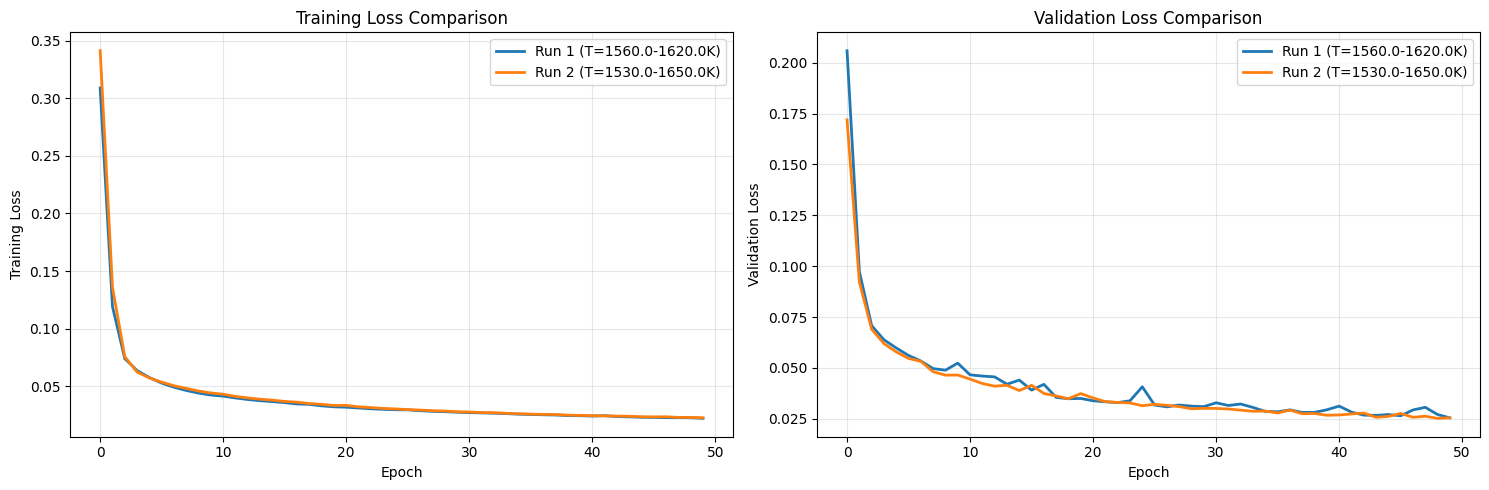

Comparison plot saved to runs_micro_net_cnn_lstm/comparison.png


In [15]:
# Plot comparison of training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss comparison
ax1.plot(history_1['train_loss'], label=f'Run 1 (T={T_SOLIDUS_1}-{T_LIQUIDUS_1}K)', linewidth=2)
ax1.plot(history_2['train_loss'], label=f'Run 2 (T={T_SOLIDUS_2}-{T_LIQUIDUS_2}K)', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation loss comparison
ax2.plot(history_1['val_loss'], label=f'Run 1 (T={T_SOLIDUS_1}-{T_LIQUIDUS_1}K)', linewidth=2)
ax2.plot(history_2['val_loss'], label=f'Run 2 (T={T_SOLIDUS_2}-{T_LIQUIDUS_2}K)', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
comparison_path = Path("runs_micro_net_cnn_lstm") / "comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Comparison plot saved to {comparison_path}")

In [ ]:
# Visualize both model predictions on timestamp 23, slice index 47
print("=" * 70)
print("Model Predictions Comparison - Timestamp 23, Slice 47")
print("=" * 70)

# The test dataset contains timesteps 18-23 (6 timesteps)
# Timestamp 23 is the last timestep in the test set
# Each timestep has 94 slices (slice indices 0-93)

target_timestep = 23
target_slice_idx = 47

# Find the sample in test_dataset that corresponds to timestep 23, slice 47
# The test dataset samples are organized by timestep and slice
# We need to find which sample index corresponds to our target

print(f"\nSearching for sample with timestep={target_timestep}, slice_index={target_slice_idx}...")

# Get a sample to understand the structure
sample_0 = test_dataset[0]
print(f"\nTest dataset info:")
print(f"  Total samples: {len(test_dataset)}")
print(f"  Sample 0 target timestep: {sample_0['target_timestep']}")
print(f"  Sample 0 slice index: {sample_0.get('slice_idx', 'N/A')}")

# Since we have 94 samples in test set and 94 slices per timestep,
# and test set has timesteps 18-23 (6 timesteps with 1 valid sequence),
# we need to find which sample corresponds to slice 47
# The slice_idx should be 47, so we look for that sample

found_idx = None
for idx in range(len(test_dataset)):
    sample = test_dataset[idx]
    # Check if this is the right slice (test dataset should be organized by slices)
    if idx == target_slice_idx:
        found_idx = idx
        break

if found_idx is None:
    print(f"\nWARNING: Could not find exact match. Using slice index {target_slice_idx} directly.")
    found_idx = target_slice_idx

# Get the sample
sample = test_dataset[found_idx]

print(f"\nUsing sample index: {found_idx}")
print(f"  Target timestep: {sample['target_timestep']}")
print(f"  Context timesteps: {sample['context_timesteps'].tolist()}")
print(f"  Slice coordinate: {sample['slice_coord']:.2f}")

# Prepare input data
context_temp = sample["context_temp"].unsqueeze(0).float().to(device)  # [1, seq_len, 1, H, W]
context_micro = sample["context_micro"].unsqueeze(0).float().to(device)  # [1, seq_len, 9, H, W]
future_temp = sample["future_temp"].unsqueeze(0).float().to(device)  # [1, 1, H, W]
target_micro = sample["target_micro"]  # [9, H, W]
target_mask = sample["target_mask"]  # [H, W]

# Combine context
context = torch.cat([context_temp, context_micro], dim=2)  # [1, seq_len, 10, H, W]

# Generate predictions from both models
print("\nGenerating predictions...")
model_1.eval()
model_2.eval()

with torch.no_grad():
    pred_micro_1 = model_1(context, future_temp).cpu().squeeze(0)  # [9, H, W]
    pred_micro_2 = model_2(context, future_temp).cpu().squeeze(0)  # [9, H, W]

print("  Model 1 prediction shape:", pred_micro_1.shape)
print("  Model 2 prediction shape:", pred_micro_2.shape)

# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Row 0: Temperature and Ground Truth
# Temperature (future)
temp_future = future_temp[0, 0].cpu().numpy()  # [H, W]
temp_future_masked = np.ma.masked_where(~target_mask.cpu().numpy(), temp_future)

im_temp = axes[0, 0].imshow(temp_future_masked, cmap='hot', interpolation='nearest')
axes[0, 0].set_title(f'Temperature\nt={sample["target_timestep"]}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')
plt.colorbar(im_temp, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Ground Truth Microstructure (IPF-X)
micro_target = target_micro[:3].cpu().numpy()  # [3, H, W]
micro_target_rgb = np.transpose(micro_target, (1, 2, 0))  # [H, W, 3]
mask_3d = np.stack([target_mask.cpu().numpy()] * 3, axis=-1)
micro_target_rgb_masked = np.where(mask_3d, micro_target_rgb, 0)

axes[0, 1].imshow(micro_target_rgb_masked, interpolation='nearest')
axes[0, 1].set_title(f'Ground Truth\nMicrostructure (IPF-X)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Hide the third subplot in first row
axes[0, 2].axis('off')

# Row 1: Model 1 Predictions
# Model 1 Prediction (IPF-X)
pred_1_rgb = np.transpose(pred_micro_1[:3].cpu().numpy(), (1, 2, 0))  # [H, W, 3]
pred_1_rgb_masked = np.where(mask_3d, pred_1_rgb, 0)

axes[1, 0].imshow(pred_1_rgb_masked, interpolation='nearest')
axes[1, 0].set_title(f'Model 1 Prediction\nT={T_SOLIDUS_1}-{T_LIQUIDUS_1}K', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Model 1 Error (absolute difference)
error_1 = np.abs(pred_1_rgb - micro_target_rgb)
error_1_masked = np.where(mask_3d, error_1, 0)

im_err1 = axes[1, 1].imshow(np.mean(error_1_masked, axis=2), cmap='hot', interpolation='nearest', vmin=0, vmax=0.5)
axes[1, 1].set_title(f'Model 1 Error\n(Mean Absolute Difference)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im_err1, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Model 1 Stats
mse_1 = ((pred_micro_1 - target_micro) ** 2).mean().item()
mae_1 = (torch.abs(pred_micro_1 - target_micro)).mean().item()
axes[1, 2].text(0.1, 0.5, f'Model 1 Statistics:\n\nMSE: {mse_1:.6f}\nMAE: {mae_1:.6f}', 
                fontsize=14, verticalalignment='center', transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')

# Row 2: Model 2 Predictions
# Model 2 Prediction (IPF-X)
pred_2_rgb = np.transpose(pred_micro_2[:3].cpu().numpy(), (1, 2, 0))  # [H, W, 3]
pred_2_rgb_masked = np.where(mask_3d, pred_2_rgb, 0)

axes[2, 0].imshow(pred_2_rgb_masked, interpolation='nearest')
axes[2, 0].set_title(f'Model 2 Prediction\nT={T_SOLIDUS_2}-{T_LIQUIDUS_2}K', fontsize=12, fontweight='bold')
axes[2, 0].axis('off')

# Model 2 Error (absolute difference)
error_2 = np.abs(pred_2_rgb - micro_target_rgb)
error_2_masked = np.where(mask_3d, error_2, 0)

im_err2 = axes[2, 1].imshow(np.mean(error_2_masked, axis=2), cmap='hot', interpolation='nearest', vmin=0, vmax=0.5)
axes[2, 1].set_title(f'Model 2 Error\n(Mean Absolute Difference)', fontsize=12, fontweight='bold')
axes[2, 1].axis('off')
plt.colorbar(im_err2, ax=axes[2, 1], fraction=0.046, pad=0.04)

# Model 2 Stats
mse_2 = ((pred_micro_2 - target_micro) ** 2).mean().item()
mae_2 = (torch.abs(pred_micro_2 - target_micro)).mean().item()
axes[2, 2].text(0.1, 0.5, f'Model 2 Statistics:\n\nMSE: {mse_2:.6f}\nMAE: {mae_2:.6f}', 
                fontsize=14, verticalalignment='center', transform=axes[2, 2].transAxes)
axes[2, 2].axis('off')

# Overall title
fig.suptitle(
    f'Model Comparison - Timestamp {target_timestep}, Slice {target_slice_idx}\n'
    f'XZ Plane | Slice Coordinate: {sample["slice_coord"]:.2f}',
    fontsize=16,
    fontweight='bold'
)

plt.tight_layout()

# Save the comparison
comparison_viz_path = Path("runs_micro_net_cnn_lstm") / f"prediction_comparison_t{target_timestep}_s{target_slice_idx}.png"
plt.savefig(comparison_viz_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {comparison_viz_path}")
print("\nComparison Summary:")
print(f"  Model 1 (T={T_SOLIDUS_1}-{T_LIQUIDUS_1}K): MSE={mse_1:.6f}, MAE={mae_1:.6f}")
print(f"  Model 2 (T={T_SOLIDUS_2}-{T_LIQUIDUS_2}K): MSE={mse_2:.6f}, MAE={mae_2:.6f}")